In [1]:
import csv
import pandas as pd
import hickle as hkl
import numpy as np
import scipy.sparse as sp
import sklearn.preprocessing as sk
from sklearn.feature_selection import VarianceThreshold

from torch.utils.data import TensorDataset, random_split, DataLoader,Dataset, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

from torch_geometric.data import Batch   

import torch

import random,os

from sklearn.metrics import roc_auc_score,precision_recall_curve

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class MyDataset(Dataset):
    def __init__(self, input_df):
        super(MyDataset, self).__init__()
        self.input_df = input_df
        
    def __len__(self):
        return len(self.input_df)

    def __getitem__(self, index):
        return (self.input_df['drug'][index], self.input_df['ids'][index], self.input_df['expres'][index],self.input_df['IC50'][index])

class MyDataset_simple(Dataset):
    def __init__(self, input_df):
        super(MyDataset_simple, self).__init__()
        self.input_df = input_df
        
    def __len__(self):
        return len(self.input_df)

    def __getitem__(self, index):
        return (self.input_df['drug'][index], self.input_df['expres'][index],self.input_df['IC50'][index])


def _collate(samples):
    drugs, ids, expres, labels = map(list, zip(*samples))
    batched_drug = Batch.from_data_list(drugs)
    return batched_drug, torch.tensor(ids), torch.tensor(expres), torch.tensor(labels)

def collate_simple(samples):
    drugs, expres, labels = map(list, zip(*samples))
    batched_drug = Batch.from_data_list(drugs)
    return batched_drug, torch.tensor(expres), torch.tensor(labels)


def get_gnn_dataloader(df, batch_size=64, simple = False):
    if simple:
        dataset = MyDataset_simple(df)
        collate_fn = collate_simple
    else:
        dataset = MyDataset(df)
        collate_fn = _collate
        
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
    
    return dataloader

def get_gnn_input_df(data_idx,drug_dict,gexpr_feature,over_under_ids_df,over_under_genes_df):
    
    #gexpr_feature.index = gexpr_feature.index.astype(str)
    df = pd.DataFrame(data = data_idx, columns = ['cell id','drug id', 'IC50'])
        
    df['drug'] = 0; 
    #all_drugs = set(df['drug id'])
    for drug_id in drug_dict.keys():
        new_df = pd.DataFrame({'drug': [drug_dict[drug_id]]}, index=df[df['drug id'].isin([str(drug_id)])].index)
        df.update(new_df)
        
    df['ids'] = 0; df['expres'] = 0;
    cell_ids = list(set([i[0] for i in data_idx]))
    #cell_ids = list(set(gexpr_feature.index.values).intersection(cell_ids))
    
    cell_df = pd.DataFrame(index = cell_ids, columns = ['ids','expres'])
    for cell_id in cell_ids:
        genes = over_under_genes_df.loc[cell_id].values
        #gexpr_data[idx,:] = gexpr_feature.loc[cell_line_id][genes].values
        cell_df.loc[cell_id]['ids'] = over_under_ids_df.loc[cell_id].values
        cell_df.loc[cell_id]['expres'] = gexpr_feature.loc[cell_id][genes].values
    
    for cell_id in cell_df.index:
        new_df = pd.DataFrame({'ids': [cell_df['ids'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        new_df = pd.DataFrame({'expres': [cell_df['expres'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        
    return df

def get_drug_cell_info(Drug_info_file,Drug_feature_file,Gene_expression_file,cancer_response_exp_file,
                       threshold = 6.3, norm = False, small_genes = False):
                   
    #drug_id --> pubchem_id
    reader = csv.reader(open(Drug_info_file,'r'))
    rows = [item for item in reader]
    drugid2pubchemid = {item[0]:item[6] for item in rows if item[6].isdigit()}
       

    # load drug features
    drug_pubchem_id_set = []
    drug_feature = {}
    
    for each in os.listdir(Drug_feature_file):
        drug_pubchem_id_set.append(each.split('.')[0])
        feat_mat,adj_list,degree_list = hkl.load('%s/%s'%(Drug_feature_file,each))
        drug_feature[each.split('.')[0]] = [feat_mat,adj_list,degree_list]
    assert len(drug_pubchem_id_set)==len(drug_feature.values())
    

    gexpr_feature = pd.read_csv(Gene_expression_file,sep=',',header=0,index_col=[0])

    if norm:
        scalerGDSC = sk.StandardScaler()
        scalerGDSC.fit(gexpr_feature.values)
        gexpr_feature = pd.DataFrame(data=scalerGDSC.transform(gexpr_feature.values),
                                     index = gexpr_feature.index,
                                     columns = gexpr_feature.columns)
        
    gexpr_feature.columns = gexpr_feature.columns.astype(str)
    experiment_data = pd.read_csv(cancer_response_exp_file,sep=',',header=0,index_col=[0],engine='python')
    

    for i in range(len(experiment_data.columns)):
        experiment_data.rename(columns={experiment_data.columns[i]:'DATA.'+str(experiment_data.columns[i])},inplace=True)


    
    return drugid2pubchemid, drug_pubchem_id_set, gexpr_feature, drug_feature, experiment_data
    
def get_idx(drugid2pubchemid, drug_pubchem_id_set, gexpr_feature,experiment_data,binary=False):
    
    #filter experiment data
    drug_match_list=[item for item in experiment_data.index if item.split(':')[1] in drugid2pubchemid.keys()]
    experiment_data_filtered = experiment_data.loc[drug_match_list]
     
    data_idx = []
    for each_drug in experiment_data_filtered.index:
        for each_cellline in experiment_data_filtered.columns:
            pubchem_id = drugid2pubchemid[each_drug.split(':')[-1]]
            if str(pubchem_id) in drug_pubchem_id_set and each_cellline:
                if not np.isnan(experiment_data_filtered.loc[each_drug,each_cellline]) and each_cellline in gexpr_feature.index:
                    ln_IC50 = float(experiment_data_filtered.loc[each_drug,each_cellline])
                    data_idx.append((each_cellline,pubchem_id,ln_IC50)) 
    nb_celllines = len(set([item[0] for item in data_idx]))
    nb_drugs = len(set([item[1] for item in data_idx]))
    print('%d instances across %d cell lines and %d drugs were generated.'
          %(len(data_idx),nb_celllines,nb_drugs))
        
    return data_idx

def get_input_df(data_idx,drug_feature,gexpr_feature,over_under_ids_df,over_under_genes_df):
    
    #gexpr_feature.index = gexpr_feature.index.astype(str)
    
    df = pd.DataFrame(data = data_idx, columns = ['cell id','drug id', 'IC50'])
        
    
    drug_df = pd.DataFrame(index = drug_feature.keys(),columns = ['data'])
    for drug_id in drug_feature.keys():
        feat_mat,adj_list,_ = drug_feature[drug_id]
        drug_df.loc[drug_id]['data'] = CalculateGraphFeat(feat_mat,adj_list)
    
    df['drug1'] = 0; df['drug2'] = 0; 
    
    for drug_id in drug_df.index:
        new_df = pd.DataFrame({'drug1': [drug_df['data'][drug_id][0]]}, index=df[df['drug id'].isin([drug_id])].index)
        df.update(new_df)
        new_df = pd.DataFrame({'drug2': [drug_df['data'][drug_id][1]]}, index=df[df['drug id'].isin([drug_id])].index)
        df.update(new_df)
        
    df['ids'] = 0; df['expres'] = 0;
    cell_ids = list(set([i[0] for i in data_idx]))
    #cell_ids = list(set(gexpr_feature.index.values).intersection(cell_ids))
    
    cell_df = pd.DataFrame(index = cell_ids, columns = ['ids','expres'])
    for cell_id in cell_ids:
        genes = over_under_genes_df.loc[cell_id].values
        #gexpr_data[idx,:] = gexpr_feature.loc[cell_line_id][genes].values
        cell_df.loc[cell_id]['ids'] = over_under_ids_df.loc[cell_id].values
        cell_df.loc[cell_id]['expres'] = gexpr_feature.loc[cell_id][genes].values
    
    for cell_id in cell_df.index:
        new_df = pd.DataFrame({'ids': [cell_df['ids'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        new_df = pd.DataFrame({'expres': [cell_df['expres'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        
    return df

def get_simple_input_df(data_idx,drug_feature,gexpr_feature,drug_dict = {}):
    
    #gexpr_feature.index = gexpr_feature.index.astype(str)
    
    df = pd.DataFrame(data = data_idx, columns = ['cell id','drug id', 'IC50'])
        
    if len(drug_dict):
        df['drug'] = 0; 
        
        for drug_id in drug_dict.keys():
            new_df = pd.DataFrame({'drug': [drug_dict[drug_id]]}, index=df[df['drug id'].isin([str(drug_id)])].index)
            df.update(new_df)
    else:
        drug_df = pd.DataFrame(index = drug_feature.keys(),columns = ['data'])
        
        for drug_id in drug_feature.keys():
            feat_mat,adj_list,_ = drug_feature[drug_id]
            drug_df.loc[drug_id]['data'] = CalculateGraphFeat(feat_mat,adj_list)
        
        df['drug1'] = 0; df['drug2'] = 0; 
        
        for drug_id in drug_df.index:
            new_df = pd.DataFrame({'drug1': [drug_df['data'][drug_id][0]]}, index=df[df['drug id'].isin([drug_id])].index)
            df.update(new_df)
            new_df = pd.DataFrame({'drug2': [drug_df['data'][drug_id][1]]}, index=df[df['drug id'].isin([drug_id])].index)
            df.update(new_df)
        
    df['expres'] = 0;
    cell_ids = list(set([i[0] for i in data_idx]))
    cell_df = pd.DataFrame(index = cell_ids, columns = ['expres'])
    for cell_id in cell_ids:
        cell_df.loc[cell_id]['expres'] = gexpr_feature.loc[cell_id].values
    
    for cell_id in cell_df.index:
        new_df = pd.DataFrame({'expres': [cell_df['expres'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        
    return df

def get_dataloader(drug_ids,sample_ids,input_df,simple = False, batch_size=64, val_ratio=None, test_ratio = None):
    df = input_df
    if sample_ids:
        df = df[df['cell id'].isin(sample_ids)]
    if drug_ids:
        df = df[df['drug id'].isin(drug_ids)]
    
    X_drug_feat_data = [item for item in df['drug1']]
    X_drug_adj_data = [item for item in df['drug2']]
    X_drug_feat_data = np.array(X_drug_feat_data)#nb_instance * Max_stom * feat_dim
    X_drug_adj_data = np.array(X_drug_adj_data)#nb_instance * Max_stom * Max_stom
    
    X_drug_feat_data = torch.Tensor(X_drug_feat_data)
    X_drug_adj_data = torch.Tensor(X_drug_adj_data)
    
    
    X_gexpr_data = [item for item in df['expres']]
    X_gexpr_data = torch.Tensor(X_gexpr_data)
    
    Y = [item for item in df['IC50']]
    Y = torch.Tensor(Y)
    
    if not simple:
        X_genes_data = [item for item in df['ids']]
        X_genes_data = torch.Tensor(X_genes_data)
        X_genes_data = X_genes_data.type(torch.int64)
        
        dataset = TensorDataset(X_drug_feat_data,X_drug_adj_data, X_genes_data,X_gexpr_data,Y)
    else:
        dataset = TensorDataset(X_drug_feat_data,X_drug_adj_data, X_gexpr_data,Y)
    if val_ratio:
        
        if test_ratio:
            test_size = int(test_ratio * len(dataset))
            train_size = len(dataset) - test_size
            dataset, test_dataset = random_split(dataset, [train_size, test_size])
            test_dataloader = DataLoader(
                        test_dataset, # The validation samples.
                        sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
                        batch_size = batch_size # Evaluate with this batch size.
                    )
            
        val_size = int(val_ratio * len(dataset))
        train_size = len(dataset) - val_size
            
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = batch_size # Trains with this batch size.
                )
        
        # For validation the order doesn't matter, so we'll just read them sequentially.
        validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = batch_size # Evaluate with this batch size.
                )
        
    else:
        train_dataloader = DataLoader(
                    dataset,  # The training samples.
                    sampler = RandomSampler(dataset), # Select batches randomly
                    batch_size = batch_size # Trains with this batch size.
                )
        
    if test_ratio:
        return train_dataloader, validation_dataloader, test_dataloader
    elif val_ratio:
        return train_dataloader, validation_dataloader
    else:
        return train_dataloader

def show_picture(train,val, test, title, path='' ,save=False):
    plt.plot(train)
    plt.plot(val)
    plt.plot(test)
    plt.legend(['train','val','test'])
    plt.title(title)
    if save:
        plt.savefig(path+title+'.png')
    
    plt.show()
    
def get_rand_genes(tokenizer, x_samples, nGenes, gexpr_feature):
    gexpr = gexpr_feature.loc[x_samples]
    genes = gexpr_feature.columns.values
    rand_genes = [random.choices(population=genes, k=nGenes) for i in range(gexpr.shape[0])]
    rand_ids = torch.tensor([tokenizer.convert_symb_to_id(genes) for genes in rand_genes])
    rand_exprs  = torch.tensor([gexpr.iloc[i][rand_genes[i]].values for i in range(len(rand_genes))])
    
    return rand_ids,rand_exprs

Max_atoms = 100

def NormalizeAdj(adj):
    adj = adj + np.eye(adj.shape[0])
    d = sp.diags(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0).toarray()
    a_norm = adj.dot(d).transpose().dot(d)
    return a_norm

def random_adjacency_matrix(n):   
    matrix = [[random.randint(0, 1) for i in range(n)] for j in range(n)]
    # No vertex connects to itself
    for i in range(n):
        matrix[i][i] = 0
    # If i is connected to j, j is connected to i
    for i in range(n):
        for j in range(n):
            matrix[j][i] = matrix[i][j]
    return matrix

def CalculateGraphFeat(feat_mat,adj_list):
    assert feat_mat.shape[0] == len(adj_list)
    feat = np.zeros((Max_atoms,feat_mat.shape[-1]),dtype='float32')
    adj_mat = np.zeros((Max_atoms,Max_atoms),dtype='float32')
    if True:
        feat = np.random.rand(Max_atoms,feat_mat.shape[-1])
        adj_mat[feat_mat.shape[0]:,feat_mat.shape[0]:] = random_adjacency_matrix(Max_atoms-feat_mat.shape[0])        
    feat[:feat_mat.shape[0],:] = feat_mat
    for i in range(len(adj_list)):
        nodes = adj_list[i]
        for each in nodes:
            adj_mat[i,int(each)] = 1
    assert np.allclose(adj_mat,adj_mat.T)
    adj_ = adj_mat[:len(adj_list),:len(adj_list)]
    adj_2 = adj_mat[len(adj_list):,len(adj_list):]
    norm_adj_ = NormalizeAdj(adj_)
    norm_adj_2 = NormalizeAdj(adj_2)
    adj_mat[:len(adj_list),:len(adj_list)] = norm_adj_
    adj_mat[len(adj_list):,len(adj_list):] = norm_adj_2    
    return [feat,adj_mat]


def metrics_graph(yt, yp):
    precision, recall, _, = precision_recall_curve(yt, yp)
    aupr = -np.trapz(precision, recall)
    auc = roc_auc_score(yt, yp)
    #---f1,acc,recall, specificity, precision
    real_score=np.mat(yt)
    predict_score=np.mat(yp)
    sorted_predict_score = np.array(sorted(list(set(np.array(predict_score).flatten()))))
    sorted_predict_score_num = len(sorted_predict_score)
    thresholds = sorted_predict_score[np.int32(sorted_predict_score_num * np.arange(1, 1000) / 1000)]
    thresholds = np.mat(thresholds)
    thresholds_num = thresholds.shape[1]
    predict_score_matrix = np.tile(predict_score, (thresholds_num, 1))
    negative_index = np.where(predict_score_matrix < thresholds.T)
    positive_index = np.where(predict_score_matrix >= thresholds.T)
    predict_score_matrix[negative_index] = 0
    predict_score_matrix[positive_index] = 1
    TP = predict_score_matrix.dot(real_score.T)
    FP = predict_score_matrix.sum(axis=1) - TP
    FN = real_score.sum() - TP
    TN = len(real_score.T) - TP - FP - FN
    tpr = TP / (TP + FN)
    recall_list = tpr
    precision_list = TP / (TP + FP)
    f1_score_list = 2 * TP / (len(real_score.T) + TP - TN)
    accuracy_list = (TP + TN) / len(real_score.T)
    specificity_list = TN / (TN + FP)
    max_index = np.argmax(f1_score_list)
    f1_score = f1_score_list[max_index]
    accuracy = accuracy_list[max_index]
    specificity = specificity_list[max_index]
    recall = recall_list[max_index]
    precision = precision_list[max_index]
    return auc, aupr, f1_score[0, 0], accuracy[0, 0], recall[0, 0], specificity[0, 0], precision[0, 0]

def get_binary_gene_set(tokenizer, gexpr_feature, nGenes, random_genes = True, num_augment = 1):
    abs_gexpr = np.abs(gexpr_feature-np.mean(gexpr_feature))
    
    all_genes = list(gexpr_feature.columns)
    
    over_under_genes_list = [[] for i in range(num_augment)]
    over_under_ids_list = [[] for i in range(num_augment)]
    
    for i in range(abs_gexpr.shape[0]):
        
        for j in range(num_augment):
            if j ==0 or not(random_genes):
                genes = abs_gexpr.iloc[i].sort_values(ascending = False)[nGenes*j:nGenes*(j+1)].index
            else:
                genes = random.sample(all_genes, nGenes)
                
            ids = tokenizer.convert_symb_to_id(genes)
            
            over_under_ids_list[j].append(ids)
            over_under_genes_list[j].append(genes)
    
    over_under_ids_df_list = [pd.DataFrame(data = over_under_ids_list[i],index = gexpr_feature.index) for i in range(num_augment)]
    over_under_genes_df_list = [pd.DataFrame(data = over_under_genes_list[i],index = gexpr_feature.index) for i in range(num_augment)]
    return over_under_ids_df_list, over_under_genes_df_list


def get_gene_set(tokenizer, gexpr_feature, methyl_feature,nGenes, random_genes = True):
    scalerGDSC = sk.StandardScaler()
    scalerGDSC.fit(methyl_feature.values)
    methyl_feature = pd.DataFrame(data=scalerGDSC.transform(methyl_feature.values),
                                    index = methyl_feature.index,
                                    columns = methyl_feature.columns)

    scalerGDSC = sk.StandardScaler()
    scalerGDSC.fit(gexpr_feature.values)
    gexpr_feature = pd.DataFrame(data=scalerGDSC.transform(gexpr_feature.values),
                                    index = gexpr_feature.index,
                                    columns = gexpr_feature.columns)
    
    over_under_genes = []
    over_under_ids = []
    
    #all_genes = list(gexpr_feature.columns)
    
    for i in range(gexpr_feature.shape[0]):
        #genes = random.sample(all_genes, nGenes)
        genes = (methyl_feature * gexpr_feature).iloc[i].sort_values(ascending = True)[:nGenes].index
        ids = tokenizer.convert_symb_to_id(genes)
        
        over_under_ids.append(ids)
        over_under_genes.append(genes)
    
    over_under_ids_df_gexpr = pd.DataFrame(data = over_under_ids,index = gexpr_feature.index)
    over_under_genes_df_gexpr = pd.DataFrame(data = over_under_genes,index = gexpr_feature.index)
    over_under_ids_df_methyl = pd.DataFrame(data = over_under_ids,index = gexpr_feature.index)
    over_under_genes_df_methyl = pd.DataFrame(data = over_under_genes,index = gexpr_feature.index)

    return  over_under_ids_df_gexpr,over_under_genes_df_gexpr,over_under_ids_df_methyl,over_under_genes_df_methyl

In [2]:
import torch
import torch.nn as nn   

from torch_geometric.nn import GINConv, JumpingKnowledge, global_max_pool, GATConv

import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import math

from sklearn.utils import shuffle
import collections
import pandas as pd

class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class Gene_Embedding(nn.Module):
    def __init__(self, vocab_size= None,embed_size=None):
        super(Gene_Embedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding_dim = embed_size
        self.eps = 1e-12
        
    def forward(self, genes=None,scales=None):
        x = self.embedding(genes)
        x = self.unit(x)
        x *= scales.unsqueeze(-1) 
        return x
        
    def unit(self,x):
        return (x+self.eps)/(torch.norm(x,dim=2).unsqueeze(-1)+self.eps)


class Tokenizer():
    def __init__(
        self, Gene_vocab, shuf= True, pad_token=0, sep_token=1, unk_token=2, cls_token=3, mask_token=4, **kwargs):
        super().__init__()
        self.Gene_vocab = Gene_vocab
        self.unk_token = unk_token
        self.sep_token = sep_token
        self.pad_token = pad_token
        self.cls_token = cls_token
        self.mask_token = mask_token
        self.shuf = shuf
        
        self.special_tokens = {'UNK':self.unk_token, 'SEP':self.sep_token, 
                               'PAD':self.pad_token, 'CLS':self.cls_token,
                               'MASK':self.mask_token}
        

        self.symb_to_id = collections.OrderedDict([(SYMBOL, ID) for SYMBOL,ID in self.Gene_vocab.values])
        
    @property
    def vocab_size(self):
        return len(self.Gene_vacab)

    def get_vocab(self):
        return self.Gene_vocab 
    
    def tokenize(self, sample):
        pathway = sample['pathway']
        sample_Id = sample['Id']
        genes_scales = pd.Series(data = sample['scales'],index = sample['genes'])
        genes = list(genes_scales.index.astype(str))
        scales = list(genes_scales.values)
        
        if self.shuf:
            genes,scales = shuffle(genes, scales)
                
        token = {"pathway":pathway,"sample_Id":sample_Id,
                 "genes":genes,"scales":scales}
        
        return token
    
    def check_unk(self,genes):
        genes = [gene if gene is not None else self.special_tokens['UNK'] for gene in genes]
        return genes
    
    def check_mis_scale(self,scales):
        scales = [scale if scale > 1e-12 else 1.0 for scale in scales]
        return scales
                
    def convert_symb_to_id(self, symbs):
        return [self.symb_to_id.get(symb) for symb in symbs]


    def convert_id_to_symb(self, indices):
        return [list(self.symb_to_id.keys())[list(self.symb_to_id.values()).index(index)] for index in indices]
    
    def encode(self, sample, add_special_tokens = True, 
               max_length = 128, pad_to_max_length = True,
               gene_type = 'SYMBOL'):
        
        token = self.tokenize(sample)

        token['genes'] = self.convert_symb_to_id(token['genes'])
        
        token['genes'] = self.check_unk(token['genes'])
        token['scales'] = self.check_mis_scale(token['scales'])
        
        if add_special_tokens:
            token['genes'] = [self.special_tokens['CLS']] + token['genes'] + [self.special_tokens['SEP']]
            token['scales'] = [1] + token['scales'] + [1] 
        
        if pad_to_max_length:
            token['genes'] += [self.special_tokens['PAD']]*(max_length+2 - len(token['genes']))
            token['scales'] += [self.special_tokens['PAD']]*(max_length+2 - len(token['scales']))
            
        return token
    
    def encode2torch(self, sample, add_special_tokens = True, 
                    max_length = 128, pad_to_max_length = True,
                    gene_type = 'SYMBOL'):
        
        token = self.encode(sample, add_special_tokens = add_special_tokens
                            ,gene_type = gene_type)
            
        token['genes'] = torch.tensor(token['genes'])
        token['scales'] = torch.tensor(token['scales'], dtype=torch.float)
            
        return token
    
    
    def encode_pair(self, sample1, sample2, add_special_tokens = True, 
                    max_len = 128, pad_to_max_length = True,
                    return_attention_mask = False,
                    gene_type = 'ENTREZID'):
        
        token1 = self.tokenize(sample1)
        token2 = self.tokenize(sample2)
        pair_token = {}
        

        token1['genes'] = self.convert_symb_to_id(token1['genes'])
        token2['genes'] = self.convert_symb_to_id(token2['genes'])
        
        token1['genes'] = self.check_unk(token1['genes'])
        token2['genes'] = self.check_unk(token2['genes'])
        
        token1['scales'] = self.check_mis_scale(token1['scales'])
        token2['scales'] = self.check_mis_scale(token2['scales'])
        
        if add_special_tokens:
            token1['genes'] = [self.special_tokens['CLS']] + token1['genes'] + [self.special_tokens['SEP']]
            token2['genes'] = token2['genes'] + [self.special_tokens['SEP']]
            
            token1['scales'] = [1] + token1['scales'] + [1]
            token2['scales'] = token2['scales'] + [1] 
            
        pair_token['genes'] = token1['genes'] + token2['genes'] 
        pair_token['scales'] = token1['scales'] + token2['scales']
            
        if pad_to_max_length:
            pair_token['genes'] += [self.special_tokens['PAD']]*(max_len-len(pair_token['genes']))
            pair_token['scales'] += [self.special_tokens['PAD']]*(max_len-len(pair_token['scales']))
            
        pair_token['genes'] = torch.tensor(pair_token['genes'])
        pair_token['scales'] = torch.tensor(pair_token['scales'], dtype=torch.float)
        pair_token['sample_Ids'] = (sample1['Id'],sample2['Id'])
        pair_token['pathways'] = (sample1['pathway'],sample2['pathway'])
        
        return pair_token
    

class GEN(torch.nn.Module):
    def __init__(self, y_dim = 256, dropout_ratio = 0.3,
                 gnn = None, embedding = None, encoder = None):
        super().__init__()
        self.encoder = encoder
        self.embedding = embedding 
        self.gnn = gnn 
        
        self.dropout_ratio = dropout_ratio
        self.y_dim = y_dim
    
        self.do = nn.Dropout(self.dropout_ratio)
        
        self.regression = nn.Sequential(
            nn.Linear(self.y_dim, 512),
            nn.ELU(),
            nn.Dropout(p=self.dropout_ratio),
            nn.Linear(512, 512),
            nn.ELU(),
            nn.Dropout(p=self.dropout_ratio),
            nn.Linear(512, 1)
        )
        
        
    def forward(self,x_drug,x_gexpr, x_genes):
        x_d = self.gnn(x_drug)
        
        x_g = self.embedding(x_genes, x_gexpr)
        
        x = self.encoder(x_g,x_d)
        
        y = self.regression(x)
        
        return y


class Att_Encoder(nn.Module):
    def __init__(self, x_dim = 64, y_dim = 512, dropout = 0.15):
        super(Att_Encoder, self).__init__()
        
        self.key_fc = nn.Linear(x_dim,y_dim)
        self.query_fc = nn.Linear(x_dim,y_dim)
        self.value_fc = nn.Linear(x_dim,y_dim)
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        key = self.key_fc(x) #Q
        query = self.query_fc(x) #K
        value = self.value_fc(x)
        
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))
        att = self.softmax(scores)
        
        y = torch.matmul(att, value)
        y = self.layer_norm(y)+value
        y = self.dropout(y)
        
        return y

class Transformer_Encoder(nn.Module):
    def __init__(self, genes=300, x_dim = 64, y_dim = 512, dropout = 0.15, encoder = None):
        super(Transformer_Encoder, self).__init__()
        
        self.key_fc = nn.Linear(x_dim,y_dim)
        self.query_fc = nn.Linear(x_dim,y_dim)
        self.value_fc = nn.Linear(x_dim,y_dim)
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
        if encoder == 'MixedFC':
            self.encoder = MixedFC_Encoder(genes=genes, x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        elif encoder == 'SimpleFC':
            self.encoder = SimpleFC_Encoder(x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        else:
            self.encoder = encoder
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        key = self.key_fc(x) 
        query = self.query_fc(x) 
        value = self.value_fc(x)
        
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))
        att = self.softmax(scores)
        
        y = torch.matmul(att, value)
        y = self.layer_norm(y)+value
        
        if self.encoder is not None:
            y = self.encoder(y) + y
        
        return y

class MixedFC_Encoder(nn.Module):
    def __init__(self, genes=300, x_dim = 64, y_dim = 512, dropout = 0.15):
        super(MixedFC_Encoder, self).__init__()
        
        self.feed1 = nn.Linear(x_dim,y_dim)
        self.feed2 = nn.Linear(genes,genes)
        self.layer_norm1 = nn.LayerNorm(y_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.layer_norm1(self.feed2(self.activation(self.feed1(x)).permute(0,2,1)).permute(0,2,1))
        y = self.dropout(y)
        
        return y

class SimpleFC_Encoder(nn.Module):
    def __init__(self, x_dim = 64, y_dim = 512, dropout = 0.15):
        super(SimpleFC_Encoder, self).__init__()
        
        self.feed1 = nn.Linear(x_dim,y_dim)
        self.feed2 = nn.Linear(y_dim,y_dim)
        self.layer_norm1 = nn.LayerNorm(y_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.layer_norm1(self.feed2(self.activation(self.feed1(x))))
        y = self.dropout(y)
        
        return y
    
class Main_Encoder(nn.Module):
    def __init__(self, cell_encoder = None, d_dim = 128, 
                 genes=300, y_dim=512, dropout = 0.15):
        
        super(Main_Encoder, self).__init__()
        self.cell_encoder = cell_encoder
        
        self.feed1 = nn.Linear(d_dim,y_dim)
        self.feed2 = nn.Linear(y_dim,y_dim)
        self.activation = GELU() 
        
        self.layer_norm1 = nn.LayerNorm(y_dim*2)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x_g: torch.Tensor, x_d: torch.Tensor) -> torch.Tensor:
        x1 = self.cell_encoder(x_g)
        y1, _ = torch.max(x1, dim= 1)  # [batchsize, embeddings_dim]
        
        y2 = self.feed2(self.activation(self.feed1(x_d)))
        
        y = torch.cat([y1,y2],dim = 1)
        y = self.dropout(self.layer_norm1(y))
        
        return y
    
class GEN_WO_GeneVec(torch.nn.Module):
    def __init__(self,gcn = None, gexpr_dim=100, dropout_drug = 0.1, dropout_cell = 0.1,
                 dropout_reg = 0.1, d_dim = 128*3, y_dim = 512):#
        super().__init__()
        self.d_dim = d_dim
        self.y_dim = y_dim
        self.gcn = gcn
        
        self.fc_d1 = nn.Linear(d_dim,y_dim)
        self.fc_d2 = nn.Linear(y_dim,y_dim)
        self.activation = GELU() 
        
        self.fc_g1 = nn.Linear(gexpr_dim,y_dim)
        self.fc_g2 = nn.Linear(y_dim,y_dim)
        
        self.layer_norm1 = nn.LayerNorm(y_dim*2)
        self.dropout_drug = nn.Dropout(dropout_drug)
        self.dropout_cell = nn.Dropout(dropout_cell)
        
        self.regression = nn.Sequential(
                nn.Linear(self.y_dim*2, 512),
                nn.ELU(),
                nn.Dropout(p=dropout_reg),
                nn.Linear(512, 512),
                nn.ELU(),
                nn.Dropout(p=dropout_reg),
                nn.Linear(512, 1)
            )
        
    def forward(self,x_feat=None,x_adj=None,x_gexpr=None):
        x = self.gcn(x_feat)
        
        x = self.fc_d1(x)
        x = self.activation(x)
        x = self.dropout_drug(x)
        x = self.fc_d2(x)
        
        x_gexpr = self.fc_g1(x_gexpr)
        x_gexpr = self.activation(x_gexpr) 
        x_gexpr = self.dropout_cell(x_gexpr) 
        x_gexpr = self.fc_g2(x_gexpr)
        
        x = torch.cat([x,x_gexpr], dim=1) #Concatenate()([x,x_gexpr])
        x = self.layer_norm1(x)
        
        y = self.regression(x)
        
        return y


class GNN_drug(torch.nn.Module):
    def __init__(self, layer_drug, dim_drug, do):
        super().__init__()
        self.layer_drug = layer_drug
        self.dim_drug = dim_drug
        self.JK = JumpingKnowledge('cat')
        self.convs_drug = torch.nn.ModuleList()
        self.bns_drug = torch.nn.ModuleList()
        self.dropout = torch.nn.Dropout(do)
        
        for i in range(self.layer_drug):
            if i:
                block = nn.Sequential(nn.Linear(self.dim_drug, self.dim_drug), nn.ReLU(),
                                      nn.Linear(self.dim_drug, self.dim_drug))
            else:
                block = nn.Sequential(nn.Linear(77, self.dim_drug), nn.ReLU(), 
                                      nn.Linear(self.dim_drug, self.dim_drug))
            conv = GINConv(block)
            bn = torch.nn.BatchNorm1d(self.dim_drug)

            self.convs_drug.append(conv)
            self.bns_drug.append(bn)

    def forward(self, drug):
        x, edge_index, batch = drug.x, drug.edge_index, drug.batch
        x_drug_list = []
        for i in range(self.layer_drug):
            x = F.relu(self.convs_drug[i](x, edge_index))
            x = self.bns_drug[i](x)
            x_drug_list.append(x)

        node_representation = self.JK(x_drug_list)
        x_drug = global_max_pool(node_representation, batch)
        x_drug = self.dropout(x_drug)
        return x_drug


class DeepCDR_GIN(torch.nn.Module):
    
    def __init__(self,gcn = None, gexpr_dim=100, dropout = 0.1, gnn_dim = 128*3):#
        super().__init__()
        self.gnn_dim = gnn_dim
        self.gnn_dim = gnn_dim
        self.gcn = gcn
        
        self.fc_g1 = nn.Linear(gexpr_dim,256)
        self.fc_g2 = nn.Linear(256,100)
        
        self.fc_d1 = nn.Linear(self.gnn_dim,self.gnn_dim)
        self.fc_d2 = nn.Linear(self.gnn_dim,self.gnn_dim)
        
        
        self.fc1 = nn.Linear(100+self.gnn_dim,300)
        self.fc2 = nn.Linear(30,1)
        
        self.do = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.bn = nn.BatchNorm1d(256)
        
        self.conv1 = nn.Conv2d(1, 30, (150,1), stride=(1,1))
        self.conv2 = nn.Conv2d(30, 10, (5,1), stride=(1,1))
        self.conv3 = nn.Conv2d(10, 5, (5,1), stride=(1,1))
        
        self.max_pool1 = nn.MaxPool2d((2,1))
        self.max_pool2 = nn.MaxPool2d((3,1))
        
    def forward(self,x_feat=None,x_adj=None,x_gexpr=None):
        x = self.gcn(x_feat)
        x = self.fc_d1(x)
        x = self.relu(x)
        x = self.fc_d2(x)
        
        x_gexpr = self.fc_g1(x_gexpr) #Dense(256)(gexpr_input)
        x_gexpr = self.tanh(x_gexpr) #Activation('tanh')(x_gexpr)
        x_gexpr = self.bn(x_gexpr) #BatchNormalization()(x_gexpr)
        x_gexpr = self.do(x_gexpr) #Dropout(0.1)(x_gexpr)
        x_gexpr = self.relu(self.fc_g2(x_gexpr)) #Dense(100,activation='relu')(x_gexpr)
            
        x = torch.cat([x,x_gexpr], dim=1) #Concatenate()([x,x_gexpr])
            
        x = self.fc1(x)
        x = torch.unsqueeze(x,-1)
        x = torch.unsqueeze(x,1)

        x = self.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = self.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = self.relu(self.conv3(x))
        x = self.max_pool2(x)
        x = F.dropout(x,0.1)
        x = torch.flatten(x,start_dim=1)
        x = F.dropout(x,0.2)
        output = self.fc2(x)
        
        return output


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self,in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)
        if self.bias is not None:
            support += self.bias
        
        #output = torch.matmul(adj.permute(0,2,1), support)
        output = torch.matmul(adj, support)
        
        return output
    
    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nhid)
        self.gc3 = GraphConvolution(nhid, nhid)
        self.gc4 = GraphConvolution(nhid, nclass)
        self.dropout = dropout
        
        self.NEG_INF = -1e38

    def max_pooling(self,x, adj):
        node_num = x.shape[1]
        features = torch.unsqueeze(x,1).repeat(1, node_num, 1, 1) \
                    + torch.unsqueeze((1.0 - adj) * self.NEG_INF, -1)
        return torch.max(features,2)[0]
    
    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = F.relu(self.gc3(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = F.relu(self.gc4(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = (torch.sum(x,dim=1)/x.shape[1])
        
        return x


class DeepCDR(torch.nn.Module):
    
    def __init__(self,gcn = None, use_mut=0,use_gexp=0,use_methy=0,gexpr_dim=100,regr=True,units_list=None,
                 use_relu=True,use_bn=True,use_GMP=True,dropout = 0.1, gnn_dim = 100, use_gin = False):#
        super().__init__()
        self.use_mut = use_mut
        self.use_gexp = use_gexp
        self.use_methy = use_methy
        self.regr = regr
        self.gnn_dim = gnn_dim
        self.use_gin = use_gin
        
        self.gcn = gcn#GCN(75, 256, 100, dropout) 
        self.fc_g1 = nn.Linear(gexpr_dim,256)
        self.fc_g2 = nn.Linear(256,100)
        
        self.fc1 = nn.Linear((use_mut+use_gexp+use_methy)*100+self.gnn_dim,300)
        self.fc2 = nn.Linear(30,1)
        
        #self.fc_m1 = torch.nn.linear(methy_dim,256)
        #self.fc_m2 = torch.nn.linear(256,100)
        self.do = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.bn = nn.BatchNorm1d(256)
        
        self.conv1 = nn.Conv2d(1, 30, (150,1), stride=(1,1))
        self.conv2 = nn.Conv2d(30, 10, (5,1), stride=(1,1))
        self.conv3 = nn.Conv2d(10, 5, (5,1), stride=(1,1))
        
        self.max_pool1 = nn.MaxPool2d((2,1))
        self.max_pool2 = nn.MaxPool2d((3,1))
        
    def forward(self,x_feat=None,x_adj=None,x_gexpr=None):
        x = self.gcn(x_feat,x_adj)
        
        if self.use_gexp:
            x_gexpr = self.fc_g1(x_gexpr) #Dense(256)(gexpr_input)
            x_gexpr = self.tanh(x_gexpr) #Activation('tanh')(x_gexpr)
            x_gexpr = self.bn(x_gexpr) #BatchNormalization()(x_gexpr)
            x_gexpr = self.do(x_gexpr) #Dropout(0.1)(x_gexpr)
            x_gexpr = self.relu(self.fc_g2(x_gexpr)) #Dense(100,activation='relu')(x_gexpr)
            
            x = torch.cat([x,x_gexpr], dim=1) #Concatenate()([x,x_gexpr])
            
        x = self.fc1(x)
        x = torch.unsqueeze(x,-1)
        x = torch.unsqueeze(x,1)

        x = self.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = self.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = self.relu(self.conv3(x))
        x = self.max_pool2(x)
        x = F.dropout(x,0.1)
        x = torch.flatten(x,start_dim=1)
        x = F.dropout(x,0.2)
        output = self.fc2(x)
        
        return output    

In [3]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
from scipy.stats import pearsonr

import torch.nn as nn
import torch

from torch import optim
from sklearn.metrics import r2_score, roc_auc_score, mean_squared_error

cuda_condition = torch.cuda.is_available()
device = torch.device("cuda:1" if cuda_condition else "cpu")

gene_vocab = pd.read_csv('/NAS_Storage3/zoo00/GEN/CCLE/data/ccle_gene_vocabulary.csv',sep=',')
vocab_size = gene_vocab.shape[0]

# cuda_condition = torch.cuda.is_available()
# device = torch.device("cuda:3" if cuda_condition else "cpu")
tokenizer = Tokenizer(gene_vocab,shuf =True)

threshold = None
personalized_genes = False
random_genes = False

Trans_FC = False
Trans_MFC = False
Trans = True
FC = False
MFC = False

if Trans_FC:
    name = 'Trans_FC'
    C_EnC = 'SimpleFC'
    D_EnC = 'SimpleFC'
elif Trans_MFC:
    name = 'Trans_MFC'
    C_EnC = 'MixedFC'
    D_EnC = 'MixedFC'
elif Trans:
    name = 'Trans'
    C_EnC = None
    D_EnC = None
elif MFC:
    name = 'MixedFC'
elif FC:
    name = 'Simple_FC'


nb_epoch=250

gnn_dropout = 0.3
att_dropout = 0.3
fc_dropout = 0.3

nGenes = 300
lr = 0.0001
embed_size = 128
batch_size = 128

heads = 1
layer_drug = 3
dim_drug = 128
nhid = layer_drug*dim_drug

att_dim = 1000

#dataset = 'CTRP'
dataset = 'CCLE'
#dataset = 'GDSC'

name += '_'+dataset

title = name+'_Adim_'+str(att_dim)+'_Ddim_'+str(dim_drug)+'_nGenes_'+str(nGenes)+'_GNN_do'+str(gnn_dropout)+'_att_do_'+str(att_dropout)+'_lr_'+str(lr)

if dataset == 'GDSC':
    Gene_expression_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC_gexpression.csv'
    Methylation_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC_methylation_987cell.csv'
    Drug_info_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC_drug_information.csv'
    Drug_feature_file = '/NAS_Storage3/zoo00/DeepCDR/GDSC/drug_graph_feat'
    cancer_response_exp_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC2_ic50.csv'

    drugid2pubchemid, drug_pubchem_id_set, gexpr_feature,methyl_feature, _, experiment_data \
                                                    = get_drug_cell_info(Drug_info_file,Drug_feature_file,
                                                                         Gene_expression_file,Methylation_file,cancer_response_exp_file,
                                                                         norm = True)

    data_idx = get_idx(drugid2pubchemid, drug_pubchem_id_set, gexpr_feature,methyl_feature,experiment_data)

    drug_dict = np.load('/NAS_Storage3/zoo00/DeepCDR/data/GDSC_drug_feature_graph.npy', allow_pickle=True).item()
    overlapped_genes = set(gene_vocab['SYMBOL']).intersection(gexpr_feature.columns)
    gexpr_feature = gexpr_feature.dropna(how='all')[list(overlapped_genes)]
    overlapped_genes = set(gene_vocab['SYMBOL']).intersection(methyl_feature.columns)
    methyl_feature = methyl_feature.dropna(how='all')[list(overlapped_genes)]

    over_under_ids_df_gexpr,over_under_genes_df_gexpr,over_under_ids_df_methyl,over_under_genes_df_methyl = get_gene_set(tokenizer, gexpr_feature,methyl_feature,
                                                          nGenes, random_genes)
       
    input_df_gexpr = get_gnn_input_df(data_idx,drug_dict,gexpr_feature,over_under_ids_df_gexpr,over_under_genes_df_gexpr)
    input_df_methyl = get_gnn_input_df(data_idx,drug_dict,methyl_feature,over_under_ids_df_methyl,over_under_genes_df_methyl)
    input_df_gexpr = input_df_gexpr[input_df_gexpr['drug id'] != '84691']
    input_df_methyl = input_df_methyl[input_df_methyl['drug id'] != '84691']

else: 
    if dataset == 'CCLE':
        nb_epoch = 150
        gexpr_feature = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/ccle_gexpr.csv",index_col = 0)
        methyl_feature = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/ccle_methylation.csv",index_col=0)
        gexpr_feature = gexpr_feature.T
        methyl_feature=methyl_feature.T
        assert methyl_feature.shape[0]==gexpr_feature.shape[0]

        methyl_feature = methyl_feature.loc[list(gexpr_feature.index)]
        common = methyl_feature.columns.intersection(gexpr_feature.columns)
        methyl_feature =methyl_feature[common]
        gexpr_feature = gexpr_feature[common]

        # scalerGDSC = sk.StandardScaler()
        # scalerGDSC.fit(gexpr_feature.values)
        # gexpr_feature = pd.DataFrame(data=scalerGDSC.transform(gexpr_feature.values),
        #                              index = gexpr_feature.index,
        #                              columns = gexpr_feature.columns)

        # scalerGDSC = sk.StandardScaler()
        # scalerGDSC.fit(methyl_feature.values)
        # methyl_feature = pd.DataFrame(data=scalerGDSC.transform(methyl_feature.values),
        #                              index = methyl_feature.index,
        #                              columns = methyl_feature.columns)

        data_idx = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/CCLE_cell_drug.csv",index_col=0)
        data_idx = data_idx.dropna(axis=0)

        drug_dict = np.load("/NAS_Storage3/zoo00/GEN/CCLE/drug_feature_graph.npy", allow_pickle=True).item()

        drug_name = list(drug_dict.keys())
        data_idx = data_idx[data_idx['drug_name'].isin(drug_name)==True]
        data_idx = data_idx.values
        
        nb_celllines = len(set([item[0] for item in data_idx]))
        nb_drugs = len(set([item[1] for item in data_idx]))
        print('%d instances across %d cell lines and %d drugs were generated.'
            %(len(data_idx),nb_celllines,nb_drugs))

        overlapped_genes = set(gene_vocab['SYMBOL']).intersection(gexpr_feature.columns)
        gexpr_feature = gexpr_feature.dropna(how='all')[list(overlapped_genes)]
        overlapped_genes = set(gene_vocab['SYMBOL']).intersection(methyl_feature.columns)
        methyl_feature = methyl_feature.dropna(how='all')[list(overlapped_genes)]


        over_under_ids_df_gexpr,over_under_genes_df_gexpr,over_under_ids_df_methyl,over_under_genes_df_methyl = get_gene_set(tokenizer, gexpr_feature,methyl_feature,
                                                          nGenes, random_genes)
        input_df_gexpr = get_gnn_input_df(data_idx,drug_dict,gexpr_feature,over_under_ids_df_gexpr,over_under_genes_df_gexpr)
        input_df_methyl = get_gnn_input_df(data_idx,drug_dict,methyl_feature,over_under_ids_df_methyl,over_under_genes_df_methyl)



/tmp/ipykernel_13377/4194912135.py:132: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_idx = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/CCLE_cell_drug.csv",index_col=0)


111632 instances across 456 cell lines and 288 drugs were generated.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/tmp/ipykernel_13377/412542715.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/torch/csrc/utils/tensor_new.cpp:245.)
  return batched_drug, torch.tensor(ids), torch.tensor(expres), torch.tensor(labels)
/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scat

Train avg_loss:  0.55745375
Train avg_pcc:  0.7615031310768746
Train r2:  0.5790944545200889


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3211404
Validation avg_pcc:  0.8732485803684212
Validation r2:  0.7548719474610656
Best Val r2  0.7548719474610656


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3311293
Test avg_pcc:  0.873313274007501
Test r2:  0.7550862554542075
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.38964543
Train avg_pcc:  0.8403255574607488
Train r2:  0.7057981893124796


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3170794
Validation avg_pcc:  0.8795158302826218
Validation r2:  0.7579717574626987
Best Val r2  0.7579717574626987


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3296261
Test avg_pcc:  0.8783302852370796
Test r2:  0.7561980685243209
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.35583696
Train avg_pcc:  0.855292467363003
Train r2:  0.7313252350772338


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28751105
Validation avg_pcc:  0.8835016028180466
Validation r2:  0.7805413989799355
Best Val r2  0.7805413989799355


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2976415
Test avg_pcc:  0.8831498369902241
Test r2:  0.7798549391681262
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.33979413
Train avg_pcc:  0.8623146286948002
Train r2:  0.7434383967375223


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29179254
Validation avg_pcc:  0.8850875958556036
Validation r2:  0.7772733187392183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30235645
Test avg_pcc:  0.8848887345405765
Test r2:  0.776367562966177
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3266874
Train avg_pcc:  0.8680069676320421
Train r2:  0.7533346122901465


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29968297
Validation avg_pcc:  0.8877196744791808
Validation r2:  0.7712505094666581


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30666813
Test avg_pcc:  0.8881720550889486
Test r2:  0.773178534002346
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3174762
Train avg_pcc:  0.8719754105384292
Train r2:  0.760289529662727


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2746131
Validation avg_pcc:  0.8901140233370138
Validation r2:  0.7903864852778391
Best Val r2  0.7903864852778391


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28482231
Test avg_pcc:  0.889504956412729
Test r2:  0.7893363793601339
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.30907977
Train avg_pcc:  0.8755990244937907
Train r2:  0.7666292914597007


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28782564
Validation avg_pcc:  0.8921022503152268
Validation r2:  0.7803012424567788


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29595906
Test avg_pcc:  0.8923335760223817
Test r2:  0.7810993021127933
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.30128247
Train avg_pcc:  0.8789467802308428
Train r2:  0.7725166122900745


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26822418
Validation avg_pcc:  0.891775762826015
Validation r2:  0.7952631561546275
Best Val r2  0.7952631561546275


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27495348
Test avg_pcc:  0.8925523585970289
Test r2:  0.7966356872968194
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2962913
Train avg_pcc:  0.8810802154450411
Train r2:  0.7762852143655374


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27979118
Validation avg_pcc:  0.8932636040724992
Validation r2:  0.7864340207435478


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28770563
Test avg_pcc:  0.8933368581046998
Test r2:  0.7872037743678999
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29288736
Train avg_pcc:  0.8825388303452736
Train r2:  0.7788553435132275


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27195582
Validation avg_pcc:  0.8946187784798597
Validation r2:  0.7924147919185318


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27867502
Test avg_pcc:  0.8951920285358538
Test r2:  0.7938831466347009
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2884907
Train avg_pcc:  0.8844146519320742
Train r2:  0.782175034513425


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2652541
Validation avg_pcc:  0.8955147922466274
Validation r2:  0.7975302291959373
Best Val r2  0.7975302291959373


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27275005
Test avg_pcc:  0.8960435095685825
Test r2:  0.7982654302203571
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.28486565
Train avg_pcc:  0.8859609369925324
Train r2:  0.7849121458834349


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25406948
Validation avg_pcc:  0.8978251166934871
Validation r2:  0.8060675144053495
Best Val r2  0.8060675144053495


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2651229
Test avg_pcc:  0.8966433640770188
Test r2:  0.8039067060130168
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.27848774
Train avg_pcc:  0.8886723137973612
Train r2:  0.7897277665201201


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25458148
Validation avg_pcc:  0.8986893599230981
Validation r2:  0.8056767081220944


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26231274
Test avg_pcc:  0.8987491075776356
Test r2:  0.805985180848556
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.27280945
Train avg_pcc:  0.8910824287407506
Train r2:  0.7940151752094268


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24870609
Validation avg_pcc:  0.9018538616974464
Validation r2:  0.8101614304456716
Best Val r2  0.8101614304456716


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25522417
Test avg_pcc:  0.9022553337296315
Test r2:  0.8112281258530463
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26746666
Train avg_pcc:  0.8933418213734492
Train r2:  0.7980492429227581


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2429194
Validation avg_pcc:  0.9033069551631986
Validation r2:  0.814578431679639
Best Val r2  0.814578431679639


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24779862
Test avg_pcc:  0.9043413233215218
Test r2:  0.8167202927337465
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26288617
Train avg_pcc:  0.8952777011801634
Train r2:  0.801507738429056


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23776728
Validation avg_pcc:  0.9047519540791003
Validation r2:  0.8185110757532232
Best Val r2  0.8185110757532232


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24520291
Test avg_pcc:  0.9048228602531458
Test r2:  0.8186401500537015
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25916564
Train avg_pcc:  0.8968416068973036
Train r2:  0.8043169353074524


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23580752
Validation avg_pcc:  0.9059791292059874
Validation r2:  0.8200069616409361
Best Val r2  0.8200069616409361


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2412456
Test avg_pcc:  0.9067181214180762
Test r2:  0.821567113522883
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25382912
Train avg_pcc:  0.8990851748346402
Train r2:  0.8083462820200159


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24302122
Validation avg_pcc:  0.9059625282921524
Validation r2:  0.8145007077021832


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2464028
Test avg_pcc:  0.9072036089427953
Test r2:  0.8177526767945682
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25235745
Train avg_pcc:  0.8997049586416646
Train r2:  0.80945746381905


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23272449
Validation avg_pcc:  0.9069916078207496
Validation r2:  0.8223602344629749
Best Val r2  0.8223602344629749


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23962066
Test avg_pcc:  0.9071278726283096
Test r2:  0.8227689762262156
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25090694
Train avg_pcc:  0.9003142187263903
Train r2:  0.8105526547202381


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23384926
Validation avg_pcc:  0.9068564086803971
Validation r2:  0.8215017095423118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23916441
Test avg_pcc:  0.9078302736964571
Test r2:  0.8231064179459968
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2473952
Train avg_pcc:  0.9017815066767916
Train r2:  0.8132042008146533


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23144813
Validation avg_pcc:  0.9075531875173513
Validation r2:  0.8233345009498826
Best Val r2  0.8233345009498826


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23696747
Test avg_pcc:  0.9083547151432368
Test r2:  0.8247313510579924
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24677898
Train avg_pcc:  0.9020419009913242
Train r2:  0.813669494555266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23470189
Validation avg_pcc:  0.9073213965493916
Validation r2:  0.8208509016711919


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24098924
Test avg_pcc:  0.9076710176956038
Test r2:  0.821756730678758
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24479902
Train avg_pcc:  0.902870070399194
Train r2:  0.8151644589460137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22986007
Validation avg_pcc:  0.9081509909170687
Validation r2:  0.8245466843213103
Best Val r2  0.8245466843213103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23402606
Test avg_pcc:  0.909420983989113
Test r2:  0.8269069092803073
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24231951
Train avg_pcc:  0.9039043745162229
Train r2:  0.817036592724283


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23161729
Validation avg_pcc:  0.9096867736944098
Validation r2:  0.8232053866534118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23673283
Test avg_pcc:  0.9104520128073377
Test r2:  0.8249048933002896
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24145158
Train avg_pcc:  0.9042683445027426
Train r2:  0.8176919594106871


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23642989
Validation avg_pcc:  0.9084409820842614
Validation r2:  0.8195319086646595


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23886116
Test avg_pcc:  0.9102357066871859
Test r2:  0.8233307124854593
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2389757
Train avg_pcc:  0.9053011178696637
Train r2:  0.8195613336309155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22940563
Validation avg_pcc:  0.9090439808001596
Validation r2:  0.8248935529268644
Best Val r2  0.8248935529268644


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23333189
Test avg_pcc:  0.9105759844481357
Test r2:  0.8274203318795235
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23695555
Train avg_pcc:  0.9061411430241202
Train r2:  0.821086656491596


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22677524
Validation avg_pcc:  0.9103126194046308
Validation r2:  0.8269013514419258
Best Val r2  0.8269013514419258


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22941129
Test avg_pcc:  0.9119864955130093
Test r2:  0.8303201324700056
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2342958
Train avg_pcc:  0.9072500708193788
Train r2:  0.8230948971980605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22358243
Validation avg_pcc:  0.9111365653337534
Validation r2:  0.8293384362212485
Best Val r2  0.8293384362212485


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22955321
Test avg_pcc:  0.9117116068583287
Test r2:  0.8302151649849592
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23115534
Train avg_pcc:  0.9085550583619547
Train r2:  0.8254661042163302


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22656287
Validation avg_pcc:  0.9101758894634993
Validation r2:  0.8270634436841714


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22897053
Test avg_pcc:  0.9120907544414216
Test r2:  0.8306461249081905
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22971146
Train avg_pcc:  0.9091551023334141
Train r2:  0.8265563180382048


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22630273
Validation avg_pcc:  0.9112491455847292
Validation r2:  0.8272620204881921


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23048344
Test avg_pcc:  0.9124564100164043
Test r2:  0.8295271471530079
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22727852
Train avg_pcc:  0.9101646779474832
Train r2:  0.8283933179154854


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22056152
Validation avg_pcc:  0.9127583912076291
Validation r2:  0.8316442959622442
Best Val r2  0.8316442959622442


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22424696
Test avg_pcc:  0.9140883110410062
Test r2:  0.8341398234896396
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2252725
Train avg_pcc:  0.9109949787566595
Train r2:  0.8299079577071241


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22052254
Validation avg_pcc:  0.9134198369117287
Validation r2:  0.8316740447020605
Best Val r2  0.8316740447020605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22488037
Test avg_pcc:  0.9142657106829002
Test r2:  0.8336713415032531
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22171381
Train avg_pcc:  0.9124694096730204
Train r2:  0.8325949630953664


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21913336
Validation avg_pcc:  0.9138601920855646
Validation r2:  0.8327344200783621
Best Val r2  0.8327344200783621


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21981795
Test avg_pcc:  0.9160833857965188
Test r2:  0.8374156766043065
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21962321
Train avg_pcc:  0.913335393467633
Train r2:  0.8341734674402574


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21427797
Validation avg_pcc:  0.9145849582494358
Validation r2:  0.8364405705689082
Best Val r2  0.8364405705689082


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21736676
Test avg_pcc:  0.9161226017926954
Test r2:  0.8392286559770175
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21739513
Train avg_pcc:  0.9142558520071449
Train r2:  0.8358557806942514


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21738996
Validation avg_pcc:  0.9145246213204357
Validation r2:  0.8340651836637917


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21967202
Test avg_pcc:  0.9163064488479735
Test r2:  0.8375236199699977
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21504211
Train avg_pcc:  0.9152255483741477
Train r2:  0.8376324221115229


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21094619
Validation avg_pcc:  0.9162567915484819
Validation r2:  0.8389837377430192
Best Val r2  0.8389837377430192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21347539
Test avg_pcc:  0.917873943483083
Test r2:  0.842106835863887
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21275075
Train avg_pcc:  0.9161692080401429
Train r2:  0.8393625023217506


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21140945
Validation avg_pcc:  0.9161243181791511
Validation r2:  0.8386301337305


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21275784
Test avg_pcc:  0.9182562925622232
Test r2:  0.8426375607282056
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20969982
Train avg_pcc:  0.9174265260445531
Train r2:  0.8416661271644255


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2088008
Validation avg_pcc:  0.9180714449802863
Validation r2:  0.8406213324914938
Best Val r2  0.8406213324914938


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2128838
Test avg_pcc:  0.9190761938944223
Test r2:  0.8425443997307833
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20693557
Train avg_pcc:  0.9185634340652228
Train r2:  0.8437532564588802


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21011828
Validation avg_pcc:  0.9178200922693018
Validation r2:  0.8396156771035312


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21309553
Test avg_pcc:  0.9193493540571003
Test r2:  0.8423877890796272
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20533518
Train avg_pcc:  0.9192210689142255
Train r2:  0.8449616335226997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20480722
Validation avg_pcc:  0.9191029339771696
Validation r2:  0.8436696343488375
Best Val r2  0.8436696343488375


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2081298
Test avg_pcc:  0.9203701892722032
Test r2:  0.8460605941672654
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20258187
Train avg_pcc:  0.9203499954564843
Train r2:  0.8470405188813122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2023352
Validation avg_pcc:  0.9200739186030144
Validation r2:  0.845556537327931
Best Val r2  0.845556537327931


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20459475
Test avg_pcc:  0.9217512029604891
Test r2:  0.8486752414985355
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20036791
Train avg_pcc:  0.9212591265237055
Train r2:  0.8487121621178705


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20166376
Validation avg_pcc:  0.9202544614356644
Validation r2:  0.8460690596390386
Best Val r2  0.8460690596390386


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20502593
Test avg_pcc:  0.9214849338852782
Test r2:  0.8483563199575201
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1971713
Train avg_pcc:  0.9225679583189152
Train r2:  0.8511257727857113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20164351
Validation avg_pcc:  0.919973622569091
Validation r2:  0.8460845200023939
Best Val r2  0.8460845200023939


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2064946
Test avg_pcc:  0.9206211173785646
Test r2:  0.8472700579722277
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.194673
Train avg_pcc:  0.9235897697104962
Train r2:  0.8530121230823535


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19940752
Validation avg_pcc:  0.9212652982571522
Validation r2:  0.8477912639567313
Best Val r2  0.8477912639567313


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20202011
Test avg_pcc:  0.9227317517358887
Test r2:  0.8505795153290174
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19295008
Train avg_pcc:  0.9242934725560837
Train r2:  0.8543130087065139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20000103
Validation avg_pcc:  0.9219014596684337
Validation r2:  0.8473382228427137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20196304
Test avg_pcc:  0.9235951754325323
Test r2:  0.8506217299379021
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19050474
Train avg_pcc:  0.9252911545150857
Train r2:  0.8561593619070732


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19541918
Validation avg_pcc:  0.9226074222091619
Validation r2:  0.8508355669336292
Best Val r2  0.8508355669336292


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19877382
Test avg_pcc:  0.923733358703898
Test r2:  0.8529805864947653
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18834746
Train avg_pcc:  0.9261708091722594
Train r2:  0.8577882185447365


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1934866
Validation avg_pcc:  0.9233942568523055
Validation r2:  0.8523107240177568
Best Val r2  0.8523107240177568


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19633627
Test avg_pcc:  0.9247797294473361
Test r2:  0.8547834658850919
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18581347
Train avg_pcc:  0.927203714095581
Train r2:  0.8597014935953398


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1953637
Validation avg_pcc:  0.9226489536244167
Validation r2:  0.8508779248880618


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19545451
Test avg_pcc:  0.9250440886862742
Test r2:  0.8554356431816785
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18432884
Train avg_pcc:  0.9278077939592368
Train r2:  0.8608224807916168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19440253
Validation avg_pcc:  0.9232084858670697
Validation r2:  0.8516115978223173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19682693
Test avg_pcc:  0.9246705799232927
Test r2:  0.8544205522446819
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18150637
Train avg_pcc:  0.928954576351803
Train r2:  0.8629535815982157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19152674
Validation avg_pcc:  0.9242227840078562
Validation r2:  0.8538066923538372
Best Val r2  0.8538066923538372


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19249856
Test avg_pcc:  0.9262888046247019
Test r2:  0.8576219561240399


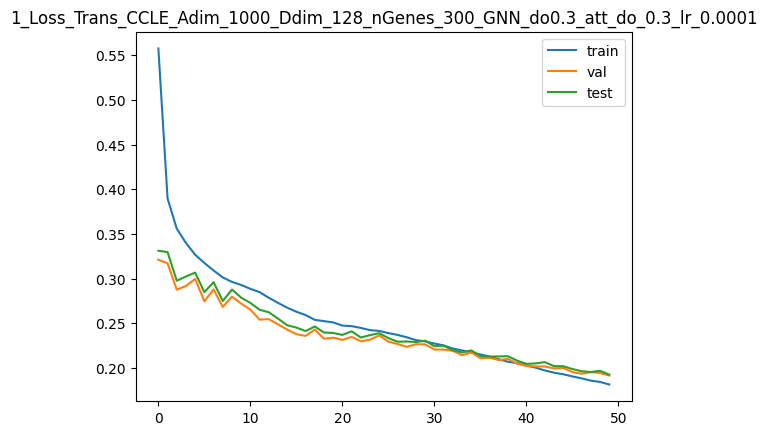

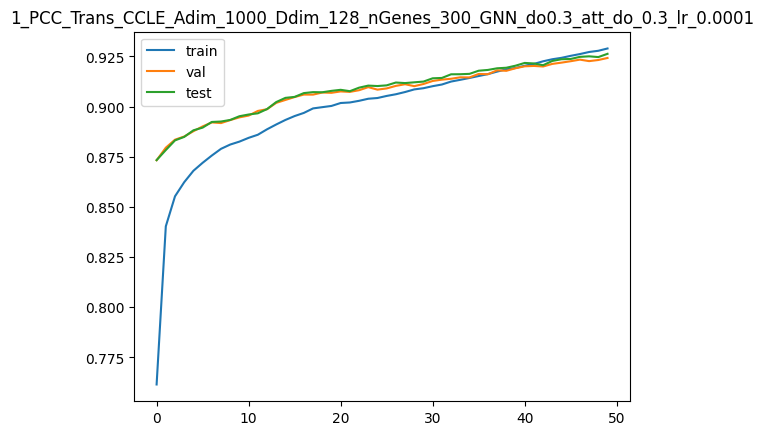

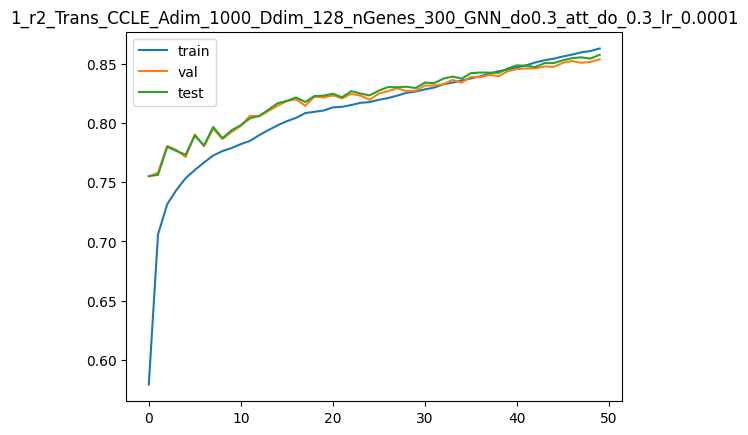

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18079893
Train avg_pcc:  0.9292444191736258
Train r2:  0.863487736894983


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18969709
Validation avg_pcc:  0.9254594125340254
Validation r2:  0.8552032742854143
Best Val r2  0.8552032742854143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19208194
Test avg_pcc:  0.9268577625239013
Test r2:  0.8579300942521131
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17865628
Train avg_pcc:  0.9301118911598084
Train r2:  0.8651055365942553


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18934245
Validation avg_pcc:  0.9251808079485915
Validation r2:  0.8554739730442547
Best Val r2  0.8554739730442547


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18871649
Test avg_pcc:  0.9278143565713094
Test r2:  0.8604193038553335
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17697503
Train avg_pcc:  0.9307958095481239
Train r2:  0.8663749789924373


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18869735
Validation avg_pcc:  0.9258531449802577
Validation r2:  0.8559663938722286
Best Val r2  0.8559663938722286


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18804675
Test avg_pcc:  0.928394445205758
Test r2:  0.8609146635833334
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17506953
Train avg_pcc:  0.931567602056999
Train r2:  0.8678137199539021


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18869525
Validation avg_pcc:  0.9256261719749382
Validation r2:  0.8559679878862897
Best Val r2  0.8559679878862897


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18917859
Test avg_pcc:  0.9279273088834802
Test r2:  0.8600775172962809
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17340392
Train avg_pcc:  0.9322430534005969
Train r2:  0.8690713519121772


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1899227
Validation avg_pcc:  0.9262633757680445
Validation r2:  0.8550310583998717


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1893738
Test avg_pcc:  0.9287123244921698
Test r2:  0.8599331315029148
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17161214
Train avg_pcc:  0.9329681101251144
Train r2:  0.8704242249622625


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19112848
Validation avg_pcc:  0.9262061369692817
Validation r2:  0.854110698436001


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19212785
Test avg_pcc:  0.9280734174359251
Test r2:  0.8578961565485989
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16985513
Train avg_pcc:  0.9336777744273081
Train r2:  0.871750867276879


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18445328
Validation avg_pcc:  0.9270893004749002
Validation r2:  0.8592059126290279
Best Val r2  0.8592059126290279


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18275003
Test avg_pcc:  0.9301723618636993
Test r2:  0.8648322800840025
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16923746
Train avg_pcc:  0.9339279307894948
Train r2:  0.8722172246651053


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18456788
Validation avg_pcc:  0.9271593745653196
Validation r2:  0.8591184335824881


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18314636
Test avg_pcc:  0.9299896468654714
Test r2:  0.8645391396948163
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16642113
Train avg_pcc:  0.9350660795323036
Train r2:  0.8743437127139831


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18261026
Validation avg_pcc:  0.9286852759745844
Validation r2:  0.8606126979746126
Best Val r2  0.8606126979746126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1827486
Test avg_pcc:  0.9308750216384317
Test r2:  0.8648333520241885
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16486023
Train avg_pcc:  0.9356959200564372
Train r2:  0.8755222532215403


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18074597
Validation avg_pcc:  0.9286025713632758
Validation r2:  0.8620357033424422
Best Val r2  0.8620357033424422


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17994411
Test avg_pcc:  0.9311786499436102
Test r2:  0.8669076302650189
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16280739
Train avg_pcc:  0.9365228453115286
Train r2:  0.8770722541958068


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.182202
Validation avg_pcc:  0.9279907581668768
Validation r2:  0.8609243145591504


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18072481
Test avg_pcc:  0.9308917719957948
Test r2:  0.8663301990239864
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16203596
Train avg_pcc:  0.9368345892638319
Train r2:  0.877654715449298


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18125996
Validation avg_pcc:  0.928771205546104
Validation r2:  0.8616433819657368


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18113714
Test avg_pcc:  0.9311271232451824
Test r2:  0.8660252230895528
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16033238
Train avg_pcc:  0.9375208389055414
Train r2:  0.8789409938433101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18184932
Validation avg_pcc:  0.9285434834632321
Validation r2:  0.8611935279212892


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18174766
Test avg_pcc:  0.9307169636537723
Test r2:  0.8655736618134036
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15856364
Train avg_pcc:  0.9382328678979603
Train r2:  0.8802764997264921


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17990266
Validation avg_pcc:  0.9288844376050096
Validation r2:  0.8626794238548123
Best Val r2  0.8626794238548123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1797455
Test avg_pcc:  0.9312530460564956
Test r2:  0.8670545393088843
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15751436
Train avg_pcc:  0.9386537900067539
Train r2:  0.881068753399132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18039736
Validation avg_pcc:  0.9289320338926252
Validation r2:  0.8623018017008552


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17959687
Test avg_pcc:  0.9314890812210842
Test r2:  0.8671644574245447
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15571178
Train avg_pcc:  0.9393791068657622
Train r2:  0.8824297976513958


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17782351
Validation avg_pcc:  0.9304764063491283
Validation r2:  0.8642664444942866
Best Val r2  0.8642664444942866


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17830384
Test avg_pcc:  0.9325340597213718
Test r2:  0.8681208213360313
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15455143
Train avg_pcc:  0.9398456185086568
Train r2:  0.8833059045468679


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17711103
Validation avg_pcc:  0.9304136250408315
Validation r2:  0.864810279757305
Best Val r2  0.864810279757305


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17721415
Test avg_pcc:  0.932630488001428
Test r2:  0.8689268030649324
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15410174
Train avg_pcc:  0.9400264004940646
Train r2:  0.8836454347768337


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17449385
Validation avg_pcc:  0.9312549649927657
Validation r2:  0.8668079804222404
Best Val r2  0.8668079804222404


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1750534
Test avg_pcc:  0.9333029405436144
Test r2:  0.870524958982363
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15167898
Train avg_pcc:  0.9409990426575162
Train r2:  0.8854747582795002


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17829719
Validation avg_pcc:  0.9309079563743536
Validation r2:  0.8639048736590975


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17697582
Test avg_pcc:  0.933446662455763
Test r2:  0.8691030727892386
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15074238
Train avg_pcc:  0.9413740338874527
Train r2:  0.8861819495734133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17700626
Validation avg_pcc:  0.9310904672684175
Validation r2:  0.864890243519262


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17584191
Test avg_pcc:  0.9336476829701884
Test r2:  0.8699417421979524
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14946388
Train avg_pcc:  0.9418868720480702
Train r2:  0.8871472565026661


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1745954
Validation avg_pcc:  0.9312452397017664
Validation r2:  0.8667304713175943


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17284843
Test avg_pcc:  0.9340878473817688
Test r2:  0.87215581201489
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14727645
Train avg_pcc:  0.9427628234006861
Train r2:  0.8887989001704529


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17766029
Validation avg_pcc:  0.9314545039026435
Validation r2:  0.8643910323436064


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17620459
Test avg_pcc:  0.9340276751877006
Test r2:  0.8696734891423544
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1462792
Train avg_pcc:  0.9431629204722223
Train r2:  0.8895518611670625


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17328368
Validation avg_pcc:  0.9318069667529041
Validation r2:  0.8677317070557375
Best Val r2  0.8677317070557375


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17219034
Test avg_pcc:  0.9343176520188761
Test r2:  0.8726425632992161
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14526571
Train avg_pcc:  0.9435678368793445
Train r2:  0.8903170950375088


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17249843
Validation avg_pcc:  0.9319210103156561
Validation r2:  0.8683310908464666
Best Val r2  0.8683310908464666


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17268793
Test avg_pcc:  0.9340535324705678
Test r2:  0.8722745275736793
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14453307
Train avg_pcc:  0.9438613814617552
Train r2:  0.8908702815747171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17518184
Validation avg_pcc:  0.9313511266442244
Validation r2:  0.8662828443006632


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1727062
Test avg_pcc:  0.9344118619827281
Test r2:  0.8722610243607289
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14207682
Train avg_pcc:  0.9448426104822222
Train r2:  0.892724881328082


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17163692
Validation avg_pcc:  0.9323390250736349
Validation r2:  0.868988690694085
Best Val r2  0.868988690694085


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16989166
Test avg_pcc:  0.935234602237788
Test r2:  0.8743427452180305
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14237714
Train avg_pcc:  0.9447229445808234
Train r2:  0.8924981209789108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1711609
Validation avg_pcc:  0.9324598946909982
Validation r2:  0.8693520332933778
Best Val r2  0.8693520332933778


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16999081
Test avg_pcc:  0.9351526147803578
Test r2:  0.8742694167883539
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1400504
Train avg_pcc:  0.9456520274365994
Train r2:  0.8942549186845311


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16954412
Validation avg_pcc:  0.9330903844741237
Validation r2:  0.8705861373632696
Best Val r2  0.8705861373632696


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16784304
Test avg_pcc:  0.9358801874075847
Test r2:  0.8758579701566017
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13959564
Train avg_pcc:  0.9458341456947384
Train r2:  0.8945982908792087


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17205638
Validation avg_pcc:  0.9329058038014191
Validation r2:  0.8686685192553889


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17209259
Test avg_pcc:  0.9350561873340467
Test r2:  0.8727148618263381
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13855788
Train avg_pcc:  0.9462477341141761
Train r2:  0.895381839141492


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17128402
Validation avg_pcc:  0.9335646756913312
Validation r2:  0.8692580603902867


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1702893
Test avg_pcc:  0.9360945895958266
Test r2:  0.8740486457395
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13800617
Train avg_pcc:  0.9464678089655307
Train r2:  0.8957984130033088


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1711739
Validation avg_pcc:  0.9331747557973579
Validation r2:  0.8693421138909667


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16992193
Test avg_pcc:  0.9357642604747667
Test r2:  0.874320346766004
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13662094
Train avg_pcc:  0.9470198986500359
Train r2:  0.896844325218435


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17101987
Validation avg_pcc:  0.932658361887601
Validation r2:  0.869459686033109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16893585
Test avg_pcc:  0.9356755635782918
Test r2:  0.8750496777105448
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13505852
Train avg_pcc:  0.9476434637187047
Train r2:  0.8980240386261967


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1678491
Validation avg_pcc:  0.9339006998145075
Validation r2:  0.8718799680549567
Best Val r2  0.8718799680549567


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16573009
Test avg_pcc:  0.9369203358175655
Test r2:  0.8774207785299896
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13462703
Train avg_pcc:  0.9478151916816095
Train r2:  0.8983498415177307


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1686426
Validation avg_pcc:  0.9335376684011706
Validation r2:  0.8712742649298159


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16572136
Test avg_pcc:  0.9368308935347287
Test r2:  0.8774272398906682
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1336522
Train avg_pcc:  0.9482028079150744
Train r2:  0.8990858740736163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16836338
Validation avg_pcc:  0.9336751542075241
Validation r2:  0.8714874076590978


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16685642
Test avg_pcc:  0.9363683831278238
Test r2:  0.8765876978777856
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13286664
Train avg_pcc:  0.9485154601764182
Train r2:  0.8996790195842421


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1661363
Validation avg_pcc:  0.9344560305884637
Validation r2:  0.8731873483802146
Best Val r2  0.8731873483802146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1642283
Test avg_pcc:  0.937306183038604
Test r2:  0.8785315386852979
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13180432
Train avg_pcc:  0.9489382612685369
Train r2:  0.9004811217293137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16790147
Validation avg_pcc:  0.9338071568157784
Validation r2:  0.87183998535228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16722699
Test avg_pcc:  0.9362619463962857
Test r2:  0.8763136174428915
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13085985
Train avg_pcc:  0.9493138879038238
Train r2:  0.901194242793712


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16555303
Validation avg_pcc:  0.9351708987965978
Validation r2:  0.8736325530052123
Best Val r2  0.8736325530052123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16397995
Test avg_pcc:  0.9377465317234212
Test r2:  0.8787152398454694
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12968598
Train avg_pcc:  0.9497818281586847
Train r2:  0.9020805774013004


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16668491
Validation avg_pcc:  0.9342960275459732
Validation r2:  0.8727685893469777


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16512553
Test avg_pcc:  0.9369858789847908
Test r2:  0.8778679297214568
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12910405
Train avg_pcc:  0.9500123779997399
Train r2:  0.9025199601460128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16758436
Validation avg_pcc:  0.9345547105544737
Validation r2:  0.872082034864665


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16494189
Test avg_pcc:  0.9375747672513555
Test r2:  0.8780037504931213
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12797889
Train avg_pcc:  0.950458410204286
Train r2:  0.9033695170704897


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16823454
Validation avg_pcc:  0.9345674318727661
Validation r2:  0.8715857430738462


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16679281
Test avg_pcc:  0.9372132502541091
Test r2:  0.8766347498194806
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12703845
Train avg_pcc:  0.9508324623925776
Train r2:  0.9040795890441871


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1668399
Validation avg_pcc:  0.9342071399456628
Validation r2:  0.8726502864765064


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1645423
Test avg_pcc:  0.9372633424709746
Test r2:  0.8782993073857115
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12700056
Train avg_pcc:  0.950848302944008
Train r2:  0.9041082095107984


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16808943
Validation avg_pcc:  0.9349674221478946
Validation r2:  0.8716965060057101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16700533
Test avg_pcc:  0.937219865139211
Test r2:  0.8764775717165604
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12553042
Train avg_pcc:  0.9514306832016534
Train r2:  0.9052182409955528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1665434
Validation avg_pcc:  0.9343362587826578
Validation r2:  0.8728766100758628


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16480997
Test avg_pcc:  0.9371197242502352
Test r2:  0.878101324424216
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.124254234
Train avg_pcc:  0.9519378179820178
Train r2:  0.9061818207549059


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16478041
Validation avg_pcc:  0.935619452166732
Validation r2:  0.8742223034039511
Best Val r2  0.8742223034039511


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16308695
Test avg_pcc:  0.9383566161943828
Test r2:  0.8793757236496591
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12489858
Train avg_pcc:  0.9516819953653384
Train r2:  0.9056952965705362


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16363536
Validation avg_pcc:  0.9360581284756142
Validation r2:  0.8750963260148461
Best Val r2  0.8750963260148461


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16232893
Test avg_pcc:  0.9385363116238118
Test r2:  0.8799363717291576
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12306051
Train avg_pcc:  0.9524109540799038
Train r2:  0.9070831299618783


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16380742
Validation avg_pcc:  0.9359252984016186
Validation r2:  0.874964989458656


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16409941
Test avg_pcc:  0.9377289029592463
Test r2:  0.8786268798619877
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12255726
Train avg_pcc:  0.9526100217446499
Train r2:  0.9074631258951066


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16430357
Validation avg_pcc:  0.9359907259717003
Validation r2:  0.8745862754649263


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16255327
Test avg_pcc:  0.9386206301829957
Test r2:  0.8797704538316357
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.121787034
Train avg_pcc:  0.9529151742460232
Train r2:  0.9080446753666597


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16187184
Validation avg_pcc:  0.9364229355865844
Validation r2:  0.8764424243543942
Best Val r2  0.8764424243543942


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16072474
Test avg_pcc:  0.9388583494851803
Test r2:  0.8811228816010602
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12039371
Train avg_pcc:  0.9534675831619838
Train r2:  0.909096710549721


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16425042
Validation avg_pcc:  0.9361556807356574
Validation r2:  0.8746268498541796


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16292349
Test avg_pcc:  0.9386259279205384
Test r2:  0.8794966250115897


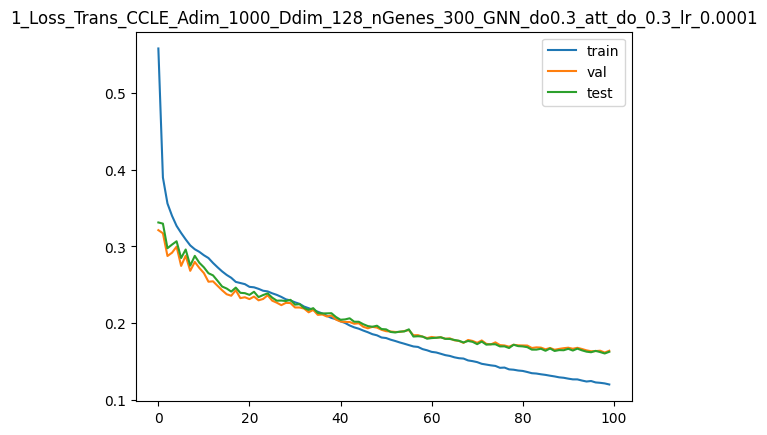

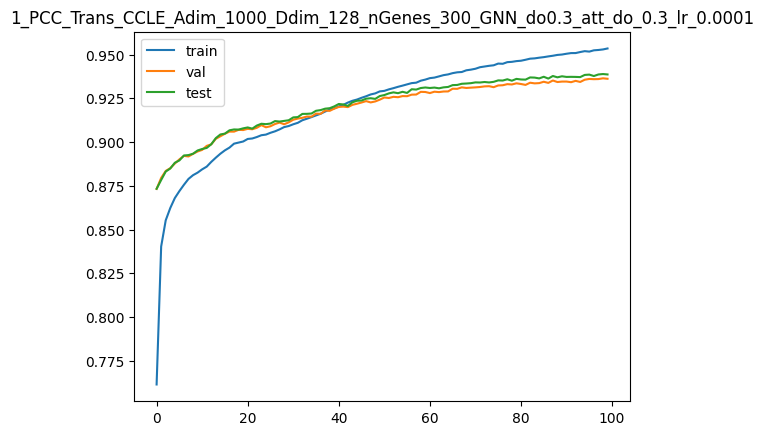

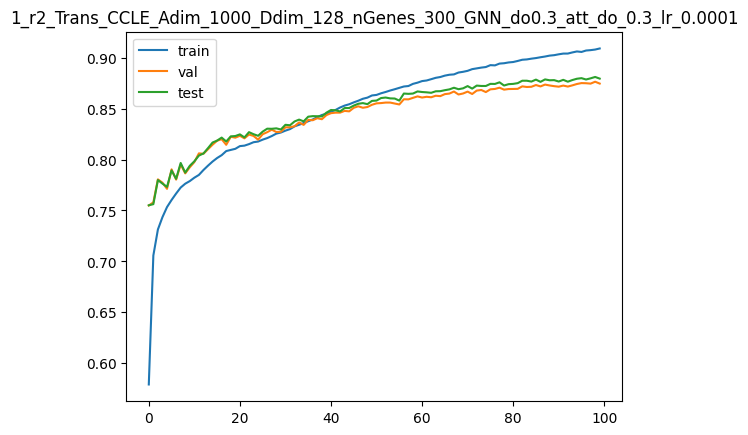

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12015016
Train avg_pcc:  0.9535633392807678
Train r2:  0.9092806001432234


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16313918
Validation avg_pcc:  0.9362278313266691
Validation r2:  0.8754750658275849


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.163011
Test avg_pcc:  0.9382102182884067
Test r2:  0.8794319010415881
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.120154336
Train avg_pcc:  0.9535620008665364
Train r2:  0.9092774454718772


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16179883
Validation avg_pcc:  0.936284360473424
Validation r2:  0.8764981469710661
Best Val r2  0.8764981469710661


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16303664
Test avg_pcc:  0.9377873314794072
Test r2:  0.8794129330923023
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11911806
Train avg_pcc:  0.9539724898333983
Train r2:  0.9100598890224951


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1622601
Validation avg_pcc:  0.9363703317947342
Validation r2:  0.8761460723597829


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16303125
Test avg_pcc:  0.9380409829375208
Test r2:  0.8794169233504535
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11869718
Train avg_pcc:  0.9541389486448987
Train r2:  0.9103776776024531


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16205172
Validation avg_pcc:  0.9366009374876718
Validation r2:  0.8763051161991494


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16086303
Test avg_pcc:  0.938989575727404
Test r2:  0.8810205995205082
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11716115
Train avg_pcc:  0.9547463404864523
Train r2:  0.9115374589240041


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16254643
Validation avg_pcc:  0.9366797457946001
Validation r2:  0.8759275145935587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16067682
Test avg_pcc:  0.9393186794460726
Test r2:  0.8811583268937486
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11659823
Train avg_pcc:  0.954968509265845
Train r2:  0.911962478135233


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16225697
Validation avg_pcc:  0.9364418904623947
Validation r2:  0.8761484503037418


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16116461
Test avg_pcc:  0.9388856521588461
Test r2:  0.8807975466112083
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11669744
Train avg_pcc:  0.9549292546396004
Train r2:  0.9118875780676298


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16178255
Validation avg_pcc:  0.9365460081490694
Validation r2:  0.8765105776342074
Best Val r2  0.8765105776342074


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16036348
Test avg_pcc:  0.9391210878500021
Test r2:  0.8813900781034044
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11556692
Train avg_pcc:  0.9553774247322435
Train r2:  0.9127411694352846


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16432501
Validation avg_pcc:  0.9355969203730206
Validation r2:  0.8745699052825094


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16135393
Test avg_pcc:  0.9387240111498998
Test r2:  0.8806575180679334
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.113768004
Train avg_pcc:  0.9560868754951695
Train r2:  0.9140994541059183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16059019
Validation avg_pcc:  0.9373830757200219
Validation r2:  0.8774207228194455
Best Val r2  0.8774207228194455


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15897821
Test avg_pcc:  0.9398839239962459
Test r2:  0.8824146876731921
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11422567
Train avg_pcc:  0.9559059127596341
Train r2:  0.9137538820865997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15899135
Validation avg_pcc:  0.9373756708527212
Validation r2:  0.8786411226176517
Best Val r2  0.8786411226176517


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1583517
Test avg_pcc:  0.9396667603048524
Test r2:  0.8828780577848329
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11321924
Train avg_pcc:  0.9563037273161746
Train r2:  0.9145137897877287


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16075191
Validation avg_pcc:  0.9366828607249921
Validation r2:  0.8772972712077632


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.159664
Test avg_pcc:  0.9391297861877606
Test r2:  0.8819074462080055
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1130762
Train avg_pcc:  0.9563605014914555
Train r2:  0.9146217959071841


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15930219
Validation avg_pcc:  0.9374355765398457
Validation r2:  0.8784038543681825


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15846336
Test avg_pcc:  0.939716668726452
Test r2:  0.8827954777093424
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.111320876
Train avg_pcc:  0.9570524671163243
Train r2:  0.9159471534232133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16140062
Validation avg_pcc:  0.9370811027527426
Validation r2:  0.8768021194511952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16098657
Test avg_pcc:  0.9391663037686517
Test r2:  0.8809292347990617
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11229765
Train avg_pcc:  0.9566676857168699
Train r2:  0.9152096400801034


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16109246
Validation avg_pcc:  0.9369347337870745
Validation r2:  0.877037325765866


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15961176
Test avg_pcc:  0.9394515384130935
Test r2:  0.8819460804230338
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.110523626
Train avg_pcc:  0.9573671783196706
Train r2:  0.9165491127965874


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16096786
Validation avg_pcc:  0.9371594115392651
Validation r2:  0.8771324373675085


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16019243
Test avg_pcc:  0.9393680846815505
Test r2:  0.881516599241423
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11068869
Train avg_pcc:  0.957301968070468
Train r2:  0.9164244840595095


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16095184
Validation avg_pcc:  0.9375579044844609
Validation r2:  0.8771446662858906


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16157894
Test avg_pcc:  0.9392472561193188
Test r2:  0.8804910927229066
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.110152565
Train avg_pcc:  0.9575140282071091
Train r2:  0.916829298818737


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15954608
Validation avg_pcc:  0.9373416625438895
Validation r2:  0.8782176985782592


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15900807
Test avg_pcc:  0.9395453145254744
Test r2:  0.8823925889656551
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10875988
Train avg_pcc:  0.9580622659222141
Train r2:  0.9178808281197139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15994729
Validation avg_pcc:  0.9371688974203567
Validation r2:  0.8779114551099282


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15817496
Test avg_pcc:  0.9398920978124735
Test r2:  0.8830087833169027
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10884887
Train avg_pcc:  0.9580270083630285
Train r2:  0.9178136372328041


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15917249
Validation avg_pcc:  0.9375992306190962
Validation r2:  0.8785028521494099


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15853839
Test avg_pcc:  0.9398068298740847
Test r2:  0.8827399852037302
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10796515
Train avg_pcc:  0.9583753004748063
Train r2:  0.9184808972568902


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15984747
Validation avg_pcc:  0.9382307190455076
Validation r2:  0.877987650256709


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16001476
Test avg_pcc:  0.9400238112278876
Test r2:  0.8816480239250393
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.107475065
Train avg_pcc:  0.9585683136336618
Train r2:  0.9188509301319931


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16190536
Validation avg_pcc:  0.9373679549230282
Validation r2:  0.8764168309374155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16068996
Test avg_pcc:  0.939847842556994
Test r2:  0.8811486061633946
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10635686
Train avg_pcc:  0.9590090563761701
Train r2:  0.9196952429781114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16012034
Validation avg_pcc:  0.9374789318830943
Validation r2:  0.8777793609080201


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15787326
Test avg_pcc:  0.940276842634309
Test r2:  0.8832319225825173
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10622011
Train avg_pcc:  0.9590627250447031
Train r2:  0.9197984821599758


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15839587
Validation avg_pcc:  0.9376695424043151
Validation r2:  0.8790956474921608
Best Val r2  0.8790956474921608


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15720683
Test avg_pcc:  0.9400885160112576
Test r2:  0.8837248417851586
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.105927296
Train avg_pcc:  0.9591778012012163
Train r2:  0.9200195705663448


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16173905
Validation avg_pcc:  0.9372475257235379
Validation r2:  0.8765437781747577


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15892501
Test avg_pcc:  0.9401264182390422
Test r2:  0.8824540181218172
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10618324
Train avg_pcc:  0.959076689452316
Train r2:  0.9198263285700504


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15820527
Validation avg_pcc:  0.9380426923883425
Validation r2:  0.8792411387862674
Best Val r2  0.8792411387862674


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15824653
Test avg_pcc:  0.9400837615379836
Test r2:  0.8829558469986932
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10465686
Train avg_pcc:  0.9596784097315217
Train r2:  0.9209788142948926


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15800466
Validation avg_pcc:  0.9383702227881007
Validation r2:  0.8793942676966451
Best Val r2  0.8793942676966451


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15740862
Test avg_pcc:  0.9405190499591054
Test r2:  0.8835755923726362
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10459651
Train avg_pcc:  0.9597015073049276
Train r2:  0.9210243865332176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1559371
Validation avg_pcc:  0.9389963608933327
Validation r2:  0.8809724377163625
Best Val r2  0.8809724377163625


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15645479
Test avg_pcc:  0.9407376132314654
Test r2:  0.8842810758251405
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10390901
Train avg_pcc:  0.9599723279948312
Train r2:  0.9215434792034526


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15712419
Validation avg_pcc:  0.9384557918164491
Validation r2:  0.8800663227952599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15581787
Test avg_pcc:  0.9408376707651157
Test r2:  0.8847521631967178
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.103629984
Train avg_pcc:  0.9600815788050506
Train r2:  0.9217541597701211


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15962277
Validation avg_pcc:  0.9379347127952498
Validation r2:  0.8781591524561888


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15650849
Test avg_pcc:  0.9409835855643168
Test r2:  0.8842413671367972
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10283895
Train avg_pcc:  0.96039265992553
Train r2:  0.922351433555847


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15833344
Validation avg_pcc:  0.9380986280562509
Validation r2:  0.8791433067855389


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15697184
Test avg_pcc:  0.9404957220715332
Test r2:  0.8838986507456409
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10225836
Train avg_pcc:  0.9606205693431756
Train r2:  0.9227898005655204


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15571527
Validation avg_pcc:  0.9387867603374067
Validation r2:  0.8811417709875397
Best Val r2  0.8811417709875397


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15486933
Test avg_pcc:  0.9410920022242375
Test r2:  0.8854537346592777
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10222848
Train avg_pcc:  0.960633394096056
Train r2:  0.9228123583426587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15743792
Validation avg_pcc:  0.938127222441763
Validation r2:  0.879826856226267


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15545103
Test avg_pcc:  0.9408525610749275
Test r2:  0.8850234837974593
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10061491
Train avg_pcc:  0.9612659904596286
Train r2:  0.9240306853559918


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16287635
Validation avg_pcc:  0.9382141721865539
Validation r2:  0.87567567499007


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16133861
Test avg_pcc:  0.9406795978170126
Test r2:  0.880668853582962
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10070403
Train avg_pcc:  0.9612316061218694
Train r2:  0.9239634030564133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15959631
Validation avg_pcc:  0.9381282232563716
Validation r2:  0.878179342292971


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15840301
Test avg_pcc:  0.9404548478668625
Test r2:  0.8828401199503685
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10052927
Train avg_pcc:  0.9613003876973809
Train r2:  0.924095350913539


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15770449
Validation avg_pcc:  0.9384523664080104
Validation r2:  0.8796233873849362


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15610744
Test avg_pcc:  0.940890871812507
Test r2:  0.8845379872581727
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.100520894
Train avg_pcc:  0.9613031324410377
Train r2:  0.9241016872491644


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15975116
Validation avg_pcc:  0.9384520447180114
Validation r2:  0.8780611450660668


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15855888
Test avg_pcc:  0.940851369928301
Test r2:  0.8827248286393053
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.099112354
Train avg_pcc:  0.9618569162296082
Train r2:  0.9251651899994764


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15698107
Validation avg_pcc:  0.9386044054906226
Validation r2:  0.8801755817459289


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15549377
Test avg_pcc:  0.9410415326464093
Test r2:  0.8849918858287235
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.099264294
Train avg_pcc:  0.9617967505645157
Train r2:  0.9250504863478115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15548217
Validation avg_pcc:  0.938935073960477
Validation r2:  0.881319690119293
Best Val r2  0.881319690119293


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1558554
Test avg_pcc:  0.9406798195590436
Test r2:  0.884724395383202
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0988045
Train avg_pcc:  0.9619774557816458
Train r2:  0.9253976383498375


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1565033
Validation avg_pcc:  0.9388220179737936
Validation r2:  0.8805402496585955


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15737018
Test avg_pcc:  0.9402975543955092
Test r2:  0.8836040261704442
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09802999
Train avg_pcc:  0.9622809155642728
Train r2:  0.9259824399724141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15769897
Validation avg_pcc:  0.938541521493577
Validation r2:  0.8796276022396748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15494196
Test avg_pcc:  0.941462933365336
Test r2:  0.8854000097316054
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.098502
Train avg_pcc:  0.9620961008143567
Train r2:  0.9256260354463921


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15671809
Validation avg_pcc:  0.938400003478372
Validation r2:  0.8803763071294601


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15720409
Test avg_pcc:  0.9401104950692891
Test r2:  0.8837268642935899
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09811065
Train avg_pcc:  0.9622493323195448
Train r2:  0.9259215312765785


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.157183
Validation avg_pcc:  0.9385190147802641
Validation r2:  0.8800214311750482


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1567225
Test avg_pcc:  0.9406042098309743
Test r2:  0.8840830722237464
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0969571
Train avg_pcc:  0.9627022377380682
Train r2:  0.9267925171621707


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15594968
Validation avg_pcc:  0.9392499526589627
Validation r2:  0.8809628467414887


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15622169
Test avg_pcc:  0.9409437707998879
Test r2:  0.884453478379899
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0963409
Train avg_pcc:  0.962943477881306
Train r2:  0.9272577869331498


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15554598
Validation avg_pcc:  0.9390704060875263
Validation r2:  0.8812709932842628


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15527724
Test avg_pcc:  0.9410320309422529
Test r2:  0.8851520304673098
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09693367
Train avg_pcc:  0.9627110406716548
Train r2:  0.9268102222657468


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15489931
Validation avg_pcc:  0.9393546353305535
Validation r2:  0.8817645890812433
Best Val r2  0.8817645890812433


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15393598
Test avg_pcc:  0.9415277446977188
Test r2:  0.8861440669270554
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09582077
Train avg_pcc:  0.9631471859145286
Train r2:  0.9276505152884538


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1555101
Validation avg_pcc:  0.9392177585668138
Validation r2:  0.8812983710970954


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15602551
Test avg_pcc:  0.9408843088526813
Test r2:  0.8845985816899444
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09471712
Train avg_pcc:  0.9635797027016536
Train r2:  0.9284838190849904


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15651257
Validation avg_pcc:  0.9390100487427862
Validation r2:  0.8805331854869867


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15592158
Test avg_pcc:  0.9411336599722042
Test r2:  0.8846754525919074
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.094638795
Train avg_pcc:  0.9636108127169125
Train r2:  0.9285429600473937


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15612526
Validation avg_pcc:  0.9388583230594859
Validation r2:  0.8808288119661165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15464713
Test avg_pcc:  0.9413000621741149
Test r2:  0.8856180756423787
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09501844
Train avg_pcc:  0.9634618481652073
Train r2:  0.9282563245082318


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15846854
Validation avg_pcc:  0.9390224109635684
Validation r2:  0.8790401801781679


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15664932
Test avg_pcc:  0.941412968885592
Test r2:  0.8841371918951123
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09388095
Train avg_pcc:  0.9639069572414445
Train r2:  0.9291151738321127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15722954
Validation avg_pcc:  0.9385084726574983
Validation r2:  0.8799859193579322


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15599355
Test avg_pcc:  0.9410574613016144
Test r2:  0.8846222371751089


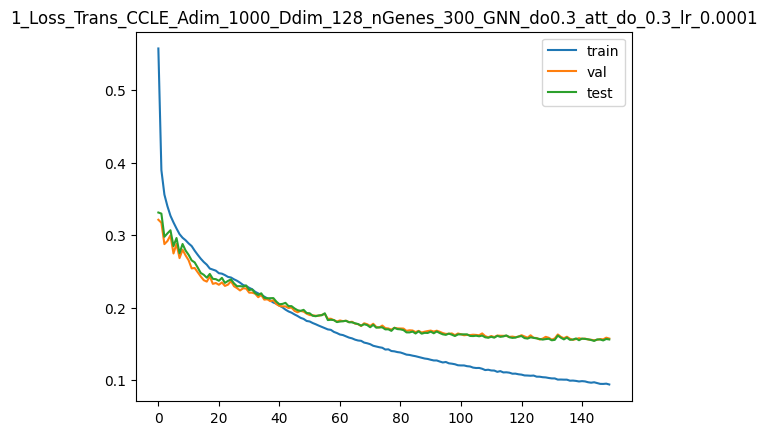

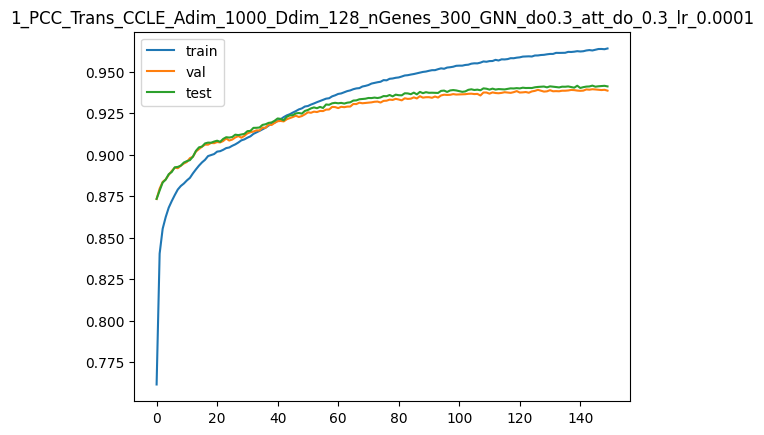

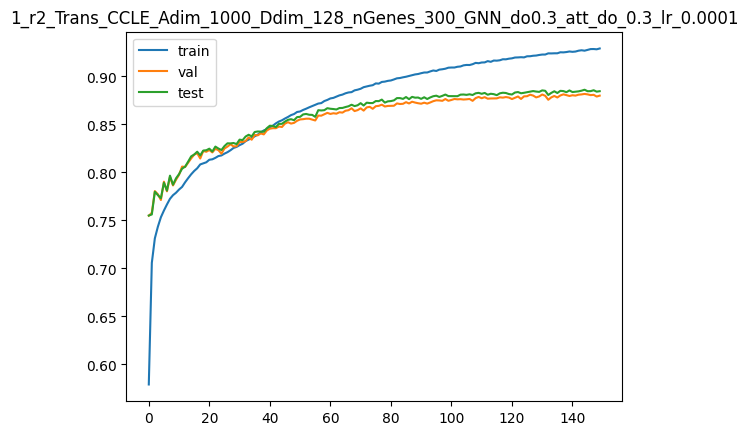

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15393598
Test avg_pcc:  0.9415277449736408
Test r2:  0.8861440694340614


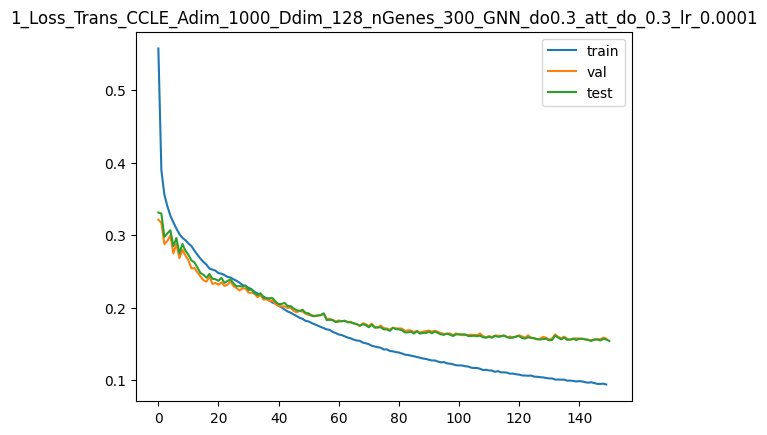

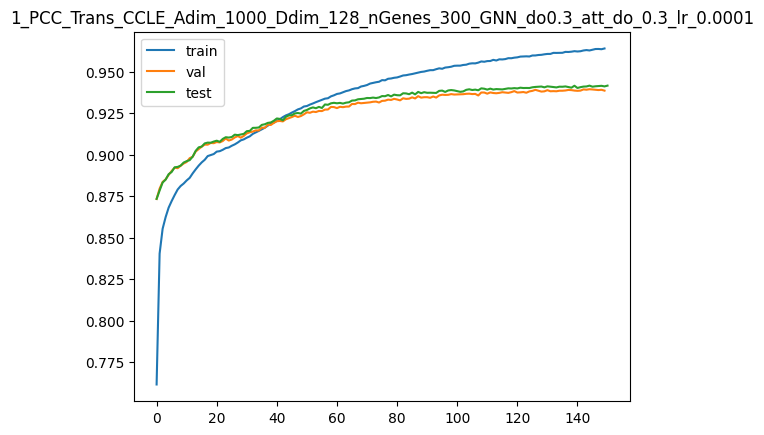

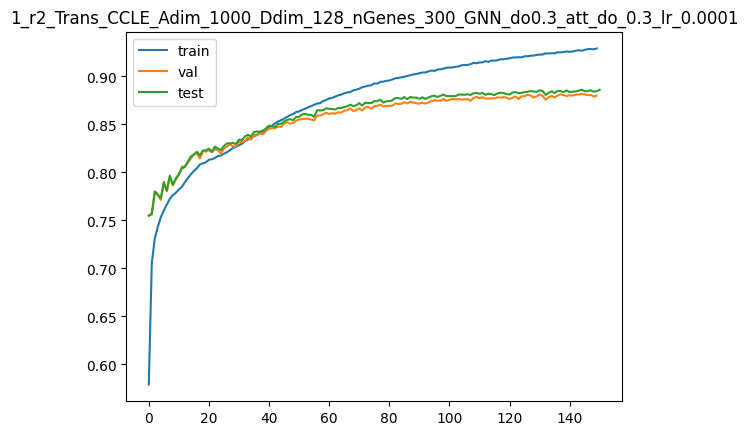

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.55039495
Train avg_pcc:  0.7650865170289287
Train r2:  0.5846606683583739


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.33072713
Validation avg_pcc:  0.8728164561778448
Validation r2:  0.7504442566590136
Best Val r2  0.7504442566590136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3339888
Test avg_pcc:  0.87240126692196
Test r2:  0.7490621936386914
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.38713175
Train avg_pcc:  0.8415304371038668
Train r2:  0.707862393890909


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32017168
Validation avg_pcc:  0.8825181224369748
Validation r2:  0.758409041628695
Best Val r2  0.758409041628695


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3249479
Test avg_pcc:  0.8810272494992899
Test r2:  0.7558549452224135
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.35574695
Train avg_pcc:  0.8554303725980819
Train r2:  0.7315460114228793


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29005766
Validation avg_pcc:  0.8852747152292129
Validation r2:  0.7811321119119502
Best Val r2  0.7811321119119502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29575163
Test avg_pcc:  0.8832807875153922
Test r2:  0.7777911688403273
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.33472753
Train avg_pcc:  0.8645907938411722
Train r2:  0.7474076933687721


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27907377
Validation avg_pcc:  0.8885312102380156
Validation r2:  0.7894201825983418
Best Val r2  0.7894201825983418


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28154737
Test avg_pcc:  0.8879950003367076
Test r2:  0.7884633395212669
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3233508
Train avg_pcc:  0.8695218737101459
Train r2:  0.7559928367372131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2806724
Validation avg_pcc:  0.8893468336882365
Validation r2:  0.7882138786406571


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28388005
Test avg_pcc:  0.8884131067613168
Test r2:  0.7867107083329231
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.31422183
Train avg_pcc:  0.8734609293437615
Train r2:  0.7628817439049218


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28229403
Validation avg_pcc:  0.891705612051584
Validation r2:  0.7869902445394398


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2849599
Test avg_pcc:  0.8909504658915148
Test r2:  0.7858993719961183
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.30783087
Train avg_pcc:  0.8762108738870177
Train r2:  0.7677044823348878


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28298226
Validation avg_pcc:  0.8896879436913916
Validation r2:  0.7864709468804307


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2845408
Test avg_pcc:  0.8896119987928559
Test r2:  0.7862142562822954
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.30066672
Train avg_pcc:  0.8792820999537881
Train r2:  0.7731106820013776


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27143386
Validation avg_pcc:  0.891763213061264
Validation r2:  0.7951850059471928
Best Val r2  0.7951850059471928


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27555043
Test avg_pcc:  0.890531614668391
Test r2:  0.79296904852404
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2962474
Train avg_pcc:  0.8811718347381036
Train r2:  0.7764456255119311


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27436504
Validation avg_pcc:  0.8914949798686077
Validation r2:  0.7929732483569355


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27422762
Test avg_pcc:  0.8920185100135848
Test r2:  0.7939629372889423
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29243246
Train avg_pcc:  0.8828027287885262
Train r2:  0.7793244471712979


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2634226
Validation avg_pcc:  0.8958716883929321
Validation r2:  0.8012300148296065
Best Val r2  0.8012300148296065


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26887158
Test avg_pcc:  0.8940179206322115
Test r2:  0.7979871152279654
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.28542706
Train avg_pcc:  0.8857898778504582
Train r2:  0.7846108353384253


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26077417
Validation avg_pcc:  0.896457428347431
Validation r2:  0.8032284500636769
Best Val r2  0.8032284500636769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2651887
Test avg_pcc:  0.8950469605065708
Test r2:  0.8007541645687195
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.28021964
Train avg_pcc:  0.8880054950579397
Train r2:  0.7885404469089337


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25664434
Validation avg_pcc:  0.8986328689796355
Validation r2:  0.8063446777875722
Best Val r2  0.8063446777875722


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2615592
Test avg_pcc:  0.8969909445299239
Test r2:  0.8034811845322712
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.27391857
Train avg_pcc:  0.8906764306208332
Train r2:  0.7932954013007966


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25418252
Validation avg_pcc:  0.9004577963090701
Validation r2:  0.8082022882044775
Best Val r2  0.8082022882044775


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2560578
Test avg_pcc:  0.8998758120327738
Test r2:  0.8076145390169956
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2699078
Train avg_pcc:  0.8923754258809607
Train r2:  0.7963220083484401


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24599938
Validation avg_pcc:  0.9029899094136163
Validation r2:  0.8143770124594005
Best Val r2  0.8143770124594005


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.251168
Test avg_pcc:  0.9012383319114128
Test r2:  0.8112884364887831
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26338118
Train avg_pcc:  0.8951315439970855
Train r2:  0.8012471294260877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24963406
Validation avg_pcc:  0.9027837600467725
Validation r2:  0.8116344045166224


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2536725
Test avg_pcc:  0.9017663509201718
Test r2:  0.8094066971084002
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26078972
Train avg_pcc:  0.8962209612317299
Train r2:  0.8032027016218182


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24109074
Validation avg_pcc:  0.9053701809550004
Validation r2:  0.8180809134528704
Best Val r2  0.8180809134528704


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24398385
Test avg_pcc:  0.9047685108792892
Test r2:  0.816686153832309
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25629783
Train avg_pcc:  0.8981099284178325
Train r2:  0.8065923901356371


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24112727
Validation avg_pcc:  0.9046856910814627
Validation r2:  0.8180533533280094


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24296907
Test avg_pcc:  0.9044420961502792
Test r2:  0.8174485979421083
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2540243
Train avg_pcc:  0.8990656462243953
Train r2:  0.8083080342373535


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23783539
Validation avg_pcc:  0.9062372713035458
Validation r2:  0.8205372818627924
Best Val r2  0.8205372818627924


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24126267
Test avg_pcc:  0.9052075633958839
Test r2:  0.8187306646397192
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25070387
Train avg_pcc:  0.9004560609063114
Train r2:  0.8108136836941207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24233
Validation avg_pcc:  0.9041824452051349
Validation r2:  0.8171458121845552


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24031588
Test avg_pcc:  0.9055160114643162
Test r2:  0.8194420333836281
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24906376
Train avg_pcc:  0.9011435968458434
Train r2:  0.8120513378919816


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23953873
Validation avg_pcc:  0.9053385057405483
Validation r2:  0.819252011694533


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23816761
Test avg_pcc:  0.9063068468754708
Test r2:  0.8210560977059679
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24676684
Train avg_pcc:  0.902105135215115
Train r2:  0.8137846712147017


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23566997
Validation avg_pcc:  0.9070023167778131
Validation r2:  0.8221712586057327
Best Val r2  0.8221712586057327


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23578443
Test avg_pcc:  0.9075014250246402
Test r2:  0.8228466793287492
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24459177
Train avg_pcc:  0.9030123831425831
Train r2:  0.8154260078301713


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2332772
Validation avg_pcc:  0.9083947658378762
Validation r2:  0.823976754260884
Best Val r2  0.823976754260884


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23625302
Test avg_pcc:  0.9076179636151677
Test r2:  0.8224945873561069
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24322541
Train avg_pcc:  0.9035848617705626
Train r2:  0.8164570832780098


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23529282
Validation avg_pcc:  0.9076822690005142
Validation r2:  0.822455821358377


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23761715
Test avg_pcc:  0.9072167340889934
Test r2:  0.821469679050093
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24148814
Train avg_pcc:  0.9043093194794857
Train r2:  0.8177680549534244


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22968756
Validation avg_pcc:  0.9093424618342729
Validation r2:  0.8266853590226763
Best Val r2  0.8266853590226763


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23379987
Test avg_pcc:  0.9080812759123694
Test r2:  0.8243377286959652
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23990369
Train avg_pcc:  0.9049690779490637
Train r2:  0.8189637359730542


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23673563
Validation avg_pcc:  0.908709964378776
Validation r2:  0.8213671306615827


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23879017
Test avg_pcc:  0.9081211038580994
Test r2:  0.8205883361144608
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23783346
Train avg_pcc:  0.905833110106216
Train r2:  0.8205260014524316


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2308005
Validation avg_pcc:  0.9088505197607104
Validation r2:  0.8258455851102805


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23199487
Test avg_pcc:  0.9088202397448987
Test r2:  0.8256938914773525
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23626064
Train avg_pcc:  0.9064872362893133
Train r2:  0.8217128490254972


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23164684
Validation avg_pcc:  0.9097781590485589
Validation r2:  0.8252069676847283


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23485318
Test avg_pcc:  0.9088312925530707
Test r2:  0.8235463535376776
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23354307
Train avg_pcc:  0.9076174290466075
Train r2:  0.8237635734822804


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22647779
Validation avg_pcc:  0.9105907646739699
Validation r2:  0.8291073741238224
Best Val r2  0.8291073741238224


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22958302
Test avg_pcc:  0.909734938730364
Test r2:  0.8275060074342666
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23145005
Train avg_pcc:  0.9084874586506324
Train r2:  0.8253430240579988


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22560403
Validation avg_pcc:  0.9109862800398187
Validation r2:  0.8297666655165543
Best Val r2  0.8297666655165543


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22921745
Test avg_pcc:  0.909926234260463
Test r2:  0.8277806856450887
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22903898
Train avg_pcc:  0.9094882517497285
Train r2:  0.8271624541681349


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2233274
Validation avg_pcc:  0.9119293189000495
Validation r2:  0.8314845277877639
Best Val r2  0.8314845277877639


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22840014
Test avg_pcc:  0.9102028608599536
Test r2:  0.8283947502933264
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22590396
Train avg_pcc:  0.9107864413850425
Train r2:  0.8295282103320475


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22205952
Validation avg_pcc:  0.9125276040239568
Validation r2:  0.8324412284832312
Best Val r2  0.8324412284832312


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22365241
Test avg_pcc:  0.9122611795573081
Test r2:  0.831961892976884
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22369519
Train avg_pcc:  0.9117040063341553
Train r2:  0.8311950193660942


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22170222
Validation avg_pcc:  0.9131327996097273
Validation r2:  0.832710859433502
Best Val r2  0.832710859433502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22417922
Test avg_pcc:  0.9125334869017309
Test r2:  0.8315660726044409
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22157958
Train avg_pcc:  0.9125757572039352
Train r2:  0.8327914728705685


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21916977
Validation avg_pcc:  0.9141118395733476
Validation r2:  0.8346217533936633
Best Val r2  0.8346217533936633


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22313961
Test avg_pcc:  0.9129478505135417
Test r2:  0.8323471798726345
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21948804
Train avg_pcc:  0.9134413109356282
Train r2:  0.8343697955300571


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21687128
Validation avg_pcc:  0.9147704858749972
Validation r2:  0.8363561093068675
Best Val r2  0.8363561093068675


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21972437
Test avg_pcc:  0.9140387957039972
Test r2:  0.834913172962529
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2159402
Train avg_pcc:  0.9149050878650575
Train r2:  0.8370470531162865


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2138989
Validation avg_pcc:  0.916361783821634
Validation r2:  0.8385989684838652
Best Val r2  0.8385989684838652


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2169139
Test avg_pcc:  0.915555513973678
Test r2:  0.8370247817528593
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21295361
Train avg_pcc:  0.916136678306557
Train r2:  0.8393008191098645


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21265702
Validation avg_pcc:  0.9166973649463114
Validation r2:  0.8395360480715954
Best Val r2  0.8395360480715954


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21523783
Test avg_pcc:  0.9160664468175628
Test r2:  0.838284070176251
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20969585
Train avg_pcc:  0.9174769367184328
Train r2:  0.8417592006848201


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2095729
Validation avg_pcc:  0.9175917277403105
Validation r2:  0.841863229114527
Best Val r2  0.841863229114527


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21013835
Test avg_pcc:  0.9177262232660008
Test r2:  0.8421154817857879
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20710321
Train avg_pcc:  0.918542494617077
Train r2:  0.8437156586048598


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2118383
Validation avg_pcc:  0.9177790892650022
Validation r2:  0.8401538251254985


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21307428
Test avg_pcc:  0.9175660920343042
Test r2:  0.8399096329767212
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20585983
Train avg_pcc:  0.9190531154871099
Train r2:  0.8446539181045145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20296921
Validation avg_pcc:  0.9202905361841142
Validation r2:  0.846846138487334
Best Val r2  0.846846138487334


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20463961
Test avg_pcc:  0.9199892673581246
Test r2:  0.846246897420602
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20144057
Train avg_pcc:  0.9208659887536147
Train r2:  0.8479888043408572


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20302641
Validation avg_pcc:  0.9210786952916304
Validation r2:  0.8468029763941958


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2030508
Test avg_pcc:  0.9214959670536895
Test r2:  0.8474406256841616
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19833346
Train avg_pcc:  0.922137396850459
Train r2:  0.850333486255269


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20360003
Validation avg_pcc:  0.9212500377185303
Validation r2:  0.8463701657071949


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20561878
Test avg_pcc:  0.9208296915544081
Test r2:  0.845511209242637
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19740543
Train avg_pcc:  0.9225175916381609
Train r2:  0.8510337916710715


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19795772
Validation avg_pcc:  0.9228483063807864
Validation r2:  0.8506276491645268
Best Val r2  0.8506276491645268


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19904774
Test avg_pcc:  0.9227653173886352
Test r2:  0.8504482623186316
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19430563
Train avg_pcc:  0.923784329679614
Train r2:  0.8533729702993834


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19767195
Validation avg_pcc:  0.9224811708321564
Validation r2:  0.850843294009689
Best Val r2  0.850843294009689


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19886254
Test avg_pcc:  0.9223878649996443
Test r2:  0.8505874123111925
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19161542
Train avg_pcc:  0.9248824071228224
Train r2:  0.8554030569391506


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19284955
Validation avg_pcc:  0.9245058267291864
Validation r2:  0.8544821173137023
Best Val r2  0.8544821173137023


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19489732
Test avg_pcc:  0.9239838310557312
Test r2:  0.8535666266581929
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19003193
Train avg_pcc:  0.9255281322367294
Train r2:  0.8565980007787246


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19374178
Validation avg_pcc:  0.9242407279450768
Validation r2:  0.8538088629809236


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19420698
Test avg_pcc:  0.9243535083635869
Test r2:  0.8540853043954179
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18760155
Train avg_pcc:  0.9265183704632773
Train r2:  0.8584320042269811


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19373633
Validation avg_pcc:  0.9243962687211165
Validation r2:  0.8538129868678341


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19340183
Test avg_pcc:  0.9248842579544477
Test r2:  0.854690243088287
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18582048
Train avg_pcc:  0.9272431764855836
Train r2:  0.8597760420468956


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19460922
Validation avg_pcc:  0.9248098471495746
Validation r2:  0.853154320173604


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1955227
Test avg_pcc:  0.9248548801923996
Test r2:  0.8530967620368975
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18310426
Train avg_pcc:  0.9283485210061607
Train r2:  0.8618257472329728


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18824843
Validation avg_pcc:  0.926844245722301
Validation r2:  0.8579539496302389
Best Val r2  0.8579539496302389


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19131686
Test avg_pcc:  0.9259421414903856
Test r2:  0.8562567692455878
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18146637
Train avg_pcc:  0.9290132839965985
Train r2:  0.8630617262672877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19450624
Validation avg_pcc:  0.9256465611941428
Validation r2:  0.8532320270751814


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1947697
Test avg_pcc:  0.9257994160797033
Test r2:  0.8536625068314871
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17953941
Train avg_pcc:  0.9297956559064123
Train r2:  0.8645158561116415


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18928242
Validation avg_pcc:  0.9264887801180605
Validation r2:  0.8571737580498104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19018012
Test avg_pcc:  0.9263805136664179
Test r2:  0.8571108209934967


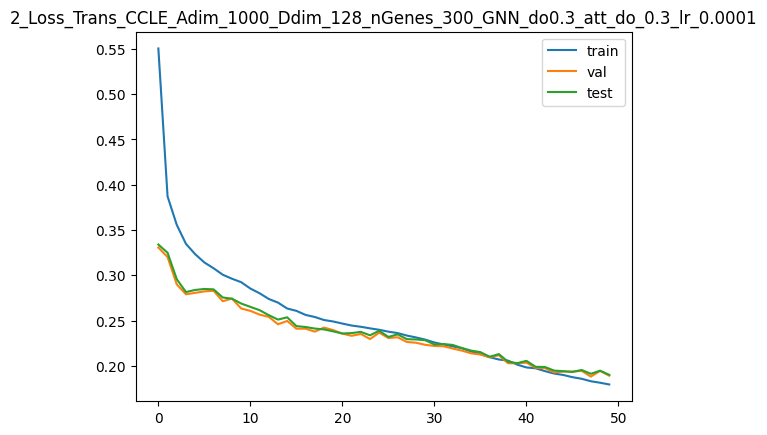

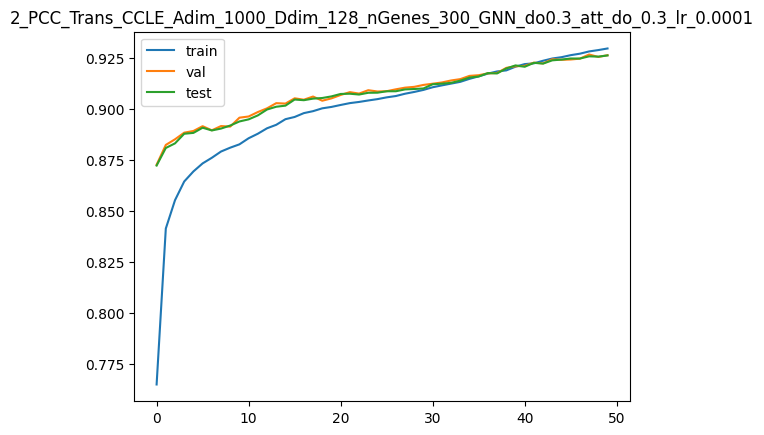

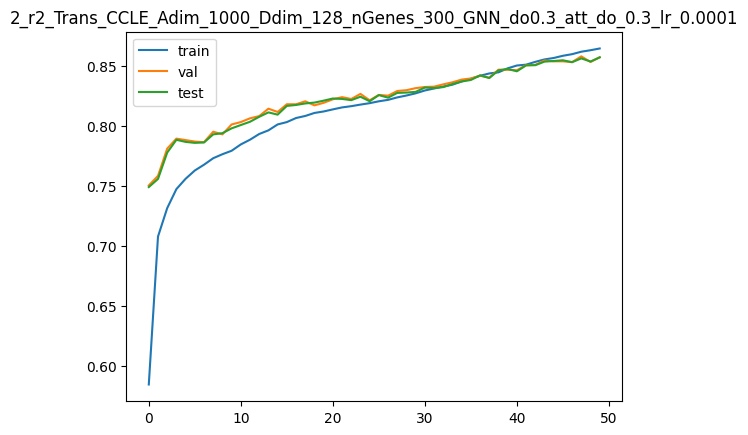

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17732847
Train avg_pcc:  0.9306931820808438
Train r2:  0.8661842912138402


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18791248
Validation avg_pcc:  0.9266242596176106
Validation r2:  0.8582074573953784
Best Val r2  0.8582074573953784


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18889356
Test avg_pcc:  0.9266484335786696
Test r2:  0.8580774775448389
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17620432
Train avg_pcc:  0.9311477926190802
Train r2:  0.8670325829861538


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18688375
Validation avg_pcc:  0.926973177868336
Validation r2:  0.8589837170093352
Best Val r2  0.8589837170093352


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18566063
Test avg_pcc:  0.9278443118544677
Test r2:  0.8605064800859643
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17461531
Train avg_pcc:  0.9317925380176573
Train r2:  0.8682316882650838


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18504612
Validation avg_pcc:  0.9282127697409481
Validation r2:  0.8603703195669646
Best Val r2  0.8603703195669646


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18572155
Test avg_pcc:  0.9281250578857271
Test r2:  0.8604607133801253
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17304519
Train avg_pcc:  0.9324281963099296
Train r2:  0.8694165357269765


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18584278
Validation avg_pcc:  0.9277282135032753
Validation r2:  0.8597691825122477


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18538767
Test avg_pcc:  0.9281607740456836
Test r2:  0.8607115577546575
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17123863
Train avg_pcc:  0.9331572343370275
Train r2:  0.8707798112595734


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18379097
Validation avg_pcc:  0.9283258798604686
Validation r2:  0.8613174337652267
Best Val r2  0.8613174337652267


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1854164
Test avg_pcc:  0.9280818315481741
Test r2:  0.8606899821129181
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16951904
Train avg_pcc:  0.933852274653772
Train r2:  0.872077436515169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18039162
Validation avg_pcc:  0.929986284324723
Validation r2:  0.8638824522297197
Best Val r2  0.8638824522297197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18313058
Test avg_pcc:  0.9294194898077967
Test r2:  0.8624074088348905
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16839263
Train avg_pcc:  0.9343081291495753
Train r2:  0.8729274429907561


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18528119
Validation avg_pcc:  0.928872500867683
Validation r2:  0.8601929461231504


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18579298
Test avg_pcc:  0.9290325886506645
Test r2:  0.8604070401480054
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16670573
Train avg_pcc:  0.9349897601803027
Train r2:  0.8742004272426513


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18139754
Validation avg_pcc:  0.9298453153041767
Validation r2:  0.8631234088733828


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18292342
Test avg_pcc:  0.9294723123649973
Test r2:  0.8625630490310324
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16469568
Train avg_pcc:  0.9358001859732564
Train r2:  0.8757172593728787


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1799807
Validation avg_pcc:  0.9298154612743075
Validation r2:  0.864192530862748
Best Val r2  0.864192530862748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17946342
Test avg_pcc:  0.9303388422761518
Test r2:  0.8651626730567152
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1631818
Train avg_pcc:  0.9364093376912369
Train r2:  0.8768596507718349


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17853919
Validation avg_pcc:  0.930297845090993
Validation r2:  0.8652802358858557
Best Val r2  0.8652802358858557


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1785084
Test avg_pcc:  0.9306499957738927
Test r2:  0.865880213313317
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16211167
Train avg_pcc:  0.936841812002281
Train r2:  0.8776671892739387


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18035255
Validation avg_pcc:  0.9301022675514042
Validation r2:  0.8639119360085319


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18026441
Test avg_pcc:  0.9304134762508249
Test r2:  0.8645608520206534
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16080718
Train avg_pcc:  0.9373663846831409
Train r2:  0.8786515884178201


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17950262
Validation avg_pcc:  0.9309599862356028
Validation r2:  0.8645532499884265


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18165888
Test avg_pcc:  0.9303186085670475
Test r2:  0.8635131285932763
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15903851
Train avg_pcc:  0.9380778545246279
Train r2:  0.8799862632366892


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17764159
Validation avg_pcc:  0.9307338945974847
Validation r2:  0.8659575429381519
Best Val r2  0.8659575429381519


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17660435
Test avg_pcc:  0.9313923320697195
Test r2:  0.8673108028448007
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1577055
Train avg_pcc:  0.938613345274309
Train r2:  0.8809921713180264


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17794897
Validation avg_pcc:  0.93064673549943
Validation r2:  0.8657256048694102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1778457
Test avg_pcc:  0.9310221682185631
Test r2:  0.8663781151075532
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15526296
Train avg_pcc:  0.9395947433287565
Train r2:  0.8828353602973122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17277609
Validation avg_pcc:  0.9325716531534867
Validation r2:  0.8696288912325186
Best Val r2  0.8696288912325186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17455645
Test avg_pcc:  0.9321466563869686
Test r2:  0.8688494574900378
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15427524
Train avg_pcc:  0.9399919958075316
Train r2:  0.8835807329432072


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17400868
Validation avg_pcc:  0.9322126581775085
Validation r2:  0.8686988065590961


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17520665
Test avg_pcc:  0.9319522424057263
Test r2:  0.8683609300096902
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15376987
Train avg_pcc:  0.9401948195857832
Train r2:  0.8839620991278826


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17264663
Validation avg_pcc:  0.9326377098202111
Validation r2:  0.8697265658652318
Best Val r2  0.8697265658652318


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17324951
Test avg_pcc:  0.9326861433668328
Test r2:  0.8698314030522225
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1521523
Train avg_pcc:  0.9408434483813848
Train r2:  0.8851827364514346


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17411618
Validation avg_pcc:  0.9324166387336476
Validation r2:  0.8686176888104049


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17520094
Test avg_pcc:  0.932229649995448
Test r2:  0.8683652264198906
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15091516
Train avg_pcc:  0.9413391139360989
Train r2:  0.886116315838868


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17247503
Validation avg_pcc:  0.9330680051493307
Validation r2:  0.8698560519165306
Best Val r2  0.8698560519165306


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17490165
Test avg_pcc:  0.9323393404168352
Test r2:  0.8685900883192484
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14917853
Train avg_pcc:  0.9420357769640776
Train r2:  0.887426810562518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17324688
Validation avg_pcc:  0.9328391395369365
Validation r2:  0.8692736414335367


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17379308
Test avg_pcc:  0.9327528229745928
Test r2:  0.869423002380969
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.149007
Train avg_pcc:  0.9421034341497682
Train r2:  0.8875562648293296


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17098987
Validation avg_pcc:  0.9338479014871983
Validation r2:  0.8709767026256122
Best Val r2  0.8709767026256122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17295775
Test avg_pcc:  0.9332144765690437
Test r2:  0.8700506221883908
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14712824
Train avg_pcc:  0.9428562710657883
Train r2:  0.8889740026083974


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16967267
Validation avg_pcc:  0.9342479404661655
Validation r2:  0.8719706281877684
Best Val r2  0.8719706281877684


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17053664
Test avg_pcc:  0.9341508182597774
Test r2:  0.8718696834068258
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14624405
Train avg_pcc:  0.9432098553450293
Train r2:  0.8896412191919152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16949084
Validation avg_pcc:  0.9340949730838417
Validation r2:  0.8721078247729536
Best Val r2  0.8721078247729536


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17066886
Test avg_pcc:  0.9337832873583545
Test r2:  0.8717703334256537
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14495385
Train avg_pcc:  0.9437256353202661
Train r2:  0.8906148442974188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16925265
Validation avg_pcc:  0.9341528995168439
Validation r2:  0.8722875448877815
Best Val r2  0.8722875448877815


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17105499
Test avg_pcc:  0.9337621953352223
Test r2:  0.8714802318228394
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14301328
Train avg_pcc:  0.9445012350179564
Train r2:  0.8920792329045147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1703194
Validation avg_pcc:  0.9339858928547634
Validation r2:  0.8714826281550941


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17003459
Test avg_pcc:  0.934317617628959
Test r2:  0.8722468899409098
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14301297
Train avg_pcc:  0.9445011017537364
Train r2:  0.8920794676688282


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17124172
Validation avg_pcc:  0.9343791985872273
Validation r2:  0.8707866683206025


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17184393
Test avg_pcc:  0.934304480314016
Test r2:  0.8708874659245763
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14130248
Train avg_pcc:  0.9451840754533886
Train r2:  0.8933702301675158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1673825
Validation avg_pcc:  0.9347575935260994
Validation r2:  0.8736987137756187
Best Val r2  0.8736987137756187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.168197
Test avg_pcc:  0.9346970966175887
Test r2:  0.8736275419158483
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14068985
Train avg_pcc:  0.945428810521814
Train r2:  0.8938325465144555


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16694869
Validation avg_pcc:  0.935019168913941
Validation r2:  0.8740260371560743
Best Val r2  0.8740260371560743


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16865736
Test avg_pcc:  0.9346185495952987
Test r2:  0.8732816580678939
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13970524
Train avg_pcc:  0.945822084282523
Train r2:  0.8945755476692553


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16988192
Validation avg_pcc:  0.9345279258551225
Validation r2:  0.8718127325229409


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16957717
Test avg_pcc:  0.9349068177898806
Test r2:  0.8725905592381609
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13864444
Train avg_pcc:  0.9462449964447577
Train r2:  0.8953760380212026


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16589078
Validation avg_pcc:  0.935398931463748
Validation r2:  0.8748242975596108
Best Val r2  0.8748242975596108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16612822
Test avg_pcc:  0.9355855161816162
Test r2:  0.8751818859368181
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13755384
Train avg_pcc:  0.9466797266269656
Train r2:  0.8961990379468815


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16624892
Validation avg_pcc:  0.9352704281157616
Validation r2:  0.8745540600760061


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16809256
Test avg_pcc:  0.9348944122385365
Test r2:  0.8737060139597433
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13632049
Train avg_pcc:  0.947171348598899
Train r2:  0.8971297548834579


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16568023
Validation avg_pcc:  0.9363649034175724
Validation r2:  0.8749831950457398
Best Val r2  0.8749831950457398


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16811322
Test avg_pcc:  0.9356988623448868
Test r2:  0.8736904875626038
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1349547
Train avg_pcc:  0.9477144949747964
Train r2:  0.8981603893206654


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17366126
Validation avg_pcc:  0.9361078197929122
Validation r2:  0.8689609604144483


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17552485
Test avg_pcc:  0.9356894093018439
Test r2:  0.868121860271499
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1349832
Train avg_pcc:  0.9477034382091175
Train r2:  0.8981388972169864


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16429517
Validation avg_pcc:  0.936309231440704
Validation r2:  0.8760283085082898
Best Val r2  0.8760283085082898


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16748562
Test avg_pcc:  0.9352722974222035
Test r2:  0.8741620233849703
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13300465
Train avg_pcc:  0.9484908744839258
Train r2:  0.8996319530129447


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16542904
Validation avg_pcc:  0.9367168206825598
Validation r2:  0.8751727149784843


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16737142
Test avg_pcc:  0.9362475478535706
Test r2:  0.8742478218829797
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13175157
Train avg_pcc:  0.9489891954234774
Train r2:  0.9005775536000148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16426226
Validation avg_pcc:  0.9369540974617597
Validation r2:  0.876053135490452
Best Val r2  0.876053135490452


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16575456
Test avg_pcc:  0.936590225365323
Test r2:  0.8754626373604056
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13104741
Train avg_pcc:  0.9492689153033769
Train r2:  0.9011089080980829


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16377784
Validation avg_pcc:  0.9363818956015197
Validation r2:  0.8764186768961828
Best Val r2  0.8764186768961828


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1647832
Test avg_pcc:  0.9361624210297417
Test r2:  0.8761924475436794
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1307058
Train avg_pcc:  0.9494049132905884
Train r2:  0.9013667146533115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16201152
Validation avg_pcc:  0.9370152975476504
Validation r2:  0.8777514666883268
Best Val r2  0.8777514666883268


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16401836
Test avg_pcc:  0.9364611631978867
Test r2:  0.8767670909085765
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12961823
Train avg_pcc:  0.9498381677417869
Train r2:  0.9021874211181793


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.164581
Validation avg_pcc:  0.9365189495006431
Validation r2:  0.8758126160309292


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16443324
Test avg_pcc:  0.936716493987944
Test r2:  0.8764553950816039
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1289742
Train avg_pcc:  0.9500924074659888
Train r2:  0.9026734145179242


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16109051
Validation avg_pcc:  0.937376553786261
Validation r2:  0.8784464346251721
Best Val r2  0.8784464346251721


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16271776
Test avg_pcc:  0.936972287879269
Test r2:  0.8777442956731315
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1274026
Train avg_pcc:  0.9507165455686073
Train r2:  0.9038593663145079


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16785188
Validation avg_pcc:  0.9369010963754748
Validation r2:  0.8733445345653461


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16882692
Test avg_pcc:  0.9367122119059534
Test r2:  0.8731542526320035
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12657236
Train avg_pcc:  0.9510460682125275
Train r2:  0.9044858918065302


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16325451
Validation avg_pcc:  0.9369670282363161
Validation r2:  0.8768135600201346


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16376519
Test avg_pcc:  0.9369326835807098
Test r2:  0.8769573261561171
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12691432
Train avg_pcc:  0.9509102326224892
Train r2:  0.9042278340579066


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16317731
Validation avg_pcc:  0.9369403911164408
Validation r2:  0.8768718142315006


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16401754
Test avg_pcc:  0.9367710728848686
Test r2:  0.8767677069605432
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1250492
Train avg_pcc:  0.9516505988578974
Train r2:  0.9056352800367133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16641806
Validation avg_pcc:  0.9377881834701035
Validation r2:  0.8744264426473141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16763954
Test avg_pcc:  0.9375155306559791
Test r2:  0.8740463742467701
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.124877036
Train avg_pcc:  0.9517184391812544
Train r2:  0.9057652165402063


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16160682
Validation avg_pcc:  0.9376744587508601
Validation r2:  0.8780568508119256


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16241711
Test avg_pcc:  0.9376700007389323
Test r2:  0.8779701849484306
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12420394
Train avg_pcc:  0.9519852918226563
Train r2:  0.9062731469502299


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16070846
Validation avg_pcc:  0.9382795204930864
Validation r2:  0.8787347144543668
Best Val r2  0.8787347144543668


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16219199
Test avg_pcc:  0.9379570214715565
Test r2:  0.8781393261703154
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1222204
Train avg_pcc:  0.9527715349488031
Train r2:  0.9077699815956718


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1620346
Validation avg_pcc:  0.9372493757140506
Validation r2:  0.8777340572697131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16323808
Test avg_pcc:  0.9368936915851507
Test r2:  0.8773533528279873
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12206224
Train avg_pcc:  0.9528334278733234
Train r2:  0.9078893110244421


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16200766
Validation avg_pcc:  0.9382298680204936
Validation r2:  0.8777543827422957


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16341946
Test avg_pcc:  0.937947183715171
Test r2:  0.8772170863436465
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12046514
Train avg_pcc:  0.9534659408663919
Train r2:  0.9090945346533289


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16161716
Validation avg_pcc:  0.9375879815007079
Validation r2:  0.8780490395212819


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16225931
Test avg_pcc:  0.9374508422260986
Test r2:  0.8780887433657775
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11977157
Train avg_pcc:  0.9537397451364801
Train r2:  0.909617905023711


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16394101
Validation avg_pcc:  0.9380229148408918
Validation r2:  0.8762955431601321


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16658238
Test avg_pcc:  0.9374157365023487
Test r2:  0.8748406576949208


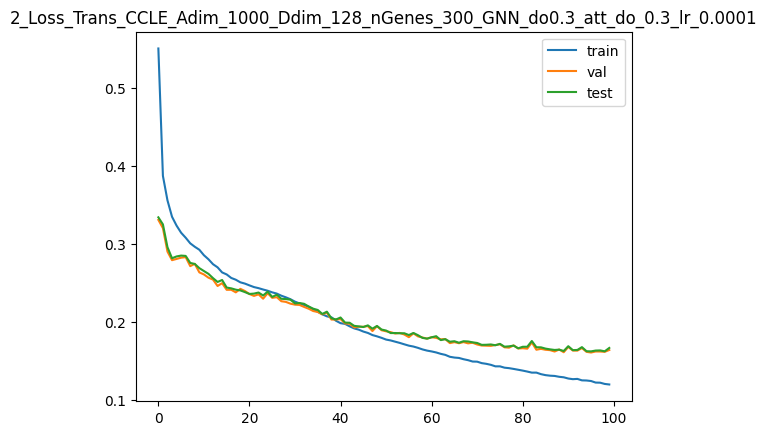

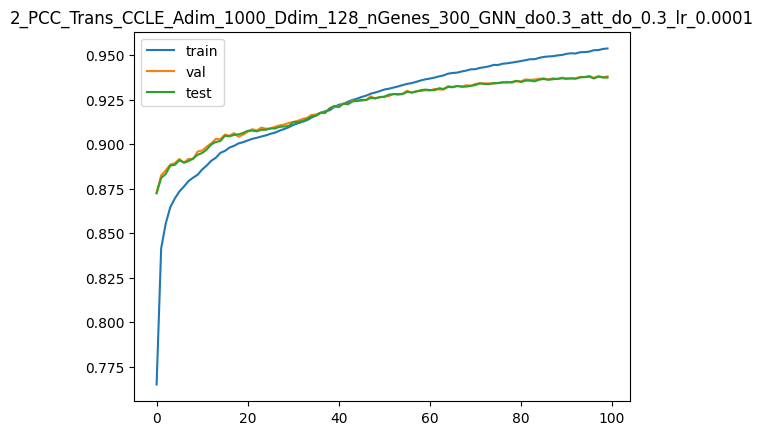

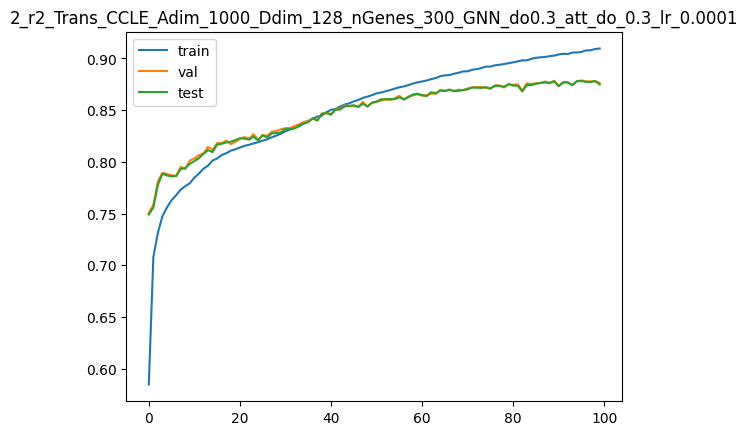

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.119553946
Train avg_pcc:  0.9538263678522741
Train r2:  0.9097821291855065


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16049644
Validation avg_pcc:  0.9376524702278977
Validation r2:  0.8788946906913953
Best Val r2  0.8788946906913953


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16052176
Test avg_pcc:  0.9379292245852717
Test r2:  0.8793942176147085
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11895194
Train avg_pcc:  0.9540644611770943
Train r2:  0.9102364107489246


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15841247
Validation avg_pcc:  0.9392027549300402
Validation r2:  0.8804672037395765
Best Val r2  0.8804672037395765


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16201729
Test avg_pcc:  0.9380477800144669
Test r2:  0.8782705805289441
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11865297
Train avg_pcc:  0.9541829080941437
Train r2:  0.9104620142665029


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1608074
Validation avg_pcc:  0.9382442060323483
Validation r2:  0.8786600589220973


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16212545
Test avg_pcc:  0.9378057066935735
Test r2:  0.8781893219099981
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11816105
Train avg_pcc:  0.9543772958031345
Train r2:  0.910833226927828


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15799661
Validation avg_pcc:  0.9386782493860529
Validation r2:  0.8807809904469804
Best Val r2  0.8807809904469804


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15998492
Test avg_pcc:  0.9381196171547185
Test r2:  0.8797975833733113
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11701147
Train avg_pcc:  0.9548316527877992
Train r2:  0.9117007389800503


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.158244
Validation avg_pcc:  0.9389243905277063
Validation r2:  0.8805943276413339


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1602505
Test avg_pcc:  0.9383951603598254
Test r2:  0.8795980263001221
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11595224
Train avg_pcc:  0.9552500912714146
Train r2:  0.9125000425218847


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15762979
Validation avg_pcc:  0.9388295208869095
Validation r2:  0.8810577860423412
Best Val r2  0.8810577860423412


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15903619
Test avg_pcc:  0.9384892872352839
Test r2:  0.8805103858724992
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1149046
Train avg_pcc:  0.9556639783400742
Train r2:  0.9132906198930234


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15660416
Validation avg_pcc:  0.9393518772543337
Validation r2:  0.8818316859683224
Best Val r2  0.8818316859683224


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15815148
Test avg_pcc:  0.9388867145624389
Test r2:  0.8811750949406092
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11552146
Train avg_pcc:  0.9554202337973371
Train r2:  0.9128251209273113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15933731
Validation avg_pcc:  0.9387841008145891
Validation r2:  0.8797693382315876


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15956596
Test avg_pcc:  0.9389697728092549
Test r2:  0.8801123524274177
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.114042364
Train avg_pcc:  0.9560045487984551
Train r2:  0.9139412829726147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15640917
Validation avg_pcc:  0.9396423351786308
Validation r2:  0.8819788130898047
Best Val r2  0.8819788130898047


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15786864
Test avg_pcc:  0.9392372567899092
Test r2:  0.881387601324539
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.113908835
Train avg_pcc:  0.9560577442358317
Train r2:  0.9140420456782437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15632991
Validation avg_pcc:  0.9395748206527712
Validation r2:  0.8820386258727014
Best Val r2  0.8820386258727014


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15840475
Test avg_pcc:  0.9389004418850814
Test r2:  0.8809848085587758
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11288638
Train avg_pcc:  0.9564599294907221
Train r2:  0.9148136170780502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15681091
Validation avg_pcc:  0.939736650131416
Validation r2:  0.8816756754784897


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15777169
Test avg_pcc:  0.939508654879809
Test r2:  0.8814604494259116
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11157313
Train avg_pcc:  0.9569783743267047
Train r2:  0.9158046110221301


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15900242
Validation avg_pcc:  0.9394237961725238
Validation r2:  0.8800220418489763


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16058008
Test avg_pcc:  0.9387969569160092
Test r2:  0.879350401296817
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.111544326
Train avg_pcc:  0.9569891534567605
Train r2:  0.9158263562704132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15576625
Validation avg_pcc:  0.9397290935559212
Validation r2:  0.8824639432714403
Best Val r2  0.8824639432714403


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15787563
Test avg_pcc:  0.939160276395091
Test r2:  0.8813823630492794
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1105972
Train avg_pcc:  0.9573631538867239
Train r2:  0.9165410723807468


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15892519
Validation avg_pcc:  0.9387461901403567
Validation r2:  0.8800803135323463


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15869373
Test avg_pcc:  0.9390229667005385
Test r2:  0.8807676857013423
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11058078
Train avg_pcc:  0.9573688492195396
Train r2:  0.916553465395781


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15689296
Validation avg_pcc:  0.9397215309956739
Validation r2:  0.8816137750746516


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15929274
Test avg_pcc:  0.9390098342876572
Test r2:  0.8803176411457091
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1105219
Train avg_pcc:  0.9573926083668276
Train r2:  0.9165979047405106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1547394
Validation avg_pcc:  0.9399726346025779
Validation r2:  0.8832387737433286
Best Val r2  0.8832387737433286


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15564904
Test avg_pcc:  0.9397992949948035
Test r2:  0.8830552890797841
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10849573
Train avg_pcc:  0.9581904335912245
Train r2:  0.9181268839749842


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15587959
Validation avg_pcc:  0.9396790515606013
Validation r2:  0.8823784248372527


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15708522
Test avg_pcc:  0.939427036233192
Test r2:  0.8819762204373588
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10867161
Train avg_pcc:  0.9581214695615744
Train r2:  0.9179941583801307


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15634152
Validation avg_pcc:  0.940057983302686
Validation r2:  0.882029866937764


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16072518
Test avg_pcc:  0.9386203505482907
Test r2:  0.8792413779470848
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10783878
Train avg_pcc:  0.9584496189621523
Train r2:  0.9186226333695992


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1556257
Validation avg_pcc:  0.9403575073817678
Validation r2:  0.8825699994161244


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1582253
Test avg_pcc:  0.939453056437875
Test r2:  0.8811196361603755
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10828669
Train avg_pcc:  0.9582729430195289
Train r2:  0.9182846355765726


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1550525
Validation avg_pcc:  0.9401304548182199
Validation r2:  0.8830025085069295


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15759309
Test avg_pcc:  0.939342895500368
Test r2:  0.8815946514117061
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10696483
Train avg_pcc:  0.9587937025210764
Train r2:  0.9192821318826377


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15656494
Validation avg_pcc:  0.9404397276536868
Validation r2:  0.8818612877271165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16005962
Test avg_pcc:  0.9393228797601874
Test r2:  0.8797414467718682
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.106984116
Train avg_pcc:  0.958785364368617
Train r2:  0.9192675857187704


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15395628
Validation avg_pcc:  0.9404926340602806
Validation r2:  0.8838296906941195
Best Val r2  0.8838296906941195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1566153
Test avg_pcc:  0.9397571814809054
Test r2:  0.8823292807350601
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10622818
Train avg_pcc:  0.9590832507982888
Train r2:  0.9198380232640802


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15432858
Validation avg_pcc:  0.9405607926287535
Validation r2:  0.8835487564996949


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15640216
Test avg_pcc:  0.9399475517964837
Test r2:  0.8824894259970082
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.104683936
Train avg_pcc:  0.9596907309667401
Train r2:  0.9210033417039831


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1564268
Validation avg_pcc:  0.9398883470854329
Validation r2:  0.8819655058438942


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15739088
Test avg_pcc:  0.939690897491166
Test r2:  0.881746567263134
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10424428
Train avg_pcc:  0.9598631391146956
Train r2:  0.9213351202700804


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15553258
Validation avg_pcc:  0.9399293000380574
Validation r2:  0.8826402661192049


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15643801
Test avg_pcc:  0.9397988712810468
Test r2:  0.8824625057724554
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10443073
Train avg_pcc:  0.9597902760256662
Train r2:  0.921194415958486


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15403883
Validation avg_pcc:  0.9402571835936896
Validation r2:  0.8837673972387998


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1570751
Test avg_pcc:  0.9392497678551865
Test r2:  0.8819838207922442
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10412284
Train avg_pcc:  0.9599109576474693
Train r2:  0.9214267584184828


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15488161
Validation avg_pcc:  0.940440980781013
Validation r2:  0.8831314622187385


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15709054
Test avg_pcc:  0.9397737239439364
Test r2:  0.8819722131455203
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1039552
Train avg_pcc:  0.9599774011376379
Train r2:  0.9215532671334107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15518288
Validation avg_pcc:  0.9404371545155163
Validation r2:  0.8829041372347527


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15669468
Test avg_pcc:  0.9400959893372459
Test r2:  0.8822696449936488
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10326887
Train avg_pcc:  0.9602464674206513
Train r2:  0.9220711716611852


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15752009
Validation avg_pcc:  0.9402789242136802
Validation r2:  0.8811405594771794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16018462
Test avg_pcc:  0.9393629198724027
Test r2:  0.8796475220910789
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.103036836
Train avg_pcc:  0.9603376035154921
Train r2:  0.9222462740888783


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15689722
Validation avg_pcc:  0.9400474179771414
Validation r2:  0.8816105518752178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1588571
Test avg_pcc:  0.9395215954623619
Test r2:  0.880644936142368
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.102292344
Train avg_pcc:  0.9606305018657885
Train r2:  0.9228080891001382


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15680991
Validation avg_pcc:  0.9401095440954327
Validation r2:  0.8816764281310234


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15842569
Test avg_pcc:  0.9396307692791647
Test r2:  0.8809690832135464
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.101557285
Train avg_pcc:  0.9609189737940708
Train r2:  0.9233627837710711


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15498562
Validation avg_pcc:  0.940013262310373
Validation r2:  0.8830529898033295


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15587744
Test avg_pcc:  0.939860178880652
Test r2:  0.8828836782826711
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10113847
Train avg_pcc:  0.9610830197437853
Train r2:  0.9236788298497519


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15378277
Validation avg_pcc:  0.9407881889992519
Validation r2:  0.8839606088463146
Best Val r2  0.8839606088463146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15434419
Test avg_pcc:  0.9407538815680162
Test r2:  0.8840356596690893
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10055797
Train avg_pcc:  0.9613113934095404
Train r2:  0.9241168936057073


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15537742
Validation avg_pcc:  0.9404110403724477
Validation r2:  0.8827573361188898


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15715581
Test avg_pcc:  0.9397517711469087
Test r2:  0.8819231825632348
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.100494966
Train avg_pcc:  0.9613360422158036
Train r2:  0.9241644184144168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15297468
Validation avg_pcc:  0.9409560176856178
Validation r2:  0.8845703619952886
Best Val r2  0.8845703619952886


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15552302
Test avg_pcc:  0.940063120742992
Test r2:  0.8831499431833747
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10000173
Train avg_pcc:  0.9615294126778114
Train r2:  0.9245366326509085


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1528543
Validation avg_pcc:  0.941435357205547
Validation r2:  0.8846612102889952
Best Val r2  0.8846612102889952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1555066
Test avg_pcc:  0.9405340792254164
Test r2:  0.8831622909109449
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09960045
Train avg_pcc:  0.9616870467668535
Train r2:  0.9248394500406659


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15372416
Validation avg_pcc:  0.9408734901974061
Validation r2:  0.884004841100007


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.155328
Test avg_pcc:  0.9403676975298993
Test r2:  0.8832964735531398
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09857658
Train avg_pcc:  0.962089071039509
Train r2:  0.9256120837761048


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1550346
Validation avg_pcc:  0.9405710224682307
Validation r2:  0.8830160281992859


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15791391
Test avg_pcc:  0.9394886601642314
Test r2:  0.8813535814484862
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09835257
Train avg_pcc:  0.9621762135379917
Train r2:  0.925781133766446


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15455505
Validation avg_pcc:  0.940949127053389
Validation r2:  0.8833778708476595


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15522282
Test avg_pcc:  0.9407331674800713
Test r2:  0.883375518274673
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09794564
Train avg_pcc:  0.9623360714906684
Train r2:  0.9260881917331475


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1555377
Validation avg_pcc:  0.9407647379495939
Validation r2:  0.8826364076003212


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15644927
Test avg_pcc:  0.9405429253335128
Test r2:  0.8824540375241057
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0978569
Train avg_pcc:  0.9623711041145132
Train r2:  0.926155165750133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15472667
Validation avg_pcc:  0.9407398485725924
Validation r2:  0.8832483877955474


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15466635
Test avg_pcc:  0.9408886633630174
Test r2:  0.8837935980066358
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.096865214
Train avg_pcc:  0.9627591448382181
Train r2:  0.9269035078909362


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1534195
Validation avg_pcc:  0.9414442357895617
Validation r2:  0.8842347312552901


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15554051
Test avg_pcc:  0.9407021319477354
Test r2:  0.8831368132720775
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09730512
Train avg_pcc:  0.9625873259067593
Train r2:  0.926571553130507


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15707661
Validation avg_pcc:  0.9406581446174231
Validation r2:  0.8814751864447402


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15666646
Test avg_pcc:  0.9408131344703099
Test r2:  0.8822908481115036
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09653557
Train avg_pcc:  0.962888297672917
Train r2:  0.9271522609224098


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15372446
Validation avg_pcc:  0.9409783233126887
Validation r2:  0.8840046169021157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15546401
Test avg_pcc:  0.9403993722833065
Test r2:  0.8831942930729667
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.095516734
Train avg_pcc:  0.9632881795705173
Train r2:  0.9279211088352471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15328842
Validation avg_pcc:  0.9410470720958629
Validation r2:  0.884333621381993


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15562098
Test avg_pcc:  0.9403096959899534
Test r2:  0.8830763490679333
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.095434055
Train avg_pcc:  0.9633198817794837
Train r2:  0.9279835004977595


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15322156
Validation avg_pcc:  0.9412394394102047
Validation r2:  0.884384080170344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15532188
Test avg_pcc:  0.9405252660983412
Test r2:  0.8833010682214316
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09435858
Train avg_pcc:  0.9637413225110094
Train r2:  0.9287950731370439


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15219508
Validation avg_pcc:  0.9417289050620108
Validation r2:  0.8851586156796161
Best Val r2  0.8851586156796161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15526566
Test avg_pcc:  0.9407382510709537
Test r2:  0.883343322337269
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.095712155
Train avg_pcc:  0.9632120320729538
Train r2:  0.9277736279551072


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1528791
Validation avg_pcc:  0.9411739545064411
Validation r2:  0.8846424924400507


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15306433
Test avg_pcc:  0.9412573326846934
Test r2:  0.8849972682805396
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0944224
Train avg_pcc:  0.9637159438488436
Train r2:  0.9287469177755978


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15061001
Validation avg_pcc:  0.9415893049409552
Validation r2:  0.8863546629462669
Best Val r2  0.8863546629462669


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15420444
Test avg_pcc:  0.9403662433137321
Test r2:  0.8841406536434079
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.093825035
Train avg_pcc:  0.963950375274486
Train r2:  0.9291976928635544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15223406
Validation avg_pcc:  0.9417575252953104
Validation r2:  0.8851292214572892


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1542952
Test avg_pcc:  0.9412172334528209
Test r2:  0.8840724452302311


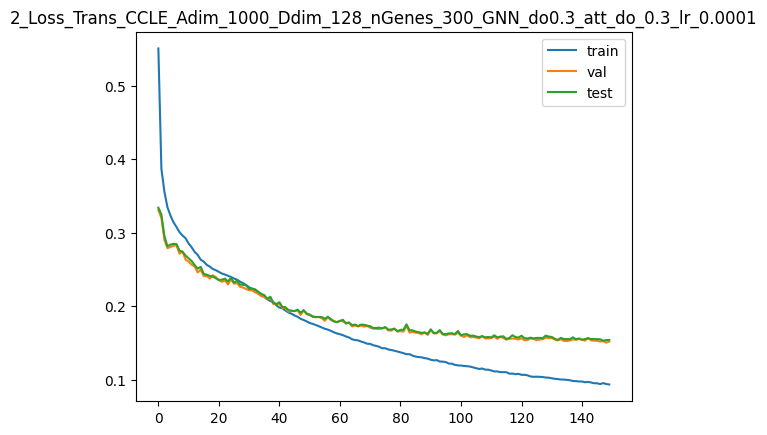

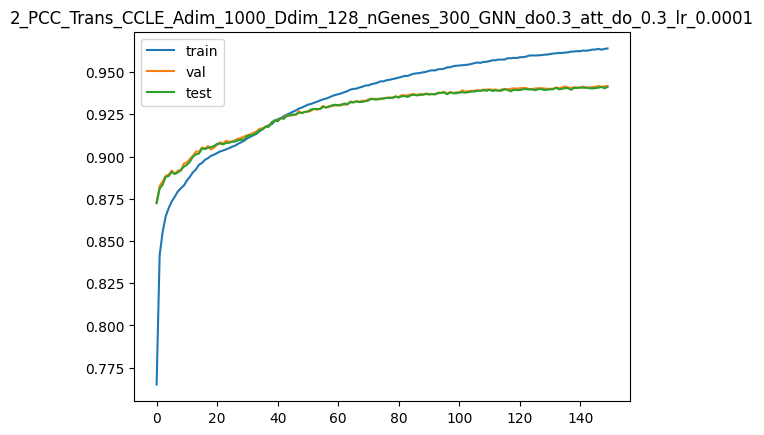

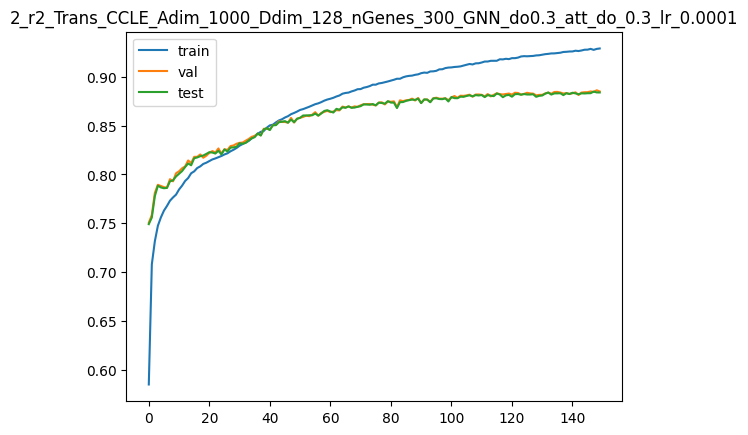

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15420444
Test avg_pcc:  0.9403662431683839
Test r2:  0.8841406532040279


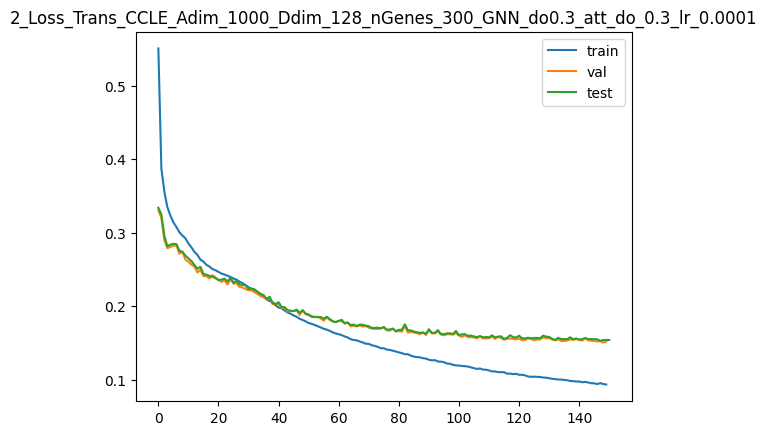

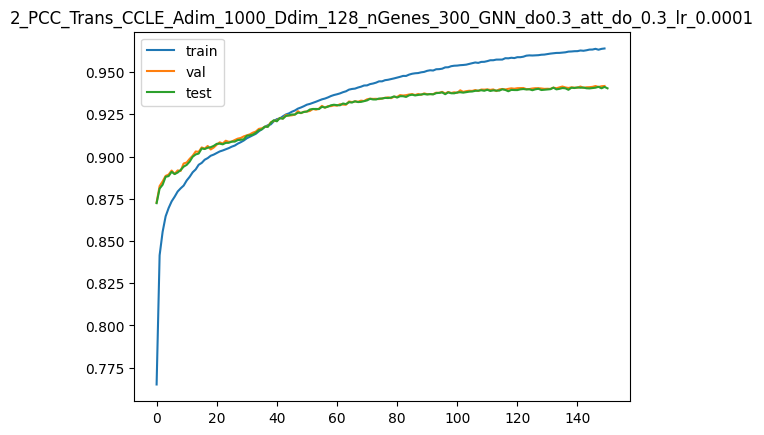

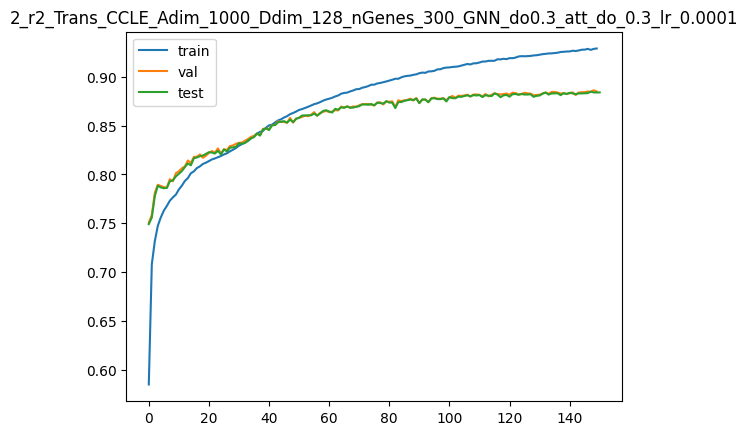

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.5555154
Train avg_pcc:  0.7620096473009579
Train r2:  0.5797463564190213


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.35493106
Validation avg_pcc:  0.8682973069608046
Validation r2:  0.7359339799543287
Best Val r2  0.7359339799543287


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.353648
Test avg_pcc:  0.8686720127620118
Test r2:  0.7358258855326674
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.38482073
Train avg_pcc:  0.8421391734447542
Train r2:  0.7088788031142808


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31474766
Validation avg_pcc:  0.8819364737949421
Validation r2:  0.7658301271316763
Best Val r2  0.7658301271316763


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30408671
Test avg_pcc:  0.8859860076806214
Test r2:  0.7728480506543396
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.35055533
Train avg_pcc:  0.8573238201533407
Train r2:  0.7348009768462009


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30397138
Validation avg_pcc:  0.8867043292885269
Validation r2:  0.7738476058056479
Best Val r2  0.7738476058056479


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29304945
Test avg_pcc:  0.8900379550664423
Test r2:  0.7810928617371202
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.33426148
Train avg_pcc:  0.8644536632371044
Train r2:  0.7471274382007151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.295688
Validation avg_pcc:  0.8864657890671733
Validation r2:  0.7800103638799722
Best Val r2  0.7800103638799722


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2826883
Test avg_pcc:  0.8914376169036363
Test r2:  0.7888325948459244
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.32482904
Train avg_pcc:  0.8685429403368777
Train r2:  0.754263174604854


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3238833
Validation avg_pcc:  0.8888204151338408
Validation r2:  0.7590332803284165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3145619
Test avg_pcc:  0.892900144396619
Test r2:  0.7650231023920404
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3140143
Train avg_pcc:  0.8732160309546845
Train r2:  0.7624446760337784


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28570586
Validation avg_pcc:  0.8886587737274667
Validation r2:  0.7874369870951694
Best Val r2  0.7874369870951694


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27337366
Test avg_pcc:  0.8937568496073188
Test r2:  0.7957906115391851
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.30786863
Train avg_pcc:  0.8758650030701292
Train r2:  0.7670939323059833


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29194173
Validation avg_pcc:  0.8895424540931175
Validation r2:  0.7827975600229771


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2786427
Test avg_pcc:  0.8946409493369704
Test r2:  0.7918546330209523
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3009223
Train avg_pcc:  0.8788522933077366
Train r2:  0.772348889998613


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27407074
Validation avg_pcc:  0.8923286306611381
Validation r2:  0.7960934352864173
Best Val r2  0.7960934352864173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26121527
Test avg_pcc:  0.8972848628897527
Test r2:  0.8048728962257038
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2942641
Train avg_pcc:  0.8817074361602464
Train r2:  0.7773859275783547


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27998835
Validation avg_pcc:  0.8940312931862081
Validation r2:  0.7916907749839417


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2672568
Test avg_pcc:  0.898409274525198
Test r2:  0.8003598981721403
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2887779
Train avg_pcc:  0.8840548993447339
Train r2:  0.7815362863417723


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2703433
Validation avg_pcc:  0.8938684019452179
Validation r2:  0.7988666271956258
Best Val r2  0.7988666271956258


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2600029
Test avg_pcc:  0.8977258347929528
Test r2:  0.8057785276780812
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.28533012
Train avg_pcc:  0.8855289578330564
Train r2:  0.7841445609019457


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2760836
Validation avg_pcc:  0.8928276549915418
Validation r2:  0.7945958991645179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2652995
Test avg_pcc:  0.8968839536771258
Test r2:  0.8018219900527285
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.28021595
Train avg_pcc:  0.8877078370037556
Train r2:  0.7880134720621235


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26227576
Validation avg_pcc:  0.8988822316894932
Validation r2:  0.8048688169397957
Best Val r2  0.8048688169397957


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2515365
Test avg_pcc:  0.9024610220118112
Test r2:  0.812102920696425
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.27460578
Train avg_pcc:  0.890096100143755
Train r2:  0.7922576344618464


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26156402
Validation avg_pcc:  0.9010730401375217
Validation r2:  0.8053983315505044
Best Val r2  0.8053983315505044


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25099638
Test avg_pcc:  0.9045470810936581
Test r2:  0.8125063878307667
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26809362
Train avg_pcc:  0.8928590122172217
Train r2:  0.7971841500626573


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2559654
Validation avg_pcc:  0.9007637336609585
Validation r2:  0.8095636736341572
Best Val r2  0.8095636736341572


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24260253
Test avg_pcc:  0.9056509885222889
Test r2:  0.8187765652495415
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26453528
Train avg_pcc:  0.894363363645014
Train r2:  0.7998760936419473


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2507273
Validation avg_pcc:  0.90234693998688
Validation r2:  0.813460772357888
Best Val r2  0.813460772357888


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2398516
Test avg_pcc:  0.9062097862810992
Test r2:  0.8208315053824904
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25904307
Train avg_pcc:  0.8966829257735885
Train r2:  0.8040310086170813


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24959093
Validation avg_pcc:  0.9042213315986409
Validation r2:  0.8143062291965014
Best Val r2  0.8143062291965014


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23954044
Test avg_pcc:  0.9076881374022003
Test r2:  0.821063928647395
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25648192
Train avg_pcc:  0.8977646757405675
Train r2:  0.805968540554307


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25795653
Validation avg_pcc:  0.9000639408996699
Validation r2:  0.808082264279862


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24873656
Test avg_pcc:  0.9033230724600506
Test r2:  0.8141944656897092
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2553115
Train avg_pcc:  0.8982560115620679
Train r2:  0.806854013668413


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24566622
Validation avg_pcc:  0.9050267061614373
Validation r2:  0.8172261982472669
Best Val r2  0.8172261982472669


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2369895
Test avg_pcc:  0.9079804522491323
Test r2:  0.8229694737680199
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2529104
Train avg_pcc:  0.899266019498006
Train r2:  0.8086704771503418


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24412987
Validation avg_pcc:  0.906257876377958
Validation r2:  0.8183692203596288
Best Val r2  0.8183692203596288


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2346508
Test avg_pcc:  0.9099883295576857
Test r2:  0.8247164803380941
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25003678
Train avg_pcc:  0.9004741453114005
Train r2:  0.8108443879878522


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24028297
Validation avg_pcc:  0.9062886405785324
Validation r2:  0.8212312843972128
Best Val r2  0.8212312843972128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22952123
Test avg_pcc:  0.9102642288978485
Test r2:  0.82854824974068
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24797967
Train avg_pcc:  0.9013366638663526
Train r2:  0.8124006005656762


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23946176
Validation avg_pcc:  0.9066474515814683
Validation r2:  0.8218422711952904
Best Val r2  0.8218422711952904


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23214546
Test avg_pcc:  0.9092365877664601
Test r2:  0.8265879646346631
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24719737
Train avg_pcc:  0.9016665968805176
Train r2:  0.8129924111311966


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24048035
Validation avg_pcc:  0.9063733797655767
Validation r2:  0.8210844403886002


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23320167
Test avg_pcc:  0.9090665647133332
Test r2:  0.825798978780431
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24429554
Train avg_pcc:  0.9028808857155451
Train r2:  0.8151876942975838


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2390481
Validation avg_pcc:  0.9067431783037398
Validation r2:  0.8221500136783761
Best Val r2  0.8221500136783761


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23031606
Test avg_pcc:  0.9099982396489655
Test r2:  0.8279545271997171
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24191526
Train avg_pcc:  0.9038789699189392
Train r2:  0.8169883796200628


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23695028
Validation avg_pcc:  0.9079677579953337
Validation r2:  0.8237107695104268
Best Val r2  0.8237107695104268


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22815292
Test avg_pcc:  0.911201125761361
Test r2:  0.8295703988744574
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24072622
Train avg_pcc:  0.9043748342740575
Train r2:  0.8178879136890007


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23431663
Validation avg_pcc:  0.9086869968359371
Validation r2:  0.8256701884417755
Best Val r2  0.8256701884417755


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22478415
Test avg_pcc:  0.9121946753037415
Test r2:  0.8320868425059902
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23875028
Train avg_pcc:  0.9052005456417143
Train r2:  0.8193827225261331


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23242004
Validation avg_pcc:  0.9095267857076619
Validation r2:  0.8270812633485045
Best Val r2  0.8270812633485045


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.223725
Test avg_pcc:  0.9127443507401545
Test r2:  0.8328780270033184
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23606846
Train avg_pcc:  0.9063213764088689
Train r2:  0.8214115661576209


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23372117
Validation avg_pcc:  0.909207349746656
Validation r2:  0.8261132173991834


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22298363
Test avg_pcc:  0.9130575603496461
Test r2:  0.8334318376163172
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23465346
Train avg_pcc:  0.9069121207985883
Train r2:  0.8224820460290154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23337519
Validation avg_pcc:  0.9101509245094331
Validation r2:  0.8263706239774729


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22527404
Test avg_pcc:  0.9133914894154497
Test r2:  0.8317208853830844
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23294362
Train avg_pcc:  0.9076242603731599
Train r2:  0.8237755557695683


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23764348
Validation avg_pcc:  0.9101417197018358
Validation r2:  0.8231950510115524


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22745447
Test avg_pcc:  0.9135869430623903
Test r2:  0.830092125274356
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23056354
Train avg_pcc:  0.9086156218869665
Train r2:  0.825576103640449


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23147954
Validation avg_pcc:  0.9102687059454098
Validation r2:  0.8277809788810124
Best Val r2  0.8277809788810124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22244944
Test avg_pcc:  0.9133676214915369
Test r2:  0.8338308706396926
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22763465
Train avg_pcc:  0.9098343396729456
Train r2:  0.8277918218281187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23159686
Validation avg_pcc:  0.9107215018473813
Validation r2:  0.8276936895509717


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22129633
Test avg_pcc:  0.9143311701877972
Test r2:  0.8346922328309787
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22580777
Train avg_pcc:  0.9105925942270173
Train r2:  0.8291738795188596


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22472239
Validation avg_pcc:  0.9126409075187728
Validation r2:  0.8328082313704683
Best Val r2  0.8328082313704683


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21602644
Test avg_pcc:  0.9157887883867492
Test r2:  0.8386288322817026
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22378258
Train avg_pcc:  0.9114341612812683
Train r2:  0.8307059642032619


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22388518
Validation avg_pcc:  0.9130418203890647
Validation r2:  0.8334311179148765
Best Val r2  0.8334311179148765


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21680327
Test avg_pcc:  0.9155804646641976
Test r2:  0.8380485339138823
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22115892
Train avg_pcc:  0.9125224065640329
Train r2:  0.8326907847066349


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2244962
Validation avg_pcc:  0.913314282328484
Validation r2:  0.8329765181615268


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21632767
Test avg_pcc:  0.9164519372455053
Test r2:  0.8384038083221883
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21912757
Train avg_pcc:  0.9133628642320114
Train r2:  0.834227539306285


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22154209
Validation avg_pcc:  0.9145191766522097
Validation r2:  0.8351743599756962
Best Val r2  0.8351743599756962


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2120958
Test avg_pcc:  0.9177543061813256
Test r2:  0.841565029022462
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21759593
Train avg_pcc:  0.9139976589440518
Train r2:  0.8353862336359816


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21736288
Validation avg_pcc:  0.9158185805906132
Validation r2:  0.8382836488002039
Best Val r2  0.8382836488002039


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20952724
Test avg_pcc:  0.9187881834113377
Test r2:  0.8434837246617222
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21530056
Train avg_pcc:  0.9149483998022868
Train r2:  0.8371227010970265


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21737862
Validation avg_pcc:  0.916251340866095
Validation r2:  0.8382719523066956


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2089825
Test avg_pcc:  0.9191108636232788
Test r2:  0.843890648794173
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21198748
Train avg_pcc:  0.9163152493054673
Train r2:  0.8396290879490063


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21325177
Validation avg_pcc:  0.917663508628249
Validation r2:  0.8413423050310709
Best Val r2  0.8413423050310709


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20696025
Test avg_pcc:  0.9197219137066822
Test r2:  0.8454012566002127
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21044591
Train avg_pcc:  0.9169515631103964
Train r2:  0.8407953056154644


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21518962
Validation avg_pcc:  0.9170794355126188
Validation r2:  0.8399005491717386


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20765418
Test avg_pcc:  0.9195449688538615
Test r2:  0.8448828854542433
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20820445
Train avg_pcc:  0.9178765542022238
Train r2:  0.8424909979157178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20978634
Validation avg_pcc:  0.9189792202378425
Validation r2:  0.8439205584135021
Best Val r2  0.8439205584135021


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20279028
Test avg_pcc:  0.921359397700118
Test r2:  0.848516200713404
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20556739
Train avg_pcc:  0.918961346458875
Train r2:  0.8444859485389249


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21279815
Validation avg_pcc:  0.9199151962757066
Validation r2:  0.8416797935169708


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20459402
Test avg_pcc:  0.9226414322947009
Test r2:  0.8471688183940738
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20367715
Train avg_pcc:  0.9197398572812732
Train r2:  0.8459159614004503


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2113417
Validation avg_pcc:  0.9203770617384059
Validation r2:  0.8427633650191375


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20505962
Test avg_pcc:  0.922253785923641
Test r2:  0.8468210013543556
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20069467
Train avg_pcc:  0.9209655045313918
Train r2:  0.8481722499279936


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20239773
Validation avg_pcc:  0.9217145510129768
Validation r2:  0.8494176049504807
Best Val r2  0.8494176049504807


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19698781
Test avg_pcc:  0.9236506812263912
Test r2:  0.8528506371404128
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19760919
Train avg_pcc:  0.9222322878919004
Train r2:  0.8505064265912925


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20243186
Validation avg_pcc:  0.9222189643076273
Validation r2:  0.8493922360950983


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19493422
Test avg_pcc:  0.9247995079885429
Test r2:  0.8543846712671402
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1964321
Train avg_pcc:  0.922714034975391
Train r2:  0.8513969303273821


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20030792
Validation avg_pcc:  0.9225710270847393
Validation r2:  0.8509724285568789
Best Val r2  0.8509724285568789


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19327846
Test avg_pcc:  0.9250388046931424
Test r2:  0.8556215126487043
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19306487
Train avg_pcc:  0.9240941222606656
Train r2:  0.8539442494307409


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19880964
Validation avg_pcc:  0.9231468709361992
Validation r2:  0.8520871379647925
Best Val r2  0.8520871379647925


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1928535
Test avg_pcc:  0.9252966479685698
Test r2:  0.8559389679789461
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19161233
Train avg_pcc:  0.9246891157629581
Train r2:  0.8550431050764953


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1968743
Validation avg_pcc:  0.9241221709886078
Validation r2:  0.8535270147183898
Best Val r2  0.8535270147183898


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19035257
Test avg_pcc:  0.9266233710997238
Test r2:  0.8578071391736907
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18899187
Train avg_pcc:  0.925758576934143
Train r2:  0.8570255214316944


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1964298
Validation avg_pcc:  0.9245861268355579
Validation r2:  0.8538577064360507
Best Val r2  0.8538577064360507


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1893961
Test avg_pcc:  0.9270651529273078
Test r2:  0.8585216214099347
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18691584
Train avg_pcc:  0.9266074433089481
Train r2:  0.858596070680979


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19583601
Validation avg_pcc:  0.925163132393626
Validation r2:  0.854299486768128
Best Val r2  0.854299486768128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1884232
Test avg_pcc:  0.92772388682897
Test r2:  0.8592483747846658
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18522306
Train avg_pcc:  0.9272982284425234
Train r2:  0.8598766871199458


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19703762
Validation avg_pcc:  0.924348882543885
Validation r2:  0.8534055007031116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18852839
Test avg_pcc:  0.9272826662175413
Test r2:  0.859169789296196


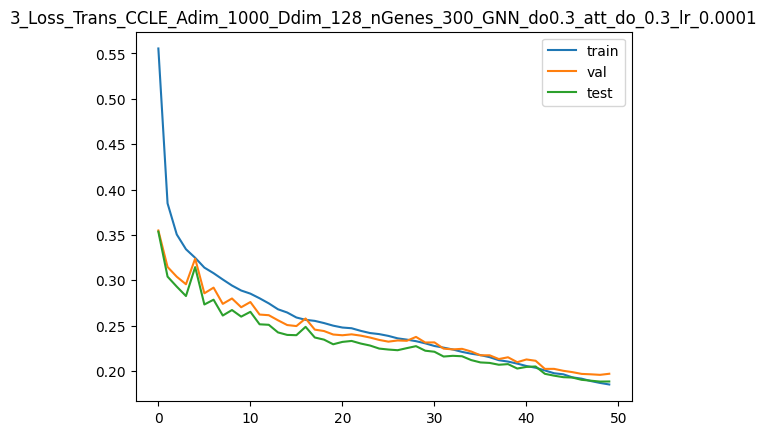

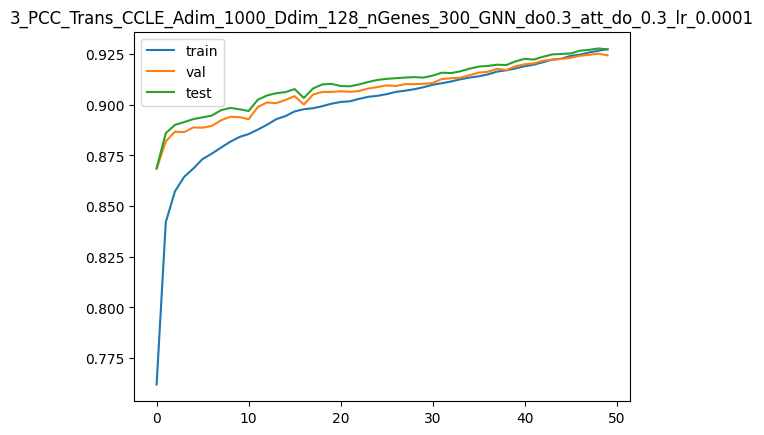

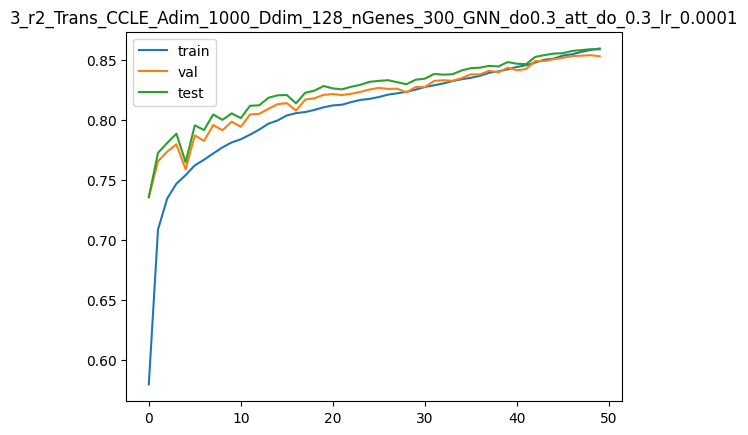

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18354763
Train avg_pcc:  0.9279806977925993
Train r2:  0.8611441694315204


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19074146
Validation avg_pcc:  0.9264525608149211
Validation r2:  0.8580897836534683
Best Val r2  0.8580897836534683


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18432833
Test avg_pcc:  0.9287257333697495
Test r2:  0.8623072289769081
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18065356
Train avg_pcc:  0.9291600275973605
Train r2:  0.8633335608629223


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19205397
Validation avg_pcc:  0.9268713085268746
Validation r2:  0.8571133005200676


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18671215
Test avg_pcc:  0.9288380728939103
Test r2:  0.8605265296620226
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17982052
Train avg_pcc:  0.9294981738807461
Train r2:  0.8639637594740869


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19084308
Validation avg_pcc:  0.9272084225729544
Validation r2:  0.8580141985604415


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18330792
Test avg_pcc:  0.9297564143951472
Test r2:  0.8630694726020431
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17793694
Train avg_pcc:  0.9302650730004324
Train r2:  0.8653887107553242


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18814039
Validation avg_pcc:  0.9275225695987637
Validation r2:  0.8600249573848715
Best Val r2  0.8600249573848715


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17998159
Test avg_pcc:  0.9304461816651197
Test r2:  0.865554249744413
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17554165
Train avg_pcc:  0.9312385579723903
Train r2:  0.8672007590362762


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18602759
Validation avg_pcc:  0.9287303494506244
Validation r2:  0.8615968672345484
Best Val r2  0.8615968672345484


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18059056
Test avg_pcc:  0.9306266878616235
Test r2:  0.8650993299333588
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17408952
Train avg_pcc:  0.9318280293102938
Train r2:  0.8682993138493845


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1850621
Validation avg_pcc:  0.9286313478825482
Validation r2:  0.8623152126254249
Best Val r2  0.8623152126254249


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17813246
Test avg_pcc:  0.9311130151302434
Test r2:  0.8669355314929424
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17253947
Train avg_pcc:  0.9324570337546334
Train r2:  0.8694719631893285


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18414256
Validation avg_pcc:  0.9290165806277882
Validation r2:  0.8629993166560745
Best Val r2  0.8629993166560745


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17723157
Test avg_pcc:  0.9314627834903194
Test r2:  0.8676085007798506
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1702762
Train avg_pcc:  0.9333735421680831
Train r2:  0.8711841484379421


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18507308
Validation avg_pcc:  0.9293875115902832
Validation r2:  0.8623070304233752


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1772006
Test avg_pcc:  0.9320246639526508
Test r2:  0.8676316149559146
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16960895
Train avg_pcc:  0.9336456802529267
Train r2:  0.8716889342123051


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18416946
Validation avg_pcc:  0.9302628100904661
Validation r2:  0.8629793075421726


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18014722
Test avg_pcc:  0.9316730331265387
Test r2:  0.8654305118983022
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16742949
Train avg_pcc:  0.9345279345815072
Train r2:  0.8733377096388413


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18182252
Validation avg_pcc:  0.9303296147304438
Validation r2:  0.8647254146500645
Best Val r2  0.8647254146500645


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17573248
Test avg_pcc:  0.9324736522390831
Test r2:  0.8687283137186483
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16560128
Train avg_pcc:  0.9352671332954254
Train r2:  0.8747207828127221


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18065636
Validation avg_pcc:  0.9307709474674318
Validation r2:  0.8655930381148125
Best Val r2  0.8655930381148125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17636605
Test avg_pcc:  0.932206389128424
Test r2:  0.8682550363047905
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16466235
Train avg_pcc:  0.93564711046371
Train r2:  0.8754311043587534


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1801023
Validation avg_pcc:  0.9306486221106628
Validation r2:  0.866005256881671
Best Val r2  0.866005256881671


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17323242
Test avg_pcc:  0.933113392745725
Test r2:  0.870595843244991
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16340888
Train avg_pcc:  0.9361528586966255
Train r2:  0.8763793471866321


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18043587
Validation avg_pcc:  0.9304980771533552
Validation r2:  0.8657570727170272


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17151631
Test avg_pcc:  0.9338559213800134
Test r2:  0.8718777742653208
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1614592
Train avg_pcc:  0.9369420689631313
Train r2:  0.8778542953746467


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17762941
Validation avg_pcc:  0.9315914994465218
Validation r2:  0.8678450675463717
Best Val r2  0.8678450675463717


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17155707
Test avg_pcc:  0.9337609774571001
Test r2:  0.871847319167639
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15995207
Train avg_pcc:  0.9375491345440601
Train r2:  0.8789944459481237


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17418523
Validation avg_pcc:  0.9330662459681692
Validation r2:  0.8704075039797321
Best Val r2  0.8704075039797321


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17243382
Test avg_pcc:  0.9334797461909917
Test r2:  0.8711923894095555
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15946169
Train avg_pcc:  0.93774640219055
Train r2:  0.8793654379161344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17482494
Validation avg_pcc:  0.9327190525961327
Validation r2:  0.8699315706976405


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16945854
Test avg_pcc:  0.9345783097049674
Test r2:  0.8734149269046204
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15767018
Train avg_pcc:  0.9384690236095908
Train r2:  0.8807207322476107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1774703
Validation avg_pcc:  0.9320506960076593
Validation r2:  0.8679634479224067


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17007247
Test avg_pcc:  0.9346300190874679
Test r2:  0.8729563175900207
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15565422
Train avg_pcc:  0.9392808000356276
Train r2:  0.8822458294782433


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17519084
Validation avg_pcc:  0.932667547454293
Validation r2:  0.8696593448754747


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17162243
Test avg_pcc:  0.9338884042263841
Test r2:  0.8717985173707878
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15432513
Train avg_pcc:  0.9398165624135981
Train r2:  0.8832513138982053


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1758552
Validation avg_pcc:  0.9332315005768189
Validation r2:  0.8691650638355042


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17090924
Test avg_pcc:  0.9349678742279866
Test r2:  0.8723312589897154
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15317431
Train avg_pcc:  0.9402792506247276
Train r2:  0.8841219071639363


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17493358
Validation avg_pcc:  0.9335172044100086
Validation r2:  0.8698507395263081


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17026241
Test avg_pcc:  0.9351908633507872
Test r2:  0.8728144424988711
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.151354
Train avg_pcc:  0.9410115771940025
Train r2:  0.8854990013474091


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17339773
Validation avg_pcc:  0.9333886723937894
Validation r2:  0.8709933995894241
Best Val r2  0.8709933995894241


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16972938
Test avg_pcc:  0.934618746851907
Test r2:  0.8732126026231344
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15106651
Train avg_pcc:  0.9411266540981318
Train r2:  0.8857164881921215


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17283317
Validation avg_pcc:  0.9336976243079959
Validation r2:  0.8714134293732374
Best Val r2  0.8714134293732374


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16923364
Test avg_pcc:  0.9349631712878399
Test r2:  0.8735829360881004
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14963394
Train avg_pcc:  0.9417032962700775
Train r2:  0.8868002537202295


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17151627
Validation avg_pcc:  0.9342060156896148
Validation r2:  0.8723931961119228
Best Val r2  0.8723931961119228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16710985
Test avg_pcc:  0.9356791902368561
Test r2:  0.8751693925009811
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14780748
Train avg_pcc:  0.9424362531075817
Train r2:  0.8881819830992194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17141598
Validation avg_pcc:  0.9341328955844875
Validation r2:  0.8724677989142187
Best Val r2  0.8724677989142187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16693373
Test avg_pcc:  0.9357181259527776
Test r2:  0.875300957682587
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14718854
Train avg_pcc:  0.9426849794701818
Train r2:  0.8886502237974351


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17233133
Validation avg_pcc:  0.934535054956206
Validation r2:  0.871786783620401


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16693194
Test avg_pcc:  0.936447834461209
Test r2:  0.8753022892397468
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14602375
Train avg_pcc:  0.9431516696049951
Train r2:  0.8895314025513772


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17230089
Validation avg_pcc:  0.9338876750792052
Validation r2:  0.8718094359351821


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16542804
Test avg_pcc:  0.9363045282791312
Test r2:  0.8764257055021862
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14487192
Train avg_pcc:  0.9436132936267385
Train r2:  0.8904027625059054


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17613801
Validation avg_pcc:  0.9345290684340205
Validation r2:  0.8689546565788345


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17126475
Test avg_pcc:  0.9363907265103918
Test r2:  0.8720656962419836
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14472932
Train avg_pcc:  0.9436702000840061
Train r2:  0.8905106473669296


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17006762
Validation avg_pcc:  0.9348947098676859
Validation r2:  0.8734709737105693
Best Val r2  0.8734709737105693


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16505355
Test avg_pcc:  0.9365038138040959
Test r2:  0.8767054423359265
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14325644
Train avg_pcc:  0.9442609903453657
Train r2:  0.8916248942338227


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16890252
Validation avg_pcc:  0.9352806415735988
Validation r2:  0.8743378101979217
Best Val r2  0.8743378101979217


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16500996
Test avg_pcc:  0.9365965508463129
Test r2:  0.8767380000099934
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14180328
Train avg_pcc:  0.9448430339984322
Train r2:  0.8927242363261785


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17206754
Validation avg_pcc:  0.9350807104323855
Validation r2:  0.8719830534822061


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16659677
Test avg_pcc:  0.9370822917111523
Test r2:  0.8755526524063751
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13995542
Train avg_pcc:  0.9455816380595032
Train r2:  0.8941221574490992


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1700858
Validation avg_pcc:  0.9356776953183724
Validation r2:  0.8734574482619909


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1650788
Test avg_pcc:  0.9373411832642868
Test r2:  0.8766865689934411
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13957487
Train avg_pcc:  0.9457344916031263
Train r2:  0.8944100417114531


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.166769
Validation avg_pcc:  0.9360074665980692
Validation r2:  0.8759251265893887
Best Val r2  0.8759251265893887


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16348429
Test avg_pcc:  0.9370695298910052
Test r2:  0.8778776722289403
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13876526
Train avg_pcc:  0.9460582953909439
Train r2:  0.8950225234534701


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16643238
Validation avg_pcc:  0.9363342811909277
Validation r2:  0.87617556172092
Best Val r2  0.87617556172092


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16273265
Test avg_pcc:  0.9375959852196853
Test r2:  0.878439146820248
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13719824
Train avg_pcc:  0.9466842095929293
Train r2:  0.8962079887823128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16553923
Validation avg_pcc:  0.9364031005999585
Validation r2:  0.8768400644649044
Best Val r2  0.8768400644649044


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16159783
Test avg_pcc:  0.9377231693560066
Test r2:  0.879286856919144
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13654442
Train avg_pcc:  0.9469461948855225
Train r2:  0.8967026119393481


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1644557
Validation avg_pcc:  0.9371278656771524
Validation r2:  0.8776462041517503
Best Val r2  0.8776462041517503


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16202828
Test avg_pcc:  0.9379551570426208
Test r2:  0.8789653080373355
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13555287
Train avg_pcc:  0.9473420856447043
Train r2:  0.8974527357788588


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1683073
Validation avg_pcc:  0.9360245312237226
Validation r2:  0.8747806479367979


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16345672
Test avg_pcc:  0.9378744551040546
Test r2:  0.87789825771319
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13416797
Train avg_pcc:  0.9478933043561941
Train r2:  0.898500419680723


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16624407
Validation avg_pcc:  0.9362324321871232
Validation r2:  0.8763156667695057


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16048303
Test avg_pcc:  0.9382072968642654
Test r2:  0.8801196078538305
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13440375
Train avg_pcc:  0.9478010948882255
Train r2:  0.8983220540498362


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16352214
Validation avg_pcc:  0.937224405374294
Validation r2:  0.8783407672109824
Best Val r2  0.8783407672109824


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15872772
Test avg_pcc:  0.9389252940466823
Test r2:  0.8814308180341976
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1331187
Train avg_pcc:  0.9483129448390449
Train r2:  0.89929421773764


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16626991
Validation avg_pcc:  0.9361094742181439
Validation r2:  0.8762964402402639


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16112453
Test avg_pcc:  0.9379349976480713
Test r2:  0.8796404027681497
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13163932
Train avg_pcc:  0.9489030415693417
Train r2:  0.9004133834010344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16423447
Validation avg_pcc:  0.937030726241291
Validation r2:  0.8778107943440756


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15937662
Test avg_pcc:  0.9387767532587993
Test r2:  0.8809461037220208
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1310683
Train avg_pcc:  0.949130482396013
Train r2:  0.9008453629867146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16463605
Validation avg_pcc:  0.9375257846068157
Validation r2:  0.8775120362799048


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16220991
Test avg_pcc:  0.9384715939192886
Test r2:  0.8788296371289146
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13033177
Train avg_pcc:  0.9494232041588201
Train r2:  0.9014025482256507


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16324812
Validation avg_pcc:  0.9375162582222859
Validation r2:  0.8785446401626998
Best Val r2  0.8785446401626998


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15825686
Test avg_pcc:  0.9391468930728443
Test r2:  0.8817825546115597
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1285683
Train avg_pcc:  0.9501258245234451
Train r2:  0.9027366332638525


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16548933
Validation avg_pcc:  0.9371001576064178
Validation r2:  0.8768771863105194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15969187
Test avg_pcc:  0.9391448861055361
Test r2:  0.8807105987085808
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12882447
Train avg_pcc:  0.950024240101681
Train r2:  0.9025428425252353


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16206147
Validation avg_pcc:  0.9380281928441435
Validation r2:  0.8794275011414653
Best Val r2  0.8794275011414653


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15802824
Test avg_pcc:  0.9393794563491401
Test r2:  0.8819533277805071
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12874794
Train avg_pcc:  0.9500548210808627
Train r2:  0.9026007453753464


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1627887
Validation avg_pcc:  0.9375127374482725
Validation r2:  0.8788864311425213


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15861559
Test avg_pcc:  0.9389321777565687
Test r2:  0.8815145875932496
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12681808
Train avg_pcc:  0.9508223702373233
Train r2:  0.9040607131370498


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16392916
Validation avg_pcc:  0.9379806194607105
Validation r2:  0.8780379396431748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16022213
Test avg_pcc:  0.9391758174691958
Test r2:  0.8803144950979325
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12555224
Train avg_pcc:  0.9513261145052937
Train r2:  0.9050183200158307


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16448957
Validation avg_pcc:  0.9376756374074935
Validation r2:  0.8776210045564206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1601952
Test avg_pcc:  0.9393768183744334
Test r2:  0.8803346096681637
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.124898545
Train avg_pcc:  0.9515856826717848
Train r2:  0.9055128522955801


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16150121
Validation avg_pcc:  0.938123256044615
Validation r2:  0.879844329975639
Best Val r2  0.879844329975639


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1569221
Test avg_pcc:  0.9397789126950669
Test r2:  0.882779618533954
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.124956354
Train avg_pcc:  0.9515631452778283
Train r2:  0.9054691112686853


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16412173
Validation avg_pcc:  0.9377121376133716
Validation r2:  0.877894673452666


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15819295
Test avg_pcc:  0.939872299887918
Test r2:  0.8818302995797471
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.123635925
Train avg_pcc:  0.9520872212889344
Train r2:  0.9064680435780703


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16183186
Validation avg_pcc:  0.9380611342519007
Validation r2:  0.8795983258963848


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15753232
Test avg_pcc:  0.9394295619513683
Test r2:  0.8823237728479839


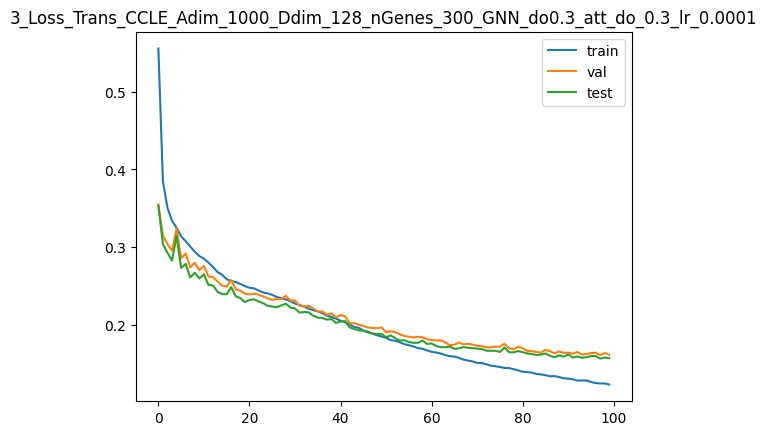

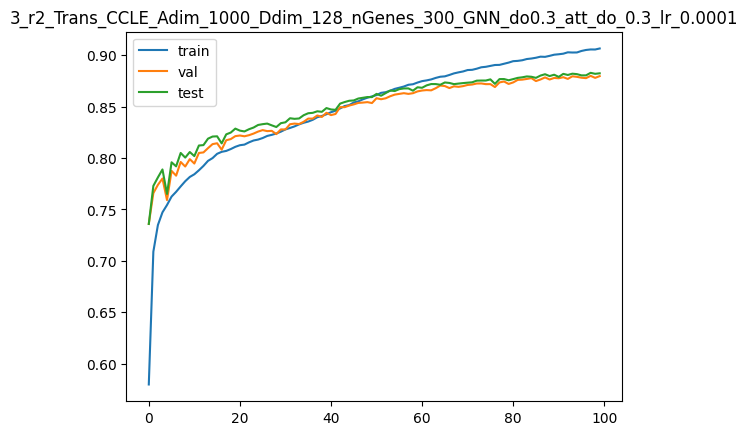

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12278101
Train avg_pcc:  0.9524280667410568
Train r2:  0.9071147901046609


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16113666
Validation avg_pcc:  0.9386125921565758
Validation r2:  0.8801155416947372
Best Val r2  0.8801155416947372


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15630002
Test avg_pcc:  0.9403806079317653
Test r2:  0.8832442995934014
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.122068785
Train avg_pcc:  0.9527101011461024
Train r2:  0.9076536046183354


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16004837
Validation avg_pcc:  0.9386191309009683
Validation r2:  0.8809252286132434
Best Val r2  0.8809252286132434


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15793546
Test avg_pcc:  0.939250390762011
Test r2:  0.8820226406015483
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12193539
Train avg_pcc:  0.9527630688403068
Train r2:  0.9077544983234596


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16383556
Validation avg_pcc:  0.9381847600300665
Validation r2:  0.8781075923311465


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15920196
Test avg_pcc:  0.9397526600780665
Test r2:  0.8810765661500259
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12012147
Train avg_pcc:  0.9534832232986297
Train r2:  0.9091267576212295


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15946057
Validation avg_pcc:  0.9391507670836345
Validation r2:  0.8813625442751213
Best Val r2  0.8813625442751213


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15586984
Test avg_pcc:  0.9404518701800357
Test r2:  0.8835656432868476
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12018911
Train avg_pcc:  0.9534559112914467
Train r2:  0.9090755832132413


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15881735
Validation avg_pcc:  0.9392074865228593
Validation r2:  0.881841099708699
Best Val r2  0.881841099708699


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15433653
Test avg_pcc:  0.9406482857328571
Test r2:  0.8847110241758478
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11928552
Train avg_pcc:  0.9538143473325981
Train r2:  0.9097591701649814


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16116494
Validation avg_pcc:  0.9384621357577342
Validation r2:  0.8800945080778702


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15568464
Test avg_pcc:  0.9404184601605803
Test r2:  0.8837040003143903
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.118672505
Train avg_pcc:  0.9540576138544378
Train r2:  0.910222917131103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16130608
Validation avg_pcc:  0.9389121341402046
Validation r2:  0.8799894989836945


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15757102
Test avg_pcc:  0.9402707673691907
Test r2:  0.8822948648153682
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.117488526
Train avg_pcc:  0.9545265182658009
Train r2:  0.9111186090944927


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16132747
Validation avg_pcc:  0.938435793573033
Validation r2:  0.8799735798078183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15700959
Test avg_pcc:  0.9399567965725368
Test r2:  0.882714267047753
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11714476
Train avg_pcc:  0.9546631800609184
Train r2:  0.9113786682953875


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16442657
Validation avg_pcc:  0.938995429096989
Validation r2:  0.8776678682105222


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1608809
Test avg_pcc:  0.9401615351338278
Test r2:  0.8798224060266739
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11611848
Train avg_pcc:  0.9550697431226685
Train r2:  0.9121550662818672


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1589042
Validation avg_pcc:  0.9390749941406826
Validation r2:  0.8817764823538903


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15388568
Test avg_pcc:  0.9409014437931258
Test r2:  0.8850478036128236
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.115716994
Train avg_pcc:  0.9552287444583637
Train r2:  0.9124587961574475


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16129294
Validation avg_pcc:  0.9389590285565456
Validation r2:  0.8799992809549814


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15627968
Test avg_pcc:  0.9408367583159645
Test r2:  0.8832594977128532
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11530653
Train avg_pcc:  0.9553910448864001
Train r2:  0.9127693170585734


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16073228
Validation avg_pcc:  0.9393377661540119
Validation r2:  0.8804164050980046


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1565538
Test avg_pcc:  0.9407608795101173
Test r2:  0.8830547299673102
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11491327
Train avg_pcc:  0.9555466825191138
Train r2:  0.9130668131419659


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16313612
Validation avg_pcc:  0.9395684198395011
Validation r2:  0.8786279505272601


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15885921
Test avg_pcc:  0.9409888423219402
Test r2:  0.8813325871147795
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11357016
Train avg_pcc:  0.956078440887111
Train r2:  0.9140828954735006


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15758753
Validation avg_pcc:  0.9396189674782357
Validation r2:  0.8827560753454599
Best Val r2  0.8827560753454599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15275943
Test avg_pcc:  0.9413492918737534
Test r2:  0.8858891154268594
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11340473
Train avg_pcc:  0.9561439574130179
Train r2:  0.9142080524788331


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15631707
Validation avg_pcc:  0.9402109099540168
Validation r2:  0.8837012820752305
Best Val r2  0.8837012820752305


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1526492
Test avg_pcc:  0.9415194390680728
Test r2:  0.885971461968253
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.112463415
Train avg_pcc:  0.956515709297132
Train r2:  0.9149201656138661


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1577205
Validation avg_pcc:  0.939595243285607
Validation r2:  0.8826571301998827


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1538924
Test avg_pcc:  0.9409554439674229
Test r2:  0.885042788367547
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.111863144
Train avg_pcc:  0.9567534458485781
Train r2:  0.9153742791259225


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15954265
Validation avg_pcc:  0.9390443676488173
Validation r2:  0.8813014748676896


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1546765
Test avg_pcc:  0.9407509900582535
Test r2:  0.8844570701868788
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11193543
Train avg_pcc:  0.9567243330312246
Train r2:  0.9153195913014668


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15868525
Validation avg_pcc:  0.9400829333335611
Validation r2:  0.881939369612223


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.156194
Test avg_pcc:  0.9410325980977889
Test r2:  0.8833234982230531
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.110979214
Train avg_pcc:  0.9571029013256273
Train r2:  0.916042977123142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15587045
Validation avg_pcc:  0.9403342998112347
Validation r2:  0.8840335557264567
Best Val r2  0.8840335557264567


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1529459
Test avg_pcc:  0.9413160231681824
Test r2:  0.8857498230188185
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11030375
Train avg_pcc:  0.9573694763053275
Train r2:  0.9165539827405064


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15653856
Validation avg_pcc:  0.9402426759218098
Validation r2:  0.8835364926014829


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15330087
Test avg_pcc:  0.9415005902347933
Test r2:  0.8854846650486996
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.110267535
Train avg_pcc:  0.9573842225221956
Train r2:  0.9165813724701972


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15954691
Validation avg_pcc:  0.9388511311213695
Validation r2:  0.8812983158397047


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15425016
Test avg_pcc:  0.9407837049023814
Test r2:  0.8847755436668442
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10871482
Train avg_pcc:  0.9579972980982507
Train r2:  0.9177560289758204


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15801047
Validation avg_pcc:  0.9396057843502944
Validation r2:  0.8824414075110243


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15505587
Test avg_pcc:  0.9406215241036311
Test r2:  0.8841736784999604
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10870832
Train avg_pcc:  0.9580001749372438
Train r2:  0.917760939653402


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15687306
Validation avg_pcc:  0.9401468892546208
Validation r2:  0.8832876415749187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15302615
Test avg_pcc:  0.941550821983274
Test r2:  0.8856898858034322
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1086772
Train avg_pcc:  0.9580118091504687
Train r2:  0.9177844722178026


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15726729
Validation avg_pcc:  0.9404805999026802
Validation r2:  0.8829943383173876


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15528366
Test avg_pcc:  0.9412538094861088
Test r2:  0.8840035262004632
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10691484
Train avg_pcc:  0.9587076044210522
Train r2:  0.9191177285385494


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15565957
Validation avg_pcc:  0.9405325924298341
Validation r2:  0.8841904529390142
Best Val r2  0.8841904529390142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15296835
Test avg_pcc:  0.9414003570499961
Test r2:  0.885733058727036
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10698556
Train avg_pcc:  0.958679868620436
Train r2:  0.9190642186898759


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15585034
Validation avg_pcc:  0.9407888386962427
Validation r2:  0.8840485254237229


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15316455
Test avg_pcc:  0.9417594309101263
Test r2:  0.8855864875945313
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10688753
Train avg_pcc:  0.9587184268839508
Train r2:  0.9191383824715307


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15925229
Validation avg_pcc:  0.9401648411967539
Validation r2:  0.8815174920651295


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15593112
Test avg_pcc:  0.9414323305954866
Test r2:  0.8835198827473794
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.105969615
Train avg_pcc:  0.9590806544613216
Train r2:  0.9198327974088637


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16120952
Validation avg_pcc:  0.9399445906363026
Validation r2:  0.8800613220928206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15720083
Test avg_pcc:  0.9414213514625691
Test r2:  0.8825713939408918
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10540908
Train avg_pcc:  0.9593015948251052
Train r2:  0.9202568491590583


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15687872
Validation avg_pcc:  0.9402285314267785
Validation r2:  0.8832834155042911


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1536073
Test avg_pcc:  0.9413633374163607
Test r2:  0.8852557583594065
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.104833305
Train avg_pcc:  0.9595288373597802
Train r2:  0.920692425386717


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15769874
Validation avg_pcc:  0.94069018974878
Validation r2:  0.8826733357721455


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15401536
Test avg_pcc:  0.9420622633223285
Test r2:  0.884950934229705
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10411784
Train avg_pcc:  0.9598101672504028
Train r2:  0.9212336875148364


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15549026
Validation avg_pcc:  0.9404178985014311
Validation r2:  0.8843164169969673
Best Val r2  0.8843164169969673


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15204298
Test avg_pcc:  0.941514519625352
Test r2:  0.8864242909254773
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.104204886
Train avg_pcc:  0.9597760732276273
Train r2:  0.92116783330432


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15443583
Validation avg_pcc:  0.9408785429018428
Validation r2:  0.8851009049007611
Best Val r2  0.8851009049007611


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15091157
Test avg_pcc:  0.9420833231327965
Test r2:  0.8872694629972989
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10286246
Train avg_pcc:  0.960304921486135
Train r2:  0.9221833961212559


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15536885
Validation avg_pcc:  0.9407346883287253
Validation r2:  0.8844067459124298


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15101632
Test avg_pcc:  0.9422872924620633
Test r2:  0.8871912014452147
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10285824
Train avg_pcc:  0.9603069530986802
Train r2:  0.9221865856167313


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15596156
Validation avg_pcc:  0.9404818588298018
Validation r2:  0.8839657767896206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15245613
Test avg_pcc:  0.9417653068802505
Test r2:  0.8861156822232027
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10295549
Train avg_pcc:  0.9602690475487844
Train r2:  0.9221130207680002


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15560172
Validation avg_pcc:  0.940360057701732
Validation r2:  0.8842334915777187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15137401
Test avg_pcc:  0.9418585331059627
Test r2:  0.8869240216736218
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10293878
Train avg_pcc:  0.9602749879660234
Train r2:  0.9221256556447771


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15631706
Validation avg_pcc:  0.9401967020270873
Validation r2:  0.883701301637794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1500209
Test avg_pcc:  0.942461380883887
Test r2:  0.8879347931224368
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10125034
Train avg_pcc:  0.9609401604592749
Train r2:  0.9234029792034054


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1564708
Validation avg_pcc:  0.9401132608434071
Validation r2:  0.8835869123224299


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15089922
Test avg_pcc:  0.9421553669548872
Test r2:  0.8872786924441196
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10103562
Train avg_pcc:  0.9610245674217055
Train r2:  0.9235654200781658


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15584342
Validation avg_pcc:  0.9405057460693185
Validation r2:  0.8840536664975408


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15177926
Test avg_pcc:  0.9420216236856997
Test r2:  0.8866213084465959
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10067424
Train avg_pcc:  0.9611666825768097
Train r2:  0.9238388102321161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15525427
Validation avg_pcc:  0.9407548098717612
Validation r2:  0.884491992280433


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1525293
Test avg_pcc:  0.9416610778271434
Test r2:  0.8860610193920282
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10001615
Train avg_pcc:  0.9614256154167753
Train r2:  0.9243366599108626


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15587562
Validation avg_pcc:  0.9405351612005685
Validation r2:  0.8840297169796167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15185529
Test avg_pcc:  0.94207705775141
Test r2:  0.886564496286534
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.099526495
Train avg_pcc:  0.961618207926908
Train r2:  0.9247070928929784


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15765904
Validation avg_pcc:  0.9401298241526324
Validation r2:  0.8827028819430152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15329088
Test avg_pcc:  0.9417277109541452
Test r2:  0.8854921210754626
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09947185
Train avg_pcc:  0.9616398440618639
Train r2:  0.9247484356087997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1576166
Validation avg_pcc:  0.9401152359289094
Validation r2:  0.8827344359925627


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15354456
Test avg_pcc:  0.9416809008169073
Test r2:  0.885302630457835
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.099261254
Train avg_pcc:  0.9617225666593692
Train r2:  0.9249077467428151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15503338
Validation avg_pcc:  0.9411003633207791
Validation r2:  0.8846563359808235


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15225528
Test avg_pcc:  0.9420685396742857
Test r2:  0.886265707922382
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0984641
Train avg_pcc:  0.9620361244188944
Train r2:  0.9255107972241204


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15624805
Validation avg_pcc:  0.9406767132424251
Validation r2:  0.8837526243620203


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15140532
Test avg_pcc:  0.9424701900137632
Test r2:  0.8869006323687778
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.097998165
Train avg_pcc:  0.962219036795607
Train r2:  0.925863291320714


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15444261
Validation avg_pcc:  0.941013860830046
Validation r2:  0.885095867130806


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14883232
Test avg_pcc:  0.9430072898448055
Test r2:  0.8888226617580327
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0977032
Train avg_pcc:  0.9623351754262668
Train r2:  0.9260864275990477


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15510486
Validation avg_pcc:  0.9410776736736017
Validation r2:  0.8846031573165102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15291674
Test avg_pcc:  0.941853422031105
Test r2:  0.8857715976273566
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09659509
Train avg_pcc:  0.9627708557686279
Train r2:  0.9269247335890739


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15737675
Validation avg_pcc:  0.9404851668931233
Validation r2:  0.8829129023838315


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15390585
Test avg_pcc:  0.9417970553823773
Test r2:  0.8850327453140028
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.096898876
Train avg_pcc:  0.9626514818309859
Train r2:  0.9266949144300871


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15414895
Validation avg_pcc:  0.941046970990005
Validation r2:  0.8853143495037555
Best Val r2  0.8853143495037555


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15063511
Test avg_pcc:  0.9422715040537097
Test r2:  0.887475967404476
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09645347
Train avg_pcc:  0.962826250596776
Train r2:  0.9270318700553748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15630664
Validation avg_pcc:  0.9409123170669907
Validation r2:  0.8837090446372742


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15314838
Test avg_pcc:  0.9420826936907226
Test r2:  0.8855985728148873
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09586235
Train avg_pcc:  0.9630580846224838
Train r2:  0.9274790539925309


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15530099
Validation avg_pcc:  0.9405284411570619
Validation r2:  0.8844572282874611


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14953887
Test avg_pcc:  0.942612922538717
Test r2:  0.8882948528978699


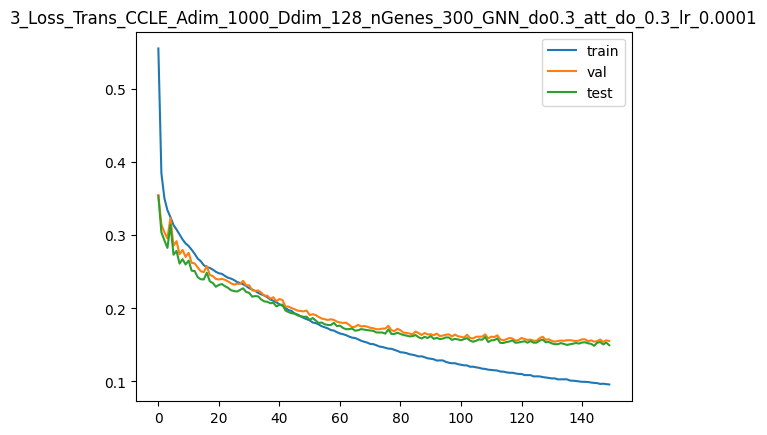

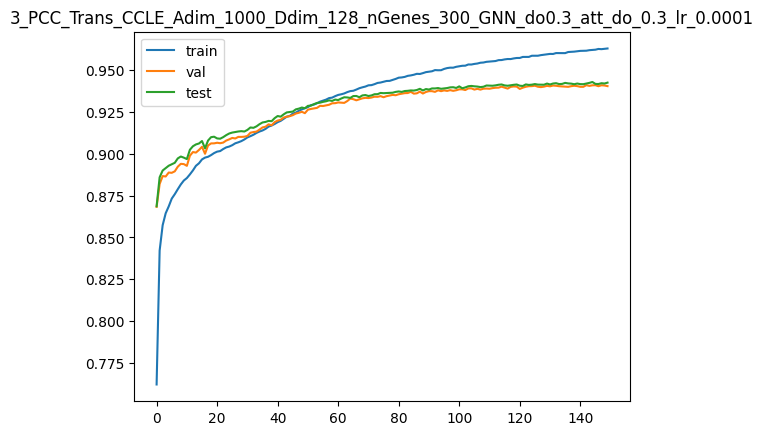

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15063512
Test avg_pcc:  0.9422715042700901
Test r2:  0.8874759680359422


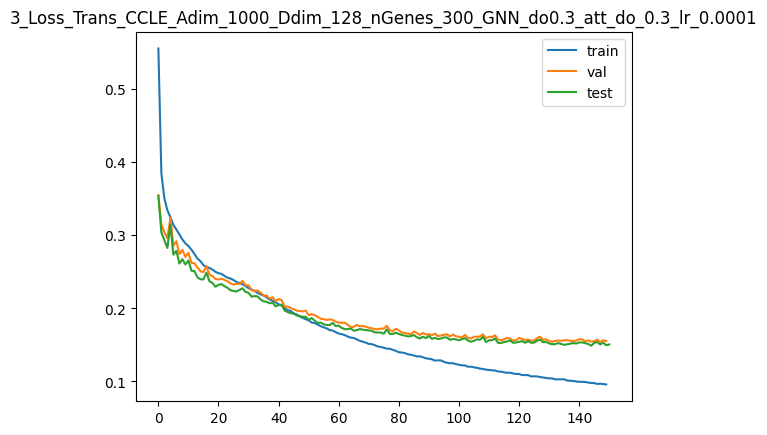

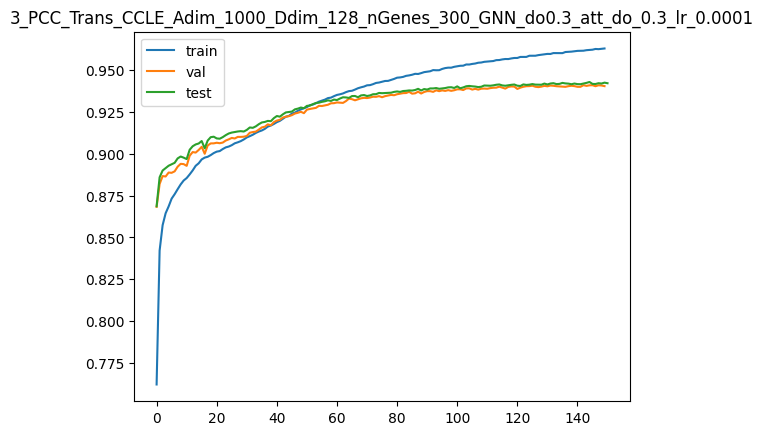

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.55929136
Train avg_pcc:  0.7607824673968862
Train r2:  0.5779821707100781


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.33842084
Validation avg_pcc:  0.8727214172408635
Validation r2:  0.7453247936051755
Best Val r2  0.7453247936051755


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.34713203
Test avg_pcc:  0.8691191876191683
Test r2:  0.7383250082948453
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.38444394
Train avg_pcc:  0.8427628798763522
Train r2:  0.709914712804715


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.35692674
Validation avg_pcc:  0.8835913434596401
Validation r2:  0.7313983629721397


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3693384
Test avg_pcc:  0.879555550915578
Test r2:  0.7215854224416036
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.35082707
Train avg_pcc:  0.8575923537508198
Train r2:  0.7352806103782588


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3084497
Validation avg_pcc:  0.8874791659671518
Validation r2:  0.7678793208806706
Best Val r2  0.7678793208806706


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32196152
Test avg_pcc:  0.8824172604958044
Test r2:  0.7572990555371677
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3350682
Train avg_pcc:  0.8644698632490424
Train r2:  0.7471716250548287


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29978403
Validation avg_pcc:  0.8898622283044652
Validation r2:  0.7744005549649715
Best Val r2  0.7744005549649715


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3140477
Test avg_pcc:  0.8844349296848467
Test r2:  0.7632646284686305
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3218698
Train avg_pcc:  0.8701799790546387
Train r2:  0.7571305544447247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28117532
Validation avg_pcc:  0.8908111674657229
Validation r2:  0.7884043441721331
Best Val r2  0.7884043441721331


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29473206
Test avg_pcc:  0.8854244319652324
Test r2:  0.7778251338930585
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.31475896
Train avg_pcc:  0.8732470921638515
Train r2:  0.7624961131728302


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29323727
Validation avg_pcc:  0.8911357851545001
Validation r2:  0.7793272380616993


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3076689
Test avg_pcc:  0.8855633469538114
Test r2:  0.768073095981599
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3076132
Train avg_pcc:  0.8763169364769967
Train r2:  0.7678879794685765


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27585045
Validation avg_pcc:  0.8945608659766678
Validation r2:  0.7924115174908308
Best Val r2  0.7924115174908308


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29242522
Test avg_pcc:  0.8879398078335826
Test r2:  0.7795640803635044
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.30086592
Train avg_pcc:  0.8792082040195357
Train r2:  0.7729792170748376


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27065936
Validation avg_pcc:  0.8937110595991543
Validation r2:  0.7963180179154196
Best Val r2  0.7963180179154196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2847237
Test avg_pcc:  0.887807482564418
Test r2:  0.7853696526194918
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29523408
Train avg_pcc:  0.8816172998880841
Train r2:  0.7772287547099886


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2627857
Validation avg_pcc:  0.895969612210348
Validation r2:  0.802243258125344
Best Val r2  0.802243258125344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2780557
Test avg_pcc:  0.8893934121862882
Test r2:  0.7903961112024301
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29017222
Train avg_pcc:  0.883779251830446
Train r2:  0.7810482050814928


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26419848
Validation avg_pcc:  0.896266852956914
Validation r2:  0.8011800829477191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27903003
Test avg_pcc:  0.8901273204278548
Test r2:  0.7896616574443336
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2860629
Train avg_pcc:  0.8855290478247795
Train r2:  0.7841489432393114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26639682
Validation avg_pcc:  0.897015622430587
Validation r2:  0.7995257463486339


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28102365
Test avg_pcc:  0.8909084718394816
Test r2:  0.7881588238898735
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2831568
Train avg_pcc:  0.886768007141708
Train r2:  0.7863417478340309


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26065466
Validation avg_pcc:  0.8992852196388373
Validation r2:  0.8038469540158995
Best Val r2  0.8038469540158995


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27529958
Test avg_pcc:  0.893305333683329
Test r2:  0.7924737610029355
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.27719992
Train avg_pcc:  0.889295945429942
Train r2:  0.7908365655088541


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25774208
Validation avg_pcc:  0.8984300239024336
Validation r2:  0.8060387771179405
Best Val r2  0.8060387771179405


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2728353
Test avg_pcc:  0.8920606937286008
Test r2:  0.7943313275799121
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2711799
Train avg_pcc:  0.8918471502564184
Train r2:  0.7953790077192138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24909084
Validation avg_pcc:  0.9021995763593935
Validation r2:  0.8125492055555057
Best Val r2  0.8125492055555057


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2634618
Test avg_pcc:  0.8957390958554255
Test r2:  0.8013972952134127
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26567814
Train avg_pcc:  0.8941716775938928
Train r2:  0.7995303910587511


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24991867
Validation avg_pcc:  0.904868141370577
Validation r2:  0.8119262179898004


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26816994
Test avg_pcc:  0.8977840364818859
Test r2:  0.7978481981849211
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2617429
Train avg_pcc:  0.8958284937452473
Train r2:  0.8024997886561847


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24581558
Validation avg_pcc:  0.9042925591016925
Validation r2:  0.815013954736013
Best Val r2  0.815013954736013


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25742802
Test avg_pcc:  0.8991204266436946
Test r2:  0.8059456781621469
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2562186
Train avg_pcc:  0.8981519064008859
Train r2:  0.8066681816685589


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23994257
Validation avg_pcc:  0.9063385952525808
Validation r2:  0.8194336532328464
Best Val r2  0.8194336532328464


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25348446
Test avg_pcc:  0.9008168377431259
Test r2:  0.8089184066319496
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25331718
Train avg_pcc:  0.899370491660845
Train r2:  0.8088574798136755


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23692733
Validation avg_pcc:  0.9076579632637626
Validation r2:  0.8217027231900387
Best Val r2  0.8217027231900387


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2508244
Test avg_pcc:  0.9017520361992395
Test r2:  0.8109236375491186
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25088525
Train avg_pcc:  0.9003886062011596
Train r2:  0.8106925065576497


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23781864
Validation avg_pcc:  0.9073307479863341
Validation r2:  0.8210319818180171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24880429
Test avg_pcc:  0.9025442702957329
Test r2:  0.8124464174161041
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24830744
Train avg_pcc:  0.9014701956047607
Train r2:  0.8126376395641683


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23310906
Validation avg_pcc:  0.9082579295207681
Validation r2:  0.824576140069634
Best Val r2  0.824576140069634


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24546763
Test avg_pcc:  0.902928593831618
Test r2:  0.8149616510554902
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24622631
Train avg_pcc:  0.902338711348247
Train r2:  0.8142079490750117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2332587
Validation avg_pcc:  0.9083942646829349
Validation r2:  0.8244635089827033


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24502
Test avg_pcc:  0.9034757253582175
Test r2:  0.8152990647637517
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24365778
Train avg_pcc:  0.9034123640475675
Train r2:  0.8161460584016972


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23669149
Validation avg_pcc:  0.9093111157342749
Validation r2:  0.8218801967879632


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24969937
Test avg_pcc:  0.9040569961265191
Test r2:  0.8117716640395503
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24242803
Train avg_pcc:  0.9039257442829332
Train r2:  0.8170739709956567


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2299148
Validation avg_pcc:  0.9095943258149848
Validation r2:  0.8269799395582456
Best Val r2  0.8269799395582456


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24240488
Test avg_pcc:  0.9043676713462104
Test r2:  0.817270421143679
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24016498
Train avg_pcc:  0.9048687683149633
Train r2:  0.8187815640534577


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22913131
Validation avg_pcc:  0.9098132126187213
Validation r2:  0.8275695291423607
Best Val r2  0.8275695291423607


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24278133
Test avg_pcc:  0.9039163808576509
Test r2:  0.816986650539059
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2372588
Train avg_pcc:  0.9060806327578652
Train r2:  0.8209744690086389


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2270793
Validation avg_pcc:  0.9106088573597642
Validation r2:  0.829113763660249
Best Val r2  0.829113763660249


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2403332
Test avg_pcc:  0.9050285020289619
Test r2:  0.8188320820757572
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23440978
Train avg_pcc:  0.9072648049245775
Train r2:  0.8231242233350142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2288018
Validation avg_pcc:  0.9106647605683869
Validation r2:  0.8278175099481816


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23934795
Test avg_pcc:  0.9059802243285913
Test r2:  0.8195747745154245
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23397416
Train avg_pcc:  0.9074459281404984
Train r2:  0.823452910202505


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22361358
Validation avg_pcc:  0.9123886677547612
Validation r2:  0.8317218585212673
Best Val r2  0.8317218585212673


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23590523
Test avg_pcc:  0.9069651814679942
Test r2:  0.8221699600199903
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23038429
Train avg_pcc:  0.9089379112483987
Train r2:  0.8261616900644125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22197519
Validation avg_pcc:  0.9128119528915944
Validation r2:  0.8329548035602867
Best Val r2  0.8329548035602867


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23361516
Test avg_pcc:  0.9079760349644945
Test r2:  0.8238962741448487
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22769666
Train avg_pcc:  0.9100516092280435
Train r2:  0.8281896314742196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21763986
Validation avg_pcc:  0.9146301246957405
Validation r2:  0.8362173143034091
Best Val r2  0.8362173143034091


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2297323
Test avg_pcc:  0.9093948711223769
Test r2:  0.8268232498308676
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22526096
Train avg_pcc:  0.9110614381299832
Train r2:  0.8300275219544871


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22411299
Validation avg_pcc:  0.9146506977283692
Validation r2:  0.8313460351996724


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23673457
Test avg_pcc:  0.9098585259798323
Test r2:  0.8215447948511028
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2231306
Train avg_pcc:  0.9119431184783787
Train r2:  0.8316350117456688


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21952699
Validation avg_pcc:  0.9145512714170225
Validation r2:  0.8347971773613589


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23009156
Test avg_pcc:  0.9097557019538639
Test r2:  0.8265524407927503
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2208359
Train avg_pcc:  0.9128934975673523
Train r2:  0.8333664979163422


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21556403
Validation avg_pcc:  0.9157058490604952
Validation r2:  0.8377794552820066
Best Val r2  0.8377794552820066


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22885647
Test avg_pcc:  0.9099286143852374
Test r2:  0.8274834665492228
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21699178
Train avg_pcc:  0.9144789657301581
Train r2:  0.8362670916797973


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21218176
Validation avg_pcc:  0.917345745538306
Validation r2:  0.840324756115585
Best Val r2  0.840324756115585


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2258347
Test avg_pcc:  0.9117758777011115
Test r2:  0.8297613438710526
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2152733
Train avg_pcc:  0.9151884573720014
Train r2:  0.8375637847704438


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20826253
Validation avg_pcc:  0.918378316100732
Validation r2:  0.843274126548843
Best Val r2  0.843274126548843


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2217187
Test avg_pcc:  0.9127839799762746
Test r2:  0.8328640598047716
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21160483
Train avg_pcc:  0.9167000070161149
Train r2:  0.8403318773732247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21020044
Validation avg_pcc:  0.918480182909404
Validation r2:  0.8418157714668091


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22374631
Test avg_pcc:  0.9131634274241448
Test r2:  0.8313356235205325
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20989968
Train avg_pcc:  0.9174002345187943
Train r2:  0.8416185193051299


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2114323
Validation avg_pcc:  0.9197455075520947
Validation r2:  0.8408887509108057


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22642873
Test avg_pcc:  0.9138842587182032
Test r2:  0.8293135488435118
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2071749
Train avg_pcc:  0.9185206043263702
Train r2:  0.8436745188044352


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20529725
Validation avg_pcc:  0.9198201023033602
Validation r2:  0.8455056148347064
Best Val r2  0.8455056148347064


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2170462
Test avg_pcc:  0.9150119540931351
Test r2:  0.8363862926697635
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20559473
Train avg_pcc:  0.9191684634245157
Train r2:  0.8448668427892775


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19960265
Validation avg_pcc:  0.9218904912745463
Validation r2:  0.8497910369936346
Best Val r2  0.8497910369936346


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21351242
Test avg_pcc:  0.9160358924555689
Test r2:  0.8390501206286545
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20115429
Train avg_pcc:  0.9209917234103918
Train r2:  0.8482174117621044


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20148674
Validation avg_pcc:  0.9213625271947312
Validation r2:  0.8483731739899771


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21355131
Test avg_pcc:  0.9163979862700562
Test r2:  0.8390208038316046
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19940197
Train avg_pcc:  0.9217071379793267
Train r2:  0.8495396199030201


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19824289
Validation avg_pcc:  0.922843757924009
Validation r2:  0.8508143180893674
Best Val r2  0.8508143180893674


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.210117
Test avg_pcc:  0.9177063652120325
Test r2:  0.8416096565540843
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19796167
Train avg_pcc:  0.9222960131906655
Train r2:  0.8506264272823457


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19685684
Validation avg_pcc:  0.92375850227681
Validation r2:  0.8518573686694901
Best Val r2  0.8518573686694901


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21050328
Test avg_pcc:  0.918007927491384
Test r2:  0.8413184620829154
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19421865
Train avg_pcc:  0.9238288013314059
Train r2:  0.8534507606622861


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19362919
Validation avg_pcc:  0.9248614438908097
Validation r2:  0.8542863181350937
Best Val r2  0.8542863181350937


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20891732
Test avg_pcc:  0.9185526871117907
Test r2:  0.8425139910890513
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19131748
Train avg_pcc:  0.9250093021014927
Train r2:  0.8556398610735634


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19288675
Validation avg_pcc:  0.924652434263287
Validation r2:  0.854845004296797
Best Val r2  0.854845004296797


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20607488
Test avg_pcc:  0.9191842982154208
Test r2:  0.8446566766888277
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19031946
Train avg_pcc:  0.925417387923859
Train r2:  0.8563929158731675


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1952054
Validation avg_pcc:  0.9249116140601575
Validation r2:  0.8531001390391361


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20986767
Test avg_pcc:  0.9191419629177485
Test r2:  0.841797603008574
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18775395
Train avg_pcc:  0.9264637891077665
Train r2:  0.8583287558591982


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19219065
Validation avg_pcc:  0.925292633676512
Validation r2:  0.8553688562958344
Best Val r2  0.8553688562958344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20466504
Test avg_pcc:  0.9200963983436745
Test r2:  0.8457194633662406
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18551354
Train avg_pcc:  0.9273739040120419
Train r2:  0.8600192582565084


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1928379
Validation avg_pcc:  0.9260553886189844
Validation r2:  0.8548817904347112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2061199
Test avg_pcc:  0.9206891597430567
Test r2:  0.8446227379569042
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18348259
Train avg_pcc:  0.9282004999940145
Train r2:  0.8615517490550733


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18988748
Validation avg_pcc:  0.9265228525164675
Validation r2:  0.8571020867493732
Best Val r2  0.8571020867493732


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20302893
Test avg_pcc:  0.9212129942442839
Test r2:  0.8469527753321046
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18186648
Train avg_pcc:  0.9288574709015496
Train r2:  0.8627711711044389


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18878515
Validation avg_pcc:  0.927232319921271
Validation r2:  0.857931636526588
Best Val r2  0.857931636526588


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20210093
Test avg_pcc:  0.9219105781311113
Test r2:  0.8476523343451505
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17988333
Train avg_pcc:  0.9296619396318928
Train r2:  0.864267601183597


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18749148
Validation avg_pcc:  0.9271763217725263
Validation r2:  0.8589051777071525
Best Val r2  0.8589051777071525


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20001997
Test avg_pcc:  0.9220851630531074
Test r2:  0.8492210010039012
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17916332
Train avg_pcc:  0.9299548766107174
Train r2:  0.864810878759603


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18632269
Validation avg_pcc:  0.9277206369382155
Validation r2:  0.8597847418106772
Best Val r2  0.8597847418106772


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2003134
Test avg_pcc:  0.9220997828833186
Test r2:  0.8489997904376662


#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1771292
Train avg_pcc:  0.9307786542396036
Train r2:  0.8663457386145287


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18438824
Validation avg_pcc:  0.9284027741913395
Validation r2:  0.8612404920524416
Best Val r2  0.8612404920524416


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19763905
Test avg_pcc:  0.9230014803102504
Test r2:  0.8510157737462026
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17443064
Train avg_pcc:  0.9318724677085148
Train r2:  0.8683819619721701


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18745065
Validation avg_pcc:  0.9294058117542353
Validation r2:  0.8589359013050889


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20208734
Test avg_pcc:  0.9230130267162442
Test r2:  0.8476625723715439
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17354114
Train avg_pcc:  0.9322321935673517
Train r2:  0.8690531289184373


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18234052
Validation avg_pcc:  0.9295678241018541
Validation r2:  0.8627814718700926
Best Val r2  0.8627814718700926


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19467455
Test avg_pcc:  0.9242293340269652
Test r2:  0.853250473695095
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17116062
Train avg_pcc:  0.9331944404256436
Train r2:  0.8708493762410404


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17882043
Validation avg_pcc:  0.9303620387955603
Validation r2:  0.8654304840112111
Best Val r2  0.8654304840112111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19462915
Test avg_pcc:  0.9238113000591877
Test r2:  0.8532846914396521
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16941023
Train avg_pcc:  0.9339025431053463
Train r2:  0.8721701433351747


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17842205
Validation avg_pcc:  0.9304888954545912
Validation r2:  0.8657302744545747
Best Val r2  0.8657302744545747


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19209804
Test avg_pcc:  0.9247978581360615
Test r2:  0.85519271486509
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16853331
Train avg_pcc:  0.9342573635585635
Train r2:  0.8728318457916002


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17949641
Validation avg_pcc:  0.9300740804517601
Validation r2:  0.8649217890536298


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19411089
Test avg_pcc:  0.9240637782074489
Test r2:  0.8536753800003979
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16636264
Train avg_pcc:  0.9351328209990389
Train r2:  0.8744697209989495


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17925037
Validation avg_pcc:  0.9304705448810753
Validation r2:  0.8651069458738072


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19165213
Test avg_pcc:  0.9254292142605031
Test r2:  0.8555288174814792
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16499303
Train avg_pcc:  0.9356843184301964
Train r2:  0.8755031680709089


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17988034
Validation avg_pcc:  0.9307996799967787
Validation r2:  0.8646328666495104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19299498
Test avg_pcc:  0.9255918476468256
Test r2:  0.8545165774134079
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16349535
Train avg_pcc:  0.9362893925360615
Train r2:  0.8766332713637877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17840065
Validation avg_pcc:  0.9319237260291793
Validation r2:  0.8657463815224585
Best Val r2  0.8657463815224585


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19534066
Test avg_pcc:  0.9252849238333312
Test r2:  0.8527483490226311
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16223139
Train avg_pcc:  0.9367979348516692
Train r2:  0.8775869940323701


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17680316
Validation avg_pcc:  0.9312416445782399
Validation r2:  0.8669485612827391
Best Val r2  0.8669485612827391


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1906704
Test avg_pcc:  0.925541303131695
Test r2:  0.8562688818729124
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16100837
Train avg_pcc:  0.9372908938292915
Train r2:  0.8785098302571194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17429087
Validation avg_pcc:  0.932173940760729
Validation r2:  0.8688391672803448
Best Val r2  0.8688391672803448


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18782811
Test avg_pcc:  0.9265629044879237
Test r2:  0.8584114450199768
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15866238
Train avg_pcc:  0.938234773440027
Train r2:  0.8802800340474085


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17646208
Validation avg_pcc:  0.9313883975545363
Validation r2:  0.8672052334423921


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18878277
Test avg_pcc:  0.9262308475526339
Test r2:  0.8576918270577314
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.158074
Train avg_pcc:  0.9384708773641883
Train r2:  0.8807239674876232


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17475834
Validation avg_pcc:  0.9323631483071657
Validation r2:  0.8684873713572516


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18722281
Test avg_pcc:  0.9273389433248196
Test r2:  0.8588677439596499
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15560976
Train avg_pcc:  0.9394609056455404
Train r2:  0.882583417765406


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17413434
Validation avg_pcc:  0.9326218137258898
Validation r2:  0.8689569485501405
Best Val r2  0.8689569485501405


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18764472
Test avg_pcc:  0.9271996123660817
Test r2:  0.8585496894576289
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15455674
Train avg_pcc:  0.9398833865117925
Train r2:  0.8833779739346572


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17459553
Validation avg_pcc:  0.9335597441604492
Validation r2:  0.868609883674983


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18884666
Test avg_pcc:  0.9279284258681475
Test r2:  0.8576436542098134
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15463935
Train avg_pcc:  0.9398511617842191
Train r2:  0.8833156452119846


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17139645
Validation avg_pcc:  0.9334024825351456
Validation r2:  0.871017321617166
Best Val r2  0.871017321617166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18454553
Test avg_pcc:  0.9279085578371794
Test r2:  0.8608859305370262
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15144786
Train avg_pcc:  0.9411303858375406
Train r2:  0.8857237918502604


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1716369
Validation avg_pcc:  0.9332766169767335
Validation r2:  0.8708363934066696


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1849339
Test avg_pcc:  0.9278523648612514
Test r2:  0.8605931784853514
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15035217
Train avg_pcc:  0.941570464045786
Train r2:  0.8865505674949614


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17013207
Validation avg_pcc:  0.9338715722561483
Validation r2:  0.8719688224863926
Best Val r2  0.8719688224863926


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1834093
Test avg_pcc:  0.9284190480349896
Test r2:  0.8617424246022809
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14926773
Train avg_pcc:  0.9420040158577823
Train r2:  0.8873688319971025


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17039326
Validation avg_pcc:  0.9341813096690074
Validation r2:  0.8717722704434595


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18231499
Test avg_pcc:  0.9290792488047172
Test r2:  0.8625673609785858
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14833856
Train avg_pcc:  0.9423763538342095
Train r2:  0.8880699468052341


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16928536
Validation avg_pcc:  0.934193131529022
Validation r2:  0.8726060111724709
Best Val r2  0.8726060111724709


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18223858
Test avg_pcc:  0.9289080887550576
Test r2:  0.86262495451305
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14697453
Train avg_pcc:  0.9429225183035749
Train r2:  0.8890991898285172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16892609
Validation avg_pcc:  0.9347144615087218
Validation r2:  0.8728763783397134
Best Val r2  0.8728763783397134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18200876
Test avg_pcc:  0.9295380166855082
Test r2:  0.862798199090564
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14579964
Train avg_pcc:  0.9433924664491696
Train r2:  0.8899857195388369


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16829745
Validation avg_pcc:  0.9350430495800371
Validation r2:  0.8733494415921934
Best Val r2  0.8733494415921934


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18116002
Test avg_pcc:  0.9296243036297402
Test r2:  0.8634380024717068
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14499938
Train avg_pcc:  0.9437135245567522
Train r2:  0.8905895438720787


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16846263
Validation avg_pcc:  0.9345938569704847
Validation r2:  0.8732251508582334


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17997214
Test avg_pcc:  0.9299052681898883
Test r2:  0.8643334458140246
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1432329
Train avg_pcc:  0.9444180939276973
Train r2:  0.8919224573899238


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1675026
Validation avg_pcc:  0.9352887304203422
Validation r2:  0.8739476021136581
Best Val r2  0.8739476021136581


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1790563
Test avg_pcc:  0.9306955568148547
Test r2:  0.865023817272169
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14283144
Train avg_pcc:  0.9445782772862361
Train r2:  0.8922253778810696


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.166176
Validation avg_pcc:  0.9354989163597759
Validation r2:  0.8749459172415843
Best Val r2  0.8749459172415843


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18038261
Test avg_pcc:  0.9297127174329229
Test r2:  0.8640240250133473
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1413616
Train avg_pcc:  0.9451664889428042
Train r2:  0.8933344650302286


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16790089
Validation avg_pcc:  0.9352390755624376
Validation r2:  0.8736478775703567


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1805952
Test avg_pcc:  0.9301366731089726
Test r2:  0.8638637679292054
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1397307
Train avg_pcc:  0.945815889487583
Train r2:  0.8945650734438874


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16677888
Validation avg_pcc:  0.935687476592555
Validation r2:  0.8744922355142818


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17884806
Test avg_pcc:  0.9308923795708933
Test r2:  0.8651807894000068
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13898484
Train avg_pcc:  0.946113131989031
Train r2:  0.8951278656731814


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16462958
Validation avg_pcc:  0.9360989601481271
Validation r2:  0.8761096754448396
Best Val r2  0.8761096754448396


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17859949
Test avg_pcc:  0.9303938344810345
Test r2:  0.8653681806809528
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13762257
Train avg_pcc:  0.9466567990372318
Train r2:  0.8961557913140331


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16466866
Validation avg_pcc:  0.9364762721629557
Validation r2:  0.8760802515958828


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17698827
Test avg_pcc:  0.9314654433650332
Test r2:  0.866582745480894
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13643804
Train avg_pcc:  0.947128355475713
Train r2:  0.8970495819866046


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16616392
Validation avg_pcc:  0.9364423846997512
Validation r2:  0.8749550089820295


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17824708
Test avg_pcc:  0.9316776174516723
Test r2:  0.8656338210966232
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13576475
Train avg_pcc:  0.9473973378742934
Train r2:  0.8975576266193855


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16299658
Validation avg_pcc:  0.9367095350034814
Validation r2:  0.8773385656477655
Best Val r2  0.8773385656477655


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1756833
Test avg_pcc:  0.931512433129848
Test r2:  0.8675664612148702
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13494948
Train avg_pcc:  0.9477213514534067
Train r2:  0.8981727897687553


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16376501
Validation avg_pcc:  0.9365591147222336
Validation r2:  0.8767602952891382


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17706022
Test avg_pcc:  0.9311145118438702
Test r2:  0.8665285133536232
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13438387
Train avg_pcc:  0.9479463948103546
Train r2:  0.8985995669044838


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1637331
Validation avg_pcc:  0.9370198213504073
Validation r2:  0.8767843141892581


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17668746
Test avg_pcc:  0.9318908216519023
Test r2:  0.8668095026818275
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13244146
Train avg_pcc:  0.9487197094674213
Train r2:  0.9000652360154058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16324557
Validation avg_pcc:  0.9372941648810554
Validation r2:  0.8771511819359795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17567149
Test avg_pcc:  0.9323825410246472
Test r2:  0.867575352962886
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1321232
Train avg_pcc:  0.9488460194231522
Train r2:  0.9003053837344168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16326474
Validation avg_pcc:  0.9372733706770118
Validation r2:  0.8771367651375906


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17675845
Test avg_pcc:  0.9319364665586323
Test r2:  0.866755991341715
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13032848
Train avg_pcc:  0.9495590887977724
Train r2:  0.9016595997415542


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16426086
Validation avg_pcc:  0.9369225790319723
Validation r2:  0.8763871428790994


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17706817
Test avg_pcc:  0.9316217726424887
Test r2:  0.8665225136490834
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13005298
Train avg_pcc:  0.9496682306393528
Train r2:  0.9018674669079231


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16201742
Validation avg_pcc:  0.9375546902451796
Validation r2:  0.8780754178077272
Best Val r2  0.8780754178077272


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17566572
Test avg_pcc:  0.9321610302728148
Test r2:  0.8675797131769465
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12885533
Train avg_pcc:  0.9501444755406931
Train r2:  0.9027711742212391


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1622719
Validation avg_pcc:  0.9372308233248581
Validation r2:  0.8778839030739213


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17355867
Test avg_pcc:  0.9325362834799904
Test r2:  0.869168043678025
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12816778
Train avg_pcc:  0.9504168226738292
Train r2:  0.9032899667055005


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16091482
Validation avg_pcc:  0.937505504620004
Validation r2:  0.8789051577890058
Best Val r2  0.8789051577890058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17217854
Test avg_pcc:  0.9329023736345577
Test r2:  0.8702084201081328
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12761153
Train avg_pcc:  0.9506381290167378
Train r2:  0.9037096939661207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1599071
Validation avg_pcc:  0.9382590964397061
Validation r2:  0.8796635191140197
Best Val r2  0.8796635191140197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17316741
Test avg_pcc:  0.9329372514697765
Test r2:  0.8694629796490053
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12674767
Train avg_pcc:  0.9509806285466714
Train r2:  0.9043615197545657


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15955585
Validation avg_pcc:  0.9385095197939564
Validation r2:  0.879927849761152
Best Val r2  0.879927849761152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17390823
Test avg_pcc:  0.9327877210718817
Test r2:  0.8689045300145259
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12484809
Train avg_pcc:  0.9517343566019039
Train r2:  0.905794864958631


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16120535
Validation avg_pcc:  0.9382015190626225
Validation r2:  0.8786865314406834


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17537786
Test avg_pcc:  0.9326149363218725
Test r2:  0.8677967081784079
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.124727406
Train avg_pcc:  0.9517824733407785
Train r2:  0.9058859321990707


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15785418
Validation avg_pcc:  0.9388695206054936
Validation r2:  0.8812084181843708
Best Val r2  0.8812084181843708


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17146182
Test avg_pcc:  0.93327512075078
Test r2:  0.8707487028705494
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.124064796
Train avg_pcc:  0.9520444624987963
Train r2:  0.9063859036694191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15805082
Validation avg_pcc:  0.9388065098213771
Validation r2:  0.8810604494625381


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17046587
Test avg_pcc:  0.9336410510201509
Test r2:  0.8714994477760504
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12333792
Train avg_pcc:  0.952332490512286
Train r2:  0.9069343842520033


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15972087
Validation avg_pcc:  0.9382375397273489
Validation r2:  0.8798036568948229


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17250043
Test avg_pcc:  0.9330962349044052
Test r2:  0.8699657671102242
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12359975
Train avg_pcc:  0.9522288946278447
Train r2:  0.9067368088503153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15731154
Validation avg_pcc:  0.9390295931170416
Validation r2:  0.8816167809483569
Best Val r2  0.8816167809483569


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17124069
Test avg_pcc:  0.9332613926314309
Test r2:  0.8709153764203577
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12185982
Train avg_pcc:  0.9529178261501537
Train r2:  0.90804968969298


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15795138
Validation avg_pcc:  0.9393062078746951
Validation r2:  0.8811352796988519


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17262815
Test avg_pcc:  0.9334714482898032
Test r2:  0.8698694924700427
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12140244
Train avg_pcc:  0.9530990196874289
Train r2:  0.9083948018446748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15652628
Validation avg_pcc:  0.9392963312386751
Validation r2:  0.8822077261680753
Best Val r2  0.8822077261680753


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17108701
Test avg_pcc:  0.9333448959649836
Test r2:  0.8710312268056133
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.120141245
Train avg_pcc:  0.9535982578006927
Train r2:  0.9093464600351806


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15646693
Validation avg_pcc:  0.939369643929873
Validation r2:  0.8822523956646002
Best Val r2  0.8822523956646002


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1714816
Test avg_pcc:  0.9332876745608378
Test r2:  0.8707337842266785
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11939377
Train avg_pcc:  0.9538939851554503
Train r2:  0.9099104650210447


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15719998
Validation avg_pcc:  0.9393437544120358
Validation r2:  0.8817007444959856


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17002726
Test avg_pcc:  0.934195709376123
Test r2:  0.8718300913413224


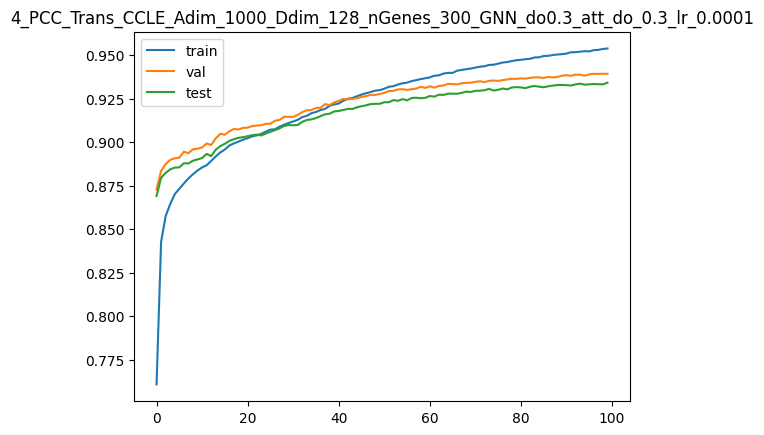

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11916241
Train avg_pcc:  0.9539851208291042
Train r2:  0.910085057074512


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15741503
Validation avg_pcc:  0.9395423371476717
Validation r2:  0.8815389050880521


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17219128
Test avg_pcc:  0.9336332312069965
Test r2:  0.8701988102698676
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.117933035
Train avg_pcc:  0.9544721400823466
Train r2:  0.9110126739824052


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15904196
Validation avg_pcc:  0.9389249186895683
Validation r2:  0.8803145747391369


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17334478
Test avg_pcc:  0.9330319659748502
Test r2:  0.8693292930473144
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11661736
Train avg_pcc:  0.9549906193925185
Train r2:  0.9120054288232491


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1550196
Validation avg_pcc:  0.9399068763952296
Validation r2:  0.8833415604386402
Best Val r2  0.8833415604386402


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16851476
Test avg_pcc:  0.9344285973222087
Test r2:  0.8729702334767502
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11560694
Train avg_pcc:  0.9553900895534609
Train r2:  0.9127678539651307


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15531816
Validation avg_pcc:  0.9400453333436629
Validation r2:  0.8831168882187004


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16880162
Test avg_pcc:  0.9345737191039699
Test r2:  0.8727540129096811
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11566435
Train avg_pcc:  0.955367729539199
Train r2:  0.9127245330779302


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16013838
Validation avg_pcc:  0.9400927466814961
Validation r2:  0.8794894800102344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17489108
Test avg_pcc:  0.9343688325424948
Test r2:  0.8681636463835803
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11539884
Train avg_pcc:  0.9554724733263167
Train r2:  0.9129248800850579


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15487613
Validation avg_pcc:  0.9400607006058818
Validation r2:  0.8834495303553926
Best Val r2  0.8834495303553926


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16885205
Test avg_pcc:  0.9344365418953524
Test r2:  0.8727159946846901
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11497515
Train avg_pcc:  0.9556400965884009
Train r2:  0.9132445835284029


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15471894
Validation avg_pcc:  0.9401216181876179
Validation r2:  0.88356782913317
Best Val r2  0.88356782913317


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16766766
Test avg_pcc:  0.934824358691128
Test r2:  0.8736088111762448
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.114562996
Train avg_pcc:  0.9558025830649337
Train r2:  0.913555565263303


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15343623
Validation avg_pcc:  0.9407089372482321
Validation r2:  0.8845331148523952
Best Val r2  0.8845331148523952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1688282
Test avg_pcc:  0.934544259442134
Test r2:  0.8727339651071275
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11283209
Train avg_pcc:  0.9564852763420676
Train r2:  0.9148616257842789


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15439379
Validation avg_pcc:  0.9406362137387396
Validation r2:  0.8838125071617565


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17126532
Test avg_pcc:  0.9339065254230017
Test r2:  0.8708968097672357
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.112969734
Train avg_pcc:  0.9564317322469522
Train r2:  0.9147577832779994


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1551949
Validation avg_pcc:  0.939986128080977
Validation r2:  0.8832096440908849


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16814817
Test avg_pcc:  0.9348158354982177
Test r2:  0.8732465741156845
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11174759
Train avg_pcc:  0.9569133507466544
Train r2:  0.9156799551529117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15580195
Validation avg_pcc:  0.939912405858051
Validation r2:  0.8827528059142186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16837831
Test avg_pcc:  0.934864779095157
Test r2:  0.8730731007906116
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.111653484
Train avg_pcc:  0.9569504734211748
Train r2:  0.9157509641109952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15540747
Validation avg_pcc:  0.9407542048170383
Validation r2:  0.8830496687715841


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16959035
Test avg_pcc:  0.9350682472141528
Test r2:  0.872159442762994
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11113909
Train avg_pcc:  0.9571534085925575
Train r2:  0.916139104094043


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15251619
Validation avg_pcc:  0.9409121483391989
Validation r2:  0.8852254890086323
Best Val r2  0.8852254890086323


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16550598
Test avg_pcc:  0.9356112713692993
Test r2:  0.8752383213506348
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10984188
Train avg_pcc:  0.9576634457085593
Train r2:  0.9171179127137855


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15338968
Validation avg_pcc:  0.9405178800678994
Validation r2:  0.884568135872751


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16607405
Test avg_pcc:  0.9353212202088281
Test r2:  0.8748100934412741
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11006402
Train avg_pcc:  0.9575773893342379
Train r2:  0.9169503057223207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15302825
Validation avg_pcc:  0.9409020955726248
Validation r2:  0.8848401291059458


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16678844
Test avg_pcc:  0.9353195978381994
Test r2:  0.8742715787276241
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10992065
Train avg_pcc:  0.9576329365969434
Train r2:  0.9170584926462312


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1537026
Validation avg_pcc:  0.9405395763717372
Validation r2:  0.8843326493078375


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16693768
Test avg_pcc:  0.9351263168452245
Test r2:  0.8741590798842807
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.108975284
Train avg_pcc:  0.9580055778941147
Train r2:  0.9177718176164483


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15632124
Validation avg_pcc:  0.9409086560552823
Validation r2:  0.8823620284202379


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17071329
Test avg_pcc:  0.9353055982779382
Test r2:  0.8713129486740581
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10782697
Train avg_pcc:  0.9584578555636993
Train r2:  0.9186382857690225


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15393311
Validation avg_pcc:  0.9409836082853595
Validation r2:  0.8841591776164517


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16791561
Test avg_pcc:  0.9354654979579377
Test r2:  0.8734219002285613
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10722924
Train avg_pcc:  0.958692628144845
Train r2:  0.9190893168216024


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15475546
Validation avg_pcc:  0.9405709009707889
Validation r2:  0.8835403396393006


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16801892
Test avg_pcc:  0.935298875250535
Test r2:  0.8733440192949995
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10768462
Train avg_pcc:  0.9585137098582345
Train r2:  0.9187457023727428


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15411705
Validation avg_pcc:  0.9409623888663827
Validation r2:  0.8840207628543065


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16656123
Test avg_pcc:  0.9359583433211945
Test r2:  0.8744428505542787
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10660579
Train avg_pcc:  0.9589385003746504
Train r2:  0.9195597438235537


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15227187
Validation avg_pcc:  0.9411662550982882
Validation r2:  0.8854093397198247
Best Val r2  0.8854093397198247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16617455
Test avg_pcc:  0.9355725339304224
Test r2:  0.8747343435551675
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10567253
Train avg_pcc:  0.9593050433234213
Train r2:  0.9202639469682535


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15311772
Validation avg_pcc:  0.9406475767342515
Validation r2:  0.8847727942146725


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16663492
Test avg_pcc:  0.9351039302722796
Test r2:  0.8743873056871299
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.105692126
Train avg_pcc:  0.9592979771130247
Train r2:  0.9202491682042937


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15256174
Validation avg_pcc:  0.9411757334209335
Validation r2:  0.8851912006033783


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16589884
Test avg_pcc:  0.9358078872634226
Test r2:  0.8749421708655597
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1045338
Train avg_pcc:  0.9597528212304862
Train r2:  0.9211231734679985


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1532807
Validation avg_pcc:  0.9409972772706561
Validation r2:  0.8846501443239213


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16671331
Test avg_pcc:  0.9356517344988299
Test r2:  0.8743282056814017
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10425658
Train avg_pcc:  0.9598621576084176
Train r2:  0.9213323552073787


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15338
Validation avg_pcc:  0.9409853165324845
Validation r2:  0.8845754281758672


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1676611
Test avg_pcc:  0.9352893809200649
Test r2:  0.8736137496889531
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10350074
Train avg_pcc:  0.9601585573166588
Train r2:  0.9219026839015563


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15255785
Validation avg_pcc:  0.9411794463391082
Validation r2:  0.8851941136048846


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16512185
Test avg_pcc:  0.9361366638980935
Test r2:  0.8755278806823694
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10397319
Train avg_pcc:  0.9599735607754786
Train r2:  0.9215461921283781


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15352629
Validation avg_pcc:  0.9406428318971956
Validation r2:  0.8844653321099671


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16556782
Test avg_pcc:  0.9357652065424432
Test r2:  0.8751917061955141
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10312694
Train avg_pcc:  0.9603058751623988
Train r2:  0.9221847354192375


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15443681
Validation avg_pcc:  0.9410068952092511
Validation r2:  0.8837801354080314


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16754824
Test avg_pcc:  0.9358621348964551
Test r2:  0.8736988312480558
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10246107
Train avg_pcc:  0.9605670765944129
Train r2:  0.9226871718366512


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15202364
Validation avg_pcc:  0.9419039908770375
Validation r2:  0.8855961367405923
Best Val r2  0.8855961367405923


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16635512
Test avg_pcc:  0.9362125150163536
Test r2:  0.8745982257866374
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10172874
Train avg_pcc:  0.9608558223863904
Train r2:  0.9232397611301537


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15277287
Validation avg_pcc:  0.9414920496775531
Validation r2:  0.8850323034230778


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16746546
Test avg_pcc:  0.9356661165874897
Test r2:  0.8737612133496235
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10200673
Train avg_pcc:  0.9607456804511064
Train r2:  0.9230299986383343


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1531604
Validation avg_pcc:  0.9412455122047498
Validation r2:  0.884740690986348


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1659546
Test avg_pcc:  0.9361992307691112
Test r2:  0.8749001267883602
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10083219
Train avg_pcc:  0.9612068585592022
Train r2:  0.9239162663393057


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15110183
Validation avg_pcc:  0.9414888085160175
Validation r2:  0.886289849774118
Best Val r2  0.886289849774118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1631334
Test avg_pcc:  0.93658636043471
Test r2:  0.8770268243659594
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10109519
Train avg_pcc:  0.9611037822073238
Train r2:  0.9237178097724371


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15258315
Validation avg_pcc:  0.9413289944926755
Validation r2:  0.8851750790263655


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1667548
Test avg_pcc:  0.9357091904660895
Test r2:  0.8742969338289791
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.099353984
Train avg_pcc:  0.9617868307094901
Train r2:  0.9250316533086425


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15293482
Validation avg_pcc:  0.9412448726530169
Validation r2:  0.884910430677204


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16571744
Test avg_pcc:  0.9359597528243028
Test r2:  0.875078921487348
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.099271946
Train avg_pcc:  0.9618188177714376
Train r2:  0.9250935578214333


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15200984
Validation avg_pcc:  0.9414684631423401
Validation r2:  0.8856065289126163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16660419
Test avg_pcc:  0.9356441463533597
Test r2:  0.8744104721802357
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.099150255
Train avg_pcc:  0.9618672314690603
Train r2:  0.9251853735907364


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15141255
Validation avg_pcc:  0.9420330950261383
Validation r2:  0.8860560149222768


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16508509
Test avg_pcc:  0.9366288555979944
Test r2:  0.8755555846674703
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09878514
Train avg_pcc:  0.9620105170218088
Train r2:  0.9254608822448221


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15122567
Validation avg_pcc:  0.9418363807964139
Validation r2:  0.8861966435743143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16489959
Test avg_pcc:  0.9363868507096434
Test r2:  0.8756954456030808
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0986632
Train avg_pcc:  0.96205739356695
Train r2:  0.9255528819524795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15060118
Validation avg_pcc:  0.9419014221490747
Validation r2:  0.8866666022629537
Best Val r2  0.8866666022629537


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16401143
Test avg_pcc:  0.9365038271323213
Test r2:  0.8763649399037736
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0987677
Train avg_pcc:  0.962017787697617
Train r2:  0.9254740356560937


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1506254
Validation avg_pcc:  0.9421619869418688
Validation r2:  0.8866483800761034


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.164786
Test avg_pcc:  0.9365812956915998
Test r2:  0.8757810608681244
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09756238
Train avg_pcc:  0.9624894633388225
Train r2:  0.9263835221674229


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15074183
Validation avg_pcc:  0.9415843145517143
Validation r2:  0.8865607561347837


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16435689
Test avg_pcc:  0.9360546688074811
Test r2:  0.8761045284355956
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.097249374
Train avg_pcc:  0.9626121058346173
Train r2:  0.926619705809794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15182543
Validation avg_pcc:  0.9412062547369852
Validation r2:  0.8857453061625143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16472262
Test avg_pcc:  0.9359670881232404
Test r2:  0.8758288367864338
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09672722
Train avg_pcc:  0.9628169789840693
Train r2:  0.92701369516218


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15099393
Validation avg_pcc:  0.9416478898972992
Validation r2:  0.8863710390361655


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1634875
Test avg_pcc:  0.9366372972366426
Test r2:  0.8767598968204872
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.096187904
Train avg_pcc:  0.9630281028577495
Train r2:  0.9274206389768018


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15092929
Validation avg_pcc:  0.9419523736746525
Validation r2:  0.8864196888601111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16435005
Test avg_pcc:  0.9365866609634785
Test r2:  0.8761096930707467
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0964161
Train avg_pcc:  0.9629386832230606
Train r2:  0.9272484534203874


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.14902093
Validation avg_pcc:  0.9425023510942552
Validation r2:  0.8878557992870049
Best Val r2  0.8878557992870049


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16301356
Test avg_pcc:  0.9369346055814285
Test r2:  0.8771171547225808
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09634557
Train avg_pcc:  0.9629662486512487
Train r2:  0.927301667324941


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.14766307
Validation avg_pcc:  0.9428608546277003
Validation r2:  0.8888776439831332
Best Val r2  0.8888776439831332


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16173702
Test avg_pcc:  0.9371845277720459
Test r2:  0.8780794312588882
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09539871
Train avg_pcc:  0.963337357113643
Train r2:  0.9280161323879126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.14988713
Validation avg_pcc:  0.9422572091954164
Validation r2:  0.8872039517252771


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1627163
Test avg_pcc:  0.9371721916922613
Test r2:  0.8773412497277895
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09484546
Train avg_pcc:  0.96355411804695
Train r2:  0.928433586300437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1516848
Validation avg_pcc:  0.9415768578521556
Validation r2:  0.8858511281281501


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16328824
Test avg_pcc:  0.9369432576250954
Test r2:  0.8769101082035893
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.095011204
Train avg_pcc:  0.96348902101638
Train r2:  0.9283085226809755


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.14987035
Validation avg_pcc:  0.9419780255859634
Validation r2:  0.8872165751862124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16105764
Test avg_pcc:  0.9374204502820607
Test r2:  0.8785915656934807
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09408455
Train avg_pcc:  0.9638515413646662
Train r2:  0.9290077431075774


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15097281
Validation avg_pcc:  0.9417610759746251
Validation r2:  0.8863869178462422


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16357774
Test avg_pcc:  0.9367064625399664
Test r2:  0.8766918692097768
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09369857
Train avg_pcc:  0.9640023607207944
Train r2:  0.9292989862216893


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15050864
Validation avg_pcc:  0.9422054104151167
Validation r2:  0.8867362341317484


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16413702
Test avg_pcc:  0.9367568053160054
Test r2:  0.8762702715242158


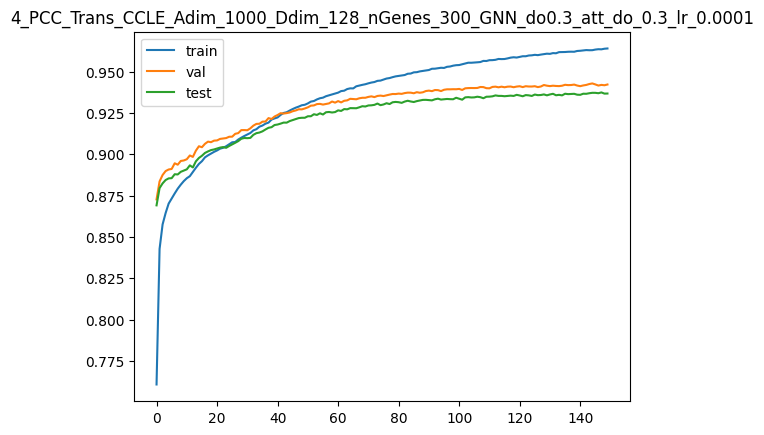

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16173702
Test avg_pcc:  0.9371845276748324
Test r2:  0.8780794312439878


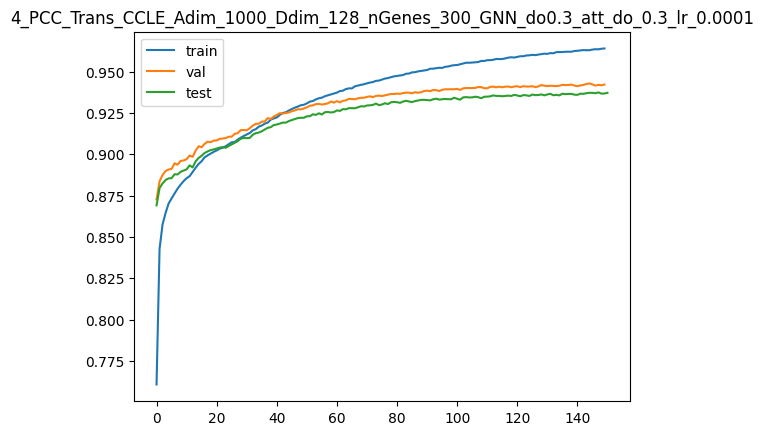

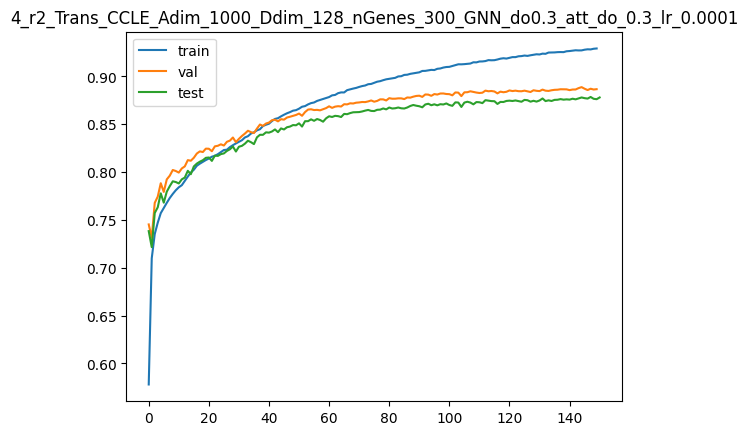

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.567691
Train avg_pcc:  0.7568473970605595
Train r2:  0.5720205712017101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.34853032
Validation avg_pcc:  0.8745727347085419
Validation r2:  0.7379267165870297
Best Val r2  0.7379267165870297


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.33995733
Test avg_pcc:  0.8756609296555082
Test r2:  0.7417111847982272
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.39616197
Train avg_pcc:  0.8376574115804916
Train r2:  0.7013354551363362


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.34807175
Validation avg_pcc:  0.8827819522906996
Validation r2:  0.7382715522665572
Best Val r2  0.7382715522665572


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.33963013
Test avg_pcc:  0.8825373428022741
Test r2:  0.7419597836382295
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3580923
Train avg_pcc:  0.8545292048620181
Train r2:  0.7300360189055223


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3254594
Validation avg_pcc:  0.883952403317004
Validation r2:  0.7552746065112929
Best Val r2  0.7552746065112929


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31705916
Test avg_pcc:  0.8851675702962689
Test r2:  0.7591085217644222
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.34295377
Train avg_pcc:  0.861156118770559
Train r2:  0.741448866789887


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29046965
Validation avg_pcc:  0.8886906949872397
Validation r2:  0.7815847512085985
Best Val r2  0.7815847512085985


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2866399
Test avg_pcc:  0.8879271736021468
Test r2:  0.7822200930594396
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.33112252
Train avg_pcc:  0.8662882184686141
Train r2:  0.7503683868809425


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28613198
Validation avg_pcc:  0.8896825379191743
Validation r2:  0.7848464288260115
Best Val r2  0.7848464288260115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28453982
Test avg_pcc:  0.8896079166918287
Test r2:  0.7838156555467222
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3205984
Train avg_pcc:  0.8708382019946511
Train r2:  0.7583024690530558


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28473216
Validation avg_pcc:  0.8903074991034413
Validation r2:  0.7858989919116379
Best Val r2  0.7858989919116379


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27997568
Test avg_pcc:  0.8903851008974131
Test r2:  0.7872833674534416
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.31266788
Train avg_pcc:  0.8742532252006813
Train r2:  0.7642812507396345


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3003704
Validation avg_pcc:  0.8881258737382512
Validation r2:  0.7741400444350164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2931107
Test avg_pcc:  0.8896475926920029
Test r2:  0.7773037867245958
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.30537996
Train avg_pcc:  0.877387161630486
Train r2:  0.7697756080187286


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26861924
Validation avg_pcc:  0.8939825279018079
Validation r2:  0.7980148979028706
Best Val r2  0.7980148979028706


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26669723
Test avg_pcc:  0.8941466119307317
Test r2:  0.7973719037399385
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2992704
Train avg_pcc:  0.8800039486335686
Train r2:  0.7743815145092544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27435777
Validation avg_pcc:  0.8955711576324461
Validation r2:  0.793699891674541


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26737615
Test avg_pcc:  0.8961913868718667
Test r2:  0.7968560717943367
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29504764
Train avg_pcc:  0.8818033570246687
Train r2:  0.7775650477230877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26477054
Validation avg_pcc:  0.8956576633460162
Validation r2:  0.8009089037330563
Best Val r2  0.8009089037330563


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26307216
Test avg_pcc:  0.8954230113084435
Test r2:  0.8001261357085451
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29057035
Train avg_pcc:  0.8837166467434656
Train r2:  0.7809404602209362


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27524248
Validation avg_pcc:  0.8952181647911502
Validation r2:  0.7930346626390358


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27414975
Test avg_pcc:  0.8948235693161558
Test r2:  0.7917096950106184
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.28558376
Train avg_pcc:  0.8858393160366614
Train r2:  0.7846998178020573


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25542817
Validation avg_pcc:  0.8990744311877197
Validation r2:  0.8079337792485317
Best Val r2  0.8079337792485317


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2528248
Test avg_pcc:  0.8989973694325795
Test r2:  0.8079117294045415
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.28006738
Train avg_pcc:  0.8881831664907274
Train r2:  0.7888585973994795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2574129
Validation avg_pcc:  0.9016025847413957
Validation r2:  0.806441385503984


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2529387
Test avg_pcc:  0.9014746410356074
Test r2:  0.8078252189562937
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.27567574
Train avg_pcc:  0.8900444315803555
Train r2:  0.7921694235377501


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25629437
Validation avg_pcc:  0.9017597484312957
Validation r2:  0.8072824441571482


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25308254
Test avg_pcc:  0.9012226729924885
Test r2:  0.8077158945660856
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.27081358
Train avg_pcc:  0.8921013053170341
Train r2:  0.7958349961045993


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2445391
Validation avg_pcc:  0.9036429095046783
Validation r2:  0.81612170604103
Best Val r2  0.81612170604103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24047604
Test avg_pcc:  0.9042249043602889
Test r2:  0.8172939146959399
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2651101
Train avg_pcc:  0.8945079949663431
Train r2:  0.8001348240101402


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24017377
Validation avg_pcc:  0.9056388617301331
Validation r2:  0.8194041445454836
Best Val r2  0.8194041445454836


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.239272
Test avg_pcc:  0.9051175547407133
Test r2:  0.8182087183009146
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26138434
Train avg_pcc:  0.896075964472602
Train r2:  0.8029436309631951


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23668256
Validation avg_pcc:  0.9066910205231109
Validation r2:  0.8220293189432764
Best Val r2  0.8220293189432764


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23347637
Test avg_pcc:  0.9070123749514772
Test r2:  0.8226120679561527
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2580634
Train avg_pcc:  0.8974722616976012
Train r2:  0.8054472783921568


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23318695
Validation avg_pcc:  0.9081227525960921
Validation r2:  0.8246578101611666
Best Val r2  0.8246578101611666


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23331022
Test avg_pcc:  0.9071389995198986
Test r2:  0.8227382777719264
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25460535
Train avg_pcc:  0.8989235889677861
Train r2:  0.80805429134739


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23357166
Validation avg_pcc:  0.9082983832420108
Validation r2:  0.8243685375765489


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23177896
Test avg_pcc:  0.9078243480730548
Test r2:  0.8239016943821014
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25278938
Train avg_pcc:  0.8996844367080731
Train r2:  0.8094233545448944


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23174141
Validation avg_pcc:  0.9092791751064183
Validation r2:  0.8257447628751005
Best Val r2  0.8257447628751005


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22819774
Test avg_pcc:  0.9095946511512552
Test r2:  0.8266225802233069
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25099954
Train avg_pcc:  0.9004336408471477
Train r2:  0.8107727036080117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23344998
Validation avg_pcc:  0.9083556152072487
Validation r2:  0.8244600197285266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23212333
Test avg_pcc:  0.9081352205415091
Test r2:  0.8236400553881352
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24823439
Train avg_pcc:  0.9015913019334107
Train r2:  0.812857336019243


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23287284
Validation avg_pcc:  0.9092014702472805
Validation r2:  0.8248939957538961


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23057538
Test avg_pcc:  0.9086817257937618
Test r2:  0.8248161188217301
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24742337
Train avg_pcc:  0.9019294175482471
Train r2:  0.8134687595257439


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22977996
Validation avg_pcc:  0.9099672044706639
Validation r2:  0.8272196600976311
Best Val r2  0.8272196600976311


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22626999
Test avg_pcc:  0.9101803939370093
Test r2:  0.8280872450127353
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24447398
Train avg_pcc:  0.9031604368554993
Train r2:  0.8156922866078431


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23493826
Validation avg_pcc:  0.9077173120475353
Validation r2:  0.8233409279119566


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23129265
Test avg_pcc:  0.9082865388564207
Test r2:  0.8242711841889431
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24214989
Train avg_pcc:  0.9041288221828222
Train r2:  0.8174444199915414


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23358262
Validation avg_pcc:  0.9102625653772979
Validation r2:  0.8243602820705085


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23037454
Test avg_pcc:  0.9105262553877475
Test r2:  0.8249687298496093
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2409588
Train avg_pcc:  0.9046279000635272
Train r2:  0.8183423670586238


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22728992
Validation avg_pcc:  0.9105470590727895
Validation r2:  0.8290920115337835
Best Val r2  0.8290920115337835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2241834
Test avg_pcc:  0.9109445445511161
Test r2:  0.8296725690921745
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23890321
Train avg_pcc:  0.9054817165240129
Train r2:  0.8198920594070306


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22737297
Validation avg_pcc:  0.9115580339005159
Validation r2:  0.8290295640863716


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22417723
Test avg_pcc:  0.9114779636322169
Test r2:  0.8296772463259746
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23670287
Train avg_pcc:  0.9063980153674498
Train r2:  0.8215508786283295


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22524965
Validation avg_pcc:  0.9118043469037522
Validation r2:  0.830626172808669
Best Val r2  0.830626172808669


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22210783
Test avg_pcc:  0.9119202699379435
Test r2:  0.8312495153119117
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23371065
Train avg_pcc:  0.9076402504307552
Train r2:  0.8238067035571801


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22703232
Validation avg_pcc:  0.9112683286775555
Validation r2:  0.8292857164686092


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22181082
Test avg_pcc:  0.9123703182410912
Test r2:  0.8314751829771404
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23153408
Train avg_pcc:  0.9085454422068893
Train r2:  0.8254476143981269


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22420482
Validation avg_pcc:  0.9125069937619054
Validation r2:  0.8314118108851583
Best Val r2  0.8314118108851583


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2185426
Test avg_pcc:  0.9135939384370272
Test r2:  0.8339582649919483
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2287586
Train avg_pcc:  0.9096959887644008
Train r2:  0.8275400238490789


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21982072
Validation avg_pcc:  0.9146150708551288
Validation r2:  0.8347083898967338
Best Val r2  0.8347083898967338


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21737628
Test avg_pcc:  0.9145571171588477
Test r2:  0.8348443965348887
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22722876
Train avg_pcc:  0.910329035354162
Train r2:  0.8286933854806324


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22004554
Validation avg_pcc:  0.9145292936801973
Validation r2:  0.8345393481454733


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21397705
Test avg_pcc:  0.9157352444268153
Test r2:  0.8374270275980411
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22277024
Train avg_pcc:  0.9121716896340646
Train r2:  0.8320546415613324


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21886581
Validation avg_pcc:  0.9144054807378953
Validation r2:  0.8354264131243775
Best Val r2  0.8354264131243775


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21096538
Test avg_pcc:  0.9166320522364652
Test r2:  0.8397151851479133
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22132893
Train avg_pcc:  0.9127692270129928
Train r2:  0.833141230723778


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21537547
Validation avg_pcc:  0.9158874491733903
Validation r2:  0.8380509416221381
Best Val r2  0.8380509416221381


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20758487
Test avg_pcc:  0.9181015560556601
Test r2:  0.842283579521316
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21740542
Train avg_pcc:  0.9143879667965805
Train r2:  0.836099135873617


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21540031
Validation avg_pcc:  0.916451602125624
Validation r2:  0.838032271127834


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20673755
Test avg_pcc:  0.9186873133185498
Test r2:  0.8429273676546589
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21447363
Train avg_pcc:  0.9155948125503612
Train r2:  0.8383094040213702


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20910111
Validation avg_pcc:  0.9181380308969501
Validation r2:  0.8427688716596208
Best Val r2  0.8427688716596208


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20496948
Test avg_pcc:  0.9188938112156532
Test r2:  0.8442706884522038
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21135142
Train avg_pcc:  0.9168790085407953
Train r2:  0.8406632251981041


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2116053
Validation avg_pcc:  0.9187929162045562
Validation r2:  0.8408858823140513


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.206016
Test avg_pcc:  0.9197843120137554
Test r2:  0.8434755710843038
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20885713
Train avg_pcc:  0.917903846845022
Train r2:  0.842543673647066


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20856401
Validation avg_pcc:  0.9190964608855808
Validation r2:  0.843172742219233
Best Val r2  0.843172742219233


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20107254
Test avg_pcc:  0.9213164054846033
Test r2:  0.8472314645037694
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2068242
Train avg_pcc:  0.9187392806851119
Train r2:  0.8440762684075247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20478474
Validation avg_pcc:  0.9199023617825558
Validation r2:  0.8460145198015157
Best Val r2  0.8460145198015157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19868058
Test avg_pcc:  0.9215495409170851
Test r2:  0.8490487821131317
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20348108
Train avg_pcc:  0.9201094345214355
Train r2:  0.8465966283376367


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20532261
Validation avg_pcc:  0.9208243361614259
Validation r2:  0.8456100845483898


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.198431
Test avg_pcc:  0.9227838593646774
Test r2:  0.8492384243733581
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1996895
Train avg_pcc:  0.9216612124795937
Train r2:  0.8494550830638176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20203817
Validation avg_pcc:  0.921602837574174
Validation r2:  0.8480797687753986
Best Val r2  0.8480797687753986


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19611502
Test avg_pcc:  0.9229931358115935
Test r2:  0.8509980407076592
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19840932
Train avg_pcc:  0.9221846978551139
Train r2:  0.8504202105709069


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20252982
Validation avg_pcc:  0.9218851752068494
Validation r2:  0.8477100853502209


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19471702
Test avg_pcc:  0.9241182364309125
Test r2:  0.8520601771271923
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19558798
Train avg_pcc:  0.9233370218317696
Train r2:  0.852547212168231


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1966953
Validation avg_pcc:  0.9230946782862924
Validation r2:  0.8520972827040442
Best Val r2  0.8520972827040442


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19161977
Test avg_pcc:  0.924379549606911
Test r2:  0.8544133726684835
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19345555
Train avg_pcc:  0.9242085241144968
Train r2:  0.8541548337462426


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20024195
Validation avg_pcc:  0.923251282044525
Validation r2:  0.8494304175424947


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19196503
Test avg_pcc:  0.9253139048421481
Test r2:  0.8541510390844522
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19049543
Train avg_pcc:  0.9254131596751869
Train r2:  0.8563864480209149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19436483
Validation avg_pcc:  0.9240607679002701
Validation r2:  0.8538496538267882
Best Val r2  0.8538496538267882


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18741445
Test avg_pcc:  0.9262560125253181
Test r2:  0.8576084333495424
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18839473
Train avg_pcc:  0.9262682584181536
Train r2:  0.8579701510531462


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19411659
Validation avg_pcc:  0.9242154963915656
Validation r2:  0.854036300652816
Best Val r2  0.854036300652816


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18804745
Test avg_pcc:  0.9259329826729785
Test r2:  0.8571275116219834
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18675402
Train avg_pcc:  0.9269372582058036
Train r2:  0.8592070766771167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19341138
Validation avg_pcc:  0.9252818674525704
Validation r2:  0.8545665860266877
Best Val r2  0.8545665860266877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18599918
Test avg_pcc:  0.9273157732322571
Test r2:  0.8586837141635179
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1845365
Train avg_pcc:  0.9278382335862991
Train r2:  0.8608788575431789


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1918137
Validation avg_pcc:  0.9257554620550271
Validation r2:  0.8557679269633385
Best Val r2  0.8557679269633385


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18616278
Test avg_pcc:  0.9271338350960361
Test r2:  0.8585594054639346
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1831609
Train avg_pcc:  0.9283972908466315
Train r2:  0.8619159181382772


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18885167
Validation avg_pcc:  0.9263887747167953
Validation r2:  0.8579951973306083
Best Val r2  0.8579951973306083


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18112813
Test avg_pcc:  0.9286945819209285
Test r2:  0.8623845918097984
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18023074
Train avg_pcc:  0.9295849930301486
Train r2:  0.864124942319683


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18742153
Validation avg_pcc:  0.9270675537829106
Validation r2:  0.8590705632654548
Best Val r2  0.8590705632654548


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18164797
Test avg_pcc:  0.9287172251245149
Test r2:  0.8619896254547674


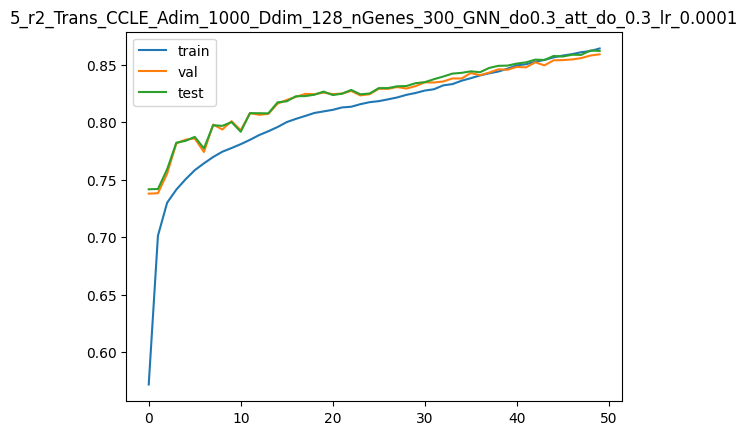

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17790934
Train avg_pcc:  0.9305266265916136
Train r2:  0.8658750412808016


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18819396
Validation avg_pcc:  0.927308255229987
Validation r2:  0.8584897588695982


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18348595
Test avg_pcc:  0.928216769160093
Test r2:  0.8605931936674799
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17762892
Train avg_pcc:  0.9306403201425719
Train r2:  0.8660864493395619


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18407224
Validation avg_pcc:  0.929233303984221
Validation r2:  0.8615890548402552
Best Val r2  0.8615890548402552


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18268017
Test avg_pcc:  0.9294268159407937
Test r2:  0.8612054022923725
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17464726
Train avg_pcc:  0.9318469049129898
Train r2:  0.8683342977092978


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18687837
Validation avg_pcc:  0.928139700056671
Validation r2:  0.8594790096316289


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18080309
Test avg_pcc:  0.9295821488818442
Test r2:  0.8626315442561807
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17311212
Train avg_pcc:  0.93246705044202
Train r2:  0.8694916282804629


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18731694
Validation avg_pcc:  0.9281184842776208
Validation r2:  0.859149218381132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17914723
Test avg_pcc:  0.9302278757737005
Test r2:  0.8638896235859208
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1708885
Train avg_pcc:  0.9333663154481578
Train r2:  0.8711680199400755


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18385984
Validation avg_pcc:  0.9293426472702202
Validation r2:  0.861748741591798
Best Val r2  0.861748741591798


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17692879
Test avg_pcc:  0.9309863920487041
Test r2:  0.8655751130282311
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17044942
Train avg_pcc:  0.9335433675017224
Train r2:  0.8714990378846508


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18287714
Validation avg_pcc:  0.9292463450478301
Validation r2:  0.8624876771295494
Best Val r2  0.8624876771295494


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17288147
Test avg_pcc:  0.9322775149029313
Test r2:  0.8686501404641875
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16816498
Train avg_pcc:  0.9344653854570535
Train r2:  0.8732212672578146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18241155
Validation avg_pcc:  0.9292237566866852
Validation r2:  0.8628377685115003
Best Val r2  0.8628377685115003


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17439048
Test avg_pcc:  0.93151705416545
Test r2:  0.8675036461848469
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16657193
Train avg_pcc:  0.9351075123580477
Train r2:  0.8744222560252953


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18031746
Validation avg_pcc:  0.9297449587127642
Validation r2:  0.8644124021953512
Best Val r2  0.8644124021953512


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17283444
Test avg_pcc:  0.9320863023834232
Test r2:  0.8686858690926447
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16486828
Train avg_pcc:  0.9357936973036506
Train r2:  0.8757066242570966


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18017519
Validation avg_pcc:  0.9307405583456898
Validation r2:  0.8645193720644349
Best Val r2  0.8645193720644349


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1715008
Test avg_pcc:  0.9331585787421394
Test r2:  0.8696991185977955
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16362323
Train avg_pcc:  0.9362962264605246
Train r2:  0.8766452641578548


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17823535
Validation avg_pcc:  0.9310959186927367
Validation r2:  0.8659780192233459
Best Val r2  0.8659780192233459


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17015241
Test avg_pcc:  0.9333394099864586
Test r2:  0.8707235856873995
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16200972
Train avg_pcc:  0.9369440814794322
Train r2:  0.8778616912332863


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1785383
Validation avg_pcc:  0.9305419426493704
Validation r2:  0.8657502340753606


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17192414
Test avg_pcc:  0.9324524854856236
Test r2:  0.8693774971612531
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1601174
Train avg_pcc:  0.9377055742769977
Train r2:  0.8792882923232099


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17840059
Validation avg_pcc:  0.9311748710080312
Validation r2:  0.8658537736447874


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16879465
Test avg_pcc:  0.9341279182914622
Test r2:  0.871755186134913
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15880871
Train avg_pcc:  0.938231374792016
Train r2:  0.8802749083493882


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17612752
Validation avg_pcc:  0.9320876245715572
Validation r2:  0.8675629696616005
Best Val r2  0.8675629696616005


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1704555
Test avg_pcc:  0.9333994185421879
Test r2:  0.8704933178833304
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15726219
Train avg_pcc:  0.9388524797227696
Train r2:  0.8814408272623839


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17597045
Validation avg_pcc:  0.9315366140559237
Validation r2:  0.8676810776683394
Best Val r2  0.8676810776683394


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1698639
Test avg_pcc:  0.9333502407521029
Test r2:  0.8709427872720267
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15674295
Train avg_pcc:  0.9390624828504679
Train r2:  0.8818322953052276


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17691813
Validation avg_pcc:  0.9312087832199445
Validation r2:  0.8669684837369169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1663828
Test avg_pcc:  0.9347225158889091
Test r2:  0.8735876305166336
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15366492
Train avg_pcc:  0.9402951725664865
Train r2:  0.8841527838757497


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17508213
Validation avg_pcc:  0.931924834940667
Validation r2:  0.868349041534867
Best Val r2  0.868349041534867


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16653688
Test avg_pcc:  0.9346023529113205
Test r2:  0.8734705533557605
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15308657
Train avg_pcc:  0.9405277950759915
Train r2:  0.8845888036127656


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17687969
Validation avg_pcc:  0.931868298316622
Validation r2:  0.8669973946781238


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16991487
Test avg_pcc:  0.9337453675929883
Test r2:  0.8709040657060227
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15183176
Train avg_pcc:  0.9410304941800145
Train r2:  0.8855347892193042


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17414056
Validation avg_pcc:  0.9323567633717216
Validation r2:  0.8690570470437531
Best Val r2  0.8690570470437531


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16693322
Test avg_pcc:  0.9345501859763153
Test r2:  0.8731694292066767
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15087408
Train avg_pcc:  0.941414467501062
Train r2:  0.8862567779123821


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17243494
Validation avg_pcc:  0.9331305303119024
Validation r2:  0.8703395737662903
Best Val r2  0.8703395737662903


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16527817
Test avg_pcc:  0.9352223667178263
Test r2:  0.874426883924666
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14894384
Train avg_pcc:  0.9421863239134041
Train r2:  0.8877119880101478


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17377841
Validation avg_pcc:  0.9328070682297623
Validation r2:  0.8693293643570126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16413626
Test avg_pcc:  0.9357384324089266
Test r2:  0.8752944761155728
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14833972
Train avg_pcc:  0.9424280107731225
Train r2:  0.8881674421369312


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17184573
Validation avg_pcc:  0.9333260359373196
Validation r2:  0.8707826156405638
Best Val r2  0.8707826156405638


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1636439
Test avg_pcc:  0.9358157909524845
Test r2:  0.8756685546017614
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14666913
Train avg_pcc:  0.9430963453245118
Train r2:  0.8894268719996998


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17732674
Validation avg_pcc:  0.9337204120532226
Validation r2:  0.8666612344913839


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1686574
Test avg_pcc:  0.9359129300442073
Test r2:  0.8718594547831292
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14519231
Train avg_pcc:  0.9436860418363043
Train r2:  0.8905402435181695


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17221536
Validation avg_pcc:  0.9334727940066709
Validation r2:  0.870504680932187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16276407
Test avg_pcc:  0.9363437430355963
Test r2:  0.8763370166975375
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14407623
Train avg_pcc:  0.9441319262423062
Train r2:  0.8913816623098457


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17354283
Validation avg_pcc:  0.9336061724255487
Validation r2:  0.8695065133943374


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16346025
Test avg_pcc:  0.9365632759355776
Test r2:  0.8758080881141285
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1420924
Train avg_pcc:  0.9449227839702131
Train r2:  0.8928772472235852


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1719034
Validation avg_pcc:  0.9339998401970224
Validation r2:  0.8707392517061162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16284415
Test avg_pcc:  0.9366223250776297
Test r2:  0.8762761664703362
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14214225
Train avg_pcc:  0.9449037017749418
Train r2:  0.8928396799561757


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17033245
Validation avg_pcc:  0.9342071138155456
Validation r2:  0.871920516098945
Best Val r2  0.871920516098945


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16088817
Test avg_pcc:  0.9370532287095017
Test r2:  0.8777622707154339
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14106756
Train avg_pcc:  0.9453320078564547
Train r2:  0.8936498541128715


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17104846
Validation avg_pcc:  0.9345979879990455
Validation r2:  0.8713821290804595


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16236596
Test avg_pcc:  0.9370109030588619
Test r2:  0.8766394854656772
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14014368
Train avg_pcc:  0.9457016950428307
Train r2:  0.8943463776868733


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1732461
Validation avg_pcc:  0.9345717873429129
Validation r2:  0.8697296154964486


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16265409
Test avg_pcc:  0.937695230586595
Test r2:  0.8764205769868442
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13890022
Train avg_pcc:  0.9461960601943137
Train r2:  0.8952838135977791


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16823821
Validation avg_pcc:  0.9348712741451933
Validation r2:  0.873495253216709
Best Val r2  0.873495253216709


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15852821
Test avg_pcc:  0.9379682337702518
Test r2:  0.8795552964985702
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1378264
Train avg_pcc:  0.9466239085926925
Train r2:  0.8960933670485022


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16760032
Validation avg_pcc:  0.9357051004168044
Validation r2:  0.8739749110820343
Best Val r2  0.8739749110820343


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15846594
Test avg_pcc:  0.938355658345576
Test r2:  0.8796026070806755
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13628304
Train avg_pcc:  0.9472379797894708
Train r2:  0.8972569074158285


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16751926
Validation avg_pcc:  0.9352006596796848
Validation r2:  0.8740358648263512
Best Val r2  0.8740358648263512


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15775806
Test avg_pcc:  0.9383784691713164
Test r2:  0.8801404287363497
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13493146
Train avg_pcc:  0.9477756603410132
Train r2:  0.898275851966384


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16688743
Validation avg_pcc:  0.9352849571186943
Validation r2:  0.8745109575974406
Best Val r2  0.8745109575974406


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16022378
Test avg_pcc:  0.9372924019371927
Test r2:  0.878267051682291
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13488774
Train avg_pcc:  0.94779309415025
Train r2:  0.89830880649157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17364332
Validation avg_pcc:  0.9350153352043308
Validation r2:  0.8694309525873867


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16351837
Test avg_pcc:  0.9377215105926979
Test r2:  0.8757639308539914
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13401096
Train avg_pcc:  0.9481420851369072
Train r2:  0.8989698103559054


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16788568
Validation avg_pcc:  0.9356081569144535
Validation r2:  0.873760340072945


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1590501
Test avg_pcc:  0.9381882358246307
Test r2:  0.8791587693266881
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1328659
Train avg_pcc:  0.9485970406648188
Train r2:  0.899833050601442


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16672498
Validation avg_pcc:  0.9353000081087145
Validation r2:  0.8746331152031848
Best Val r2  0.8746331152031848


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15662459
Test avg_pcc:  0.9386267780447136
Test r2:  0.8810016056384629
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13203186
Train avg_pcc:  0.948928033146006
Train r2:  0.9004618512991376


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16685307
Validation avg_pcc:  0.9358155365324689
Validation r2:  0.8745367951459248


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1574847
Test avg_pcc:  0.9385807101537561
Test r2:  0.8803481155092225
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1296652
Train avg_pcc:  0.9498677567453904
Train r2:  0.9022460605356996


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16812924
Validation avg_pcc:  0.935977155394363
Validation r2:  0.8735771876716096


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15688674
Test avg_pcc:  0.9394019018622285
Test r2:  0.8808024206134906
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13122289
Train avg_pcc:  0.9492499451802481
Train r2:  0.9010717026650752


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16536705
Validation avg_pcc:  0.9366284394886532
Validation r2:  0.8756541933423637
Best Val r2  0.8756541933423637


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15831402
Test avg_pcc:  0.93856191766208
Test r2:  0.8797180298770848
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12881501
Train avg_pcc:  0.9502054675832362
Train r2:  0.9028870011017975


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16386119
Validation avg_pcc:  0.936700660741352
Validation r2:  0.8767865140164197
Best Val r2  0.8767865140164197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15492696
Test avg_pcc:  0.9394262757076038
Test r2:  0.882291419147405
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12859902
Train avg_pcc:  0.9502903087103931
Train r2:  0.9030498618771043


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16387594
Validation avg_pcc:  0.9363660209772003
Validation r2:  0.8767754068626887


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15438788
Test avg_pcc:  0.9395719126312165
Test r2:  0.8827009946278263
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12691543
Train avg_pcc:  0.9509585700647146
Train r2:  0.9043190907863587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16367488
Validation avg_pcc:  0.9367773009482773
Validation r2:  0.8769265970219905
Best Val r2  0.8769265970219905


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15498307
Test avg_pcc:  0.9394169192554076
Test r2:  0.8822487658846927
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12617075
Train avg_pcc:  0.9512534579725105
Train r2:  0.904880502692786


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16698417
Validation avg_pcc:  0.936052387572098
Validation r2:  0.8744382114709406


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15755928
Test avg_pcc:  0.9388807852339096
Test r2:  0.8802914520002062
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12604745
Train avg_pcc:  0.9513041178416364
Train r2:  0.904973461289909


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16378346
Validation avg_pcc:  0.9369629998618706
Validation r2:  0.8768449438692426


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15455537
Test avg_pcc:  0.9397641367704371
Test r2:  0.8825737344963336
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12416206
Train avg_pcc:  0.9520487315770388
Train r2:  0.9063948463954613


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16562131
Validation avg_pcc:  0.9371219037446036
Validation r2:  0.8754630001979028


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15650636
Test avg_pcc:  0.939734221535519
Test r2:  0.8810914322214102
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12398316
Train avg_pcc:  0.9521199727005468
Train r2:  0.9065297178562903


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16695724
Validation avg_pcc:  0.936679892044816
Validation r2:  0.8744584631293981


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15717484
Test avg_pcc:  0.9394623447908494
Test r2:  0.8805835289077446
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.123343825
Train avg_pcc:  0.9523728718792174
Train r2:  0.9070117174818225


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16495764
Validation avg_pcc:  0.9364198012830623
Validation r2:  0.8759620367905192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15380812
Test avg_pcc:  0.9400065683281642
Test r2:  0.8831414714777069
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12210012
Train avg_pcc:  0.9528658029073506
Train r2:  0.9079493282787925


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16459417
Validation avg_pcc:  0.9368784793681594
Validation r2:  0.8762353427374955


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15436357
Test avg_pcc:  0.9400304925722864
Test r2:  0.8827194442826818
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12239643
Train avg_pcc:  0.9527480607477964
Train r2:  0.9077259440305923


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16348939
Validation avg_pcc:  0.9368803287404612
Validation r2:  0.8770660754340279
Best Val r2  0.8770660754340279


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15397073
Test avg_pcc:  0.9398507989128629
Test r2:  0.8830179148016746
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.120507486
Train avg_pcc:  0.9534950031653306
Train r2:  0.9091500030748073


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16235879
Validation avg_pcc:  0.9371120636958955
Validation r2:  0.8779162130977385
Best Val r2  0.8779162130977385


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15283203
Test avg_pcc:  0.9402139101857663
Test r2:  0.8838830739135113
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.120326005
Train avg_pcc:  0.9535667896330784
Train r2:  0.9092868213782447


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1618462
Validation avg_pcc:  0.937478167542209
Validation r2:  0.8783016451522225
Best Val r2  0.8783016451522225


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15197739
Test avg_pcc:  0.9407373008700397
Test r2:  0.88453239669893


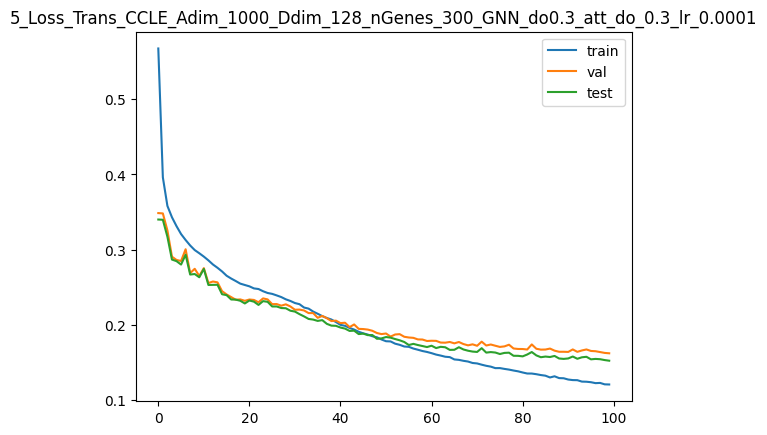

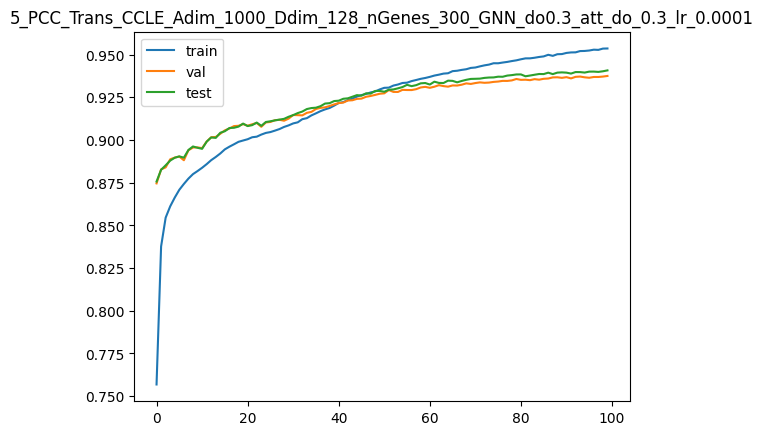

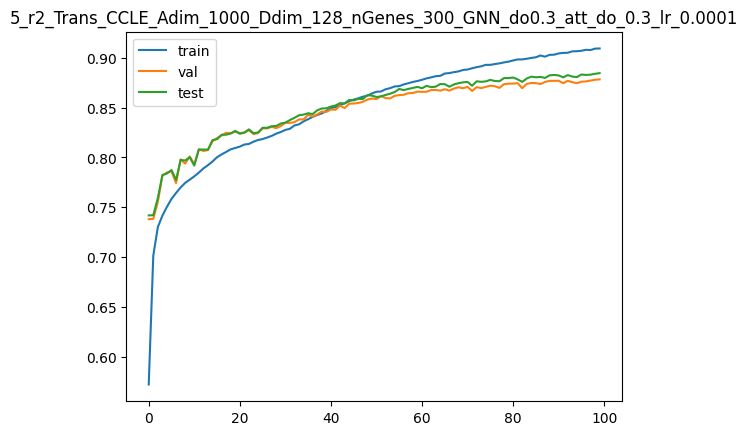

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.118463874
Train avg_pcc:  0.9543021777964882
Train r2:  0.9106906672426333


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16122763
Validation avg_pcc:  0.9381196213902844
Validation r2:  0.8787667799341532
Best Val r2  0.8787667799341532


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15401867
Test avg_pcc:  0.9401197638860088
Test r2:  0.8829815114775248
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.119063
Train avg_pcc:  0.9540657042012045
Train r2:  0.9102390008912333


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16514534
Validation avg_pcc:  0.9374717311598355
Validation r2:  0.8758209016573112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15553778
Test avg_pcc:  0.9402035527145864
Test r2:  0.8818273265431561
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11753012
Train avg_pcc:  0.9546718754339516
Train r2:  0.9113946236824334


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1612438
Validation avg_pcc:  0.9380323738840445
Validation r2:  0.8787546196098639


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15185608
Test avg_pcc:  0.9409375104188747
Test r2:  0.8846245715618446
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11747366
Train avg_pcc:  0.9546933768363334
Train r2:  0.9114371885470546


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16140382
Validation avg_pcc:  0.937561990917874
Validation r2:  0.8786342954592529


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15178686
Test avg_pcc:  0.9406329111441365
Test r2:  0.8846771490451352
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11679815
Train avg_pcc:  0.9549607371922918
Train r2:  0.9119464571966114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16262957
Validation avg_pcc:  0.9380589397488379
Validation r2:  0.8777126095828188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1543936
Test avg_pcc:  0.9403449637754044
Test r2:  0.8826966394242358
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11616126
Train avg_pcc:  0.955211594127712
Train r2:  0.9124266191346234


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16311114
Validation avg_pcc:  0.9375347733762229
Validation r2:  0.8773504997847184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15230437
Test avg_pcc:  0.9409670365774527
Test r2:  0.8842839764019049
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11524135
Train avg_pcc:  0.9555744850462582
Train r2:  0.9131201178150642


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16381119
Validation avg_pcc:  0.937417139407228
Validation r2:  0.8768240963084053


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15233684
Test avg_pcc:  0.940986920705924
Test r2:  0.8842593025032167
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.114437215
Train avg_pcc:  0.9558921211018482
Train r2:  0.9137263682233785


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15927754
Validation avg_pcc:  0.9382688757202193
Validation r2:  0.8802331155267504
Best Val r2  0.8802331155267504


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14969401
Test avg_pcc:  0.9414638235660397
Test r2:  0.8862672418265796
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11390418
Train avg_pcc:  0.9561020953966288
Train r2:  0.91412820724654


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16124386
Validation avg_pcc:  0.938477782575122
Validation r2:  0.8787545737477679


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1523464
Test avg_pcc:  0.9410352921185059
Test r2:  0.8842520290264118
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11311441
Train avg_pcc:  0.9564128297980982
Train r2:  0.914723607079564


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16062863
Validation avg_pcc:  0.9382825906203419
Validation r2:  0.8792171803304024


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15228584
Test avg_pcc:  0.9407502106388572
Test r2:  0.8842980437565046
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11350632
Train avg_pcc:  0.9562590805715224
Train r2:  0.914428156286473


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16083485
Validation avg_pcc:  0.9378922646625464
Validation r2:  0.8790621254885632


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15105109
Test avg_pcc:  0.9409929316952448
Test r2:  0.8852361757038136
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.112456724
Train avg_pcc:  0.9566724053090905
Train r2:  0.9152194444105857


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15897281
Validation avg_pcc:  0.9383458412659186
Validation r2:  0.8804622602899244
Best Val r2  0.8804622602899244


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1498857
Test avg_pcc:  0.9413476079588542
Test r2:  0.8861215970388144
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11193427
Train avg_pcc:  0.9568785236978103
Train r2:  0.9156133144834822


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15976825
Validation avg_pcc:  0.9386275110197883
Validation r2:  0.8798641320873101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14949208
Test avg_pcc:  0.9418569309664647
Test r2:  0.8864206608540164
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.111432165
Train avg_pcc:  0.9570757572282174
Train r2:  0.9159918540511395


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1597579
Validation avg_pcc:  0.938521048253187
Validation r2:  0.8798719219624713


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14919999
Test avg_pcc:  0.9418342087937626
Test r2:  0.8866425785951355
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10974025
Train avg_pcc:  0.9577428580262932
Train r2:  0.9172673745586829


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16340268
Validation avg_pcc:  0.9384210625503892
Validation r2:  0.877131279609672


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15316841
Test avg_pcc:  0.9412863366067241
Test r2:  0.8836274926654095
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10937703
Train avg_pcc:  0.9578853218332555
Train r2:  0.9175412184914071


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16223791
Validation avg_pcc:  0.9381367134207629
Validation r2:  0.8780070928812026


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15236914
Test avg_pcc:  0.9412585693112085
Test r2:  0.8842347564808538
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10871538
Train avg_pcc:  0.9581454763474379
Train r2:  0.9180400289875997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16031297
Validation avg_pcc:  0.9385739988565719
Validation r2:  0.87945455524382


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15120184
Test avg_pcc:  0.9412503898687512
Test r2:  0.88512163979933
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10835732
Train avg_pcc:  0.9582862488272685
Train r2:  0.9183099600989245


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16132563
Validation avg_pcc:  0.938627172645931
Validation r2:  0.8786930750700077


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15214244
Test avg_pcc:  0.9412112697619676
Test r2:  0.8844069942674296
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10804009
Train avg_pcc:  0.9584108971137986
Train r2:  0.9185491184726424


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15956445
Validation avg_pcc:  0.9392506982368829
Validation r2:  0.8800173887918438


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15036207
Test avg_pcc:  0.9419190957868445
Test r2:  0.8857596624850955
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10768926
Train avg_pcc:  0.958549092534141
Train r2:  0.9188136000733294


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16133036
Validation avg_pcc:  0.9383398249235516
Validation r2:  0.8786895265165932


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15017365
Test avg_pcc:  0.9418126699010357
Test r2:  0.8859028206807336
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10729378
Train avg_pcc:  0.9587044650552908
Train r2:  0.9191117642072185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16002889
Validation avg_pcc:  0.9384597947439057
Validation r2:  0.8796681588377492


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14890608
Test avg_pcc:  0.9420356866829742
Test r2:  0.8868658861260323
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10690465
Train avg_pcc:  0.9588573856528222
Train r2:  0.9194051205092604


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1608564
Validation avg_pcc:  0.93834351124934
Validation r2:  0.8790459221626044


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1499322
Test avg_pcc:  0.9417571522901776
Test r2:  0.8860862639947045
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.105876796
Train avg_pcc:  0.9592614428799608
Train r2:  0.9201800173822854


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15917909
Validation avg_pcc:  0.9387757793144923
Validation r2:  0.8803071471438019


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14915593
Test avg_pcc:  0.9418886131242138
Test r2:  0.8866760619592368
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10603728
Train avg_pcc:  0.9591983167702709
Train r2:  0.9200590154123072


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16047624
Validation avg_pcc:  0.939111992021603
Validation r2:  0.8793317746193998


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1522175
Test avg_pcc:  0.9413465852090241
Test r2:  0.8843499517167397
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10502639
Train avg_pcc:  0.9595953179790211
Train r2:  0.9208211280963514


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15889387
Validation avg_pcc:  0.9388007394555401
Validation r2:  0.8805216253483245
Best Val r2  0.8805216253483245


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14804576
Test avg_pcc:  0.9423269152675134
Test r2:  0.8875195219984888
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1041681
Train avg_pcc:  0.9599334401130548
Train r2:  0.9214681913099833


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16113093
Validation avg_pcc:  0.9384867688383784
Validation r2:  0.8788394872654416


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1489572
Test avg_pcc:  0.9423744360169649
Test r2:  0.8868270416828596
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10377631
Train avg_pcc:  0.9600863129015688
Train r2:  0.9217635607422692


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1612262
Validation avg_pcc:  0.9383204076727065
Validation r2:  0.8787678557861889


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14998591
Test avg_pcc:  0.9419252445889379
Test r2:  0.8860454602280524
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10330108
Train avg_pcc:  0.9602725967685682
Train r2:  0.9221218320949014


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16076669
Validation avg_pcc:  0.939255370509421
Validation r2:  0.8791133781246145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15113506
Test avg_pcc:  0.9420560418277716
Test r2:  0.8851723717259402
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.102795966
Train avg_pcc:  0.9604719569404365
Train r2:  0.9225026306582916


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16066287
Validation avg_pcc:  0.938843016306777
Validation r2:  0.8791914314109823


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14943679
Test avg_pcc:  0.9423341585952898
Test r2:  0.8864626724029059
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10291005
Train avg_pcc:  0.960426762149713
Train r2:  0.9224166230438051


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15695328
Validation avg_pcc:  0.9399773045142478
Validation r2:  0.8819808275200616
Best Val r2  0.8819808275200616


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1475528
Test avg_pcc:  0.9428607775537895
Test r2:  0.8878940647021818
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10151983
Train avg_pcc:  0.9609715858073249
Train r2:  0.9234647107848458


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1615224
Validation avg_pcc:  0.9391501188017161
Validation r2:  0.8785451344752214


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15045726
Test avg_pcc:  0.942451724841577
Test r2:  0.8856873508016418
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10130311
Train avg_pcc:  0.9610565876331388
Train r2:  0.9236281005351255


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1588409
Validation avg_pcc:  0.9386043200653896
Validation r2:  0.880561454487656


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1500839
Test avg_pcc:  0.941342491210154
Test r2:  0.8859710235921834
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.100321926
Train avg_pcc:  0.9614419791529637
Train r2:  0.9243678001828939


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1573726
Validation avg_pcc:  0.9393809698509121
Validation r2:  0.8816655252695406


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14685178
Test avg_pcc:  0.942757695436437
Test r2:  0.8884266743989154
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.100696996
Train avg_pcc:  0.9612948174166298
Train r2:  0.9240850431577626


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15794396
Validation avg_pcc:  0.9393759975939314
Validation r2:  0.8812359033487066


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14898433
Test avg_pcc:  0.9420713141544295
Test r2:  0.886806435703365
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10025892
Train avg_pcc:  0.961466159275044
Train r2:  0.9244153021126922


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.159956
Validation avg_pcc:  0.9389763666546338
Validation r2:  0.8797229641799194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14967729
Test avg_pcc:  0.9421000301943213
Test r2:  0.8862799341024294
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09995791
Train avg_pcc:  0.9615846745967481
Train r2:  0.9246422356498417


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16197808
Validation avg_pcc:  0.9393287037850574
Validation r2:  0.8782024826276208


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15150863
Test avg_pcc:  0.942334719841049
Test r2:  0.8848885554441812
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09896074
Train avg_pcc:  0.961975398855632
Train r2:  0.9253939894390729


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15838905
Validation avg_pcc:  0.9392899013576341
Validation r2:  0.8809012215825803


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14809613
Test avg_pcc:  0.9425387671593827
Test r2:  0.8874812514169013
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09880543
Train avg_pcc:  0.9620362836129124
Train r2:  0.9255110795259434


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15929376
Validation avg_pcc:  0.93923138748281
Validation r2:  0.8802209296407668


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14981063
Test avg_pcc:  0.9420347055639339
Test r2:  0.8861786451564285
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09869779
Train avg_pcc:  0.962078017277608
Train r2:  0.9255922285780465


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15860377
Validation avg_pcc:  0.939933519996986
Validation r2:  0.8807397591113275


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14946292
Test avg_pcc:  0.9425694360549373
Test r2:  0.8864428066213113
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09828229
Train avg_pcc:  0.9622413824991692
Train r2:  0.9259054728045801


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16178393
Validation avg_pcc:  0.9400882579775354
Validation r2:  0.8783484777299315


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15106572
Test avg_pcc:  0.9431285574918312
Test r2:  0.8852250626177128
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09752424
Train avg_pcc:  0.9625378821273828
Train r2:  0.9264769587593544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16010398
Validation avg_pcc:  0.9399381126025189
Validation r2:  0.8796117004828914


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15100239
Test avg_pcc:  0.9424716856298274
Test r2:  0.885273158898159
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09730432
Train avg_pcc:  0.9626240781973557
Train r2:  0.9266427588457874


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15707473
Validation avg_pcc:  0.9394312219600593
Validation r2:  0.8818895070098713


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14695345
Test avg_pcc:  0.942690653091652
Test r2:  0.8883494343434964
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09811013
Train avg_pcc:  0.9623089791124032
Train r2:  0.9260352645177454


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16755693
Validation avg_pcc:  0.938518230489017
Validation r2:  0.8740075286616682


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15383801
Test avg_pcc:  0.9427005394527203
Test r2:  0.883118750523247
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09639584
Train avg_pcc:  0.9629802782730204
Train r2:  0.9273276564154939


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15879136
Validation avg_pcc:  0.9388962270242608
Validation r2:  0.8805986932908726


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1470435
Test avg_pcc:  0.9428002208345989
Test r2:  0.8882810164769718
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09595434
Train avg_pcc:  0.9631519566542135
Train r2:  0.9276605072950723


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15829107
Validation avg_pcc:  0.9399649918606559
Validation r2:  0.8809748937621623


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14707246
Test avg_pcc:  0.9434721838112051
Test r2:  0.8882590104251098
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09527075
Train avg_pcc:  0.9634201515339373
Train r2:  0.9281758478120008


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15620513
Validation avg_pcc:  0.9396221834462404
Validation r2:  0.882543389348413
Best Val r2  0.882543389348413


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1468971
Test avg_pcc:  0.9426206864762876
Test r2:  0.8883922337251371
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09497651
Train avg_pcc:  0.9635355445812099
Train r2:  0.9283976873734471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15820253
Validation avg_pcc:  0.9395187362781043
Validation r2:  0.881041469097597


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1471392
Test avg_pcc:  0.9430140351285516
Test r2:  0.8882082968847177
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09515717
Train avg_pcc:  0.963464591874046
Train r2:  0.9282614903562565


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15743189
Validation avg_pcc:  0.9393524838829832
Validation r2:  0.8816209369453251


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14675148
Test avg_pcc:  0.9427944284870888
Test r2:  0.8885028854856106
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09474176
Train avg_pcc:  0.9636270140664309
Train r2:  0.9285746549000632


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15678702
Validation avg_pcc:  0.940101926616896
Validation r2:  0.882105838464912


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14712897
Test avg_pcc:  0.943103116038498
Test r2:  0.8882160691094654
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09442581
Train avg_pcc:  0.9637503652861005
Train r2:  0.9288128571970672


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15626164
Validation avg_pcc:  0.9394909617896293
Validation r2:  0.8825008991091969


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14530556
Test avg_pcc:  0.9432098371704766
Test r2:  0.8896014445597809


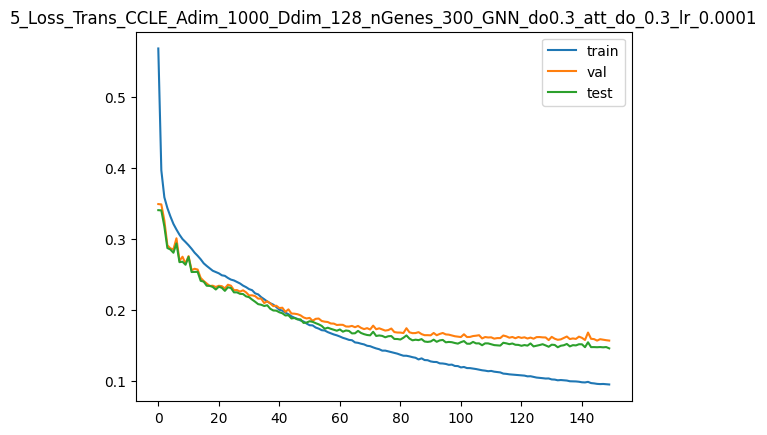

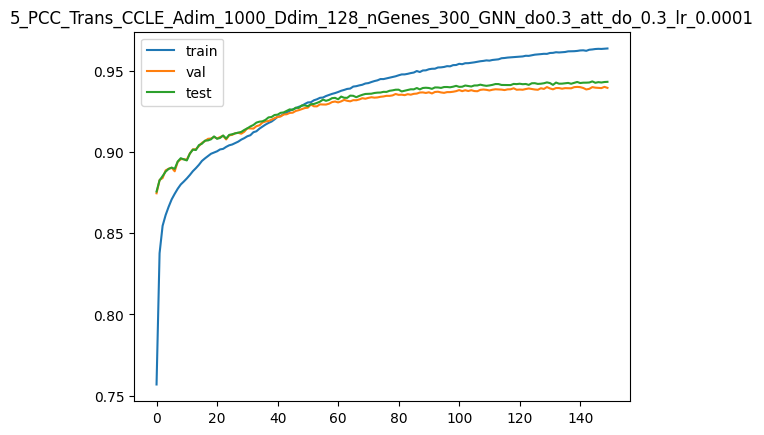

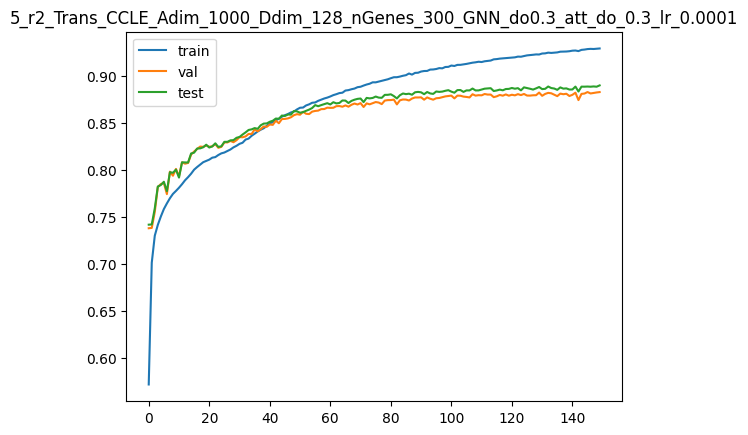

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1468971
Test avg_pcc:  0.9426206865913299
Test r2:  0.8883922340581568


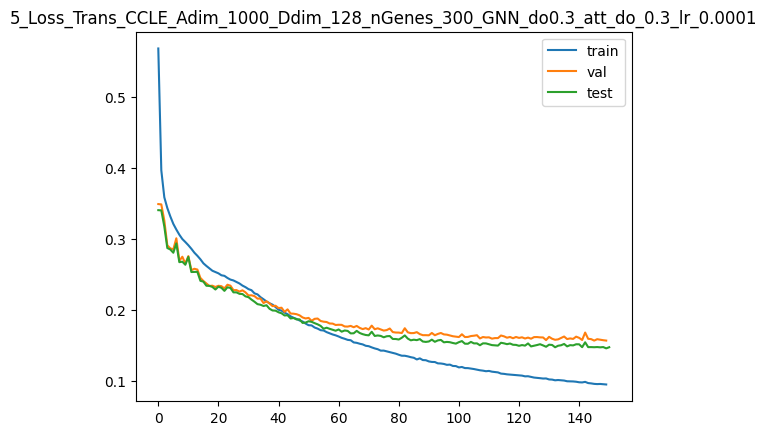

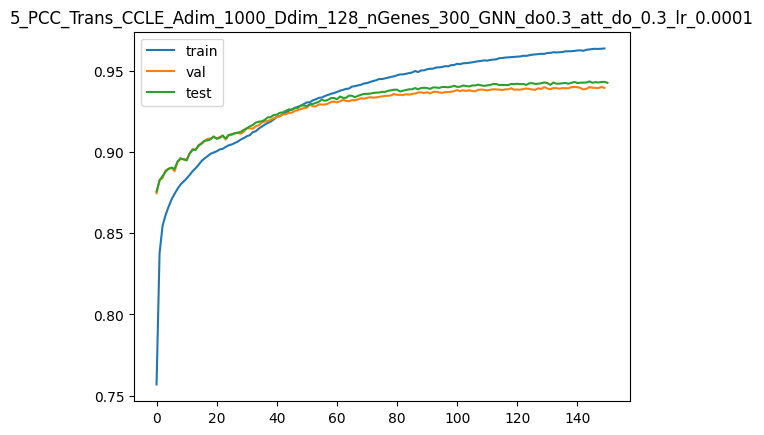

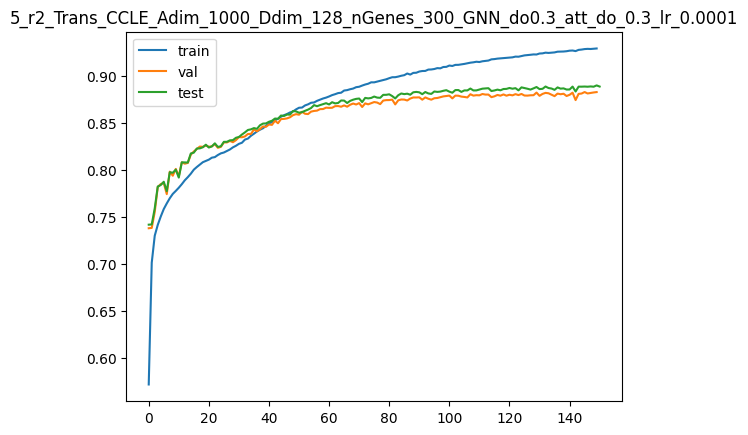

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.5592129
Train avg_pcc:  0.7608053938004264
Train r2:  0.5779411481235053


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.50853956
Validation avg_pcc:  0.8634293217757539
Validation r2:  0.6165756527321224
Best Val r2  0.6165756527321224


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.50956196
Test avg_pcc:  0.86490787364612
Test r2:  0.6173296810519815
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.38726473
Train avg_pcc:  0.8414558332696476
Train r2:  0.7077168770867519


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.35960317
Validation avg_pcc:  0.8773169798121213
Validation r2:  0.7288694340554004
Best Val r2  0.7288694340554004


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.36134842
Test avg_pcc:  0.8778505356757909
Test r2:  0.7286349728194528
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3531906
Train avg_pcc:  0.8565414732393516
Train r2:  0.7334338861524267


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.36687893
Validation avg_pcc:  0.8775308701791522
Validation r2:  0.7233837466527124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3631782
Test avg_pcc:  0.8804644603863256
Test r2:  0.7272608130263315
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.33460113
Train avg_pcc:  0.8646332990345152
Train r2:  0.7474640238702241


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32987598
Validation avg_pcc:  0.8825446856660593
Validation r2:  0.7512828851399698
Best Val r2  0.7512828851399698


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3305775
Test avg_pcc:  0.8834568607123339
Test r2:  0.7517432713243812
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.32445577
Train avg_pcc:  0.8690331556361269
Train r2:  0.7551210999305146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29348665
Validation avg_pcc:  0.8875824129140043
Validation r2:  0.7787194047300736
Best Val r2  0.7787194047300736


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2969323
Test avg_pcc:  0.8872119157740971
Test r2:  0.7770101104445056
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.31549433
Train avg_pcc:  0.8729008882795705
Train r2:  0.7618846589618347


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28588772
Validation avg_pcc:  0.8877496837372671
Validation r2:  0.7844487990466843
Best Val r2  0.7844487990466843


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28617206
Test avg_pcc:  0.8883987401637355
Test r2:  0.7850908167219032
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.30703452
Train avg_pcc:  0.8765338140398307
Train r2:  0.7682695771802105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2780058
Validation avg_pcc:  0.8900685193550847
Validation r2:  0.7903915237142638
Best Val r2  0.7903915237142638


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2787794
Test avg_pcc:  0.8904275635169907
Test r2:  0.7906425471414218
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3004112
Train avg_pcc:  0.8793744271198476
Train r2:  0.7732684392663844


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32259515
Validation avg_pcc:  0.8885824784694186
Validation r2:  0.7567724332010624


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32418594
Test avg_pcc:  0.8892970615514065
Test r2:  0.7565432053029022
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29473665
Train avg_pcc:  0.8818004854577643
Train r2:  0.7775512388766417


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29378965
Validation avg_pcc:  0.8885095241037664
Validation r2:  0.778490961452132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29574877
Test avg_pcc:  0.8889079139734503
Test r2:  0.7778989171373202
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29096076
Train avg_pcc:  0.8834124098061016
Train r2:  0.7804010597404742


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26900125
Validation avg_pcc:  0.8942159678248793
Validation r2:  0.797180722532355
Best Val r2  0.797180722532355


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2696158
Test avg_pcc:  0.8942491324605297
Test r2:  0.797524205949138
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.28655237
Train avg_pcc:  0.885295487452093
Train r2:  0.7837282235249192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26669714
Validation avg_pcc:  0.8947725576538536
Validation r2:  0.7989179475165469
Best Val r2  0.7989179475165469


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2661746
Test avg_pcc:  0.8956580125034176
Test r2:  0.8001084715536854
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2804227
Train avg_pcc:  0.8878973414774488
Train r2:  0.7883545181339646


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26525974
Validation avg_pcc:  0.8963624173306389
Validation r2:  0.800001704535308
Best Val r2  0.800001704535308


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26483774
Test avg_pcc:  0.8974157653088636
Test r2:  0.8011124243556937
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.27537572
Train avg_pcc:  0.8900425039160004
Train r2:  0.7921636765956019


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25375015
Validation avg_pcc:  0.8995320457563504
Validation r2:  0.808679601355989
Best Val r2  0.808679601355989


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25439805
Test avg_pcc:  0.8997305357900351
Test r2:  0.8089524170207811
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26997823
Train avg_pcc:  0.8923271491825464
Train r2:  0.7962373262216108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25942937
Validation avg_pcc:  0.8989350650319353
Validation r2:  0.8043976162892308


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26257288
Test avg_pcc:  0.8985814350557807
Test r2:  0.8028133038989074
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26505342
Train avg_pcc:  0.8944074809664334
Train r2:  0.7999542721539469


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25258467
Validation avg_pcc:  0.9018098140019803
Validation r2:  0.809558349238154
Best Val r2  0.809558349238154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25406542
Test avg_pcc:  0.9021177828502956
Test r2:  0.8092022181541361
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26213387
Train avg_pcc:  0.8956397015162297
Train r2:  0.8021577871619943


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25087854
Validation avg_pcc:  0.902110850327978
Validation r2:  0.8108447174208089
Best Val r2  0.8108447174208089


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25213176
Test avg_pcc:  0.9023781140932943
Test r2:  0.8106543846223776
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25712055
Train avg_pcc:  0.8977476524829434
Train r2:  0.8059415240530388


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24473642
Validation avg_pcc:  0.9034971954745441
Validation r2:  0.8154757142373856
Best Val r2  0.8154757142373856


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2439435
Test avg_pcc:  0.9041810629511958
Test r2:  0.8168035879162585
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25431272
Train avg_pcc:  0.8989286527958045
Train r2:  0.8080606859562733


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2455855
Validation avg_pcc:  0.9039198909931736
Validation r2:  0.8148355165988512


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24700923
Test avg_pcc:  0.9039488283043029
Test r2:  0.8145012867105265
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2517761
Train avg_pcc:  0.8999901471871494
Train r2:  0.8099751692083689


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24312696
Validation avg_pcc:  0.9046797326824042
Validation r2:  0.8166891912915448
Best Val r2  0.8166891912915448


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24406692
Test avg_pcc:  0.9049933547221393
Test r2:  0.8167108809553093
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24930516
Train avg_pcc:  0.9010271360867381
Train r2:  0.8118400771794448


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24112967
Validation avg_pcc:  0.9051205825143801
Validation r2:  0.8181950984097894
Best Val r2  0.8181950984097894


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24165054
Test avg_pcc:  0.9052135647751024
Test r2:  0.8185255375055059
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24743585
Train avg_pcc:  0.9018094614075242
Train r2:  0.8132509325480037


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24019812
Validation avg_pcc:  0.9050707714467555
Validation r2:  0.8188974504403587
Best Val r2  0.8188974504403587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24199349
Test avg_pcc:  0.9048179658045765
Test r2:  0.8182679915681996
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24559075
Train avg_pcc:  0.9025812425439679
Train r2:  0.8146434778241235


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23816861
Validation avg_pcc:  0.9068015957661513
Validation r2:  0.8204276508628658
Best Val r2  0.8204276508628658


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23981345
Test avg_pcc:  0.9067603433729601
Test r2:  0.8199051683922398
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24452174
Train avg_pcc:  0.9030267173164132
Train r2:  0.8154503040676625


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23655444
Validation avg_pcc:  0.9072253103799632
Validation r2:  0.8216446876934519
Best Val r2  0.8216446876934519


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23884034
Test avg_pcc:  0.906941762449637
Test r2:  0.8206359426422782
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24284856
Train avg_pcc:  0.9037244703220348
Train r2:  0.8167131314229226


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23745108
Validation avg_pcc:  0.9073182711079056
Validation r2:  0.8209686487918422


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24050152
Test avg_pcc:  0.906635573675478
Test r2:  0.8193884234911369
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24111913
Train avg_pcc:  0.9044489477156265
Train r2:  0.8180184123198158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23442589
Validation avg_pcc:  0.907624552402125
Validation r2:  0.8232495468207264
Best Val r2  0.8232495468207264


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23640858
Test avg_pcc:  0.9074102233773671
Test r2:  0.8224621499200439
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23885319
Train avg_pcc:  0.9053920699864597
Train r2:  0.8197285687580544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23474711
Validation avg_pcc:  0.9088853681351121
Validation r2:  0.8230073578248209


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24036336
Test avg_pcc:  0.9073295489629781
Test r2:  0.8194921879622228
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23785084
Train avg_pcc:  0.9058096614092881
Train r2:  0.820485081873813


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23591757
Validation avg_pcc:  0.9080032885525404
Validation r2:  0.8221248683752094


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23933643
Test avg_pcc:  0.9070819663485519
Test r2:  0.8202633898333431
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23540431
Train avg_pcc:  0.9068278137266524
Train r2:  0.822331563385645


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23209013
Validation avg_pcc:  0.9091135192630401
Validation r2:  0.8250106515640344
Best Val r2  0.8250106515640344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23392716
Test avg_pcc:  0.9088191441933219
Test r2:  0.824325639845531
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23323898
Train avg_pcc:  0.907729620477733
Train r2:  0.8239658360529176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22991827
Validation avg_pcc:  0.9097713189093191
Validation r2:  0.8266481621209499
Best Val r2  0.8266481621209499


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23295796
Test avg_pcc:  0.9086451285702422
Test r2:  0.8250534873318137
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23115908
Train avg_pcc:  0.9085927226268788
Train r2:  0.825535611009028


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23221627
Validation avg_pcc:  0.9100824367024337
Validation r2:  0.8249155541306841


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23533814
Test avg_pcc:  0.909214508113877
Test r2:  0.8232660280886938
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22930522
Train avg_pcc:  0.9093617517080486
Train r2:  0.8269347854167938


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22489008
Validation avg_pcc:  0.9119420022307666
Validation r2:  0.8304392814836609
Best Val r2  0.8304392814836609


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23044631
Test avg_pcc:  0.910247949754527
Test r2:  0.8269396822101117
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22712007
Train avg_pcc:  0.9102703290968681
Train r2:  0.8285840190299956


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22312713
Validation avg_pcc:  0.9124479859609758
Validation r2:  0.8317685010289614
Best Val r2  0.8317685010289614


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22755314
Test avg_pcc:  0.9111314571432289
Test r2:  0.8291123742318632
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22509232
Train avg_pcc:  0.9111091701773146
Train r2:  0.8301144308455539


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22442758
Validation avg_pcc:  0.912891265662597
Validation r2:  0.8307879818292669


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22856238
Test avg_pcc:  0.9118727933514058
Test r2:  0.8283544743656217
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22169432
Train avg_pcc:  0.9125152932154422
Train r2:  0.8326790302054865


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22008434
Validation avg_pcc:  0.9146804142162441
Validation r2:  0.8340626699189096
Best Val r2  0.8340626699189096


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22387424
Test avg_pcc:  0.9131846124333676
Test r2:  0.8318751584704895
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21973868
Train avg_pcc:  0.9133238328232409
Train r2:  0.8341550143614933


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21524508
Validation avg_pcc:  0.9154393019841129
Validation r2:  0.8377113281004762
Best Val r2  0.8377113281004762


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22123139
Test avg_pcc:  0.9134804737392304
Test r2:  0.8338598950555345
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21592581
Train avg_pcc:  0.9148978830096494
Train r2:  0.8370327434367651


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21476655
Validation avg_pcc:  0.9154628649101878
Validation r2:  0.8380721267992266
Best Val r2  0.8380721267992266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21881478
Test avg_pcc:  0.9141744241986097
Test r2:  0.8356747141140025
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21441948
Train avg_pcc:  0.9155183749006789
Train r2:  0.8381696134406831


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21361683
Validation avg_pcc:  0.9168694729319395
Validation r2:  0.838938972717852
Best Val r2  0.838938972717852


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21738356
Test avg_pcc:  0.9158759687199155
Test r2:  0.8367495227069844
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21105422
Train avg_pcc:  0.9169042763343117
Train r2:  0.840709493908568


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21016556
Validation avg_pcc:  0.918388268458857
Validation r2:  0.8415411433096045
Best Val r2  0.8415411433096045


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21305756
Test avg_pcc:  0.91772277867458
Test r2:  0.8399982419208072
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20861867
Train avg_pcc:  0.9179078428029016
Train r2:  0.8425476863200281


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20677444
Validation avg_pcc:  0.9191029320442796
Validation r2:  0.8440979480571812
Best Val r2  0.8440979480571812


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21229646
Test avg_pcc:  0.9171475552495619
Test r2:  0.8405698449500263
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2059653
Train avg_pcc:  0.9189962409161329
Train r2:  0.8445502956873354


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2067256
Validation avg_pcc:  0.919348622088455
Validation r2:  0.8441347768596978
Best Val r2  0.8441347768596978


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21113501
Test avg_pcc:  0.9181101029696603
Test r2:  0.8414420700587052
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20350541
Train avg_pcc:  0.9200071626504616
Train r2:  0.8464068740017346


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20107093
Validation avg_pcc:  0.9211772111894376
Validation r2:  0.8483982262301474
Best Val r2  0.8483982262301474


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2062469
Test avg_pcc:  0.9194818893217359
Test r2:  0.8451129334324423
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20072666
Train avg_pcc:  0.9211446021058184
Train r2:  0.8485041101253326


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20165882
Validation avg_pcc:  0.921596286114747
Validation r2:  0.8479549892564058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20596516
Test avg_pcc:  0.9198946356395513
Test r2:  0.8453245028924439
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19803771
Train avg_pcc:  0.9222463074308844
Train r2:  0.8505335443346295


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19802469
Validation avg_pcc:  0.9224204659615376
Validation r2:  0.8506950127901304
Best Val r2  0.8506950127901304


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20394984
Test avg_pcc:  0.9204540787412754
Test r2:  0.8468379796543595
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19528668
Train avg_pcc:  0.9233714380921837
Train r2:  0.8526098703325464


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19496715
Validation avg_pcc:  0.9238095196623627
Validation r2:  0.85300031564558
Best Val r2  0.85300031564558


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1986684
Test avg_pcc:  0.9225280953613719
Test r2:  0.8508042144259074
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19240166
Train avg_pcc:  0.9245496906968422
Train r2:  0.8547872740211272


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19602506
Validation avg_pcc:  0.9233892579365249
Validation r2:  0.8522026690005999


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19965577
Test avg_pcc:  0.9223085121817609
Test r2:  0.8500627189921032
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19050722
Train avg_pcc:  0.9253223283193593
Train r2:  0.8562170983099207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19649144
Validation avg_pcc:  0.9240831708724888
Validation r2:  0.8518510435337795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20198084
Test avg_pcc:  0.9225265390863739
Test r2:  0.8483166589339899
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18880965
Train avg_pcc:  0.926015330942058
Train r2:  0.8574983211247945


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19602765
Validation avg_pcc:  0.9250944434124924
Validation r2:  0.8522007216274259


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20253354
Test avg_pcc:  0.9232961556375437
Test r2:  0.847901566618752
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1863924
Train avg_pcc:  0.9269994037987318
Train r2:  0.8593227088864106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1898381
Validation avg_pcc:  0.9258320495863772
Validation r2:  0.856867465157213
Best Val r2  0.856867465157213


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19472791
Test avg_pcc:  0.9241730940325575
Test r2:  0.8537634588874804
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18423292
Train avg_pcc:  0.9278769487261197
Train r2:  0.8609525470800711


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1909746
Validation avg_pcc:  0.9256001196309658
Validation r2:  0.8560106008111377


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.197567
Test avg_pcc:  0.923289370648806
Test r2:  0.8516313563931908
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18209776
Train avg_pcc:  0.9287453649834
Train r2:  0.8625640160062362


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18977106
Validation avg_pcc:  0.9259291036908163
Validation r2:  0.8569180314161602
Best Val r2  0.8569180314161602


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1933104
Test avg_pcc:  0.9246662717200863
Test r2:  0.8548279723294605


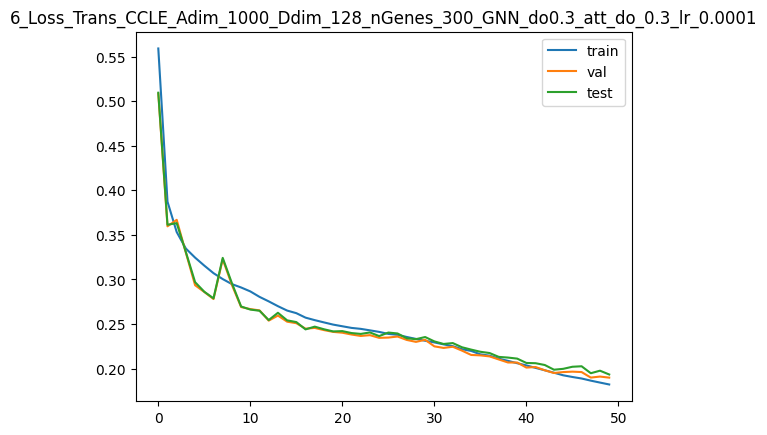

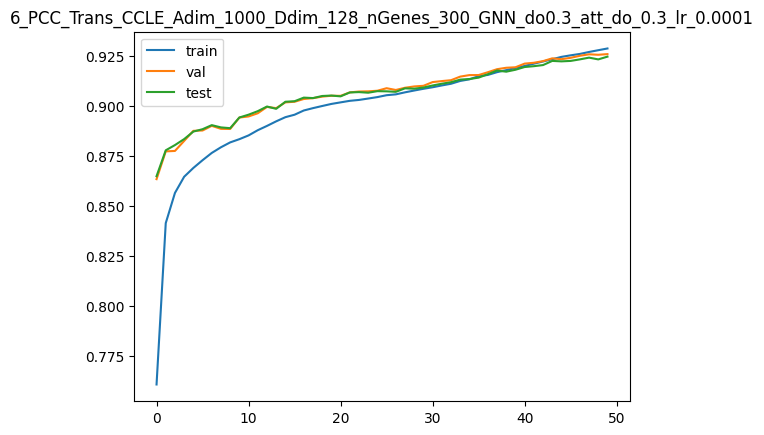

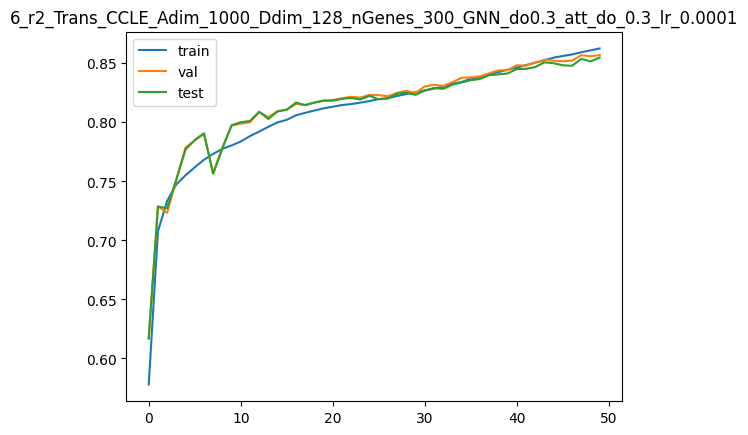

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17969948
Train avg_pcc:  0.9297196956372249
Train r2:  0.8643741002771101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18686926
Validation avg_pcc:  0.9269060656944279
Validation r2:  0.8591058770434771
Best Val r2  0.8591058770434771


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19099005
Test avg_pcc:  0.9255879118142527
Test r2:  0.8565704946017787
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17819536
Train avg_pcc:  0.9303301874860965
Train r2:  0.8655093212802965


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18602496
Validation avg_pcc:  0.9274213249061495
Validation r2:  0.8597424760715924
Best Val r2  0.8597424760715924


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19087283
Test avg_pcc:  0.9259261880159312
Test r2:  0.8566585336205216
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17624874
Train avg_pcc:  0.9311189178410333
Train r2:  0.8669784955335555


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18698338
Validation avg_pcc:  0.926853272368602
Validation r2:  0.8590198477062989


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19148152
Test avg_pcc:  0.9253738574259179
Test r2:  0.8562014101266602
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17539272
Train avg_pcc:  0.9314655806387654
Train r2:  0.8676245556016158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18500948
Validation avg_pcc:  0.9278556797243909
Validation r2:  0.8605081223916394
Best Val r2  0.8605081223916394


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18810248
Test avg_pcc:  0.926932193019027
Test r2:  0.8587390017355785
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17278111
Train avg_pcc:  0.9325230481854964
Train r2:  0.86959565396914


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18486051
Validation avg_pcc:  0.9282392275844852
Validation r2:  0.8606204365908295
Best Val r2  0.8606204365908295


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18941046
Test avg_pcc:  0.9269953285953164
Test r2:  0.8577567373189874
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17100619
Train avg_pcc:  0.9332410782179297
Train r2:  0.8709352596026029


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18476757
Validation avg_pcc:  0.9294142589053915
Validation r2:  0.8606905073745057
Best Val r2  0.8606905073745057


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18933128
Test avg_pcc:  0.9282440004506249
Test r2:  0.8578162057613065
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1690997
Train avg_pcc:  0.9340121140606614
Train r2:  0.8723741430266845


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18333344
Validation avg_pcc:  0.9294703412465642
Validation r2:  0.861771788112546
Best Val r2  0.861771788112546


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18765037
Test avg_pcc:  0.9283387787611639
Test r2:  0.8590785351174183
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16788906
Train avg_pcc:  0.9345012632662617
Train r2:  0.8732878568708222


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17823689
Validation avg_pcc:  0.9304233063956165
Validation r2:  0.8656144692223992
Best Val r2  0.8656144692223992


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18154234
Test avg_pcc:  0.9293844534206436
Test r2:  0.8636655329885594
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16632812
Train avg_pcc:  0.9351305291489367
Train r2:  0.8744659667821946


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17825572
Validation avg_pcc:  0.9309700405985771
Validation r2:  0.865600258113911


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18260138
Test avg_pcc:  0.9292713297162416
Test r2:  0.8628702263608105
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16578875
Train avg_pcc:  0.9353490000402347
Train r2:  0.8748730482475215


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17921624
Validation avg_pcc:  0.9303482019148015
Validation r2:  0.8648760617860516


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18241552
Test avg_pcc:  0.9295670533935111
Test r2:  0.863009795273027
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16203798
Train avg_pcc:  0.9368598905634323
Train r2:  0.877703884605164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17496477
Validation avg_pcc:  0.9318304478138206
Validation r2:  0.868081543108711
Best Val r2  0.868081543108711


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17891012
Test avg_pcc:  0.9305739966332706
Test r2:  0.8656422715523122
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16254972
Train avg_pcc:  0.9366547822925456
Train r2:  0.8773176612468232


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17842859
Validation avg_pcc:  0.9309963637828569
Validation r2:  0.8654699194500783


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1832493
Test avg_pcc:  0.9296168992860383
Test r2:  0.8623836479718837
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15977739
Train avg_pcc:  0.9377706577773989
Train r2:  0.8794100439270076


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17601626
Validation avg_pcc:  0.9321169190988161
Validation r2:  0.8672887472341758


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1805133
Test avg_pcc:  0.9308636997774072
Test r2:  0.8644383219560124
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1583762
Train avg_pcc:  0.9383336625842805
Train r2:  0.8804675718041008


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17470695
Validation avg_pcc:  0.9319614344253954
Validation r2:  0.8682759301991729
Best Val r2  0.8682759301991729


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17854355
Test avg_pcc:  0.9308095392802389
Test r2:  0.8659175567754718
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15676144
Train avg_pcc:  0.9389839893029188
Train r2:  0.8816863011986742


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17455637
Validation avg_pcc:  0.932222951302689
Validation r2:  0.8683894644151489
Best Val r2  0.8683894644151489


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18121926
Test avg_pcc:  0.9300318480762645
Test r2:  0.8639081560400128
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15595202
Train avg_pcc:  0.939308019630946
Train r2:  0.8822971852126168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17872418
Validation avg_pcc:  0.9329733525843068
Validation r2:  0.8652470479001232


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18498573
Test avg_pcc:  0.9312697751857522
Test r2:  0.8610796243728985
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15410046
Train avg_pcc:  0.9400522489384081
Train r2:  0.8836946210226249


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.172014
Validation avg_pcc:  0.9332489038798925
Validation r2:  0.8703063377963025
Best Val r2  0.8703063377963025


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17506778
Test avg_pcc:  0.9322372621025341
Test r2:  0.8685277828627697
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15282026
Train avg_pcc:  0.9405662099553955
Train r2:  0.8846608445129709


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1728656
Validation avg_pcc:  0.9331948515548065
Validation r2:  0.8696642583045455


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17826127
Test avg_pcc:  0.9313806219633277
Test r2:  0.8661295504412636
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15064849
Train avg_pcc:  0.9414365428694806
Train r2:  0.8862999619614514


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17081515
Validation avg_pcc:  0.9340266731684483
Validation r2:  0.8712102376930786
Best Val r2  0.8712102376930786


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17554872
Test avg_pcc:  0.9326471437272006
Test r2:  0.8681666115812103
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15027232
Train avg_pcc:  0.9415876466246367
Train r2:  0.8865838708190449


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17056625
Validation avg_pcc:  0.9339740882674439
Validation r2:  0.8713979108626645
Best Val r2  0.8713979108626645


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17581446
Test avg_pcc:  0.932370421367883
Test r2:  0.867967046127821
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14908965
Train avg_pcc:  0.9420615128123503
Train r2:  0.88747648456029


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16907698
Validation avg_pcc:  0.9343486710923778
Validation r2:  0.8725207588608479
Best Val r2  0.8725207588608479


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1730495
Test avg_pcc:  0.9331812305391534
Test r2:  0.8700434766190028
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14829178
Train avg_pcc:  0.9423808864216258
Train r2:  0.8880786598155246


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16809538
Validation avg_pcc:  0.9346820978190853
Validation r2:  0.8732608664056074
Best Val r2  0.8732608664056074


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17304026
Test avg_pcc:  0.9330909287458193
Test r2:  0.8700504251109915
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14693661
Train avg_pcc:  0.9429236894466128
Train r2:  0.8891014572695377


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16976056
Validation avg_pcc:  0.9346690050749771
Validation r2:  0.8720053831709689


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17413582
Test avg_pcc:  0.933334991397327
Test r2:  0.8692276745626756
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14516056
Train avg_pcc:  0.9436338713506917
Train r2:  0.8904419027831666


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16748168
Validation avg_pcc:  0.9347469506927352
Validation r2:  0.8737235740342565
Best Val r2  0.8737235740342565


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17055064
Test avg_pcc:  0.9337795756260728
Test r2:  0.871920056543329
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1449275
Train avg_pcc:  0.9437265230424131
Train r2:  0.8906178092761341


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16692473
Validation avg_pcc:  0.9350088007357751
Validation r2:  0.8741435091501104
Best Val r2  0.8741435091501104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16987842
Test avg_pcc:  0.9341696840785106
Test r2:  0.8724248911753354
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14277859
Train avg_pcc:  0.9445860516529632
Train r2:  0.8922396771004626


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16723749
Validation avg_pcc:  0.9351276692280779
Validation r2:  0.873907690675465


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16994983
Test avg_pcc:  0.9344717588069996
Test r2:  0.8723712645503308
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14199828
Train avg_pcc:  0.9448979895961384
Train r2:  0.892828586434534


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1656927
Validation avg_pcc:  0.9354603642809478
Validation r2:  0.8750724189640462
Best Val r2  0.8750724189640462


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16940838
Test avg_pcc:  0.9342549513814308
Test r2:  0.8727778787532148
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14045788
Train avg_pcc:  0.9455130836888299
Train r2:  0.8939911944635717


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16746436
Validation avg_pcc:  0.9355904318846967
Validation r2:  0.8737366348662906


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17213465
Test avg_pcc:  0.9342099400168056
Test r2:  0.8707305058880705
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13959529
Train avg_pcc:  0.9458563419379119
Train r2:  0.8946422200373885


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16518605
Validation avg_pcc:  0.9361866701563553
Validation r2:  0.875454427905808
Best Val r2  0.875454427905808


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16837269
Test avg_pcc:  0.9354114660337395
Test r2:  0.8735556609788641
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13826644
Train avg_pcc:  0.9463867830946538
Train r2:  0.8956451509362835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16370243
Validation avg_pcc:  0.9365043495767489
Validation r2:  0.8765730209512076
Best Val r2  0.8765730209512076


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16600688
Test avg_pcc:  0.9357149339756353
Test r2:  0.8753323268892221
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13714579
Train avg_pcc:  0.9468333563160728
Train r2:  0.8964909444614579


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1638111
Validation avg_pcc:  0.9363154461718214
Validation r2:  0.8764910908329286


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16712928
Test avg_pcc:  0.9351848532038637
Test r2:  0.8744894297403083
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13690181
Train avg_pcc:  0.9469311226097085
Train r2:  0.8966751003562734


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16409025
Validation avg_pcc:  0.9364976553922039
Validation r2:  0.8762806166892823


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16800213
Test avg_pcc:  0.9353850363637518
Test r2:  0.8738339407219743
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13539936
Train avg_pcc:  0.9475292177970895
Train r2:  0.8978090491021273


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16453947
Validation avg_pcc:  0.9362126010888538
Validation r2:  0.8759419302067964


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16788146
Test avg_pcc:  0.9350237873673554
Test r2:  0.8739245659764887
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13500018
Train avg_pcc:  0.9476884468188682
Train r2:  0.8981103161387363


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16227648
Validation avg_pcc:  0.9372058760126645
Validation r2:  0.8776481619707165
Best Val r2  0.8776481619707165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16495776
Test avg_pcc:  0.9364470680508447
Test r2:  0.8761202058695006
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13290417
Train avg_pcc:  0.9485228942213291
Train r2:  0.8996922667844028


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16296387
Validation avg_pcc:  0.9367622199068535
Validation r2:  0.8771298781818302


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16551267
Test avg_pcc:  0.9359827179499786
Test r2:  0.8757034742567652
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13255449
Train avg_pcc:  0.9486614432007645
Train r2:  0.899956169905693


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16194017
Validation avg_pcc:  0.9377935903995988
Validation r2:  0.877901704557213
Best Val r2  0.877901704557213


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1667891
Test avg_pcc:  0.9363989381540617
Test r2:  0.8747449053737214
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13187593
Train avg_pcc:  0.9489321194682766
Train r2:  0.9004683079756024


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16376273
Validation avg_pcc:  0.9373723269136534
Validation r2:  0.8765275554886719


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16591689
Test avg_pcc:  0.9370687615584231
Test r2:  0.8753999172084715
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13017495
Train avg_pcc:  0.949608288348796
Train r2:  0.9017521073471387


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16225865
Validation avg_pcc:  0.9368733117142352
Validation r2:  0.8776615873257192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16574557
Test avg_pcc:  0.9358189830633143
Test r2:  0.8755285646555727
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12873
Train avg_pcc:  0.9501815506293023
Train r2:  0.9028426638729954


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16321506
Validation avg_pcc:  0.9374743781374207
Validation r2:  0.8769404914991482


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16712889
Test avg_pcc:  0.9364755811883916
Test r2:  0.8744897355928548
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12812436
Train avg_pcc:  0.9504221417447171
Train r2:  0.9032997613419936


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16059572
Validation avg_pcc:  0.9377268608306073
Validation r2:  0.8789154020664107
Best Val r2  0.8789154020664107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16322148
Test avg_pcc:  0.9371072587040662
Test r2:  0.877424113503173
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12829787
Train avg_pcc:  0.950353440410716
Train r2:  0.9031688086279515


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16188726
Validation avg_pcc:  0.9373249850216997
Validation r2:  0.8779416200081316


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16273828
Test avg_pcc:  0.9373250957880237
Test r2:  0.8777869874376932
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1267801
Train avg_pcc:  0.9509555611003581
Train r2:  0.9043143227572408


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16055399
Validation avg_pcc:  0.9376079466140564
Validation r2:  0.878946857548787
Best Val r2  0.878946857548787


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16346158
Test avg_pcc:  0.9366414342123255
Test r2:  0.877243801925268
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12540378
Train avg_pcc:  0.9515021991950133
Train r2:  0.9053530863713666


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16315147
Validation avg_pcc:  0.9372646001667897
Validation r2:  0.8769884271881133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16507152
Test avg_pcc:  0.9366841008776795
Test r2:  0.8760347703242373
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12569024
Train avg_pcc:  0.9513882433224186
Train r2:  0.905136888275508


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16126235
Validation avg_pcc:  0.9375288512110054
Validation r2:  0.8784127771444714


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16349705
Test avg_pcc:  0.9369902501862363
Test r2:  0.8772171745359615
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.124576926
Train avg_pcc:  0.9518296505238737
Train r2:  0.9059771474822056


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15957297
Validation avg_pcc:  0.9384407506297221
Validation r2:  0.879686518712483
Best Val r2  0.879686518712483


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1618005
Test avg_pcc:  0.9377009699021832
Test r2:  0.878491237410165
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1241674
Train avg_pcc:  0.9519918155169911
Train r2:  0.9062862374320573


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16354975
Validation avg_pcc:  0.9379435933031277
Validation r2:  0.876688145527416


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1657801
Test avg_pcc:  0.937518253216239
Test r2:  0.8755026439106856
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12292871
Train avg_pcc:  0.9524834008816162
Train r2:  0.9072211128635678


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15892705
Validation avg_pcc:  0.9382813171903073
Validation r2:  0.88017352267221
Best Val r2  0.88017352267221


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16026199
Test avg_pcc:  0.9380130834351358
Test r2:  0.879646626739299
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12195532
Train avg_pcc:  0.9528684894433134
Train r2:  0.907955767934743


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15843056
Validation avg_pcc:  0.9384401999935059
Validation r2:  0.880547865783988
Best Val r2  0.880547865783988


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15978315
Test avg_pcc:  0.9382473933555436
Test r2:  0.8800062271167018
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12208168
Train avg_pcc:  0.9528190966217644
Train r2:  0.907860395101713


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15779333
Validation avg_pcc:  0.938688657635197
Validation r2:  0.881028320484512
Best Val r2  0.881028320484512


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15994023
Test avg_pcc:  0.9380898072402563
Test r2:  0.8798882691877872
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.120193765
Train avg_pcc:  0.9535656339368714
Train r2:  0.9092852791315297


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1593345
Validation avg_pcc:  0.9386256081231047
Validation r2:  0.8798663103287744


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16100791
Test avg_pcc:  0.9384122410084421
Test r2:  0.8790864536017782


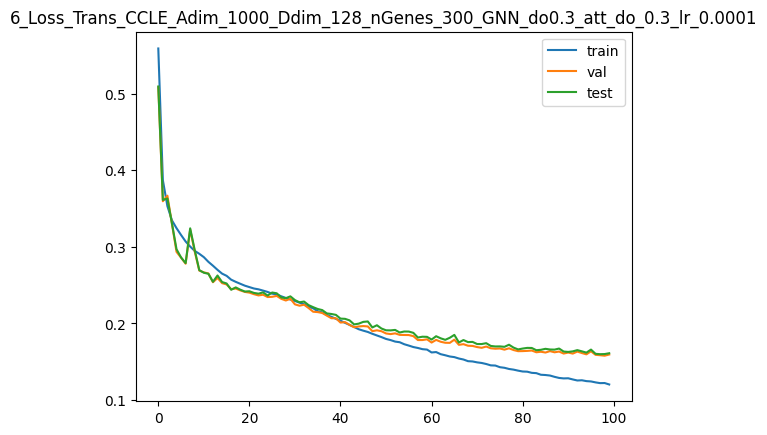

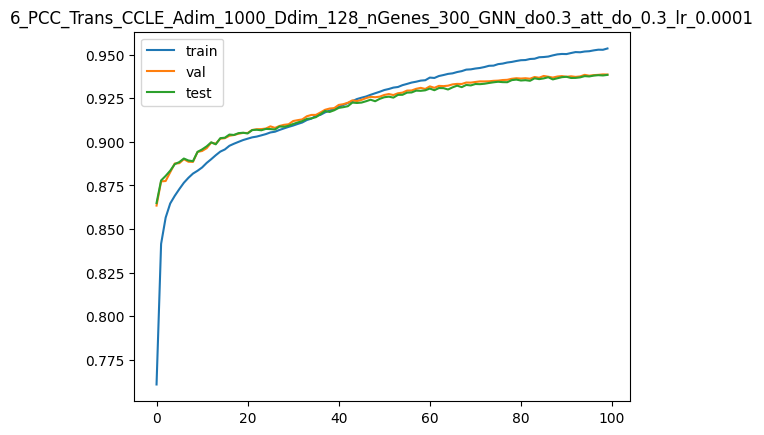

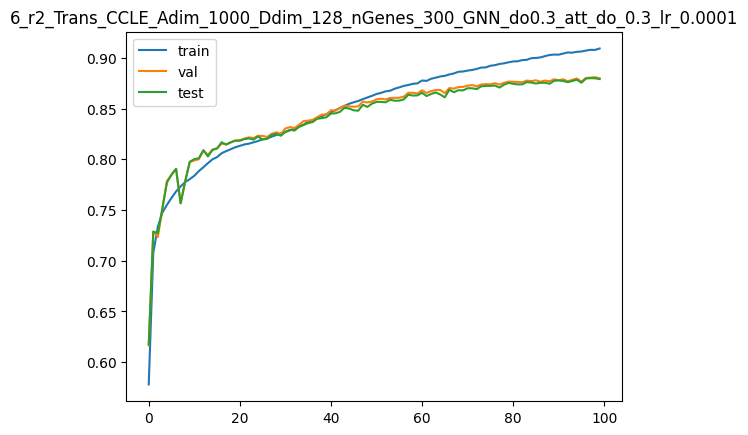

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11961818
Train avg_pcc:  0.95379373521051
Train r2:  0.909719697158799


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15712999
Validation avg_pcc:  0.9395577657413825
Validation r2:  0.8815284531408956
Best Val r2  0.8815284531408956


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16163689
Test avg_pcc:  0.9382048278184607
Test r2:  0.8786141190643251
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11902843
Train avg_pcc:  0.9540270556827143
Train r2:  0.9101648060276207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15959087
Validation avg_pcc:  0.9390831224366891
Validation r2:  0.8796730189369326


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16186658
Test avg_pcc:  0.9386814940168158
Test r2:  0.8784416165444552
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11839488
Train avg_pcc:  0.9542770897036489
Train r2:  0.9106429681370821


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1581654
Validation avg_pcc:  0.9389266553365222
Validation r2:  0.8807477895904757


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15987709
Test avg_pcc:  0.9386655777050362
Test r2:  0.8799356735924159
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11856768
Train avg_pcc:  0.9542092214549925
Train r2:  0.9105125437104866


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15668885
Validation avg_pcc:  0.9390846930040339
Validation r2:  0.8818610602000834
Best Val r2  0.8818610602000834


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15746962
Test avg_pcc:  0.9390194983443051
Test r2:  0.881743630207342
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11773502
Train avg_pcc:  0.9545394188964013
Train r2:  0.9111409835245805


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15911281
Validation avg_pcc:  0.938775001986039
Validation r2:  0.8800334697181573


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15905985
Test avg_pcc:  0.9390469218224593
Test r2:  0.8805493997299672
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11640719
Train avg_pcc:  0.9550629846369577
Train r2:  0.9121431402417617


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1577335
Validation avg_pcc:  0.9391034220847702
Validation r2:  0.8810734364764019


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15813304
Test avg_pcc:  0.939374126935934
Test r2:  0.8812454067635834
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11589131
Train avg_pcc:  0.9552672593496238
Train r2:  0.9125324940879066


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1587469
Validation avg_pcc:  0.9390688456264925
Validation r2:  0.8803093538365627


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1597139
Test avg_pcc:  0.9392081366446597
Test r2:  0.8800582300099531
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11409225
Train avg_pcc:  0.9559775930887735
Train r2:  0.9138903262968172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15774767
Validation avg_pcc:  0.9391566410055662
Validation r2:  0.8810627437392407


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15902744
Test avg_pcc:  0.9389020154110492
Test r2:  0.8805737356616724
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.114180356
Train avg_pcc:  0.9559424432458317
Train r2:  0.9138238310352675


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15662651
Validation avg_pcc:  0.9393853901402419
Validation r2:  0.8819080617532098
Best Val r2  0.8819080617532098


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15839499
Test avg_pcc:  0.9390921068862836
Test r2:  0.8810487054512562
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11322719
Train avg_pcc:  0.9563190021246851
Train r2:  0.9145432195779262


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15749171
Validation avg_pcc:  0.9392072515379004
Validation r2:  0.8812557378425568


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15939401
Test avg_pcc:  0.9389329585414141
Test r2:  0.8802984610977004
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11282715
Train avg_pcc:  0.956476178982671
Train r2:  0.9148451348416848


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15912053
Validation avg_pcc:  0.9391110891229888
Validation r2:  0.880027649710475


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16058753
Test avg_pcc:  0.9389371101390447
Test r2:  0.8794021526957496
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1128256
Train avg_pcc:  0.9564781093174682
Train r2:  0.9148463000119132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15754035
Validation avg_pcc:  0.9392815138755777
Validation r2:  0.8812190497063463


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15809709
Test avg_pcc:  0.9394099035870711
Test r2:  0.8812724222665304
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11179815
Train avg_pcc:  0.9568829451742045
Train r2:  0.915621759387889


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.157548
Validation avg_pcc:  0.9394095743041755
Validation r2:  0.8812133011827619


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15902025
Test avg_pcc:  0.9393145605600042
Test r2:  0.8805791488805677
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11094677
Train avg_pcc:  0.9572182862643079
Train r2:  0.9162643407021732


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15711915
Validation avg_pcc:  0.9390968623217208
Validation r2:  0.8815366301455817


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15835427
Test avg_pcc:  0.9388785848572464
Test r2:  0.8810792752484526
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11112289
Train avg_pcc:  0.957149099468685
Train r2:  0.9161314131825311


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15628281
Validation avg_pcc:  0.93955025817487
Validation r2:  0.882167209146935
Best Val r2  0.882167209146935


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1566814
Test avg_pcc:  0.9398028104059672
Test r2:  0.8823355789698197
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11012526
Train avg_pcc:  0.9575416640545579
Train r2:  0.916884355777975


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15507224
Validation avg_pcc:  0.9397403600308989
Validation r2:  0.8830799510364361
Best Val r2  0.8830799510364361


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15618016
Test avg_pcc:  0.9395990235142511
Test r2:  0.8827120066111225
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.109439954
Train avg_pcc:  0.9578120707148532
Train r2:  0.9174015783038006


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15871975
Validation avg_pcc:  0.9396504253874369
Validation r2:  0.8803298343815791


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16066134
Test avg_pcc:  0.939428721092124
Test r2:  0.8793467234135054
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10912232
Train avg_pcc:  0.9579374670475587
Train r2:  0.9176413091396487


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15731347
Validation avg_pcc:  0.9400986697852857
Validation r2:  0.8813901240722491


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15889215
Test avg_pcc:  0.9400125074718947
Test r2:  0.880675339235293
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10834503
Train avg_pcc:  0.9582435814096866
Train r2:  0.9182279610370829


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15331799
Validation avg_pcc:  0.9405128607902933
Validation r2:  0.8844025922996981
Best Val r2  0.8844025922996981


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1549456
Test avg_pcc:  0.9401998804548098
Test r2:  0.8836391261875092
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10795035
Train avg_pcc:  0.9583987621892289
Train r2:  0.9185258398014035


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1574418
Validation avg_pcc:  0.9400335297974087
Validation r2:  0.8812933600958257


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15890762
Test avg_pcc:  0.9399944782808953
Test r2:  0.8806637285438178
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10647203
Train avg_pcc:  0.9589807599428339
Train r2:  0.9196415810192641


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15673988
Validation avg_pcc:  0.9398835240300188
Validation r2:  0.8818225853156474


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1577768
Test avg_pcc:  0.9399494720753127
Test r2:  0.8815129598832221
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10699672
Train avg_pcc:  0.9587740736600436
Train r2:  0.9192455812814784


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15592779
Validation avg_pcc:  0.9399574341389878
Validation r2:  0.8824348775166176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15764402
Test avg_pcc:  0.9396990909610132
Test r2:  0.881612676323056
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10632948
Train avg_pcc:  0.959037023796383
Train r2:  0.9197491816592853


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15388623
Validation avg_pcc:  0.9402349542374339
Validation r2:  0.8839741603381908


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15455973
Test avg_pcc:  0.9401887108973267
Test r2:  0.8839289045802751
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1052703
Train avg_pcc:  0.9594540650854625
Train r2:  0.9205485763551317


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15406689
Validation avg_pcc:  0.9403587092791569
Validation r2:  0.8838379387359291


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15522139
Test avg_pcc:  0.9403135399769856
Test r2:  0.883432012833629
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.105056144
Train avg_pcc:  0.9595372517502935
Train r2:  0.9207102126272806


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15773448
Validation avg_pcc:  0.9400943072765774
Validation r2:  0.8810726901451211


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15888774
Test avg_pcc:  0.9400452722255973
Test r2:  0.8806786584687938
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10453273
Train avg_pcc:  0.9597439904013576
Train r2:  0.9211052429570616


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.153606
Validation avg_pcc:  0.9406548994536199
Validation r2:  0.8841854430749891


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1553174
Test avg_pcc:  0.9403546014861471
Test r2:  0.8833599105554366
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10420545
Train avg_pcc:  0.9598722955864799
Train r2:  0.9213522433448929


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15494569
Validation avg_pcc:  0.9403951541887438
Validation r2:  0.8831753490020342


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15582652
Test avg_pcc:  0.9405340039753165
Test r2:  0.8829775705797869
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.103496574
Train avg_pcc:  0.9601508583389602
Train r2:  0.9218872653436732


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15450181
Validation avg_pcc:  0.9403419160330028
Validation r2:  0.8835100278534201


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15459614
Test avg_pcc:  0.9407004596924582
Test r2:  0.8839015654703777
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10308131
Train avg_pcc:  0.9603143902243344
Train r2:  0.9222006925118169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15379778
Validation avg_pcc:  0.9405500330925042
Validation r2:  0.8840408429589027


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15487479
Test avg_pcc:  0.9404091990967626
Test r2:  0.883692303599825
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10210266
Train avg_pcc:  0.9606987050504346
Train r2:  0.9229393091418105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15446514
Validation avg_pcc:  0.9401417520936455
Validation r2:  0.8835376766431164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15416887
Test avg_pcc:  0.9406363971238803
Test r2:  0.8842224293109275
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10160837
Train avg_pcc:  0.9608922968797202
Train r2:  0.9233123778018187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15514354
Validation avg_pcc:  0.9403950015565097
Validation r2:  0.8830261876550927


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15587413
Test avg_pcc:  0.9405303487750925
Test r2:  0.882941813567498
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10204937
Train avg_pcc:  0.9607195037130359
Train r2:  0.9229795382001573


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15421289
Validation avg_pcc:  0.94056433955584
Validation r2:  0.883727868535332


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15539968
Test avg_pcc:  0.9405316886640047
Test r2:  0.8832981196020634
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10081535
Train avg_pcc:  0.9612040477151931
Train r2:  0.9239108945152292


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15402025
Validation avg_pcc:  0.9403026439000731
Validation r2:  0.8838731188258429


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15345712
Test avg_pcc:  0.9408372392146722
Test r2:  0.8847569373280133
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.100821264
Train avg_pcc:  0.9612017067152714
Train r2:  0.9239064344499862


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15862402
Validation avg_pcc:  0.9403696294961
Validation r2:  0.880402003396469


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16018265
Test avg_pcc:  0.9403650239927431
Test r2:  0.8797062090939067
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10022228
Train avg_pcc:  0.961437438429724
Train r2:  0.9243584987494904


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15311623
Validation avg_pcc:  0.9405724603634671
Validation r2:  0.884554719226582
Best Val r2  0.884554719226582


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15315472
Test avg_pcc:  0.9408620940684852
Test r2:  0.8849840410094152
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.099846706
Train avg_pcc:  0.9615844117629255
Train r2:  0.9246419761786674


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15437895
Validation avg_pcc:  0.9403040967513526
Validation r2:  0.8836026673638334


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15333265
Test avg_pcc:  0.9410498034560107
Test r2:  0.8848504086277948
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09958989
Train avg_pcc:  0.9616850147434609
Train r2:  0.9248357969335661


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15734467
Validation avg_pcc:  0.9403102477866463
Validation r2:  0.8813666042111196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15768886
Test avg_pcc:  0.9407099846326816
Test r2:  0.8815789990170381
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09920697
Train avg_pcc:  0.9618350192471543
Train r2:  0.9251247973925528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1551883
Validation avg_pcc:  0.9406776452754063
Validation r2:  0.8829924360305826


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15649512
Test avg_pcc:  0.9406225585420527
Test r2:  0.8824754574927975
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0985436
Train avg_pcc:  0.9620958107838453
Train r2:  0.9256254636610861


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15350135
Validation avg_pcc:  0.9404485151756938
Validation r2:  0.884264352352362


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1530223
Test avg_pcc:  0.9408781223719874
Test r2:  0.885083469668851
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09707732
Train avg_pcc:  0.9626704188005598
Train r2:  0.9267321242574378


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15424916
Validation avg_pcc:  0.941055215184286
Validation r2:  0.883700516795885


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15507396
Test avg_pcc:  0.9412525856270486
Test r2:  0.8835427339157053
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09701462
Train avg_pcc:  0.9626955733546805
Train r2:  0.9267794409742328


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15319477
Validation avg_pcc:  0.9407176108477024
Validation r2:  0.8844954944304703


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15376343
Test avg_pcc:  0.9408495319151186
Test r2:  0.8845269105175703
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09760393
Train avg_pcc:  0.9624636845247818
Train r2:  0.9263346759886779


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15478194
Validation avg_pcc:  0.9408086997863241
Validation r2:  0.8832988247438374


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15440045
Test avg_pcc:  0.9414456664200407
Test r2:  0.884048521459243
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.097342886
Train avg_pcc:  0.9625663150780943
Train r2:  0.9265316845791801


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15187114
Validation avg_pcc:  0.9413486748321591
Validation r2:  0.8854934752761947
Best Val r2  0.8854934752761947


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15236752
Test avg_pcc:  0.9415487702418763
Test r2:  0.8855752028968547
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09704103
Train avg_pcc:  0.9626846389989333
Train r2:  0.9267595095717047


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1518817
Validation avg_pcc:  0.9413784329221935
Validation r2:  0.8854855260653515


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15144527
Test avg_pcc:  0.9419490094861743
Test r2:  0.8862677967540304
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09576412
Train avg_pcc:  0.9631853674184973
Train r2:  0.9277232458205843


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15235685
Validation avg_pcc:  0.9409832395755717
Validation r2:  0.8851272661572107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15238954
Test avg_pcc:  0.9413098271539373
Test r2:  0.8855586729624256
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0960182
Train avg_pcc:  0.9630856476848206
Train r2:  0.9275314802127851


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15632994
Validation avg_pcc:  0.9399526038155583
Validation r2:  0.8821316645623977


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15482165
Test avg_pcc:  0.9410320791883152
Test r2:  0.8837322002514578
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0955229
Train avg_pcc:  0.9632791656359396
Train r2:  0.9279053012417767


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1525392
Validation avg_pcc:  0.9408865357302013
Validation r2:  0.8849897950007128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15262222
Test avg_pcc:  0.9412121206245202
Test r2:  0.885383928290628
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0952266
Train avg_pcc:  0.9633954927217709
Train r2:  0.928128936237761


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1544625
Validation avg_pcc:  0.9408797997446425
Validation r2:  0.8835396673010543


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15421055
Test avg_pcc:  0.9414786600402641
Test r2:  0.8841911196373151
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09539635
Train avg_pcc:  0.9633302005409711
Train r2:  0.9280008170372422


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15448152
Validation avg_pcc:  0.9412229895425556
Validation r2:  0.883525334968387


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15391889
Test avg_pcc:  0.9419916523296364
Test r2:  0.8844101470525688
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09467228
Train avg_pcc:  0.9636124722266719
Train r2:  0.9285472914852706


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15145613
Validation avg_pcc:  0.9411820905119016
Validation r2:  0.8858063870855871
Best Val r2  0.8858063870855871


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14993703
Test avg_pcc:  0.942046589818238
Test r2:  0.8874004539756114


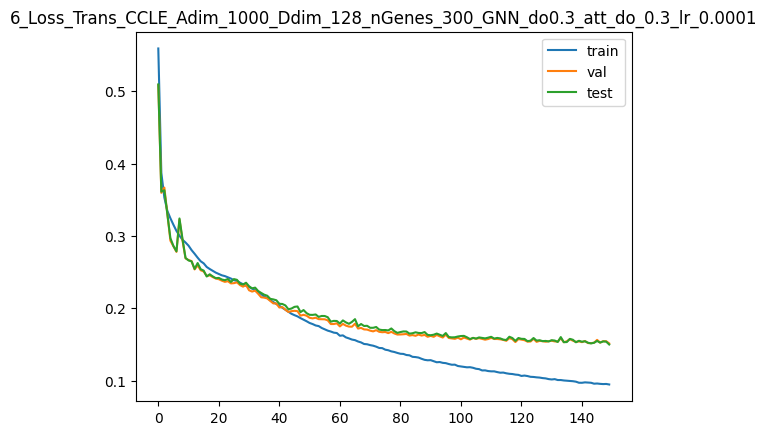

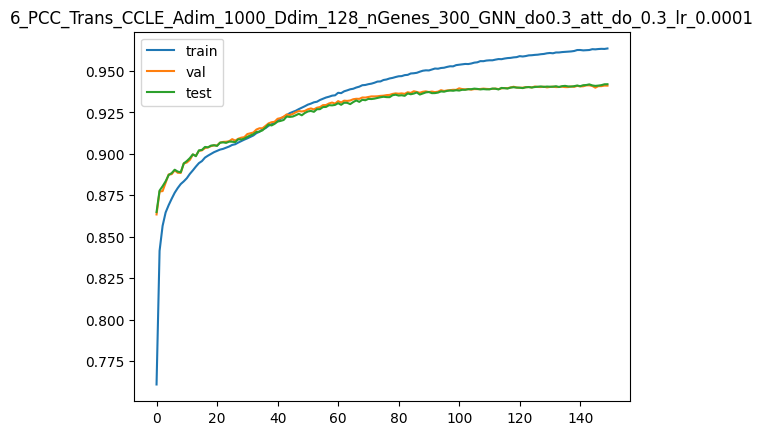

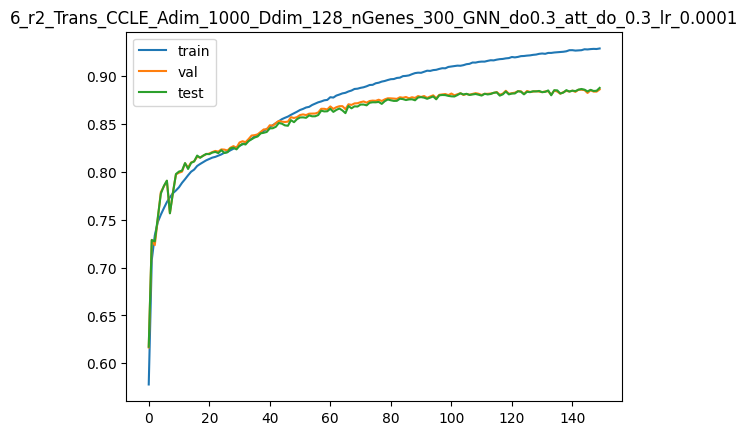

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.14993703
Test avg_pcc:  0.9420465896647776
Test r2:  0.8874004537056114


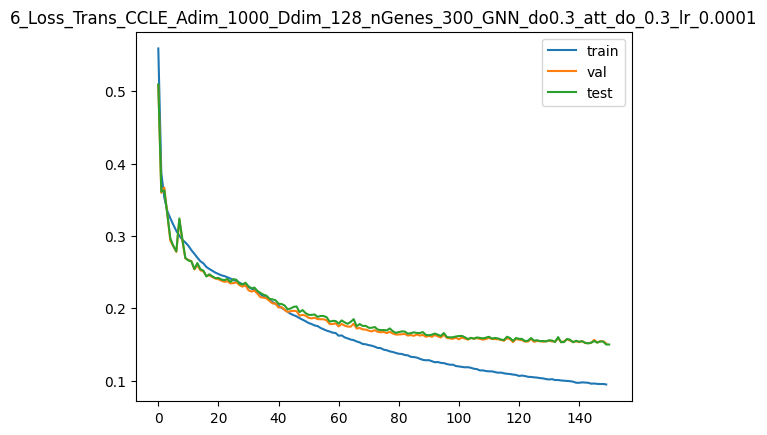

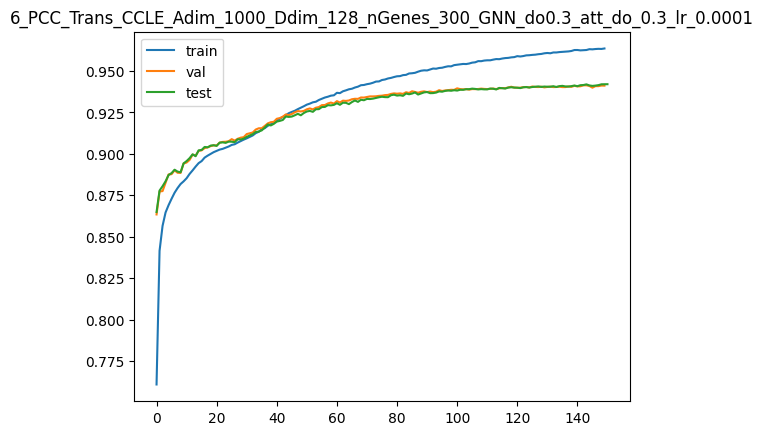

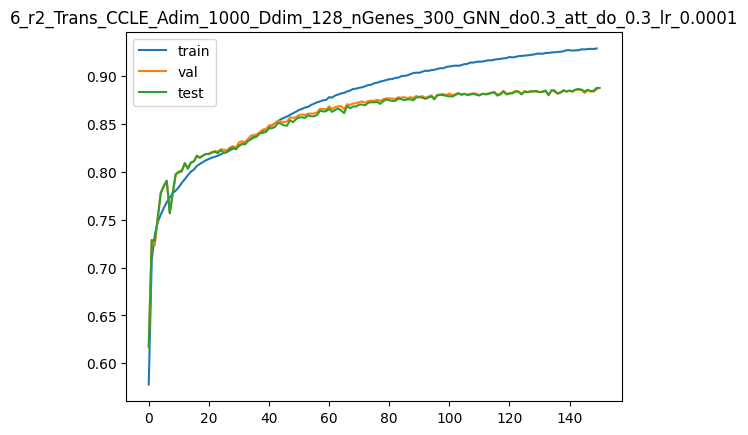

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.55848396
Train avg_pcc:  0.7605627771044395
Train r2:  0.5776678552843443


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3414463
Validation avg_pcc:  0.8713865745643818
Validation r2:  0.746734055766583
Best Val r2  0.746734055766583


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.34027076
Test avg_pcc:  0.8706463604174465
Test r2:  0.7442319649809577
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.38439652
Train avg_pcc:  0.8423927016984348
Train r2:  0.7093148026876963


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.33284673
Validation avg_pcc:  0.8815924940172896
Validation r2:  0.7531127479841011
Best Val r2  0.7531127479841011


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.33270243
Test avg_pcc:  0.8815307698256867
Test r2:  0.7499207644411392
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.35137254
Train avg_pcc:  0.8570197507573001
Train r2:  0.7342879330224102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2979637
Validation avg_pcc:  0.8859517287538674
Validation r2:  0.7789870512611852
Best Val r2  0.7789870512611852


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29301617
Test avg_pcc:  0.8854296202376457
Test r2:  0.7797513730661598
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3364951
Train avg_pcc:  0.8635299686433605
Train r2:  0.7455384296064258


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30174243
Validation avg_pcc:  0.8840874987139571
Validation r2:  0.7761841877987923


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29630408
Test avg_pcc:  0.8852352983868528
Test r2:  0.7772799701850344
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3252653
Train avg_pcc:  0.8684048700863004
Train r2:  0.7540305638785676


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29663795
Validation avg_pcc:  0.8867909630247559
Validation r2:  0.7799704167120916
Best Val r2  0.7799704167120916


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29382327
Test avg_pcc:  0.8873760987608871
Test r2:  0.7791446961903377
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.31596377
Train avg_pcc:  0.8724190678697726
Train r2:  0.7610644487110595


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3257441
Validation avg_pcc:  0.887330415209894
Validation r2:  0.7583811031170311


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32443836
Test avg_pcc:  0.8879518656096184
Test r2:  0.756132554179467
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.30835375
Train avg_pcc:  0.8757079323646366
Train r2:  0.7668192761460567


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28069252
Validation avg_pcc:  0.8910814346365443
Validation r2:  0.7917978682342239
Best Val r2  0.7917978682342239


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2763379
Test avg_pcc:  0.8916733930350101
Test r2:  0.792287752522334
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29936346
Train avg_pcc:  0.8795688999172345
Train r2:  0.7736178278438787


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28447598
Validation avg_pcc:  0.8890440261983055
Validation r2:  0.7889914968418568


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27620414
Test avg_pcc:  0.890951510100809
Test r2:  0.7923882946462197
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29647642
Train avg_pcc:  0.8808101237129786
Train r2:  0.7758010362554384


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27960956
Validation avg_pcc:  0.8904524221592339
Validation r2:  0.7926011323655868
Best Val r2  0.7926011323655868


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2707994
Test avg_pcc:  0.8925906633719539
Test r2:  0.7964508117248948
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29186404
Train avg_pcc:  0.8827808562792147
Train r2:  0.7792889460910086


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27628818
Validation avg_pcc:  0.8936771179927936
Validation r2:  0.7950647485956137
Best Val r2  0.7950647485956137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26787993
Test avg_pcc:  0.8950766310189855
Test r2:  0.7986452711438813
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.28711563
Train avg_pcc:  0.8848124938892236
Train r2:  0.7828797607374771


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27886313
Validation avg_pcc:  0.8907221513630507
Validation r2:  0.7931547985768708


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27065206
Test avg_pcc:  0.8927682696363098
Test r2:  0.7965615938956103
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.28289676
Train avg_pcc:  0.8866137578989993
Train r2:  0.7860701118070197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2707206
Validation avg_pcc:  0.8943362157966511
Validation r2:  0.7991944636533306
Best Val r2  0.7991944636533306


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26337814
Test avg_pcc:  0.8961221654538437
Test r2:  0.802029115089314
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2791049
Train avg_pcc:  0.8882260736375469
Train r2:  0.7889375812455259


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27206615
Validation avg_pcc:  0.8962424766118482
Validation r2:  0.7981964196272944


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26423818
Test avg_pcc:  0.8987741217168255
Test r2:  0.8013826325864744
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.27286592
Train avg_pcc:  0.8908799560920405
Train r2:  0.7936555655256943


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2630883
Validation avg_pcc:  0.8984579529858457
Validation r2:  0.8048556771699775
Best Val r2  0.8048556771699775


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25383687
Test avg_pcc:  0.9003506018546517
Test r2:  0.8092008859805622
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26810828
Train avg_pcc:  0.8928976932722206
Train r2:  0.7972533503942554


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25527465
Validation avg_pcc:  0.9003821337455317
Validation r2:  0.810651409215599
Best Val r2  0.810651409215599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24737683
Test avg_pcc:  0.9024112643998092
Test r2:  0.8140566634984493
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2638351
Train avg_pcc:  0.89470444816611
Train r2:  0.8004847740121186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26286834
Validation avg_pcc:  0.9014769341346963
Validation r2:  0.8050188297288212


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25786576
Test avg_pcc:  0.9033333231228697
Test r2:  0.8061725381245084
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25897533
Train avg_pcc:  0.8967529689580906
Train r2:  0.8041598083061816


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2545891
Validation avg_pcc:  0.9019687536485804
Validation r2:  0.8111599022197424
Best Val r2  0.8111599022197424


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24629958
Test avg_pcc:  0.9042765052995907
Test r2:  0.8148663679050524
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25484222
Train avg_pcc:  0.8984957991827349
Train r2:  0.8072852907970228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2454423
Validation avg_pcc:  0.9044080338819503
Validation r2:  0.8179445059844486
Best Val r2  0.8179445059844486


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23902105
Test avg_pcc:  0.9058368591275353
Test r2:  0.8203373629298811
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2517134
Train avg_pcc:  0.8998129120168704
Train r2:  0.8096513813075672


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25581366
Validation avg_pcc:  0.9007220668434547
Validation r2:  0.8102515910010544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24602748
Test avg_pcc:  0.9039551260278825
Test r2:  0.8150709042565869
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25024268
Train avg_pcc:  0.9004285729963121
Train r2:  0.8107635383608107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24705113
Validation avg_pcc:  0.9047190021674758
Validation r2:  0.8167511732470112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23735717
Test avg_pcc:  0.9074264715302909
Test r2:  0.8215880186137696
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24754293
Train avg_pcc:  0.901561222473094
Train r2:  0.812805095618708


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24718873
Validation avg_pcc:  0.904857772109705
Validation r2:  0.8166491054141671


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24114643
Test avg_pcc:  0.906615428966607
Test r2:  0.8187397842241471
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24640238
Train avg_pcc:  0.9020399029165139
Train r2:  0.8136675821205347


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25134933
Validation avg_pcc:  0.9043404352613016
Validation r2:  0.8135629939027811


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24357834
Test avg_pcc:  0.9068677936780754
Test r2:  0.8169118185079968
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24367352
Train avg_pcc:  0.9031812565767416
Train r2:  0.8157312051228627


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24245124
Validation avg_pcc:  0.9064931366248746
Validation r2:  0.8201631161298006
Best Val r2  0.8201631161298006


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23460187
Test avg_pcc:  0.9081687814724861
Test r2:  0.8236590763627021
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24239562
Train avg_pcc:  0.9037187720791785
Train r2:  0.8166975840677778


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2457184
Validation avg_pcc:  0.905273973334778
Validation r2:  0.8177397293904062


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23375796
Test avg_pcc:  0.9084898381351756
Test r2:  0.824293424124873
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24036713
Train avg_pcc:  0.9045652768784049
Train r2:  0.8182315364133468


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24364097
Validation avg_pcc:  0.9053900873297108
Validation r2:  0.8192806482144275


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23351748
Test avg_pcc:  0.9085037902443868
Test r2:  0.8244741533113512
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23722893
Train avg_pcc:  0.9058759721878693
Train r2:  0.8206046850459232


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24278116
Validation avg_pcc:  0.9055840529064523
Validation r2:  0.8199183779210495


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23400131
Test avg_pcc:  0.9078134980492896
Test r2:  0.8241104765657338
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.236524
Train avg_pcc:  0.9061701594999413
Train r2:  0.8211377762932552


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24421555
Validation avg_pcc:  0.9068257330269106
Validation r2:  0.818854438671369


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23173061
Test avg_pcc:  0.910619937812636
Test r2:  0.8258172935346102
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23425402
Train avg_pcc:  0.907116619048552
Train r2:  0.8228543468193006


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24078809
Validation avg_pcc:  0.9082567513555907
Validation r2:  0.8213967545089567
Best Val r2  0.8213967545089567


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23242292
Test avg_pcc:  0.9112023568547601
Test r2:  0.825296913461547
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23146443
Train avg_pcc:  0.9082778470437941
Train r2:  0.8249638984204825


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23790799
Validation avg_pcc:  0.9076380992145099
Validation r2:  0.8235330356510725
Best Val r2  0.8235330356510725


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22916424
Test avg_pcc:  0.9099456222945874
Test r2:  0.8277463253171063
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22971934
Train avg_pcc:  0.9090048276025591
Train r2:  0.826283518556351


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23872995
Validation avg_pcc:  0.9089733486680873
Validation r2:  0.8229233647800567


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22897974
Test avg_pcc:  0.9123220171488551
Test r2:  0.8278849910623427
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22727449
Train avg_pcc:  0.9100212479422564
Train r2:  0.8281323396729998


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23217718
Validation avg_pcc:  0.9099838619620411
Validation r2:  0.827783828327544
Best Val r2  0.827783828327544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22273047
Test avg_pcc:  0.9129178721265281
Test r2:  0.8325823331300838
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22533707
Train avg_pcc:  0.9108259037166115
Train r2:  0.8295974288881764


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2333982
Validation avg_pcc:  0.9111886487776193
Validation r2:  0.8268781538437312


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22445582
Test avg_pcc:  0.9142165488398479
Test r2:  0.8312854722889313
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22172964
Train avg_pcc:  0.9123223706810683
Train r2:  0.8323254280073309


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22798316
Validation avg_pcc:  0.9115450064288815
Validation r2:  0.8308947271969376
Best Val r2  0.8308947271969376


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21861507
Test avg_pcc:  0.9143698345058994
Test r2:  0.8356757142977702
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21998717
Train avg_pcc:  0.913042729135987
Train r2:  0.833643100017195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22815779
Validation avg_pcc:  0.9128055748648183
Validation r2:  0.8307652059082096


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21680814
Test avg_pcc:  0.915692503295727
Test r2:  0.8370339188156999
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21716423
Train avg_pcc:  0.9142117021071365
Train r2:  0.8357778190648265


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22428857
Validation avg_pcc:  0.9131679131002481
Validation r2:  0.8336351873954718
Best Val r2  0.8336351873954718


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21342899
Test avg_pcc:  0.9167897781353818
Test r2:  0.8395738861660244
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2137847
Train avg_pcc:  0.9156079126117808
Train r2:  0.8383334882591582


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22667481
Validation avg_pcc:  0.9131139965505226
Validation r2:  0.8318651857804409


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21391276
Test avg_pcc:  0.9165754749137477
Test r2:  0.8392102480957336
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21205209
Train avg_pcc:  0.9163243488007203
Train r2:  0.839643713120467


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22540233
Validation avg_pcc:  0.9141010256043078
Validation r2:  0.8328090389095085


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21128061
Test avg_pcc:  0.9182922156757354
Test r2:  0.8411887247871724
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20829305
Train avg_pcc:  0.9178741145206244
Train r2:  0.8424863454243554


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22002
Validation avg_pcc:  0.9156017666691765
Validation r2:  0.8368013638245353
Best Val r2  0.8368013638245353


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20992534
Test avg_pcc:  0.9186629993439105
Test r2:  0.8422074373015163
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20641059
Train avg_pcc:  0.9186478483509226
Train r2:  0.8439098678592183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21983863
Validation avg_pcc:  0.9149769066594015
Validation r2:  0.8369358817971915
Best Val r2  0.8369358817971915


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20745236
Test avg_pcc:  0.9187575360467092
Test r2:  0.8440662873445361
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20347582
Train avg_pcc:  0.9198556666474857
Train r2:  0.8461291821159476


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21379812
Validation avg_pcc:  0.9173541162435259
Validation r2:  0.8414164076315085
Best Val r2  0.8414164076315085


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20077588
Test avg_pcc:  0.9217581827814357
Test r2:  0.8490847374676438
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20094779
Train avg_pcc:  0.9208943874713315
Train r2:  0.8480408863430031


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21635884
Validation avg_pcc:  0.9170928801513545
Validation r2:  0.83951699843367


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20521908
Test avg_pcc:  0.9203794078709505
Test r2:  0.8457449609258263
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19802283
Train avg_pcc:  0.9220947532599255
Train r2:  0.8502528050799752


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2130879
Validation avg_pcc:  0.9176096525630596
Validation r2:  0.8419432044021259
Best Val r2  0.8419432044021259


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19992642
Test avg_pcc:  0.9218338271070154
Test r2:  0.8497232276515785
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19526058
Train avg_pcc:  0.9232256888546913
Train r2:  0.8523416418855587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21042328
Validation avg_pcc:  0.9191462723570968
Validation r2:  0.8439196707150292
Best Val r2  0.8439196707150292


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19745167
Test avg_pcc:  0.9232691875960748
Test r2:  0.8515834092682726
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19312748
Train avg_pcc:  0.9240992129722144
Train r2:  0.8539547100027185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21496512
Validation avg_pcc:  0.9191104017911869
Validation r2:  0.8405507906614773


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19964646
Test avg_pcc:  0.9236748392362785
Test r2:  0.849933676405102
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19116025
Train avg_pcc:  0.9249043047624588
Train r2:  0.8554423809626188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20692475
Validation avg_pcc:  0.9204758616607485
Validation r2:  0.8465146922088982
Best Val r2  0.8465146922088982


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19350299
Test avg_pcc:  0.9245299161579619
Test r2:  0.8545514698060421
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1887454
Train avg_pcc:  0.9258910895473244
Train r2:  0.8572685118150709


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20326339
Validation avg_pcc:  0.9218565092264525
Validation r2:  0.8492304841511484
Best Val r2  0.8492304841511484


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19267207
Test avg_pcc:  0.925348096190357
Test r2:  0.8551760456307316
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1855356
Train avg_pcc:  0.9272000201899995
Train r2:  0.8596957987343761


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20312999
Validation avg_pcc:  0.9216464725139326
Validation r2:  0.8493294290272527
Best Val r2  0.8493294290272527


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.192092
Test avg_pcc:  0.9251150358898713
Test r2:  0.8556120457217753
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18452907
Train avg_pcc:  0.9276110987414017
Train r2:  0.8604569483239134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20461118
Validation avg_pcc:  0.9213677781489309
Validation r2:  0.8482307695225112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19189398
Test avg_pcc:  0.925924946150396
Test r2:  0.8557608943643116
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18148519
Train avg_pcc:  0.9288497089020467
Train r2:  0.8627587651794335


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19820337
Validation avg_pcc:  0.9236989594226112
Validation r2:  0.8529837320546043
Best Val r2  0.8529837320546043


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1849028
Test avg_pcc:  0.9279811015457221
Test r2:  0.8610158918091942
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1801237
Train avg_pcc:  0.9294045803778705
Train r2:  0.8637883332104709


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19752112
Validation avg_pcc:  0.9240110809649497
Validation r2:  0.8534897971407888
Best Val r2  0.8534897971407888


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18639585
Test avg_pcc:  0.9275568311068579
Test r2:  0.8598936177608572


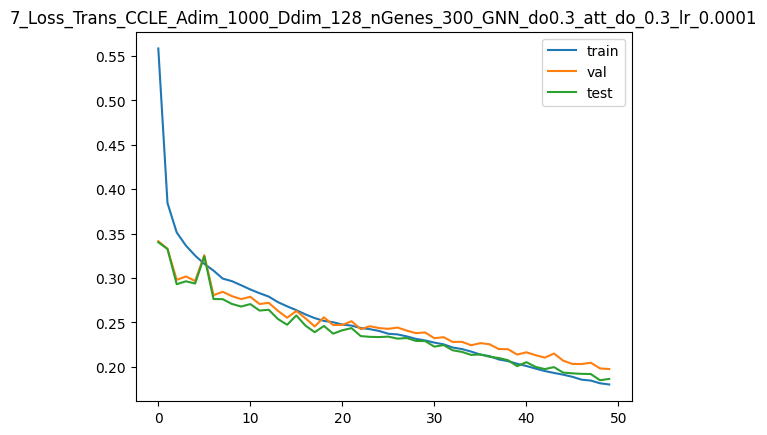

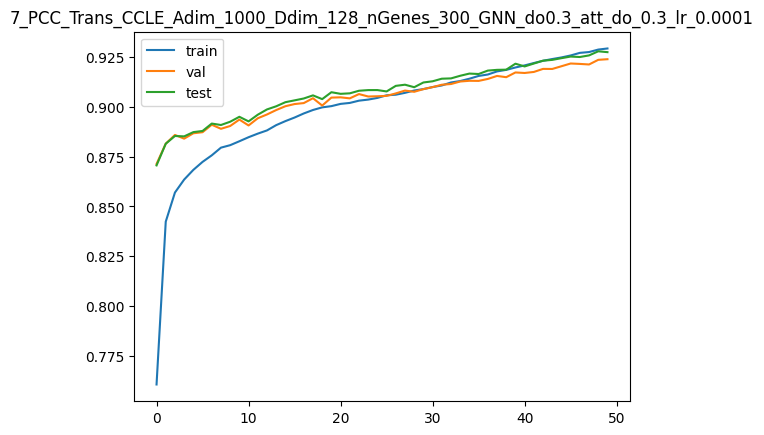

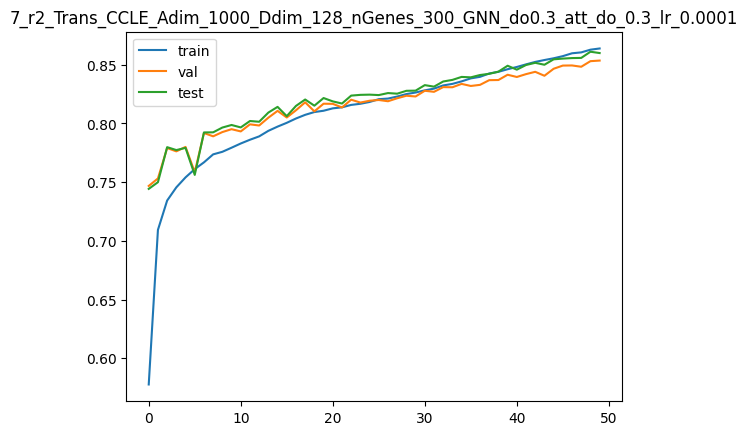

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17837247
Train avg_pcc:  0.9301158608658944
Train r2:  0.8651126367470637


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20014247
Validation avg_pcc:  0.9240514703886502
Validation r2:  0.8515453918847382


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18682109
Test avg_pcc:  0.9281428231092212
Test r2:  0.8595739871296554
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1758644
Train avg_pcc:  0.9311365614969819
Train r2:  0.8670092536908773


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19656579
Validation avg_pcc:  0.9242447326330895
Validation r2:  0.8541983945436138
Best Val r2  0.8541983945436138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18484531
Test avg_pcc:  0.9279891942495262
Test r2:  0.8610591081095442
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17387536
Train avg_pcc:  0.9319421140959383
Train r2:  0.8685133881438001


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19686522
Validation avg_pcc:  0.9242163577451086
Validation r2:  0.8539762905779601


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18474996
Test avg_pcc:  0.928020832848487
Test r2:  0.8611307766811135
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1723165
Train avg_pcc:  0.9325756145854733
Train r2:  0.869692229682684


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19654274
Validation avg_pcc:  0.9256533243635142
Validation r2:  0.8542154942413929
Best Val r2  0.8542154942413929


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18541841
Test avg_pcc:  0.9294864815660266
Test r2:  0.8606283186407608
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17096396
Train avg_pcc:  0.9331228470765154
Train r2:  0.8707150431516817


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.198606
Validation avg_pcc:  0.925335169810968
Validation r2:  0.852685079711173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18589419
Test avg_pcc:  0.9297378423700863
Test r2:  0.86027070735788
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16953525
Train avg_pcc:  0.9337017842475324
Train r2:  0.8717954381547848


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1937856
Validation avg_pcc:  0.926408909126943
Validation r2:  0.8562605832453332
Best Val r2  0.8562605832453332


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18247224
Test avg_pcc:  0.9300074085248041
Test r2:  0.8628428365357603
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16731635
Train avg_pcc:  0.934600605708293
Train r2:  0.873473394812513


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19106698
Validation avg_pcc:  0.9265214409308479
Validation r2:  0.8582771018444129
Best Val r2  0.8582771018444129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17959683
Test avg_pcc:  0.9303070490086823
Test r2:  0.8650041781835212
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16597296
Train avg_pcc:  0.9351435875664496
Train r2:  0.8744892936701353


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18906529
Validation avg_pcc:  0.927583700486259
Validation r2:  0.8597618504021601
Best Val r2  0.8597618504021601


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17874363
Test avg_pcc:  0.9310527621074262
Test r2:  0.8656454953163216
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16391583
Train avg_pcc:  0.9359749185919265
Train r2:  0.876044921620027


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18992803
Validation avg_pcc:  0.927043812515857
Validation r2:  0.85912191623553


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17734164
Test avg_pcc:  0.9309790838433958
Test r2:  0.8666993231211069
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16302402
Train avg_pcc:  0.9363349426553336
Train r2:  0.8767193183521222


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19339725
Validation avg_pcc:  0.9267759933854103
Validation r2:  0.8565486446750914


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18057564
Test avg_pcc:  0.9313371288665689
Test r2:  0.8642684451854479
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1614836
Train avg_pcc:  0.9369574724492233
Train r2:  0.8778841872710393


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1880452
Validation avg_pcc:  0.9278196307297379
Validation r2:  0.8605184928962791
Best Val r2  0.8605184928962791


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17693499
Test avg_pcc:  0.9315678798243388
Test r2:  0.867004975702504
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15967518
Train avg_pcc:  0.937685326767571
Train r2:  0.8792517382051702


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18952024
Validation avg_pcc:  0.9284264117368708
Validation r2:  0.8594243927526868


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17852908
Test avg_pcc:  0.9320104799793445
Test r2:  0.8658067594597075
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15821423
Train avg_pcc:  0.9382758268124392
Train r2:  0.8803565368393121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18593006
Validation avg_pcc:  0.9290156476664311
Validation r2:  0.8620873920190099
Best Val r2  0.8620873920190099


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1758524
Test avg_pcc:  0.9323988755573765
Test r2:  0.8678187146428996
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15751752
Train avg_pcc:  0.9385554924609463
Train r2:  0.880883395230111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18652353
Validation avg_pcc:  0.9283217128957366
Validation r2:  0.8616471853893535


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17459004
Test avg_pcc:  0.9323318324441727
Test r2:  0.8687675922661795
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15486316
Train avg_pcc:  0.9396246892517162
Train r2:  0.8828906541736502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1853157
Validation avg_pcc:  0.9289338016842336
Validation r2:  0.8625430854112719
Best Val r2  0.8625430854112719


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17615104
Test avg_pcc:  0.9320102420828122
Test r2:  0.8675942419132464
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15414293
Train avg_pcc:  0.9399148390205023
Train r2:  0.8834353037762276


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18295833
Validation avg_pcc:  0.9297229972658166
Validation r2:  0.864291658695376
Best Val r2  0.864291658695376


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17230666
Test avg_pcc:  0.9332267195559374
Test r2:  0.8704839070866084
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1530536
Train avg_pcc:  0.9403518924112154
Train r2:  0.884259060670464


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18377097
Validation avg_pcc:  0.9295808858281788
Validation r2:  0.8636888889951215


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17282316
Test avg_pcc:  0.9330830685810635
Test r2:  0.8700956798978638
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15160748
Train avg_pcc:  0.9409335075342637
Train r2:  0.8853526131067486


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18271741
Validation avg_pcc:  0.929832894793797
Validation r2:  0.8644703512633634
Best Val r2  0.8644703512633634


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17281196
Test avg_pcc:  0.9328563336928544
Test r2:  0.8701041006058414
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14966099
Train avg_pcc:  0.9417159014776123
Train r2:  0.8868245860718489


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18222676
Validation avg_pcc:  0.9300554906572218
Validation r2:  0.8648342787052405
Best Val r2  0.8648342787052405


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17178455
Test avg_pcc:  0.9332408518690051
Test r2:  0.8708763626828262
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14939378
Train avg_pcc:  0.9418225343171198
Train r2:  0.8870266541515992


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1839801
Validation avg_pcc:  0.9292981592260217
Validation r2:  0.863533752184811


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1731278
Test avg_pcc:  0.9328453447830645
Test r2:  0.8698666875451098
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1473118
Train avg_pcc:  0.9426582084183747
Train r2:  0.8886010641091516


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1805057
Validation avg_pcc:  0.9307243580159129
Validation r2:  0.8661108962470228
Best Val r2  0.8661108962470228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16914362
Test avg_pcc:  0.9344351017540284
Test r2:  0.8728614479960127
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14587355
Train avg_pcc:  0.9432348931555442
Train r2:  0.8896886959204992


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17891788
Validation avg_pcc:  0.9313087664736702
Validation r2:  0.867288624461921
Best Val r2  0.867288624461921


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16890486
Test avg_pcc:  0.9344584765811025
Test r2:  0.8730409183324613
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1450352
Train avg_pcc:  0.9435709032947749
Train r2:  0.8903226665124556


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18253681
Validation avg_pcc:  0.9305868080939568
Validation r2:  0.8646043195260387


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17325245
Test avg_pcc:  0.9338775313539122
Test r2:  0.869773002910845
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1444282
Train avg_pcc:  0.9438142976108423
Train r2:  0.8907816958347404


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18000337
Validation avg_pcc:  0.9309131976446121
Validation r2:  0.8664834787555717


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16915093
Test avg_pcc:  0.9342789096182536
Test r2:  0.872855945260931
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14229544
Train avg_pcc:  0.9446681643884247
Train r2:  0.8923945198135699


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18036142
Validation avg_pcc:  0.9313986484795034
Validation r2:  0.8662178911417954


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16954808
Test avg_pcc:  0.9350650276232445
Test r2:  0.8725574245909927
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14257121
Train avg_pcc:  0.9445579232865953
Train r2:  0.8921859691046093


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17764527
Validation avg_pcc:  0.931820894879708
Validation r2:  0.8682325865029787
Best Val r2  0.8682325865029787


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16855694
Test avg_pcc:  0.9346891173824537
Test r2:  0.8733024298159406
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.140527
Train avg_pcc:  0.9453755752844099
Train r2:  0.8937318191090703


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1811398
Validation avg_pcc:  0.9310818570222293
Validation r2:  0.8656405400930177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17071038
Test avg_pcc:  0.93440822523633
Test r2:  0.8716837526185948
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14017637
Train avg_pcc:  0.9455155417948182
Train r2:  0.8939969733654736


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17848185
Validation avg_pcc:  0.9317325681570684
Validation r2:  0.867612066758185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.169115
Test avg_pcc:  0.9348694433987783
Test r2:  0.8728829488629946
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13803631
Train avg_pcc:  0.9463712917590437
Train r2:  0.895615313823311


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17678039
Validation avg_pcc:  0.9321842253250887
Validation r2:  0.8688741220678682
Best Val r2  0.8688741220678682


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16628605
Test avg_pcc:  0.9355932647947153
Test r2:  0.8750093663327769
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13783991
Train avg_pcc:  0.9464497200753965
Train r2:  0.895763829709812


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17822814
Validation avg_pcc:  0.9327170187330907
Validation r2:  0.8678002559014864


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16854608
Test avg_pcc:  0.936073213147854
Test r2:  0.8733105905689247
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1357837
Train avg_pcc:  0.9472705576187179
Train r2:  0.8973187752628546


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17701006
Validation avg_pcc:  0.9324627681048586
Validation r2:  0.8687037632475878


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16780972
Test avg_pcc:  0.9354822458820483
Test r2:  0.8738640793102135
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13537267
Train avg_pcc:  0.9474349263463538
Train r2:  0.8976295887214091


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17621739
Validation avg_pcc:  0.9324426009026032
Validation r2:  0.8692917161335287
Best Val r2  0.8692917161335287


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1667458
Test avg_pcc:  0.9352510180899383
Test r2:  0.8746637991707535
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13386485
Train avg_pcc:  0.9480362864323173
Train r2:  0.8987698272458331


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17685232
Validation avg_pcc:  0.9329111104314465
Validation r2:  0.8688207576723623


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16768937
Test avg_pcc:  0.9355052828470318
Test r2:  0.8739545502547216
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13307206
Train avg_pcc:  0.9483520961444837
Train r2:  0.8993693333104317


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1751886
Validation avg_pcc:  0.9328422246281579
Validation r2:  0.8700548075153346
Best Val r2  0.8700548075153346


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16500542
Test avg_pcc:  0.9359957881830482
Test r2:  0.8759719639950749
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13226572
Train avg_pcc:  0.948673613168558
Train r2:  0.8999791046617716


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1732715
Validation avg_pcc:  0.9338570111835183
Validation r2:  0.8714768100455467
Best Val r2  0.8714768100455467


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16628896
Test avg_pcc:  0.9360336097725785
Test r2:  0.8750071797491735
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13118407
Train avg_pcc:  0.9491048134782616
Train r2:  0.9007970629404619


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17334251
Validation avg_pcc:  0.933699651291388
Validation r2:  0.8714241354425165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1641898
Test avg_pcc:  0.9367487477213838
Test r2:  0.8765850438250112
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13065512
Train avg_pcc:  0.9493153563825673
Train r2:  0.9011970585874833


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17552719
Validation avg_pcc:  0.9328598624749479
Validation r2:  0.8698036654673416


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16584848
Test avg_pcc:  0.9359612274535346
Test r2:  0.8753382727961353
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12945835
Train avg_pcc:  0.9497926367588984
Train r2:  0.902102066662425


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17277841
Validation avg_pcc:  0.9340722091224645
Validation r2:  0.8718425539518313
Best Val r2  0.8718425539518313


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16466174
Test avg_pcc:  0.9367725873381402
Test r2:  0.876230294302469
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12770791
Train avg_pcc:  0.9504882276152493
Train r2:  0.9034257690039503


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17448485
Validation avg_pcc:  0.9335312923216845
Validation r2:  0.8705768135047256


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16481376
Test avg_pcc:  0.9367412879898518
Test r2:  0.876116036917675
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12739533
Train avg_pcc:  0.9506136035025722
Train r2:  0.9036621399600913


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1731406
Validation avg_pcc:  0.9342055398085465
Validation r2:  0.8715738974793701


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16555107
Test avg_pcc:  0.9364649332009609
Test r2:  0.8755618264026709
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12637283
Train avg_pcc:  0.9510189485506421
Train r2:  0.9044353732848062


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17266637
Validation avg_pcc:  0.9339061113072168
Validation r2:  0.8719256625290639
Best Val r2  0.8719256625290639


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1636388
Test avg_pcc:  0.9367222840300454
Test r2:  0.8769991913551599
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12594189
Train avg_pcc:  0.951190964182427
Train r2:  0.9047612528708533


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17081715
Validation avg_pcc:  0.9345949185645996
Validation r2:  0.8732973166516623
Best Val r2  0.8732973166516623


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16255501
Test avg_pcc:  0.9372273982942777
Test r2:  0.8778138419935381
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12448186
Train avg_pcc:  0.9517714084446182
Train r2:  0.9058653565374896


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16984096
Validation avg_pcc:  0.9351042169750616
Validation r2:  0.8740213883703065
Best Val r2  0.8740213883703065


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16228157
Test avg_pcc:  0.9373540605490079
Test r2:  0.8780193711348708
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12445179
Train avg_pcc:  0.9517827700830224
Train r2:  0.9058881003456375


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17052987
Validation avg_pcc:  0.9347778560024719
Validation r2:  0.8735104010626848


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16224398
Test avg_pcc:  0.9373774071171695
Test r2:  0.8780476355127812
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12263663
Train avg_pcc:  0.9525043713934569
Train r2:  0.9072607337656605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17244402
Validation avg_pcc:  0.9345037464976016
Validation r2:  0.8720905831812416


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16472307
Test avg_pcc:  0.9370375397594356
Test r2:  0.8761841987321969
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1226881
Train avg_pcc:  0.9524834122823951
Train r2:  0.9072218089756504


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17114711
Validation avg_pcc:  0.9344267396970243
Validation r2:  0.8730525689026694


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16291797
Test avg_pcc:  0.9369998456748283
Test r2:  0.8775410214230009
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12147408
Train avg_pcc:  0.952965710329238
Train r2:  0.9081398674744698


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17462578
Validation avg_pcc:  0.9349386185167188
Validation r2:  0.87047228729855


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16834582
Test avg_pcc:  0.9371052794351727
Test r2:  0.8734611029725359
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12026308
Train avg_pcc:  0.9534453383906892
Train r2:  0.9090556402537541


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17014292
Validation avg_pcc:  0.9348850075121752
Validation r2:  0.8737974197047511


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16143054
Test avg_pcc:  0.9374839793328866
Test r2:  0.878659075425898
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11917342
Train avg_pcc:  0.953877816509959
Train r2:  0.9098796576899523


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16867565
Validation avg_pcc:  0.9355218465272581
Validation r2:  0.8748857507382796
Best Val r2  0.8748857507382796


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16037232
Test avg_pcc:  0.9381609256048609
Test r2:  0.8794544896798596
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11930646
Train avg_pcc:  0.9538244482526886
Train r2:  0.9097790419783403


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16867714
Validation avg_pcc:  0.9357182171815084
Validation r2:  0.874884650787857


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16098315
Test avg_pcc:  0.9381328158640011
Test r2:  0.8789953569320739


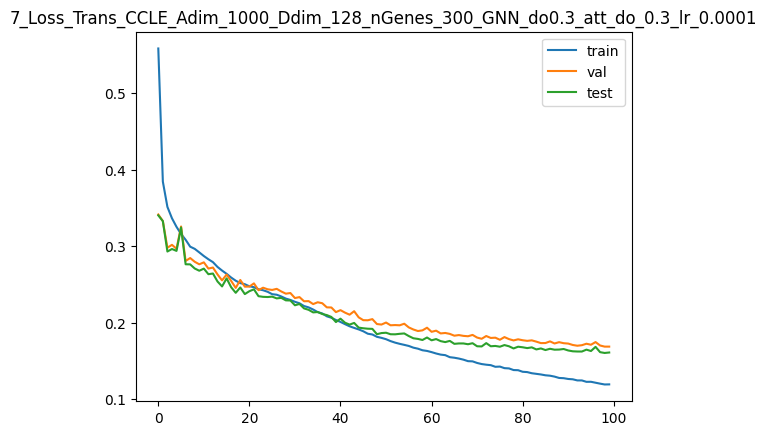

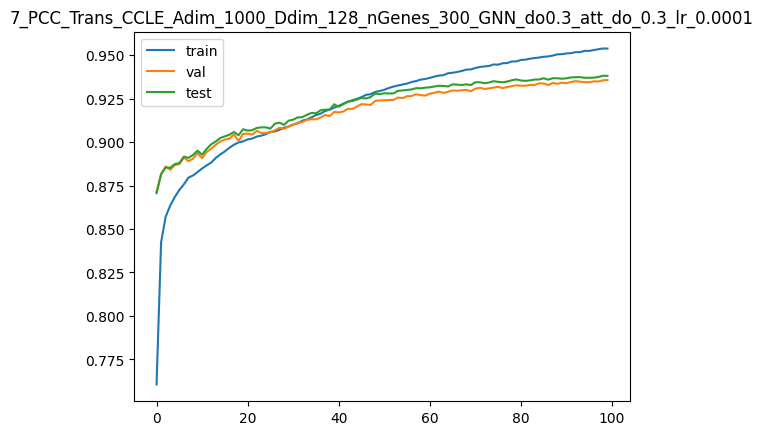

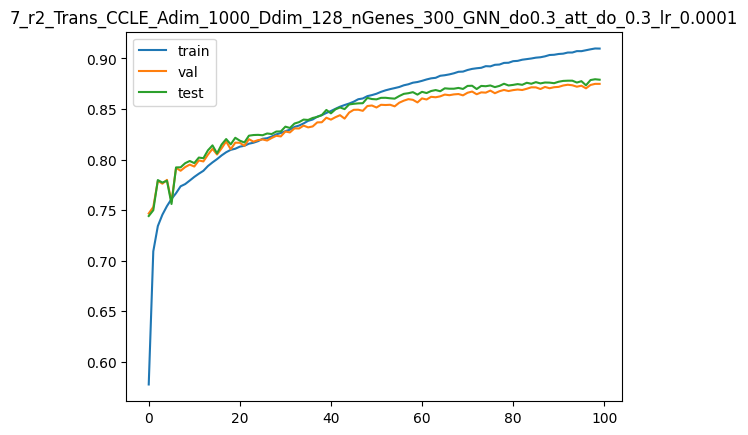

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1192984
Train avg_pcc:  0.9538284541058097
Train r2:  0.9097851398630393


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16892886
Validation avg_pcc:  0.9355990724690777
Validation r2:  0.8746979360575211


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1612967
Test avg_pcc:  0.9380705837569879
Test r2:  0.8787596639544388
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11770047
Train avg_pcc:  0.9544611428127786
Train r2:  0.9109935135143981


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16871497
Validation avg_pcc:  0.9358203373211929
Validation r2:  0.8748565944347986


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15976682
Test avg_pcc:  0.938643942460031
Test r2:  0.879909608118962
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11744008
Train avg_pcc:  0.9545644715069299
Train r2:  0.9111904092325022


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16793846
Validation avg_pcc:  0.9361250414349084
Validation r2:  0.8754325592226836
Best Val r2  0.8754325592226836


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16104
Test avg_pcc:  0.9381929349136919
Test r2:  0.8789526223899322
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11651238
Train avg_pcc:  0.954931613737829
Train r2:  0.9118919561772513


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16897927
Validation avg_pcc:  0.9360179741113689
Validation r2:  0.8746605432359335


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16256166
Test avg_pcc:  0.9381538620518957
Test r2:  0.8778088450673006
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11563659
Train avg_pcc:  0.955278170377224
Train r2:  0.9125542587914219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16921522
Validation avg_pcc:  0.9354311344341085
Validation r2:  0.8744855381569099


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16270946
Test avg_pcc:  0.9374164882982507
Test r2:  0.8776977431287356
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1148591
Train avg_pcc:  0.9555859643378023
Train r2:  0.9131421900247918


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16783032
Validation avg_pcc:  0.9362163958156825
Validation r2:  0.8755127823152915
Best Val r2  0.8755127823152915


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1598911
Test avg_pcc:  0.9387548830242932
Test r2:  0.8798162031291565
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11454817
Train avg_pcc:  0.9557092144001806
Train r2:  0.9133773181565966


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16575368
Validation avg_pcc:  0.9365962454949313
Validation r2:  0.8770531117586966
Best Val r2  0.8770531117586966


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1583975
Test avg_pcc:  0.9388673470316936
Test r2:  0.8809388925131698
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1135957
Train avg_pcc:  0.9560858539485505
Train r2:  0.9140975882802344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16917881
Validation avg_pcc:  0.9363231659137292
Validation r2:  0.8745125273688772


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16183628
Test avg_pcc:  0.9387518093194542
Test r2:  0.8783540773056767
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1126078
Train avg_pcc:  0.9564769745218726
Train r2:  0.9148446477738033


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16821663
Validation avg_pcc:  0.9357573495619912
Validation r2:  0.8752262297237912


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16094854
Test avg_pcc:  0.9380091143354633
Test r2:  0.8790213581930272
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.112930916
Train avg_pcc:  0.9563483110385987
Train r2:  0.9146003073350775


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16703655
Validation avg_pcc:  0.9361719305444612
Validation r2:  0.876101552949924


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1585255
Test avg_pcc:  0.938861440387523
Test r2:  0.8808426714371752
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11214596
Train avg_pcc:  0.9566596628062765
Train r2:  0.9151939048065956


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1668434
Validation avg_pcc:  0.9365649375422587
Validation r2:  0.8762448216644719


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15953627
Test avg_pcc:  0.9388843930663295
Test r2:  0.8800829183670486
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11159833
Train avg_pcc:  0.9568753095055468
Train r2:  0.9156080252462202


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16780938
Validation avg_pcc:  0.9364071843005627
Validation r2:  0.8755283041763708


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16061899
Test avg_pcc:  0.9388849604567429
Test r2:  0.8792690701452526
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11005503
Train avg_pcc:  0.9574846649986497
Train r2:  0.9167750826862043


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1661603
Validation avg_pcc:  0.9364266355546789
Validation r2:  0.8767515012513958


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15780535
Test avg_pcc:  0.9390541555233759
Test r2:  0.8813839728085413
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11006982
Train avg_pcc:  0.9574795602037515
Train r2:  0.9167639059837767


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17145304
Validation avg_pcc:  0.936317801921709
Validation r2:  0.8728256318968027


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16341993
Test avg_pcc:  0.9390068882648992
Test r2:  0.8771637163803336
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10865699
Train avg_pcc:  0.9580372246000409
Train r2:  0.9178323012816995


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16646501
Validation avg_pcc:  0.9362875621351477
Validation r2:  0.8765254861121455


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15922087
Test avg_pcc:  0.9384694395300218
Test r2:  0.8803199678988434
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1092969
Train avg_pcc:  0.9577840784556537
Train r2:  0.9173483898534097


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16391166
Validation avg_pcc:  0.9372665581329139
Validation r2:  0.8784194292876126
Best Val r2  0.8784194292876126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15592207
Test avg_pcc:  0.9396290530954963
Test r2:  0.8827995586416421
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10804352
Train avg_pcc:  0.9582791380897244
Train r2:  0.9182962028065407


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16619982
Validation avg_pcc:  0.9365085857940124
Validation r2:  0.876722185092233


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15721484
Test avg_pcc:  0.9393901648587436
Test r2:  0.8818278382354839
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10771492
Train avg_pcc:  0.9584084236756548
Train r2:  0.9185446966351497


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16543183
Validation avg_pcc:  0.9376584734028746
Validation r2:  0.8772918415579176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15950432
Test avg_pcc:  0.9395464284664197
Test r2:  0.8801069143556739
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.105793595
Train avg_pcc:  0.9591672122940886
Train r2:  0.9199976336774319


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16390431
Validation avg_pcc:  0.937397749925235
Validation r2:  0.8784248815767691
Best Val r2  0.8784248815767691


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15601058
Test avg_pcc:  0.9398534229141864
Test r2:  0.8827330323254846
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10666638
Train avg_pcc:  0.9588224081904084
Train r2:  0.9193376282238982


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16547824
Validation avg_pcc:  0.9375808245326921
Validation r2:  0.8772574099441957


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15935938
Test avg_pcc:  0.9396113287439528
Test r2:  0.8802158789547829
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10561055
Train avg_pcc:  0.9592390023856915
Train r2:  0.9201360534795251


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16637367
Validation avg_pcc:  0.9368018712219328
Validation r2:  0.8765932346857015


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15666193
Test avg_pcc:  0.9400891276938276
Test r2:  0.8822434377523396
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.106127225
Train avg_pcc:  0.9590348386200411
Train r2:  0.9197453336140677


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16455667
Validation avg_pcc:  0.9372444741842356
Validation r2:  0.8779409918668405


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15652025
Test avg_pcc:  0.9398858696724596
Test r2:  0.8823499408648524
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1048241
Train avg_pcc:  0.9595480154145973
Train r2:  0.9207307823204502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16335174
Validation avg_pcc:  0.9380453738078273
Validation r2:  0.8788347261041477
Best Val r2  0.8788347261041477


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15638998
Test avg_pcc:  0.9401927887426772
Test r2:  0.8824478469660237
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10427596
Train avg_pcc:  0.9597646217131568
Train r2:  0.9211452941124432


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16717616
Validation avg_pcc:  0.9374722410473836
Validation r2:  0.8759979987145237


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16081525
Test avg_pcc:  0.9394419033411568
Test r2:  0.8791215419542513
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10402226
Train avg_pcc:  0.9598642656068602
Train r2:  0.9213371457619697


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16528563
Validation avg_pcc:  0.9376684400319009
Validation r2:  0.8774002791709689


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15884411
Test avg_pcc:  0.9396980350635604
Test r2:  0.8806031719735208
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.102683
Train avg_pcc:  0.9603915278021038
Train r2:  0.9223499024895607


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16458233
Validation avg_pcc:  0.9375888314373169
Validation r2:  0.8779219537481666


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15691586
Test avg_pcc:  0.9399693681062279
Test r2:  0.8820525579600479
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10302658
Train avg_pcc:  0.9602565050774675
Train r2:  0.9220900891372721


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1637755
Validation avg_pcc:  0.9379494601038231
Validation r2:  0.8785204230673183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15558401
Test avg_pcc:  0.9405660472843637
Test r2:  0.8830536573328963
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.101976015
Train avg_pcc:  0.9606698674134726
Train r2:  0.9228845330859466


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16276999
Validation avg_pcc:  0.9380330454221374
Validation r2:  0.8792662451755168
Best Val r2  0.8792662451755168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15613957
Test avg_pcc:  0.9400906474985471
Test r2:  0.8826360743270236
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10167393
Train avg_pcc:  0.9607889453834142
Train r2:  0.9231129737070687


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16243835
Validation avg_pcc:  0.9381073564746523
Validation r2:  0.8795122250795508
Best Val r2  0.8795122250795508


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15639757
Test avg_pcc:  0.9399376363535138
Test r2:  0.882442140427659
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.100959085
Train avg_pcc:  0.9610701228752977
Train r2:  0.9236535455232824


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16596557
Validation avg_pcc:  0.9374101008192754
Validation r2:  0.8768959456539599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15800056
Test avg_pcc:  0.9400238058229602
Test r2:  0.881237240329011
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10107868
Train avg_pcc:  0.9610228700341027
Train r2:  0.9235631089392486


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16229953
Validation avg_pcc:  0.938063253018485
Validation r2:  0.8796151981004207
Best Val r2  0.8796151981004207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1552931
Test avg_pcc:  0.9402315244209507
Test r2:  0.8832723231224197
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.100421965
Train avg_pcc:  0.9612816167487263
Train r2:  0.9240597216833509


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16232195
Validation avg_pcc:  0.9379461047266905
Validation r2:  0.8795985737396248


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15518162
Test avg_pcc:  0.9401225100991945
Test r2:  0.8833561435268271
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10031152
Train avg_pcc:  0.9613257154835756
Train r2:  0.9241432486415935


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16292311
Validation avg_pcc:  0.9382227275633731
Validation r2:  0.8791526720594679


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15595092
Test avg_pcc:  0.940492963990598
Test r2:  0.8827778731552488
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.099688195
Train avg_pcc:  0.961569758515179
Train r2:  0.9246146100889796


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16154829
Validation avg_pcc:  0.9386076430448679
Validation r2:  0.8801724335187999
Best Val r2  0.8801724335187999


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15490527
Test avg_pcc:  0.9406028919650603
Test r2:  0.8835638348591822
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09899189
Train avg_pcc:  0.9618435026284442
Train r2:  0.9251411604070787


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16159363
Validation avg_pcc:  0.9382358918422907
Validation r2:  0.8801387999152165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15631749
Test avg_pcc:  0.9396862147951262
Test r2:  0.8825023424743424
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0987019
Train avg_pcc:  0.9619578464536579
Train r2:  0.9253604582891143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15963547
Validation avg_pcc:  0.9389886277706633
Validation r2:  0.8815912598254794
Best Val r2  0.8815912598254794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15363078
Test avg_pcc:  0.9406902126264645
Test r2:  0.8845218335415643
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.097284496
Train avg_pcc:  0.9625148933234239
Train r2:  0.9264323138687613


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16295335
Validation avg_pcc:  0.9378910319678653
Validation r2:  0.8791302371392877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15648507
Test avg_pcc:  0.9399309437763365
Test r2:  0.8823763745135147
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09775195
Train avg_pcc:  0.9623306107940759
Train r2:  0.926078808598207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16157976
Validation avg_pcc:  0.938291478162908
Validation r2:  0.8801490979805626


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15639672
Test avg_pcc:  0.939756351533998
Test r2:  0.8824427802730113
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09790135
Train avg_pcc:  0.9622722858733956
Train r2:  0.9259658401595233


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16169222
Validation avg_pcc:  0.9384566448023571
Validation r2:  0.8800656804642533


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15594538
Test avg_pcc:  0.9400273601519885
Test r2:  0.8827820506716331
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.097241946
Train avg_pcc:  0.9625319436728801
Train r2:  0.9264644973126464


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.161513
Validation avg_pcc:  0.9385683394712515
Validation r2:  0.8801986177156388


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1540263
Test avg_pcc:  0.9410127508662257
Test r2:  0.8842245296541805
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.096668154
Train avg_pcc:  0.9627566306423718
Train r2:  0.9268984002939344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16112646
Validation avg_pcc:  0.9383818672075555
Validation r2:  0.8804853125055513


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15550996
Test avg_pcc:  0.9399020558431723
Test r2:  0.8831093174829355
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09638153
Train avg_pcc:  0.9628695244037979
Train r2:  0.927115151300916


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16143662
Validation avg_pcc:  0.938610138499412
Validation r2:  0.8802552745995919


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15630889
Test avg_pcc:  0.9401674567959265
Test r2:  0.8825087864110225
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09609477
Train avg_pcc:  0.9629824397893127
Train r2:  0.9273320037788211


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16076946
Validation avg_pcc:  0.9388946692074007
Validation r2:  0.8807501244940484


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15381023
Test avg_pcc:  0.941149251329864
Test r2:  0.8843869439665049
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09639899
Train avg_pcc:  0.9628623092620627
Train r2:  0.9271019496558478


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1636335
Validation avg_pcc:  0.9382969994175815
Validation r2:  0.878625744667766


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15756962
Test avg_pcc:  0.9402790113869556
Test r2:  0.8815611739349883
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09548817
Train avg_pcc:  0.9632201948649219
Train r2:  0.9277907132849929


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16182701
Validation avg_pcc:  0.9383843718311513
Validation r2:  0.8799657032138297


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1554906
Test avg_pcc:  0.9404002590345136
Test r2:  0.8831238634889322
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09373892
Train avg_pcc:  0.9639061780836458
Train r2:  0.9291135168873323


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1607741
Validation avg_pcc:  0.9386168045148615
Validation r2:  0.8807466849278818


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15461616
Test avg_pcc:  0.9404574532037844
Test r2:  0.8837811527108569
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09408519
Train avg_pcc:  0.9637710167853363
Train r2:  0.9288516727707518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.161375
Validation avg_pcc:  0.9389103477725935
Validation r2:  0.8803009713029815


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15582314
Test avg_pcc:  0.9406390356037722
Test r2:  0.8828739198193416
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09378346
Train avg_pcc:  0.963888983230865
Train r2:  0.9290798315739286


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16117764
Validation avg_pcc:  0.9383629994122475
Validation r2:  0.8804473737150065


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15274972
Test avg_pcc:  0.9409848683345595
Test r2:  0.8851840899995614
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.093022116
Train avg_pcc:  0.9641876392877854
Train r2:  0.9296555769275033


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1620635
Validation avg_pcc:  0.9386625994730142
Validation r2:  0.8797902831792366


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15539922
Test avg_pcc:  0.940901979602107
Test r2:  0.8831925639624407
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09300993
Train avg_pcc:  0.9641923051745518
Train r2:  0.9296648008117723


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1615611
Validation avg_pcc:  0.9382177910790794
Validation r2:  0.8801629337745102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15470813
Test avg_pcc:  0.9402430289340615
Test r2:  0.8837120249036664


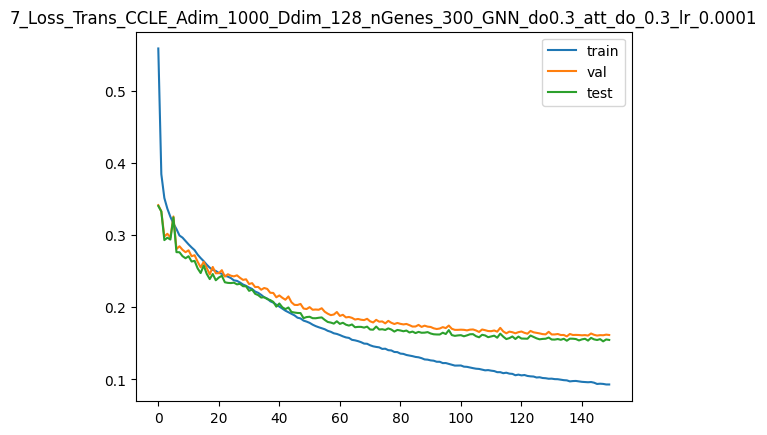

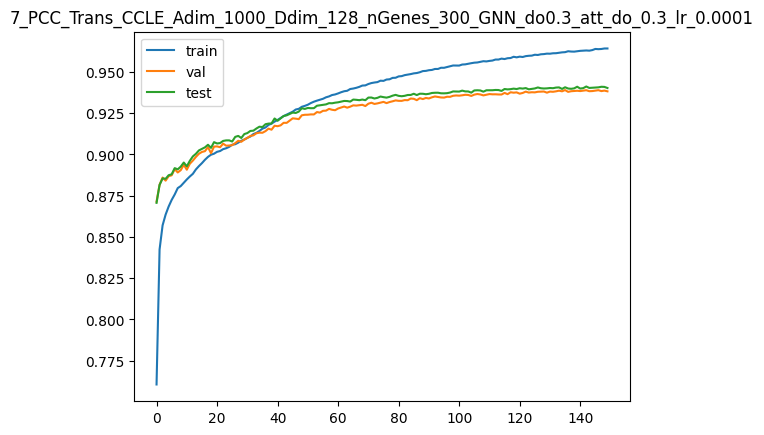

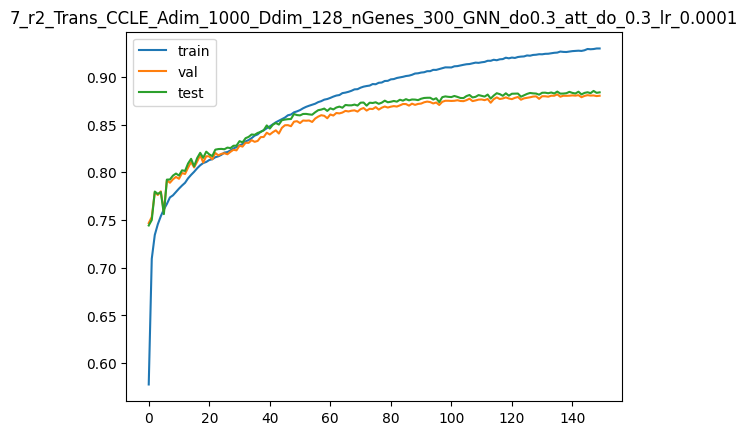

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15363078
Test avg_pcc:  0.9406902124525748
Test r2:  0.8845218331945153


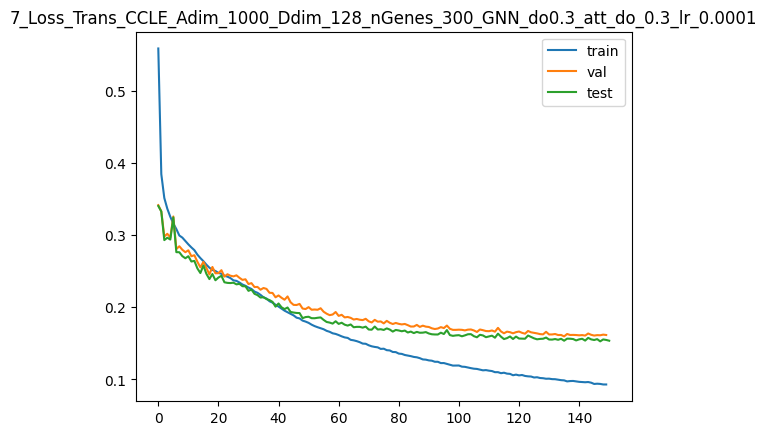

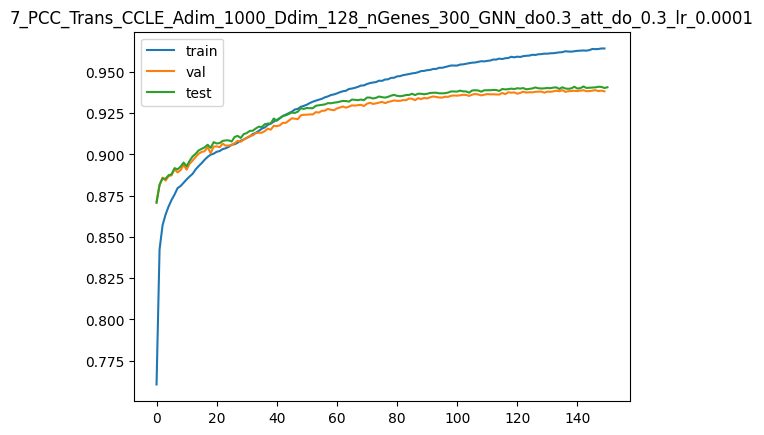

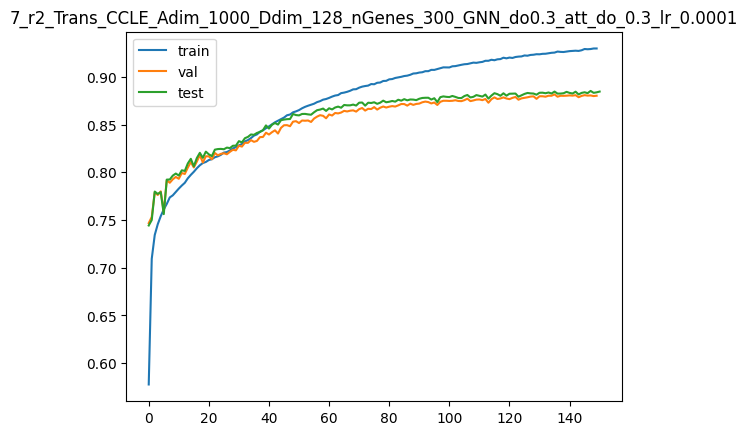

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.55239475
Train avg_pcc:  0.7644960679630151
Train r2:  0.5835864316341222


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3749579
Validation avg_pcc:  0.8701680674198151
Validation r2:  0.7163939748740573
Best Val r2  0.7163939748740573


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3755056
Test avg_pcc:  0.8694353416277647
Test r2:  0.7161941440448842
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3843031
Train avg_pcc:  0.8429695388657618
Train r2:  0.7102995172385651


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.33097818
Validation avg_pcc:  0.8778539672802447
Validation r2:  0.7496587742157492
Best Val r2  0.7496587742157492


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.33002296
Test avg_pcc:  0.8776835327563745
Test r2:  0.750569751502502
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.35281214
Train avg_pcc:  0.8568925480140628
Train r2:  0.7340384371593343


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31943858
Validation avg_pcc:  0.8829913110243274
Validation r2:  0.758386972694016
Best Val r2  0.758386972694016


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32223818
Test avg_pcc:  0.8814256238698678
Test r2:  0.7564534760824766
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.33326775
Train avg_pcc:  0.8653969891982476
Train r2:  0.7487716481611622


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3023931
Validation avg_pcc:  0.88567277536671
Validation r2:  0.7712796408438664
Best Val r2  0.7712796408438664


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30729192
Test avg_pcc:  0.8832448274442436
Test r2:  0.7677497816468045
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.32082975
Train avg_pcc:  0.8707643461911818
Train r2:  0.7581478500132605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31278363
Validation avg_pcc:  0.8866866283146677
Validation r2:  0.7634205723815786


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31308493
Test avg_pcc:  0.8855844708814894
Test r2:  0.7633714695023794
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.31272677
Train avg_pcc:  0.8742515376328343
Train r2:  0.7642561340603276


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28753302
Validation avg_pcc:  0.8875959669692991
Validation r2:  0.7825193119826745
Best Val r2  0.7825193119826745


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29168883
Test avg_pcc:  0.8858280517467969
Test r2:  0.7795425660615873
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.305277
Train avg_pcc:  0.8774482049827255
Train r2:  0.7698720251304991


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3038514
Validation avg_pcc:  0.8884292528760963
Validation r2:  0.7701766340997757


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30506688
Test avg_pcc:  0.8870978193771583
Test r2:  0.7694314900399324
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29930377
Train avg_pcc:  0.8800027508548086
Train r2:  0.7743748469858558


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2843085
Validation avg_pcc:  0.8916183359562424
Validation r2:  0.7849582444075454
Best Val r2  0.7849582444075454


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2908432
Test avg_pcc:  0.888732487798586
Test r2:  0.780181687594441
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2949722
Train avg_pcc:  0.8818497802756489
Train r2:  0.7776401024653413


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27295178
Validation avg_pcc:  0.8913203301358504
Validation r2:  0.7935480931680305
Best Val r2  0.7935480931680305


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27502662
Test avg_pcc:  0.8902772708140224
Test r2:  0.7921357968816475
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2887167
Train avg_pcc:  0.8845175290619687
Train r2:  0.7823557064285406


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2775766
Validation avg_pcc:  0.8922173921323208
Validation r2:  0.7900500260978138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28182876
Test avg_pcc:  0.8908500745317256
Test r2:  0.7869947579962124
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2846768
Train avg_pcc:  0.88623805275987
Train r2:  0.7854011069309068


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26886836
Validation avg_pcc:  0.8935093249968004
Validation r2:  0.7966366430150689
Best Val r2  0.7966366430150689


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27229893
Test avg_pcc:  0.8919891724005697
Test r2:  0.7941973841603077
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.28001094
Train avg_pcc:  0.8882173352971061
Train r2:  0.7889184191509147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2655219
Validation avg_pcc:  0.896143902666606
Validation r2:  0.799167809882898
Best Val r2  0.799167809882898


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27175725
Test avg_pcc:  0.8940144399302977
Test r2:  0.794606781598801
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.27371824
Train avg_pcc:  0.8908826226286926
Train r2:  0.7936620860427808


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25739327
Validation avg_pcc:  0.8986358950275803
Validation r2:  0.8053160403884748
Best Val r2  0.8053160403884748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26329347
Test avg_pcc:  0.8958656016899255
Test r2:  0.8010036791845138
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26912367
Train avg_pcc:  0.8928244954628771
Train r2:  0.7971256073985645


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25466794
Validation avg_pcc:  0.898732089420869
Validation r2:  0.8073774135981775
Best Val r2  0.8073774135981775


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25995627
Test avg_pcc:  0.8966681633717428
Test r2:  0.8035259375093016
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26484075
Train avg_pcc:  0.8946307169297283
Train r2:  0.8003542116510342


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2532878
Validation avg_pcc:  0.9028946142317362
Validation r2:  0.8084213019910671
Best Val r2  0.8084213019910671


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2584857
Test avg_pcc:  0.9008764419002073
Test r2:  0.8046373677449228
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26026332
Train avg_pcc:  0.8965572506283429
Train r2:  0.8038048184899405


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24174757
Validation avg_pcc:  0.9040874093284136
Validation r2:  0.8171499517086973
Best Val r2  0.8171499517086973


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24764751
Test avg_pcc:  0.9017117643957072
Test r2:  0.8128288492792708
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2568575
Train avg_pcc:  0.897987277960339
Train r2:  0.8063722176878101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24204527
Validation avg_pcc:  0.9044476049281045
Validation r2:  0.816924782379319


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2462495
Test avg_pcc:  0.902638629868435
Test r2:  0.8138854619446012
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25272232
Train avg_pcc:  0.899721778666132
Train r2:  0.8094894754698287


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24064907
Validation avg_pcc:  0.9051463974510218
Validation r2:  0.8179808180896231
Best Val r2  0.8179808180896231


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.245484
Test avg_pcc:  0.9031279202083594
Test r2:  0.8144640194210306
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2509386
Train avg_pcc:  0.9004678280864317
Train r2:  0.8108341201996722


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2428376
Validation avg_pcc:  0.9058793348951442
Validation r2:  0.8163254949920471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24994412
Test avg_pcc:  0.9034188787411676
Test r2:  0.8110930670869739
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24823321
Train avg_pcc:  0.9015997621863879
Train r2:  0.8128735242083026


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2396323
Validation avg_pcc:  0.9061584325091957
Validation r2:  0.8187498878429036
Best Val r2  0.8187498878429036


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24310774
Test avg_pcc:  0.9045750926142822
Test r2:  0.816259996562306
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24798259
Train avg_pcc:  0.9017038154682465
Train r2:  0.8130624566878631


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23730502
Validation avg_pcc:  0.9066703493516488
Validation r2:  0.8205101574654543
Best Val r2  0.8205101574654543


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24258646
Test avg_pcc:  0.9048489216896014
Test r2:  0.8166539575812521
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2453826
Train avg_pcc:  0.9027907172716079
Train r2:  0.8150223988407306


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23804888
Validation avg_pcc:  0.9064618251307435
Validation r2:  0.8199475444147315


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2394991
Test avg_pcc:  0.9054887095922552
Test r2:  0.818987378795607
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24461132
Train avg_pcc:  0.9031121491918268
Train r2:  0.8156038280478576


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23539656
Validation avg_pcc:  0.9073392508498781
Validation r2:  0.8219536395168376
Best Val r2  0.8219536395168376


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24065728
Test avg_pcc:  0.9055087274892
Test r2:  0.8181120296304774
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2407655
Train avg_pcc:  0.9047155591911458
Train r2:  0.8185029270962271


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23606715
Validation avg_pcc:  0.907164272888448
Validation r2:  0.8214464444853689


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2405976
Test avg_pcc:  0.9051836226246884
Test r2:  0.8181571390980908
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23930459
Train avg_pcc:  0.9053230821924468
Train r2:  0.8196042248101834


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23908962
Validation avg_pcc:  0.907532763138413
Validation r2:  0.8191603474934814


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.242316
Test avg_pcc:  0.9063311480152121
Test r2:  0.8168583877076774
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23887792
Train avg_pcc:  0.9055021977303597
Train r2:  0.8199258479182276


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23237768
Validation avg_pcc:  0.9081197751986287
Validation r2:  0.8242370296336378
Best Val r2  0.8242370296336378


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23699045
Test avg_pcc:  0.906353195893463
Test r2:  0.8208834171260208
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23585173
Train avg_pcc:  0.9067595677751078
Train r2:  0.8222070799392592


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23106714
Validation avg_pcc:  0.9095822365351564
Validation r2:  0.825228279893923
Best Val r2  0.825228279893923


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23596135
Test avg_pcc:  0.9080303637754074
Test r2:  0.8216612188888248
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23356238
Train avg_pcc:  0.907710424686652
Train r2:  0.823932869926402


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.229902
Validation avg_pcc:  0.9092749865366309
Validation r2:  0.8261095529138084
Best Val r2  0.8261095529138084


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23162837
Test avg_pcc:  0.9084812691266421
Test r2:  0.8249360570187407
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23209642
Train avg_pcc:  0.9083187709062077
Train r2:  0.8250379832085549


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22744074
Validation avg_pcc:  0.9100936417919626
Validation r2:  0.8279711625713432
Best Val r2  0.8279711625713432


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23143381
Test avg_pcc:  0.9086949802633119
Test r2:  0.8250831190494141
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22982554
Train avg_pcc:  0.9092613805851342
Train r2:  0.8267498387049637


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22527851
Validation avg_pcc:  0.911124198953474
Validation r2:  0.829606621540476
Best Val r2  0.829606621540476


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22847691
Test avg_pcc:  0.9100272468049488
Test r2:  0.8273179158455818
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22733599
Train avg_pcc:  0.9102923768931095
Train r2:  0.8286265513831903


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2249549
Validation avg_pcc:  0.9114668764944697
Validation r2:  0.8298513831271503
Best Val r2  0.8298513831271503


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22591472
Test avg_pcc:  0.9108968768432922
Test r2:  0.8292544307788481
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22413665
Train avg_pcc:  0.9116154233152483
Train r2:  0.8310383235494406


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22432353
Validation avg_pcc:  0.9120936503638034
Validation r2:  0.8303289259126987
Best Val r2  0.8303289259126987


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22676633
Test avg_pcc:  0.9116214152404677
Test r2:  0.8286107722008103
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22342406
Train avg_pcc:  0.9119109337986375
Train r2:  0.8315755049517337


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21976195
Validation avg_pcc:  0.9131982296862146
Validation r2:  0.8337791639228598
Best Val r2  0.8337791639228598


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22170182
Test avg_pcc:  0.912408540151056
Test r2:  0.8324385161512855
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21972695
Train avg_pcc:  0.913437009364006
Train r2:  0.8343625191052164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22627266
Validation avg_pcc:  0.9128523937618485
Validation r2:  0.8288546702606324


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2275159
Test avg_pcc:  0.9125647870464249
Test r2:  0.8280442414266653
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21794958
Train avg_pcc:  0.9141715763544709
Train r2:  0.835702333507929


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21763155
Validation avg_pcc:  0.9143243871253779
Validation r2:  0.8353905226445518
Best Val r2  0.8353905226445518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22132602
Test avg_pcc:  0.912998292577342
Test r2:  0.8327225283491712
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2159065
Train avg_pcc:  0.9150114771915507
Train r2:  0.8372424756017675


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21541305
Validation avg_pcc:  0.9157878719038852
Validation r2:  0.8370685209717117
Best Val r2  0.8370685209717117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21682578
Test avg_pcc:  0.9156115475165804
Test r2:  0.8361237986191146
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21235889
Train avg_pcc:  0.9164730690832038
Train r2:  0.8399167727855966


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21107066
Validation avg_pcc:  0.9169829032088805
Validation r2:  0.8403529851477612
Best Val r2  0.8403529851477612


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21350789
Test avg_pcc:  0.9160824419420321
Test r2:  0.8386314585871415
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20931095
Train avg_pcc:  0.9177251770893969
Train r2:  0.8422144333285659


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2199636
Validation avg_pcc:  0.9181327428683225
Validation r2:  0.833626648144721


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22324145
Test avg_pcc:  0.9165286758625197
Test r2:  0.8312748655213507
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20712651
Train avg_pcc:  0.9186221987253889
Train r2:  0.8438611245713167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21085894
Validation avg_pcc:  0.9185734337397287
Validation r2:  0.8405130939541228
Best Val r2  0.8405130939541228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21523222
Test avg_pcc:  0.917289086702198
Test r2:  0.8373282106675145
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20346272
Train avg_pcc:  0.920123764065658
Train r2:  0.8466230089311934


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20475215
Validation avg_pcc:  0.9196766732029329
Validation r2:  0.8451320741256889
Best Val r2  0.8451320741256889


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20956747
Test avg_pcc:  0.9179729349068421
Test r2:  0.8416095911237379
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20053934
Train avg_pcc:  0.9213198079958993
Train r2:  0.8488267723925038


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2015712
Validation avg_pcc:  0.9209095796628008
Validation r2:  0.8475380677708355
Best Val r2  0.8475380677708355


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2058994
Test avg_pcc:  0.9195123402836238
Test r2:  0.8443819237331766
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19865528
Train avg_pcc:  0.9220913731256425
Train r2:  0.8502470361754995


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19990206
Validation avg_pcc:  0.9215082503433152
Validation r2:  0.848800543034041
Best Val r2  0.848800543034041


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20305167
Test avg_pcc:  0.9201310211512166
Test r2:  0.8465342316563684
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19617091
Train avg_pcc:  0.9231058485093209
Train r2:  0.852119830817777


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19941533
Validation avg_pcc:  0.9225741570332588
Validation r2:  0.849168695411795
Best Val r2  0.849168695411795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20247988
Test avg_pcc:  0.9212760751530609
Test r2:  0.8469664032837106
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19471219
Train avg_pcc:  0.923700971356104
Train r2:  0.8532194497787702


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19864295
Validation avg_pcc:  0.9221383759559194
Validation r2:  0.8497528916356892
Best Val r2  0.8497528916356892


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20112914
Test avg_pcc:  0.9212879345154851
Test r2:  0.8479872718260284
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19122612
Train avg_pcc:  0.9251220281442929
Train r2:  0.8558473618377609


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19685297
Validation avg_pcc:  0.9230265761172114
Validation r2:  0.8511067803404169
Best Val r2  0.8511067803404169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20130011
Test avg_pcc:  0.9215328453597837
Test r2:  0.8478580385740889
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18821989
Train avg_pcc:  0.9263468524599744
Train r2:  0.8581135684899618


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19269232
Validation avg_pcc:  0.9245245059374447
Validation r2:  0.8542537603420473
Best Val r2  0.8542537603420473


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19839317
Test avg_pcc:  0.9222534631096019
Test r2:  0.850055105509598
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18647514
Train avg_pcc:  0.9270558189005401
Train r2:  0.8594288083510997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19473207
Validation avg_pcc:  0.9237337662548538
Validation r2:  0.8527109655169303


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19666645
Test avg_pcc:  0.9231476679128945
Test r2:  0.851360165492854
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18485416
Train avg_pcc:  0.9277150974338875
Train r2:  0.8606507654233445


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19281483
Validation avg_pcc:  0.9250141126639109
Validation r2:  0.8541611059193067


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1958406
Test avg_pcc:  0.9237539490401714
Test r2:  0.8519843287907563
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18169162
Train avg_pcc:  0.9289980219959149
Train r2:  0.8630348025598689


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18871753
Validation avg_pcc:  0.926155690759331
Validation r2:  0.8572601568411434
Best Val r2  0.8572601568411434


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1932251
Test avg_pcc:  0.9243603908395486
Test r2:  0.8539611183828696
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.181466
Train avg_pcc:  0.9290911684142975
Train r2:  0.8632048706230802


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19074263
Validation avg_pcc:  0.9253700597879384
Validation r2:  0.8557284470644595


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19454552
Test avg_pcc:  0.9240471727125014
Test r2:  0.8529631500787839


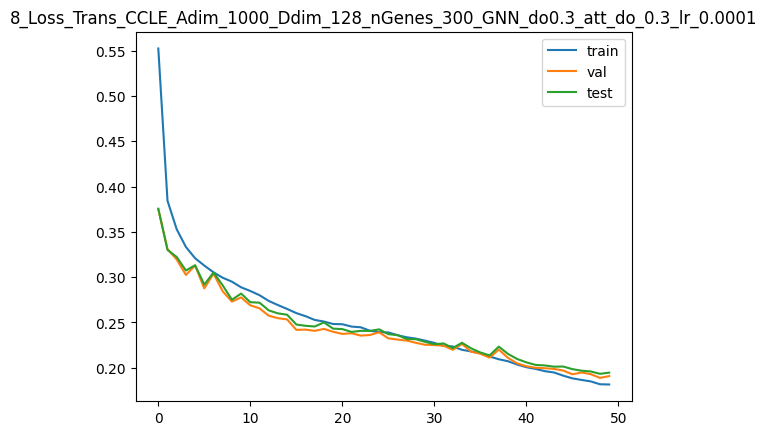

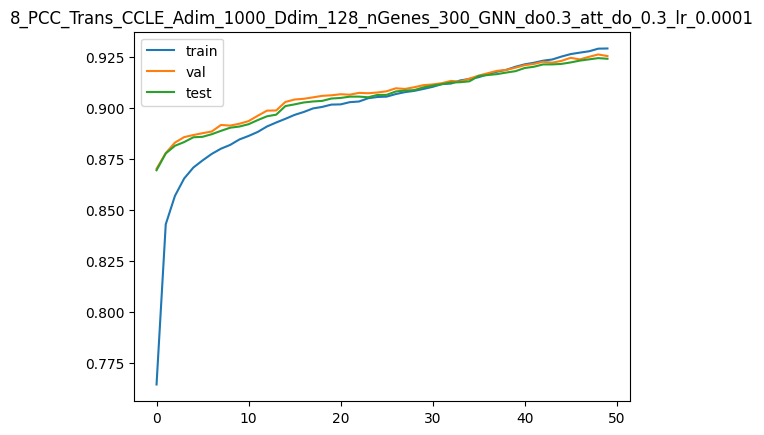

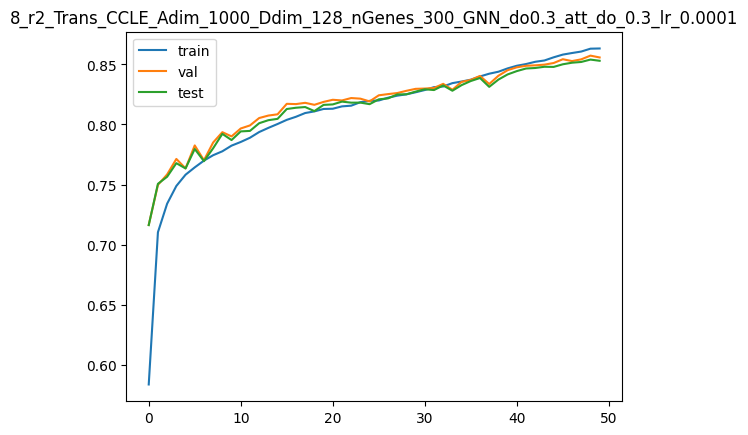

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17994525
Train avg_pcc:  0.9297071572549367
Train r2:  0.864351274664688


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1884081
Validation avg_pcc:  0.9262348124616708
Validation r2:  0.8574941930197638
Best Val r2  0.8574941930197638


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19143592
Test avg_pcc:  0.9252099028510101
Test r2:  0.8553133745390504
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17790785
Train avg_pcc:  0.930532658792418
Train r2:  0.8658871263771452


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18891849
Validation avg_pcc:  0.9267373330450276
Validation r2:  0.8571081627575425


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19331522
Test avg_pcc:  0.9248541283815043
Test r2:  0.8538930113867363
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17603667
Train avg_pcc:  0.9312905379353863
Train r2:  0.8672976933427652


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18379046
Validation avg_pcc:  0.9281026394476101
Validation r2:  0.8609868344605544
Best Val r2  0.8609868344605544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18869367
Test avg_pcc:  0.9260077811738976
Test r2:  0.857385953844255
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17358236
Train avg_pcc:  0.9322827290289528
Train r2:  0.8691478341848571


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18508554
Validation avg_pcc:  0.9274655323453995
Validation r2:  0.8600072817517777


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19029383
Test avg_pcc:  0.9255608831639711
Test r2:  0.8561765468322223
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17283799
Train avg_pcc:  0.9325835288880117
Train r2:  0.869708955456503


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18422076
Validation avg_pcc:  0.9278852210680713
Validation r2:  0.8606613668096784


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18887702
Test avg_pcc:  0.926244188510268
Test r2:  0.8572473993056173
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17039646
Train avg_pcc:  0.9335704646367672
Train r2:  0.8715494635980476


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18549259
Validation avg_pcc:  0.9274109991566715
Validation r2:  0.8596993972555074


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18886472
Test avg_pcc:  0.9259961353805866
Test r2:  0.8572566780765595
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16829054
Train avg_pcc:  0.9344196372537422
Train r2:  0.8731369867760342


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18187965
Validation avg_pcc:  0.9290685891721859
Validation r2:  0.8624321151873957
Best Val r2  0.8624321151873957


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18795623
Test avg_pcc:  0.9267184697004874
Test r2:  0.8579433134195273
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16765244
Train avg_pcc:  0.9346770087261932
Train r2:  0.8736179943271238


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18021362
Validation avg_pcc:  0.9293589513222973
Validation r2:  0.8636922470111714
Best Val r2  0.8636922470111714


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1842567
Test avg_pcc:  0.927812359029735
Test r2:  0.8607394043455192
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16648126
Train avg_pcc:  0.9351499361021883
Train r2:  0.8745008757053989


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18141522
Validation avg_pcc:  0.930005786513493
Validation r2:  0.8627833962862489


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18499906
Test avg_pcc:  0.9286673683893343
Test r2:  0.8601783362302717
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16486615
Train avg_pcc:  0.9358001062629407
Train r2:  0.8757184017202227


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18086915
Validation avg_pcc:  0.9301872259603743
Validation r2:  0.8631964256095607


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18352504
Test avg_pcc:  0.9290661767046099
Test r2:  0.8612923964076115
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16286618
Train avg_pcc:  0.936606031777768
Train r2:  0.8772260426692958


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17678355
Validation avg_pcc:  0.9309862480795016
Validation r2:  0.8662866300749209
Best Val r2  0.8662866300749209


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.180972
Test avg_pcc:  0.9292726680271479
Test r2:  0.8632219798712725
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16176043
Train avg_pcc:  0.9370504419887639
Train r2:  0.8780595912241518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17759642
Validation avg_pcc:  0.9304396694455298
Validation r2:  0.8656718126663425


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18077639
Test avg_pcc:  0.9292029716539799
Test r2:  0.8633698136284897
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16061354
Train avg_pcc:  0.9375110920880723
Train r2:  0.8789241688576146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1778964
Validation avg_pcc:  0.931058171572368
Validation r2:  0.8654449153255857


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18256932
Test avg_pcc:  0.9295513434159153
Test r2:  0.8620147150860286
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15890127
Train avg_pcc:  0.938201028862322
Train r2:  0.8802149207994696


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1754473
Validation avg_pcc:  0.9314489585644109
Validation r2:  0.8672973318562478
Best Val r2  0.8672973318562478


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.179653
Test avg_pcc:  0.929703769946227
Test r2:  0.8642188648675894
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15735367
Train avg_pcc:  0.9388208330371467
Train r2:  0.8813815568072813


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17475593
Validation avg_pcc:  0.9318296133801653
Validation r2:  0.8678202610583806
Best Val r2  0.8678202610583806


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17915241
Test avg_pcc:  0.9300696936396634
Test r2:  0.8645972057797582
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15657692
Train avg_pcc:  0.9391329088702174
Train r2:  0.8819670972484557


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17793526
Validation avg_pcc:  0.9318795609767788
Validation r2:  0.8654155212657065


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1823129
Test avg_pcc:  0.9302647572095518
Test r2:  0.8622085145095015
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15463175
Train avg_pcc:  0.9399133275370827
Train r2:  0.883433426602085


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17595541
Validation avg_pcc:  0.931907236780596
Validation r2:  0.8669130098795679


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17924905
Test avg_pcc:  0.9307247641103299
Test r2:  0.8645241823396911
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15351368
Train avg_pcc:  0.9403612453883445
Train r2:  0.8842762545885419


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17613585
Validation avg_pcc:  0.9322826551409338
Validation r2:  0.8667765314068295


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17958444
Test avg_pcc:  0.9308907827336944
Test r2:  0.8642706757425355
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15204781
Train avg_pcc:  0.9409497367093874
Train r2:  0.8853812818666835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1752461
Validation avg_pcc:  0.9328522443514324
Validation r2:  0.8674495105767052


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17956766
Test avg_pcc:  0.9309952169995586
Test r2:  0.8642833612675692
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14983998
Train avg_pcc:  0.9418322359126439
Train r2:  0.887045613047951


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17377381
Validation avg_pcc:  0.9323025087744733
Validation r2:  0.8685631098555762
Best Val r2  0.8685631098555762


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17756647
Test avg_pcc:  0.9309615471195335
Test r2:  0.8657958678944613
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14941642
Train avg_pcc:  0.9420027748484423
Train r2:  0.8873649363733782


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17209731
Validation avg_pcc:  0.9331675611873731
Validation r2:  0.8698311512152677
Best Val r2  0.8698311512152677


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17605498
Test avg_pcc:  0.9317630824144186
Test r2:  0.8669382451041827
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14875796
Train avg_pcc:  0.9422657368088982
Train r2:  0.8878612805856676


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17065133
Validation avg_pcc:  0.9334703337260087
Validation r2:  0.8709248473405042
Best Val r2  0.8709248473405042


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17573147
Test avg_pcc:  0.9314245715080656
Test r2:  0.8671827516719047
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1465346
Train avg_pcc:  0.943155151538506
Train r2:  0.8895373258113844


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17327513
Validation avg_pcc:  0.9340953194180525
Validation r2:  0.8689402956504158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17897373
Test avg_pcc:  0.9317419560620696
Test r2:  0.8647322554967288
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1454467
Train avg_pcc:  0.9435888468538164
Train r2:  0.8903574243375144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16862282
Validation avg_pcc:  0.9344393063396027
Validation r2:  0.872459153335455
Best Val r2  0.872459153335455


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17372587
Test avg_pcc:  0.932405160663633
Test r2:  0.8686985643329483
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14415371
Train avg_pcc:  0.9441055738109612
Train r2:  0.8913321331124923


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16992286
Validation avg_pcc:  0.934320437572958
Validation r2:  0.871475844524862


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17425993
Test avg_pcc:  0.9325077395550769
Test r2:  0.8682949408454614
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14378943
Train avg_pcc:  0.944250725683543
Train r2:  0.8916067458122261


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16714631
Validation avg_pcc:  0.9352883450431242
Validation r2:  0.8735759324611955
Best Val r2  0.8735759324611955


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17330931
Test avg_pcc:  0.9328769971042629
Test r2:  0.8690134089024496
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14070922
Train avg_pcc:  0.9454793740946346
Train r2:  0.8939287061731345


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17106637
Validation avg_pcc:  0.9351717672499003
Validation r2:  0.8706109216271203


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17651248
Test avg_pcc:  0.9330260357396511
Test r2:  0.8665924611355529
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1407938
Train avg_pcc:  0.9454463802410442
Train r2:  0.8938649358916687


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17047815
Validation avg_pcc:  0.9341406201433984
Validation r2:  0.8710558356939897


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1725482
Test avg_pcc:  0.9332696645718705
Test r2:  0.8695886441482761
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13945799
Train avg_pcc:  0.9459781364379607
Train r2:  0.8948719114838217


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16650878
Validation avg_pcc:  0.9349777912481915
Validation r2:  0.8740581328183539
Best Val r2  0.8740581328183539


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17016192
Test avg_pcc:  0.9335426008697704
Test r2:  0.8713921972006301
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13871346
Train avg_pcc:  0.9462744095425148
Train r2:  0.8954331554157813


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16594552
Validation avg_pcc:  0.9353014773799057
Validation r2:  0.874484169341967
Best Val r2  0.874484169341967


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16917823
Test avg_pcc:  0.9339811884701869
Test r2:  0.8721356590479912
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13816446
Train avg_pcc:  0.946493821984203
Train r2:  0.8958470255074155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16697001
Validation avg_pcc:  0.9355190353944025
Validation r2:  0.8737092732546266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17176576
Test avg_pcc:  0.9334766655675643
Test r2:  0.8701800208489013
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13567916
Train avg_pcc:  0.9474827858251422
Train r2:  0.8977205193938864


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17112781
Validation avg_pcc:  0.9348202913899709
Validation r2:  0.8705644473661728


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17506
Test avg_pcc:  0.9332156678964337
Test r2:  0.8676902371809769
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13583583
Train avg_pcc:  0.9474212987679573
Train r2:  0.8976024283768768


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16461468
Validation avg_pcc:  0.9360225630615303
Validation r2:  0.8754907816034692
Best Val r2  0.8754907816034692


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16796355
Test avg_pcc:  0.9347022516687173
Test r2:  0.8730537150081482
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13431685
Train avg_pcc:  0.9480242021939972
Train r2:  0.8987474830922049


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1646394
Validation avg_pcc:  0.9358756752083369
Validation r2:  0.8754720967798928


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16817667
Test avg_pcc:  0.9344475930666237
Test r2:  0.8728926422097135
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1343389
Train avg_pcc:  0.9480156916842881
Train r2:  0.8987308549902826


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16447549
Validation avg_pcc:  0.93628374358001
Validation r2:  0.8755960623613616
Best Val r2  0.8755960623613616


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16855006
Test avg_pcc:  0.9345482572908338
Test r2:  0.8726104352363463
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13229476
Train avg_pcc:  0.9488273111447684
Train r2:  0.9002718076616021


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16627815
Validation avg_pcc:  0.9357765394255015
Validation r2:  0.8742325738960948


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17050843
Test avg_pcc:  0.9340261617946213
Test r2:  0.8711303002440118
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13255055
Train avg_pcc:  0.9487278254755135
Train r2:  0.9000789746377936


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1624349
Validation avg_pcc:  0.9366980720937823
Validation r2:  0.8771394835487383
Best Val r2  0.8771394835487383


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16606033
Test avg_pcc:  0.9352265543063443
Test r2:  0.8744921626667017
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13086174
Train avg_pcc:  0.9493965456671517
Train r2:  0.9013520475397494


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16389084
Validation avg_pcc:  0.936639178826086
Validation r2:  0.8760382657647148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16939393
Test avg_pcc:  0.9344332408672495
Test r2:  0.871972649686267
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12961754
Train avg_pcc:  0.9498912650973699
Train r2:  0.9022899707140362


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1654858
Validation avg_pcc:  0.9362668109201852
Validation r2:  0.8748318910977756


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1703163
Test avg_pcc:  0.9342857421518816
Test r2:  0.8712755193988906
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12854956
Train avg_pcc:  0.9503145446216141
Train r2:  0.9030950604217947


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16305038
Validation avg_pcc:  0.9370804425193613
Validation r2:  0.8766739567145047


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16835575
Test avg_pcc:  0.9348769077663801
Test r2:  0.87275728507398
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12768723
Train avg_pcc:  0.9506563113441737
Train r2:  0.9037451001570481


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16237296
Validation avg_pcc:  0.937051637969831
Validation r2:  0.8771863466590455
Best Val r2  0.8771863466590455


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16750826
Test avg_pcc:  0.9349155423422357
Test r2:  0.8733978220186438
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12725735
Train avg_pcc:  0.9508270001813042
Train r2:  0.9040691660495845


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16060795
Validation avg_pcc:  0.9375404445677559
Validation r2:  0.8785213342497639
Best Val r2  0.8785213342497639


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16555455
Test avg_pcc:  0.9355289606148618
Test r2:  0.8748744130800856
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12607186
Train avg_pcc:  0.9512970696799368
Train r2:  0.9049628376582886


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16105998
Validation avg_pcc:  0.9377741918051737
Validation r2:  0.8781794400599099


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16643545
Test avg_pcc:  0.9355389010238234
Test r2:  0.8742086381505041
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12492385
Train avg_pcc:  0.9517514942514469
Train r2:  0.9058282382726986


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16313261
Validation avg_pcc:  0.9373592357545916
Validation r2:  0.876611773286738


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16830689
Test avg_pcc:  0.9351776305655939
Test r2:  0.8727942173433738
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.124752045
Train avg_pcc:  0.9518190165185831
Train r2:  0.9059577558067905


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16476126
Validation avg_pcc:  0.9374304007266818
Validation r2:  0.8753799021924976


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16928361
Test avg_pcc:  0.9355697084743212
Test r2:  0.8720560087708918
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12399353
Train avg_pcc:  0.9521202735939928
Train r2:  0.9065295333948059


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16320455
Validation avg_pcc:  0.937246096008213
Validation r2:  0.8765573452075983


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16678742
Test avg_pcc:  0.9357625293340804
Test r2:  0.8739426339403418
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12327116
Train avg_pcc:  0.9524061389463254
Train r2:  0.9070740917974054


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1601824
Validation avg_pcc:  0.9379711077942959
Validation r2:  0.8788432183879814
Best Val r2  0.8788432183879814


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16646469
Test avg_pcc:  0.9355285881579809
Test r2:  0.8741865471867079
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12222711
Train avg_pcc:  0.9528184359660944
Train r2:  0.9078611169304206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15918258
Validation avg_pcc:  0.9382195626729968
Validation r2:  0.879599443999368
Best Val r2  0.879599443999368


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16601554
Test avg_pcc:  0.9354699816188148
Test r2:  0.8745260087763731
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.120978765
Train avg_pcc:  0.9533125923478398
Train r2:  0.9088021755067474


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15936676
Validation avg_pcc:  0.9381486854465444
Validation r2:  0.8794601315971219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16317435
Test avg_pcc:  0.9365581630223138
Test r2:  0.8766733744126511
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.120600834
Train avg_pcc:  0.9534621502760581
Train r2:  0.9090870718581476


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16109286
Validation avg_pcc:  0.9381747776261097
Validation r2:  0.8781545666184555


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16537282
Test avg_pcc:  0.936361315816391
Test r2:  0.8750117827702225


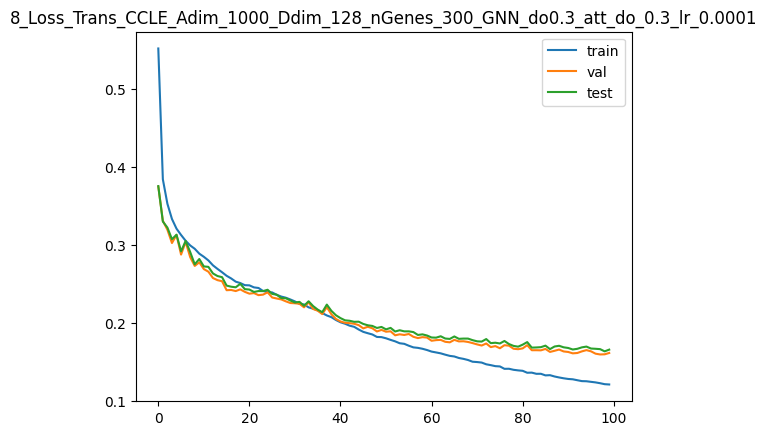

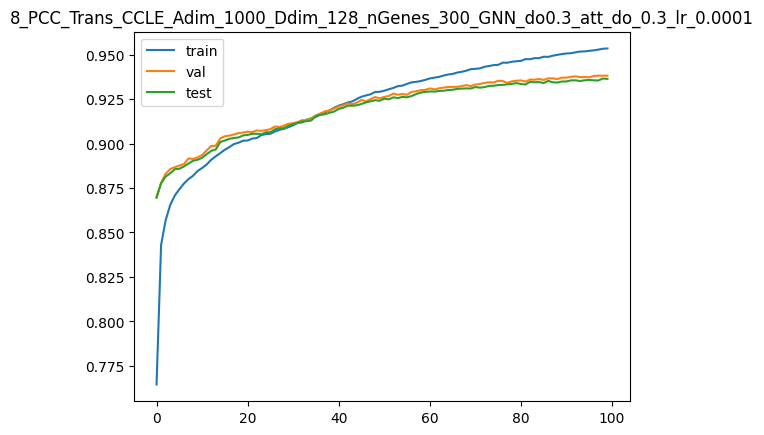

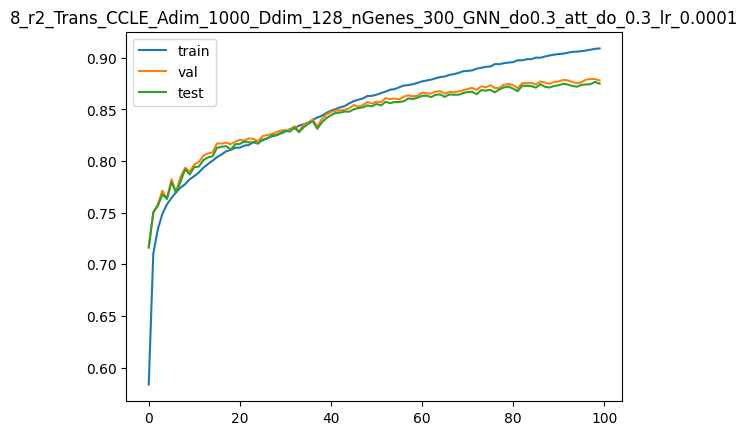

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1195217
Train avg_pcc:  0.9538886402872299
Train r2:  0.9099005672824337


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1632086
Validation avg_pcc:  0.9382153781851947
Validation r2:  0.8765542965997475


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16808334
Test avg_pcc:  0.9361534441652208
Test r2:  0.8729631646714285
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11943193
Train avg_pcc:  0.9539234791811927
Train r2:  0.9099682253537982


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15770741
Validation avg_pcc:  0.9384688820783025
Validation r2:  0.8807152153832418
Best Val r2  0.8807152153832418


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16325231
Test avg_pcc:  0.9362960536459721
Test r2:  0.8766144501642108
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.118032575
Train avg_pcc:  0.9544765815838948
Train r2:  0.911023112287518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16024937
Validation avg_pcc:  0.9378145074858493
Validation r2:  0.8787925603440024


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16437835
Test avg_pcc:  0.9361722740540035
Test r2:  0.8757634010308738
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.117451146
Train avg_pcc:  0.9547061261347661
Train r2:  0.9114614137968857


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15924244
Validation avg_pcc:  0.9383685823593356
Validation r2:  0.8795541639484099


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16431314
Test avg_pcc:  0.9363279571546331
Test r2:  0.8758126862450208
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11594583
Train avg_pcc:  0.9553005188341421
Train r2:  0.9125961692028097


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15640113
Validation avg_pcc:  0.939341951538977
Validation r2:  0.881703240247282
Best Val r2  0.881703240247282


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16153032
Test avg_pcc:  0.9372498883028798
Test r2:  0.8779159270354872
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11576046
Train avg_pcc:  0.9553734032425206
Train r2:  0.9127359001297928


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1606177
Validation avg_pcc:  0.9385352572570885
Validation r2:  0.8785139617044118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16517176
Test avg_pcc:  0.9365929931667323
Test r2:  0.8751637436079988
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11549358
Train avg_pcc:  0.9554788216420461
Train r2:  0.9129370795031643


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15622324
Validation avg_pcc:  0.9390768598710058
Validation r2:  0.881837781343435
Best Val r2  0.881837781343435


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1613523
Test avg_pcc:  0.9370577697615635
Test r2:  0.8780504661451366
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.115321346
Train avg_pcc:  0.9555467640465436
Train r2:  0.9130669244585697


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15890808
Validation avg_pcc:  0.9383864946204046
Validation r2:  0.8798070660852847


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16211827
Test avg_pcc:  0.9370492679317792
Test r2:  0.8774715514119792
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1142352
Train avg_pcc:  0.9559750378052958
Train r2:  0.9138856917797801


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16086917
Validation avg_pcc:  0.9382296415217863
Validation r2:  0.8783237693519268


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16368683
Test avg_pcc:  0.9369604052589731
Test r2:  0.8762860501018309
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.113507345
Train avg_pcc:  0.9562617924489427
Train r2:  0.9144343701052648


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15696488
Validation avg_pcc:  0.9389091527245316
Validation r2:  0.8812768378304219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16208498
Test avg_pcc:  0.9369033486817108
Test r2:  0.877496720581199
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11307744
Train avg_pcc:  0.956431573542567
Train r2:  0.9147584587204773


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1589436
Validation avg_pcc:  0.938925191794526
Validation r2:  0.8797802042435567


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16159618
Test avg_pcc:  0.9378217262905013
Test r2:  0.8778661419681842
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1115516
Train avg_pcc:  0.9570325376537823
Train r2:  0.915908693541665


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15821104
Validation avg_pcc:  0.9384661123705016
Validation r2:  0.8803342924406584


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16069068
Test avg_pcc:  0.9374714898973465
Test r2:  0.8785505371253438
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.111281715
Train avg_pcc:  0.9571390419925379
Train r2:  0.9161121327584818


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15785837
Validation avg_pcc:  0.9392391791718673
Validation r2:  0.8806010301855471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16131018
Test avg_pcc:  0.937743336727548
Test r2:  0.8780823063586156
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11059238
Train avg_pcc:  0.9574099006412741
Train r2:  0.916631775246187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15921915
Validation avg_pcc:  0.9382644436192006
Validation r2:  0.8795717901119878


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16028288
Test avg_pcc:  0.9378680917998349
Test r2:  0.878858737604835
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11014773
Train avg_pcc:  0.9575852134146173
Train r2:  0.9169669675592975


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16177672
Validation avg_pcc:  0.9387469528467643
Validation r2:  0.8776373181627641


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16472073
Test avg_pcc:  0.9374357244294499
Test r2:  0.8755046240987698
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10989185
Train avg_pcc:  0.9576860597813969
Train r2:  0.91715986888865


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15687051
Validation avg_pcc:  0.9398714980948714
Validation r2:  0.8813482205861638


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16154805
Test avg_pcc:  0.9379259331335609
Test r2:  0.8779025246112239
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.108901195
Train avg_pcc:  0.9580757688681191
Train r2:  0.9179066541010543


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15613444
Validation avg_pcc:  0.9393840693722414
Validation r2:  0.8819049579224584
Best Val r2  0.8819049579224584


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16100514
Test avg_pcc:  0.9374123225384426
Test r2:  0.8783128597101413
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.108630516
Train avg_pcc:  0.9581822598333198
Train r2:  0.9181106882067305


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15593164
Validation avg_pcc:  0.9394190896839667
Validation r2:  0.8820583571775047
Best Val r2  0.8820583571775047


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1587272
Test avg_pcc:  0.9383393330268022
Test r2:  0.8800345188582104
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10820427
Train avg_pcc:  0.9583501353711592
Train r2:  0.9184320098910495


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1554654
Validation avg_pcc:  0.9395541165968029
Validation r2:  0.8824109968942064
Best Val r2  0.8824109968942064


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15828359
Test avg_pcc:  0.9383926521977786
Test r2:  0.8803697948484608
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10786753
Train avg_pcc:  0.9584819806917879
Train r2:  0.918685856491017


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15698493
Validation avg_pcc:  0.9391905071829101
Validation r2:  0.8812616838886113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15882413
Test avg_pcc:  0.9384371334896294
Test r2:  0.8799612647080184
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10651637
Train avg_pcc:  0.9590135371422984
Train r2:  0.9197044019664391


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15557103
Validation avg_pcc:  0.9394498490971364
Validation r2:  0.8823311006312088


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15817456
Test avg_pcc:  0.9384537183692174
Test r2:  0.880452196028991
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10649964
Train avg_pcc:  0.9590203338746258
Train r2:  0.9197170241594208


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1590485
Validation avg_pcc:  0.9385075395851112
Validation r2:  0.8797008571597067


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16154285
Test avg_pcc:  0.9374695127471551
Test r2:  0.8779064562716392
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10571369
Train avg_pcc:  0.9593287843548408
Train r2:  0.920309506789573


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1552483
Validation avg_pcc:  0.9396102936319658
Validation r2:  0.8825751984137151
Best Val r2  0.8825751984137151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.160369
Test avg_pcc:  0.9375636992194071
Test r2:  0.878793663437335
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10539597
Train avg_pcc:  0.9594539355310974
Train r2:  0.9205489982695161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15518542
Validation avg_pcc:  0.9399165155849065
Validation r2:  0.8826227661048461
Best Val r2  0.8826227661048461


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15931706
Test avg_pcc:  0.9381804065118018
Test r2:  0.8795886935332397
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10532797
Train avg_pcc:  0.9594801856909008
Train r2:  0.9206002601819643


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15430088
Validation avg_pcc:  0.940129129285366
Validation r2:  0.883291801784444
Best Val r2  0.883291801784444


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15772058
Test avg_pcc:  0.9387089521376183
Test r2:  0.8807953175643803
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10455356
Train avg_pcc:  0.9597849288005564
Train r2:  0.9211840325615437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15655518
Validation avg_pcc:  0.93943531169752
Validation r2:  0.8815867191438739


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15894943
Test avg_pcc:  0.9384105612343615
Test r2:  0.8798665547120821
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10394853
Train avg_pcc:  0.9600226472704406
Train r2:  0.9216401294164147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1563883
Validation avg_pcc:  0.9394560619975246
Validation r2:  0.8817129523544401


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15820706
Test avg_pcc:  0.9386414884102574
Test r2:  0.880427638755941
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.103298016
Train avg_pcc:  0.9602770094543325
Train r2:  0.9221305062855726


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15549491
Validation avg_pcc:  0.9396008374871752
Validation r2:  0.8823886748577765


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15997082
Test avg_pcc:  0.9377725302558835
Test r2:  0.8790945989522106
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.102758765
Train avg_pcc:  0.9604888768488192
Train r2:  0.9225370147924253


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15586926
Validation avg_pcc:  0.9397842750109751
Validation r2:  0.8821055298311822


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16018079
Test avg_pcc:  0.9380278853267002
Test r2:  0.8789359040713698
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1023296
Train avg_pcc:  0.9606579956123686
Train r2:  0.9228605306797267


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16459017
Validation avg_pcc:  0.9400178750316897
Validation r2:  0.8755093088291999


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16672848
Test avg_pcc:  0.9388903044038813
Test r2:  0.8739871717077368
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1022038
Train avg_pcc:  0.9607066697616421
Train r2:  0.9229553652277744


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15637021
Validation avg_pcc:  0.9404134561050019
Validation r2:  0.8817266375942948


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16119336
Test avg_pcc:  0.9383736060998709
Test r2:  0.8781706079845302
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1016703
Train avg_pcc:  0.960916672863379
Train r2:  0.9233575382519396


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15510334
Validation avg_pcc:  0.9400165899916523
Validation r2:  0.8826848430056908


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16001227
Test avg_pcc:  0.9381151963520735
Test r2:  0.8790632611399094
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10074125
Train avg_pcc:  0.9612800028172986
Train r2:  0.9240578784032273


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15747398
Validation avg_pcc:  0.9404898421416441
Validation r2:  0.880891770496704


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16043912
Test avg_pcc:  0.9390892967332487
Test r2:  0.8787406558659709
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10088423
Train avg_pcc:  0.9612246297858003
Train r2:  0.923950106064306


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1564949
Validation avg_pcc:  0.9400527975921364
Validation r2:  0.8816323150261794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15841642
Test avg_pcc:  0.939131852012804
Test r2:  0.8802694079870462
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10096887
Train avg_pcc:  0.9611913292551247
Train r2:  0.9238863081155715


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15579906
Validation avg_pcc:  0.9403412993759477
Validation r2:  0.8821586223893481


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15806374
Test avg_pcc:  0.939277628196019
Test r2:  0.8805359600852958
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09998964
Train avg_pcc:  0.9615750674804829
Train r2:  0.9246244807880745


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15448222
Validation avg_pcc:  0.9401039644299151
Validation r2:  0.8831546457038988


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15645836
Test avg_pcc:  0.9392764360559879
Test r2:  0.8817492963822882
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.099665366
Train avg_pcc:  0.961702500060991
Train r2:  0.9248689258184697


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15674253
Validation avg_pcc:  0.9399353178798724
Validation r2:  0.881445011196467


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15922977
Test avg_pcc:  0.9388286309430276
Test r2:  0.8796546736814415
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.098839924
Train avg_pcc:  0.962025457382204
Train r2:  0.9254911670147612


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15554143
Validation avg_pcc:  0.9405491856958099
Validation r2:  0.8823534842621997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1578254
Test avg_pcc:  0.9394757587726348
Test r2:  0.8807160939282331
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09864669
Train avg_pcc:  0.962101431571508
Train r2:  0.9256368377141725


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15418436
Validation avg_pcc:  0.9404323081212408
Validation r2:  0.8833799300597672
Best Val r2  0.8833799300597672


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15761857
Test avg_pcc:  0.938968521073491
Test r2:  0.8808724173165443
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09747781
Train avg_pcc:  0.96255981097762
Train r2:  0.9265179810894615


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15459542
Validation avg_pcc:  0.9405775270565285
Validation r2:  0.883069027892535


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1584874
Test avg_pcc:  0.9388852262102881
Test r2:  0.8802157610548897
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09823136
Train avg_pcc:  0.9622637662304246
Train r2:  0.9259499254936386


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15391988
Validation avg_pcc:  0.9401346624538628
Validation r2:  0.883579979197451
Best Val r2  0.883579979197451


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15628822
Test avg_pcc:  0.939190938871605
Test r2:  0.8818778956042668
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09749423
Train avg_pcc:  0.9625530304564206
Train r2:  0.9265055906666336


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15259527
Validation avg_pcc:  0.940755943191046
Validation r2:  0.884581871022476
Best Val r2  0.884581871022476


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15611947
Test avg_pcc:  0.9393755939702014
Test r2:  0.8820054354165828
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09691273
Train avg_pcc:  0.9627805430474511
Train r2:  0.9269439547242488


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15220161
Validation avg_pcc:  0.9407467578023446
Validation r2:  0.8848796332399549
Best Val r2  0.8848796332399549


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1565794
Test avg_pcc:  0.9390114469229623
Test r2:  0.8816578083505074
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09680788
Train avg_pcc:  0.9628215188322843
Train r2:  0.9270229928252184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15318511
Validation avg_pcc:  0.9403013244556014
Validation r2:  0.8841357257230312


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15842696
Test avg_pcc:  0.9382344544563982
Test r2:  0.8802614521761571
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09592671
Train avg_pcc:  0.9631663990028533
Train r2:  0.9276872521173078


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15357842
Validation avg_pcc:  0.9406304688624266
Validation r2:  0.8838382449778321


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15763278
Test avg_pcc:  0.9389400718278024
Test r2:  0.8808616742758092
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09637321
Train avg_pcc:  0.962991573413445
Train r2:  0.9273506682146945


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15282713
Validation avg_pcc:  0.9410355468329784
Validation r2:  0.8844065015677599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15674849
Test avg_pcc:  0.9393900043682958
Test r2:  0.8815300308208497
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.095817566
Train avg_pcc:  0.9632088691221106
Train r2:  0.9277695262567958


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15672855
Validation avg_pcc:  0.9404044751341876
Validation r2:  0.8814555965432347


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15887427
Test avg_pcc:  0.9393939559057644
Test r2:  0.8799233656441564
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09554928
Train avg_pcc:  0.963314053254419
Train r2:  0.9279717664149135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15294465
Validation avg_pcc:  0.9409505255424383
Validation r2:  0.8843176084746449


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15678795
Test avg_pcc:  0.9393272233809813
Test r2:  0.8815001911626802
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0941994
Train avg_pcc:  0.9638425657724385
Train r2:  0.9289893539061773


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15454568
Validation avg_pcc:  0.9403114381447218
Validation r2:  0.8831066547701529


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15730107
Test avg_pcc:  0.9391535499952213
Test r2:  0.8811123808071717
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0943246
Train avg_pcc:  0.9637930144958974
Train r2:  0.9288949571683863


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15764745
Validation avg_pcc:  0.9400307735063609
Validation r2:  0.8807605753630102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15900238
Test avg_pcc:  0.9393094407202454
Test r2:  0.8798265346135352


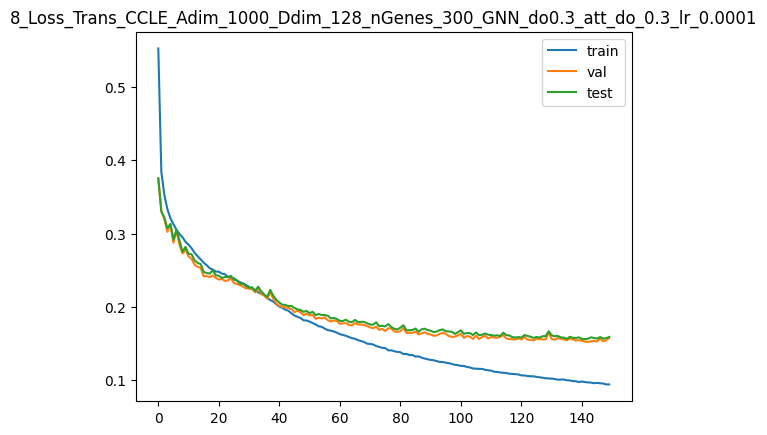

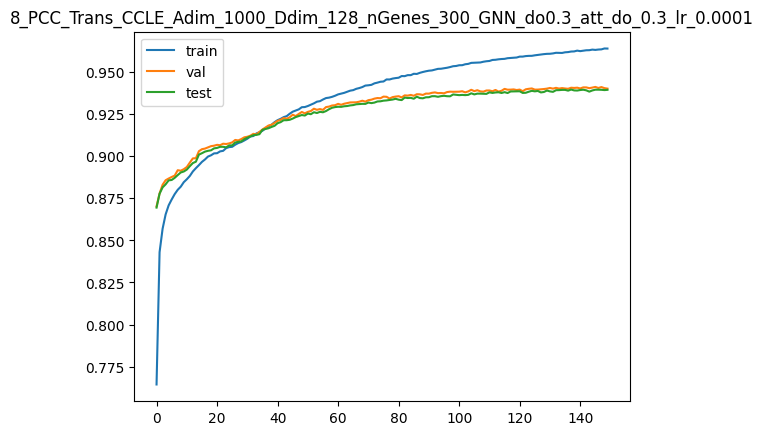

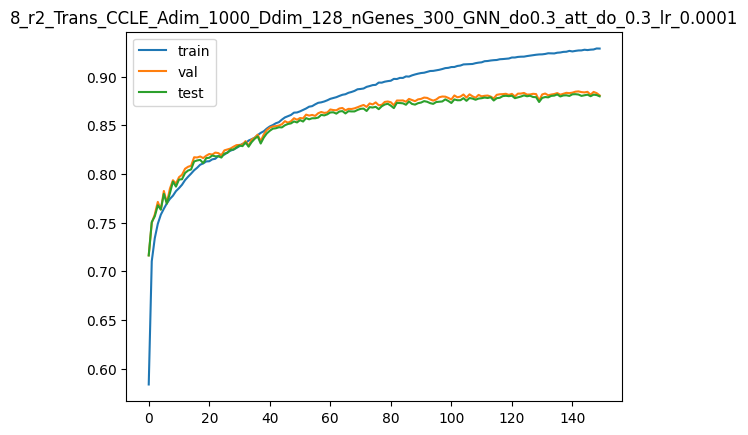

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1565794
Test avg_pcc:  0.9390114468398492
Test r2:  0.8816578082074875


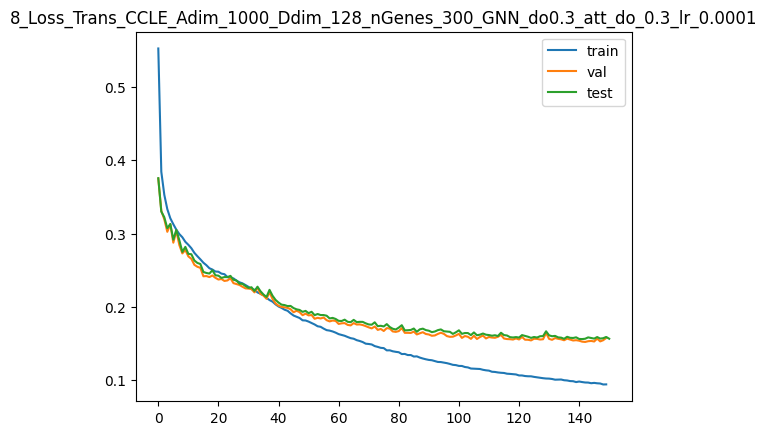

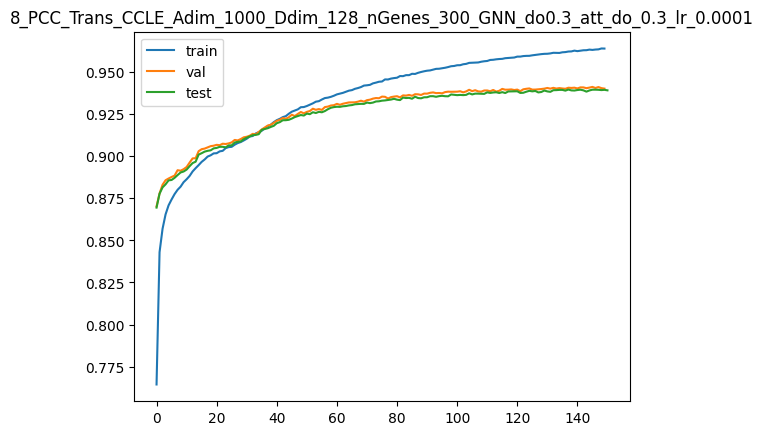

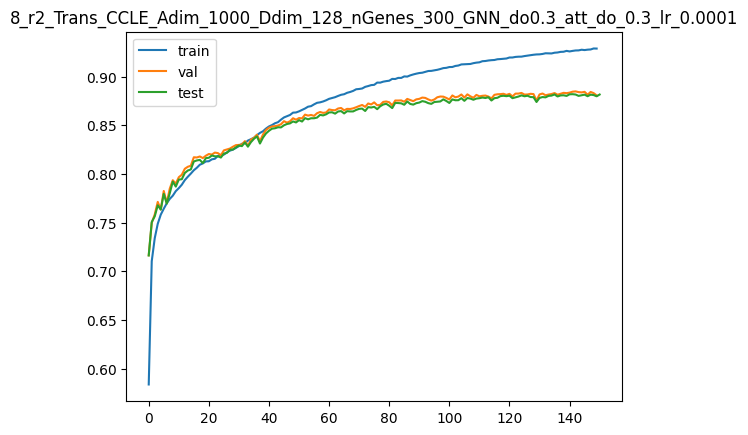

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.55619115
Train avg_pcc:  0.7602596348455093
Train r2:  0.5772108382338342


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.33395943
Validation avg_pcc:  0.8695970557957908
Validation r2:  0.7526542895145871
Best Val r2  0.7526542895145871


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.34041572
Test avg_pcc:  0.8705087376991099
Test r2:  0.7537640388410705
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.380377
Train avg_pcc:  0.8432980512618219
Train r2:  0.7108560731550926


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3193301
Validation avg_pcc:  0.8779360126438233
Validation r2:  0.7634894211032746
Best Val r2  0.7634894211032746


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32713816
Test avg_pcc:  0.8782756172395132
Test r2:  0.7633682285422432
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.35146073
Train avg_pcc:  0.8561813179608732
Train r2:  0.7328368273722127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31398982
Validation avg_pcc:  0.8844978370578496
Validation r2:  0.7674447077461719
Best Val r2  0.7674447077461719


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32424533
Test avg_pcc:  0.883755348439292
Test r2:  0.765460728120268
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.33457273
Train avg_pcc:  0.8635992106754153
Train r2:  0.7456742205391258


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30281192
Validation avg_pcc:  0.8878417615743529
Validation r2:  0.7757235372035833
Best Val r2  0.7757235372035833


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3143769
Test avg_pcc:  0.8864209780691805
Test r2:  0.7725989560389801
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.32286394
Train avg_pcc:  0.8687152037995026
Train r2:  0.7545746892962898


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29037908
Validation avg_pcc:  0.8881062121936946
Validation r2:  0.7849318981303458
Best Val r2  0.7849318981303458


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29686925
Test avg_pcc:  0.8886701836894834
Test r2:  0.7852629152004651
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3137384
Train avg_pcc:  0.8726836699102778
Train r2:  0.7615114704460566


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2981163
Validation avg_pcc:  0.8888270646262076
Validation r2:  0.7792013519040617


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30490088
Test avg_pcc:  0.889077086999567
Test r2:  0.7794533222268465
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.30485296
Train avg_pcc:  0.8765297793533059
Train r2:  0.7682657508104291


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28549248
Validation avg_pcc:  0.8902142687704556
Validation r2:  0.7885511321616471
Best Val r2  0.7885511321616471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29153135
Test avg_pcc:  0.8906248375026706
Test r2:  0.7891240085276493
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29857975
Train avg_pcc:  0.8792378106388089
Train r2:  0.7730343586601394


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30268916
Validation avg_pcc:  0.8904228756538477
Validation r2:  0.7758144901108127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.310433
Test avg_pcc:  0.8905485289733628
Test r2:  0.7754517078444727
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29368117
Train avg_pcc:  0.8813503321971382
Train r2:  0.7767579833664908


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2813611
Validation avg_pcc:  0.8922217185309553
Validation r2:  0.7916110475211828
Best Val r2  0.7916110475211828


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28801417
Test avg_pcc:  0.8921779305570754
Test r2:  0.7916681397238308
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.287979
Train avg_pcc:  0.8838071961466614
Train r2:  0.781092494458045


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27491677
Validation avg_pcc:  0.8929243312558038
Validation r2:  0.7963839686106561
Best Val r2  0.7963839686106561


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28262472
Test avg_pcc:  0.8926073387801257
Test r2:  0.7955665130449043
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.28583962
Train avg_pcc:  0.8847188909396414
Train r2:  0.7827187398686997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28287476
Validation avg_pcc:  0.893190002027038
Validation r2:  0.7904899334201827


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28767607
Test avg_pcc:  0.894084592539488
Test r2:  0.7919127086282336
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.28143927
Train avg_pcc:  0.8866085743355495
Train r2:  0.7860636617605978


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2724966
Validation avg_pcc:  0.8952219448491241
Validation r2:  0.7981764765726361
Best Val r2  0.7981764765726361


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27611604
Test avg_pcc:  0.896378981031035
Test r2:  0.8002745081179002
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.27799758
Train avg_pcc:  0.888082901576262
Train r2:  0.7886798853089352


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27421293
Validation avg_pcc:  0.8931406336358216
Validation r2:  0.7969052847644327


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27891505
Test avg_pcc:  0.8939441288825052
Test r2:  0.7982498912138073
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.27356428
Train avg_pcc:  0.8899782940066536
Train r2:  0.7920498852435252


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26306158
Validation avg_pcc:  0.897830310363502
Validation r2:  0.805164481207073
Best Val r2  0.805164481207073


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26550773
Test avg_pcc:  0.8993224639238588
Test r2:  0.8079479170989229
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26769313
Train avg_pcc:  0.8924829342077301
Train r2:  0.7965128343805421


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2560354
Validation avg_pcc:  0.9002775698597962
Validation r2:  0.8103684098487396
Best Val r2  0.8103684098487396


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25678325
Test avg_pcc:  0.9024472809709583
Test r2:  0.8142586780541445
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26101813
Train avg_pcc:  0.8953180560928988
Train r2:  0.8015868270593869


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2529726
Validation avg_pcc:  0.9015885447990011
Validation r2:  0.8126368669175711
Best Val r2  0.8126368669175711


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25360817
Test avg_pcc:  0.903752419583223
Test r2:  0.8165553331969757
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25753132
Train avg_pcc:  0.8967977543691064
Train r2:  0.8042373423056144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24814498
Validation avg_pcc:  0.904548111435248
Validation r2:  0.816212421953054
Best Val r2  0.816212421953054


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24952672
Test avg_pcc:  0.9060472132329069
Test r2:  0.8195075979379867
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.254391
Train avg_pcc:  0.8981287007533416
Train r2:  0.8066244420504209


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25196555
Validation avg_pcc:  0.9042311641768719
Validation r2:  0.8133827334169386


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25336865
Test avg_pcc:  0.9062812627231216
Test r2:  0.8167285860997375
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25202608
Train avg_pcc:  0.8991275194984135
Train r2:  0.8084221538908297


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24307051
Validation avg_pcc:  0.9056139322932394
Validation r2:  0.8199707965438449
Best Val r2  0.8199707965438449


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24592969
Test avg_pcc:  0.9067708278502017
Test r2:  0.8221094798641311
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24923404
Train avg_pcc:  0.9003086635210941
Train r2:  0.81054453000669


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24334452
Validation avg_pcc:  0.9056217039910016
Validation r2:  0.819767855236253


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2432909
Test avg_pcc:  0.9079890531675138
Test r2:  0.8240182289220341
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24483278
Train avg_pcc:  0.9021621365360106
Train r2:  0.8138901444608868


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24288256
Validation avg_pcc:  0.9060431186940742
Validation r2:  0.8201099884281926
Best Val r2  0.8201099884281926


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24323218
Test avg_pcc:  0.9081866346388664
Test r2:  0.824060697274366
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24401025
Train avg_pcc:  0.90251025143708
Train r2:  0.8145153780982257


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24381141
Validation avg_pcc:  0.9073225507113494
Validation r2:  0.8194220543563374


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24319872
Test avg_pcc:  0.9097334062131325
Test r2:  0.8240848953560456
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2432854
Train avg_pcc:  0.9028148741810889
Train r2:  0.8150663689137294


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24073972
Validation avg_pcc:  0.9077561460887389
Validation r2:  0.8216971036574391
Best Val r2  0.8216971036574391


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24212141
Test avg_pcc:  0.9095478461585386
Test r2:  0.8248641449590028
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24074706
Train avg_pcc:  0.9038810136446613
Train r2:  0.816995915477532


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23947155
Validation avg_pcc:  0.9075797891334135
Validation r2:  0.822636356995747
Best Val r2  0.822636356995747


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23960306
Test avg_pcc:  0.9099272865171196
Test r2:  0.8266857859913939
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23868914
Train avg_pcc:  0.9047468183992988
Train r2:  0.8185602603450746


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24955559
Validation avg_pcc:  0.907023239802393
Validation r2:  0.8151676636422817


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24713038
Test avg_pcc:  0.9103931803945619
Test r2:  0.8212409723862322
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23670644
Train avg_pcc:  0.9055807568179468
Train r2:  0.8200673614152073


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23606482
Validation avg_pcc:  0.9089616594191412
Validation r2:  0.8251595328168037
Best Val r2  0.8251595328168037


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23557301
Test avg_pcc:  0.9115044386556712
Test r2:  0.829600872946794
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23449977
Train avg_pcc:  0.906503203416696
Train r2:  0.8217447785463631


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23753098
Validation avg_pcc:  0.9084649999126044
Validation r2:  0.8240736087740808


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23692338
Test avg_pcc:  0.9108314020192934
Test r2:  0.8286240890447877
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23251438
Train avg_pcc:  0.9073373374886566
Train r2:  0.8232539833599862


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23443286
Validation avg_pcc:  0.9091157936170318
Validation r2:  0.8263682293641741
Best Val r2  0.8263682293641741


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23130675
Test avg_pcc:  0.9126334368748319
Test r2:  0.8326868100363495
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23095189
Train avg_pcc:  0.9079905537580991
Train r2:  0.8244416999015066


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23369642
Validation avg_pcc:  0.9100040293507129
Validation r2:  0.8269136734756755
Best Val r2  0.8269136734756755


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23065397
Test avg_pcc:  0.9134197171868792
Test r2:  0.8331589981495823
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22865573
Train avg_pcc:  0.908953163287108
Train r2:  0.8261871451644911


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23563002
Validation avg_pcc:  0.9110779619290228
Validation r2:  0.8254815661694794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23218143
Test avg_pcc:  0.9143550707964149
Test r2:  0.8320541355152958
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22632359
Train avg_pcc:  0.9099250688777798
Train r2:  0.8279599248485612


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23490478
Validation avg_pcc:  0.9108561966488413
Validation r2:  0.8260186948793575


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23229198
Test avg_pcc:  0.9137602817231952
Test r2:  0.8319741796438875
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22466236
Train avg_pcc:  0.9106195361748132
Train r2:  0.8292226862286575


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23107615
Validation avg_pcc:  0.9113904239499696
Validation r2:  0.8288543734899961
Best Val r2  0.8288543734899961


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22917463
Test avg_pcc:  0.9143638230394939
Test r2:  0.8342290615954042
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22177684
Train avg_pcc:  0.9118231774332168
Train r2:  0.8314161299699434


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23004994
Validation avg_pcc:  0.9114768935923391
Validation r2:  0.8296144227143545
Best Val r2  0.8296144227143545


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22829226
Test avg_pcc:  0.9144485282931409
Test r2:  0.8348673150937393
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22006057
Train avg_pcc:  0.9125387556619872
Train r2:  0.8327207635633012


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22366574
Validation avg_pcc:  0.9137138633590111
Validation r2:  0.8343428424601113
Best Val r2  0.8343428424601113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22114426
Test avg_pcc:  0.9169794774943502
Test r2:  0.8400377377220908
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21801703
Train avg_pcc:  0.9133896573275448
Train r2:  0.8342741535538206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22232345
Validation avg_pcc:  0.9146772633474352
Validation r2:  0.8353370190313691
Best Val r2  0.8353370190313691


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22021218
Test avg_pcc:  0.9178364610917465
Test r2:  0.840711949737053
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2150817
Train avg_pcc:  0.914609796990417
Train r2:  0.8365054553327254


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22083366
Validation avg_pcc:  0.9150221421376308
Validation r2:  0.8364404300325328
Best Val r2  0.8364404300325328


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21752995
Test avg_pcc:  0.9182831110419771
Test r2:  0.8426521230378372
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21209522
Train avg_pcc:  0.9158491055856857
Train r2:  0.8387756432603436


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2163057
Validation avg_pcc:  0.916526733649454
Validation r2:  0.8397940459584121
Best Val r2  0.8397940459584121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21469657
Test avg_pcc:  0.9191309141061269
Test r2:  0.8447016099193012
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21056369
Train avg_pcc:  0.9164867073362633
Train r2:  0.8399398167712875


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21807474
Validation avg_pcc:  0.9165117596064203
Validation r2:  0.8384837995177232


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21676482
Test avg_pcc:  0.9194007691216977
Test r2:  0.843205558135494
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2072977
Train avg_pcc:  0.9178379104164579
Train r2:  0.842422485092898


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21604827
Validation avg_pcc:  0.9176289725001342
Validation r2:  0.8399847224088871
Best Val r2  0.8399847224088871


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21331067
Test avg_pcc:  0.9208873949579857
Test r2:  0.8457040852449448
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20510189
Train avg_pcc:  0.9187474823504784
Train r2:  0.8440915941409245


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20969497
Validation avg_pcc:  0.9191829708715363
Validation r2:  0.8446902608491714
Best Val r2  0.8446902608491714


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20709471
Test avg_pcc:  0.9221812398083074
Test r2:  0.8502003297428246
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20242338
Train avg_pcc:  0.9198542829244715
Train r2:  0.8461276902190018


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20911056
Validation avg_pcc:  0.9194186810858217
Validation r2:  0.8451231043836168
Best Val r2  0.8451231043836168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20697471
Test avg_pcc:  0.9223268985648753
Test r2:  0.8502871224759583
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19827904
Train avg_pcc:  0.9215652614848782
Train r2:  0.8492780065669303


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20423782
Validation avg_pcc:  0.9216165296295011
Validation r2:  0.8487320638609381
Best Val r2  0.8487320638609381


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20407099
Test avg_pcc:  0.9236495855387247
Test r2:  0.8523875106162982
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19667698
Train avg_pcc:  0.9222263632904655
Train r2:  0.8504958226960668


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20165473
Validation avg_pcc:  0.9223323909024502
Validation r2:  0.8506452256081142
Best Val r2  0.8506452256081142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20133467
Test avg_pcc:  0.9244133352807582
Test r2:  0.8543668093129411
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19462179
Train avg_pcc:  0.9230717267993862
Train r2:  0.852058082642712


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2027345
Validation avg_pcc:  0.9226284437258967
Validation r2:  0.849845519220708


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20112
Test avg_pcc:  0.9250596981653834
Test r2:  0.8545220524225476
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19202825
Train avg_pcc:  0.9241405760836147
Train r2:  0.8540295589218517


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19835031
Validation avg_pcc:  0.9242184812724449
Validation r2:  0.8530926503297043
Best Val r2  0.8530926503297043


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19783342
Test avg_pcc:  0.9265006091704706
Test r2:  0.8568993892320433
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1896067
Train avg_pcc:  0.9251345531439923
Train r2:  0.8558702996264334


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1970481
Validation avg_pcc:  0.924496299523327
Validation r2:  0.8540571188144868
Best Val r2  0.8540571188144868


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19715011
Test avg_pcc:  0.9263597020688238
Test r2:  0.8573936363594803
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18721074
Train avg_pcc:  0.9261191407341874
Train r2:  0.8576915930489235


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19658573
Validation avg_pcc:  0.9244802700854062
Validation r2:  0.8543995744723164
Best Val r2  0.8543995744723164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19426753
Test avg_pcc:  0.9273553579257265
Test r2:  0.8594787241351061
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18558975
Train avg_pcc:  0.9267834895138808
Train r2:  0.8589237966809525


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19362745
Validation avg_pcc:  0.9258161456593024
Validation r2:  0.8565906061841192
Best Val r2  0.8565906061841192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19327267
Test avg_pcc:  0.9277887029033629
Test r2:  0.8601983531412982
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18306284
Train avg_pcc:  0.9278192687244136
Train r2:  0.8608446233726835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19076228
Validation avg_pcc:  0.9268226747527061
Validation r2:  0.8587126652187805
Best Val r2  0.8587126652187805


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19059737
Test avg_pcc:  0.9287848835559106
Test r2:  0.8621334956317809
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18169893
Train avg_pcc:  0.9283774963292372
Train r2:  0.8618813960207087


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19285744
Validation avg_pcc:  0.9267576545398432
Validation r2:  0.8571609161965196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19350296
Test avg_pcc:  0.928409935351736
Test r2:  0.860031763628033


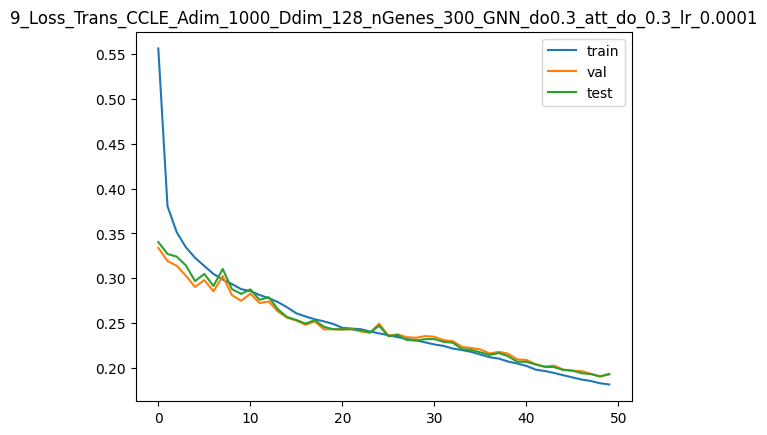

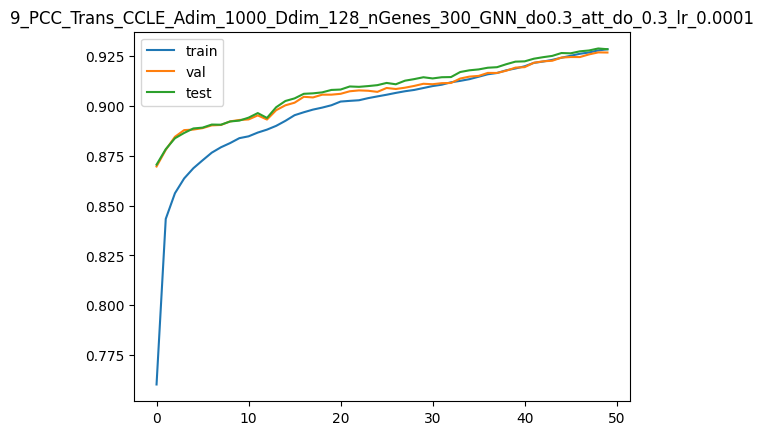

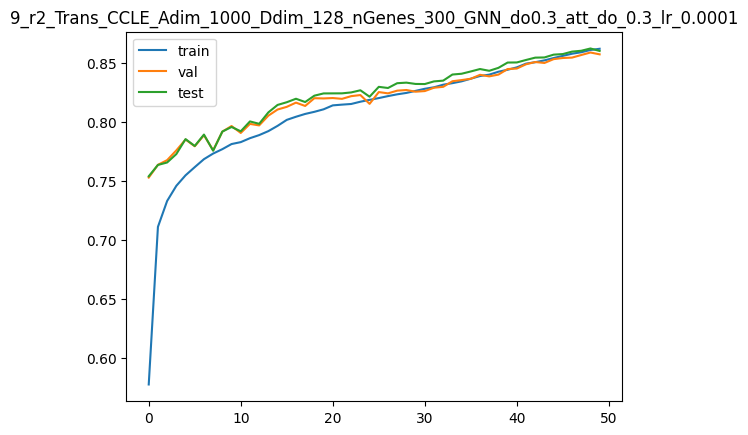

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17980671
Train avg_pcc:  0.9291530461861442
Train r2:  0.8633197648204385


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19454087
Validation avg_pcc:  0.9269860154542584
Validation r2:  0.8559140778915796


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19371045
Test avg_pcc:  0.9294088911261034
Test r2:  0.8598816758256813
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17752367
Train avg_pcc:  0.9300857148356101
Train r2:  0.8650552191691921


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18863201
Validation avg_pcc:  0.9276284240561922
Validation r2:  0.8602904481945249
Best Val r2  0.8602904481945249


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18796752
Test avg_pcc:  0.9297669839122654
Test r2:  0.8640357673468602
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17658882
Train avg_pcc:  0.9304673944961726
Train r2:  0.8657658467359328


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18728118
Validation avg_pcc:  0.9287176071199086
Validation r2:  0.8612909429590948
Best Val r2  0.8612909429590948


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18790324
Test avg_pcc:  0.9304117337131306
Test r2:  0.8640822697278095
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17444038
Train avg_pcc:  0.9313450752605641
Train r2:  0.8673989836034154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18629077
Validation avg_pcc:  0.9288488079670267
Validation r2:  0.8620244744338124
Best Val r2  0.8620244744338124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18799606
Test avg_pcc:  0.9301503038235144
Test r2:  0.8640151261097369
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17341064
Train avg_pcc:  0.9317648566948565
Train r2:  0.8681817426014248


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18562897
Validation avg_pcc:  0.9288712429849879
Validation r2:  0.8625146505765754
Best Val r2  0.8625146505765754


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18372895
Test avg_pcc:  0.9313209193420947
Test r2:  0.8671017006051378
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1710306
Train avg_pcc:  0.9327355528602241
Train r2:  0.8699909440609747


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1878373
Validation avg_pcc:  0.9292460791484367
Validation r2:  0.8608790585245216


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18533917
Test avg_pcc:  0.932099480361778
Test r2:  0.8659369612208603
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1698638
Train avg_pcc:  0.9332102146495543
Train r2:  0.8708778694805035


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.186062
Validation avg_pcc:  0.9288453440931141
Validation r2:  0.8621939352824928


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18396208
Test avg_pcc:  0.9313548407915546
Test r2:  0.8669330621360161
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1682137
Train avg_pcc:  0.9338825474835343
Train r2:  0.8721322063503459


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18461895
Validation avg_pcc:  0.9295593755817321
Validation r2:  0.8632627147089067
Best Val r2  0.8632627147089067


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18444404
Test avg_pcc:  0.931572928622677
Test r2:  0.8665844311916642
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16636248
Train avg_pcc:  0.9346355905056573
Train r2:  0.8735394070876528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18430324
Validation avg_pcc:  0.9296264821933642
Validation r2:  0.8634965427411567
Best Val r2  0.8634965427411567


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18308878
Test avg_pcc:  0.9320650620674845
Test r2:  0.8675647625564938
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16400789
Train avg_pcc:  0.9355922104955049
Train r2:  0.8753292501119673


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1832388
Validation avg_pcc:  0.9302463305633094
Validation r2:  0.8642849161564969
Best Val r2  0.8642849161564969


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18169448
Test avg_pcc:  0.9326283114878248
Test r2:  0.8685733076733982
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16348234
Train avg_pcc:  0.935806228475583
Train r2:  0.8757287378065118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18481664
Validation avg_pcc:  0.9294743698384276
Validation r2:  0.8631162908141498


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18077897
Test avg_pcc:  0.9330107886133708
Test r2:  0.8692355263185865
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16158926
Train avg_pcc:  0.9365741007486169
Train r2:  0.8771677619227317


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18085676
Validation avg_pcc:  0.9307238106527086
Validation r2:  0.8660491622155435
Best Val r2  0.8660491622155435


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17872348
Test avg_pcc:  0.9333083774692773
Test r2:  0.8707223408206668
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1600657
Train avg_pcc:  0.9371923630403503
Train r2:  0.8783259103150519


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18147
Validation avg_pcc:  0.9307829773152513
Validation r2:  0.8655949733118429


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18010648
Test avg_pcc:  0.9331334782701357
Test r2:  0.86972197733566
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15839104
Train avg_pcc:  0.9378709782788086
Train r2:  0.8795989062273722


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17859176
Validation avg_pcc:  0.9315734331823329
Validation r2:  0.867726719523066
Best Val r2  0.867726719523066


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17707406
Test avg_pcc:  0.9338029248082451
Test r2:  0.8719154313415648
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15794833
Train avg_pcc:  0.93805156753506
Train r2:  0.8799354238415442


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18135197
Validation avg_pcc:  0.9315433409383113
Validation r2:  0.8656823886315175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1795518
Test avg_pcc:  0.934264871758402
Test r2:  0.8701231949168622
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15523504
Train avg_pcc:  0.9391491303466754
Train r2:  0.8819979532149185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1796066
Validation avg_pcc:  0.9312599761033432
Validation r2:  0.8669750868064752


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17538853
Test avg_pcc:  0.9344708936730967
Test r2:  0.8731346500302337
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15374696
Train avg_pcc:  0.9397508591276003
Train r2:  0.8831291106504531


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17755623
Validation avg_pcc:  0.9323161822769361
Validation r2:  0.8684936911880414
Best Val r2  0.8684936911880414


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17583859
Test avg_pcc:  0.9348663261478776
Test r2:  0.8728090987252046
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15335104
Train avg_pcc:  0.9399116745312219
Train r2:  0.8834300619017756


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17707413
Validation avg_pcc:  0.9322651217706676
Validation r2:  0.8688507511741528
Best Val r2  0.8688507511741528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17386638
Test avg_pcc:  0.9353370289373093
Test r2:  0.8742356848829327
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15154007
Train avg_pcc:  0.9406432041838851
Train r2:  0.8848066848191013


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.176227
Validation avg_pcc:  0.9325570651978579
Validation r2:  0.8694781803145927
Best Val r2  0.8694781803145927


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1748496
Test avg_pcc:  0.9348482723840691
Test r2:  0.8735244688712076
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15042476
Train avg_pcc:  0.9410939616279859
Train r2:  0.8856544802327848


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1765793
Validation avg_pcc:  0.9326196506408134
Validation r2:  0.8692172437734389


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17370185
Test avg_pcc:  0.9351973804813842
Test r2:  0.8743546830669932
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14919645
Train avg_pcc:  0.9415903770083203
Train r2:  0.8865881929508909


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17789422
Validation avg_pcc:  0.9331018266943374
Validation r2:  0.8682433479575592


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17551307
Test avg_pcc:  0.9359022507342503
Test r2:  0.873044553410167
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14846414
Train avg_pcc:  0.9418852957209992
Train r2:  0.8871448407906589


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17326725
Validation avg_pcc:  0.9339556736910473
Validation r2:  0.8716703019918842
Best Val r2  0.8716703019918842


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17238739
Test avg_pcc:  0.936137931855144
Test r2:  0.8753054888773467
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14768012
Train avg_pcc:  0.9422021437869599
Train r2:  0.8877408358999959


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17221604
Validation avg_pcc:  0.9343728353260236
Validation r2:  0.8724488833830577
Best Val r2  0.8724488833830577


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17064089
Test avg_pcc:  0.9367295615442145
Test r2:  0.8765688063435503
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14632289
Train avg_pcc:  0.9427487956517115
Train r2:  0.8887725160451213


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17511941
Validation avg_pcc:  0.9333074833834104
Validation r2:  0.8702985092170434


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17051437
Test avg_pcc:  0.936719909402385
Test r2:  0.8766603153046441
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14480226
Train avg_pcc:  0.9433617996344117
Train r2:  0.8899284322003366


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17372285
Validation avg_pcc:  0.9337350536630872
Validation r2:  0.8713328597821638


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16984953
Test avg_pcc:  0.9368867317951951
Test r2:  0.877141223331618
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14396723
Train avg_pcc:  0.9436985151881048
Train r2:  0.8905631936911179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17190997
Validation avg_pcc:  0.9341792531859798
Validation r2:  0.8726755643033638
Best Val r2  0.8726755643033638


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16829932
Test avg_pcc:  0.9372187432469525
Test r2:  0.8782625491089243
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14177756
Train avg_pcc:  0.9445791813806794
Train r2:  0.8922276602579466


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17088695
Validation avg_pcc:  0.934656109344233
Validation r2:  0.8734332636083302
Best Val r2  0.8734332636083302


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16770647
Test avg_pcc:  0.9374215936767032
Test r2:  0.878691382849031
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14089264
Train avg_pcc:  0.9449361436479566
Train r2:  0.8929003293260148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17221026
Validation avg_pcc:  0.9340681804343425
Validation r2:  0.8724531497621606


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16938144
Test avg_pcc:  0.93682809257104
Test r2:  0.8774798060728902
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14019977
Train avg_pcc:  0.9452140004710493
Train r2:  0.8934270089275107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17160459
Validation avg_pcc:  0.9345730218555114
Validation r2:  0.8729017458460153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16841458
Test avg_pcc:  0.937593023523141
Test r2:  0.8781791830682796
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1383771
Train avg_pcc:  0.9459468170371215
Train r2:  0.8948125289686606


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17634362
Validation avg_pcc:  0.9345213803762952
Validation r2:  0.8693917993506842


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17097595
Test avg_pcc:  0.9382194075825769
Test r2:  0.8763264286759358
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13652936
Train avg_pcc:  0.9466895518272008
Train r2:  0.8962170737554693


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17087881
Validation avg_pcc:  0.9352999788933192
Validation r2:  0.873439285950741
Best Val r2  0.873439285950741


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16839954
Test avg_pcc:  0.938021416660026
Test r2:  0.8781900441757995
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13658278
Train avg_pcc:  0.9466678196499864
Train r2:  0.8961764716713679


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1728847
Validation avg_pcc:  0.9350685660896315
Validation r2:  0.8719536312834191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16965552
Test avg_pcc:  0.9380001735294332
Test r2:  0.8772815604097419
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13564508
Train avg_pcc:  0.9470438793563749
Train r2:  0.896889266803635


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17250377
Validation avg_pcc:  0.9343906733602761
Validation r2:  0.8722357656423457


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16845055
Test avg_pcc:  0.9376602592812653
Test r2:  0.8781531526842399
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13485464
Train avg_pcc:  0.9473612321722764
Train r2:  0.8974901209923558


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16963144
Validation avg_pcc:  0.9356435856963223
Validation r2:  0.874363157567367
Best Val r2  0.874363157567367


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16682783
Test avg_pcc:  0.9384986948464973
Test r2:  0.8793269281397103
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13365048
Train avg_pcc:  0.9478440232628593
Train r2:  0.8984054746285325


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16828783
Validation avg_pcc:  0.9357414141768745
Validation r2:  0.8753582827498636
Best Val r2  0.8753582827498636


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16460086
Test avg_pcc:  0.9388212636612396
Test r2:  0.8809377848781984
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13206358
Train avg_pcc:  0.9484807813669317
Train r2:  0.899611752492246


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16911554
Validation avg_pcc:  0.93601505111183
Validation r2:  0.874745257592748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16735026
Test avg_pcc:  0.9384198282931158
Test r2:  0.8789490373033523
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13242142
Train avg_pcc:  0.9483364631219356
Train r2:  0.8993397331208257


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16989635
Validation avg_pcc:  0.9357580549762506
Validation r2:  0.8741669467529715


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1665078
Test avg_pcc:  0.9388203474159327
Test r2:  0.8795584328429777
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13043347
Train avg_pcc:  0.9491334309999815
Train r2:  0.9008508801916209


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16682509
Validation avg_pcc:  0.936264189744567
Validation r2:  0.8764416697335417
Best Val r2  0.8764416697335417


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16133103
Test avg_pcc:  0.9399030412327168
Test r2:  0.8833029867473332
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13030435
Train avg_pcc:  0.9491848898384604
Train r2:  0.9009490413649154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16703242
Validation avg_pcc:  0.9364255337409746
Validation r2:  0.8762881154250397


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16334715
Test avg_pcc:  0.9394071734747649
Test r2:  0.8818446475162417
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12887734
Train avg_pcc:  0.9497557752047169
Train r2:  0.9020337700570064


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1660147
Validation avg_pcc:  0.9367695098089035
Validation r2:  0.8770418734413672
Best Val r2  0.8770418734413672


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16418603
Test avg_pcc:  0.9391578480285413
Test r2:  0.8812378469184646
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1280538
Train avg_pcc:  0.9500852089853249
Train r2:  0.9026597729558611


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16673405
Validation avg_pcc:  0.936358674959841
Validation r2:  0.876509083685296


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16320759
Test avg_pcc:  0.9392941176997118
Test r2:  0.8819455943084841
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12739359
Train avg_pcc:  0.9503498958869521
Train r2:  0.9031616504516679


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1667553
Validation avg_pcc:  0.9366351942347921
Validation r2:  0.8764933583670521


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16332056
Test avg_pcc:  0.9396453397146156
Test r2:  0.8818638899857566
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12592728
Train avg_pcc:  0.9509353690167156
Train r2:  0.9042762529208715


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16577315
Validation avg_pcc:  0.9372714851892812
Validation r2:  0.8772207827267429
Best Val r2  0.8772207827267429


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16273278
Test avg_pcc:  0.940069609650674
Test r2:  0.8822890403557474
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12534095
Train avg_pcc:  0.9511698635462333
Train r2:  0.9047219602081898


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16473642
Validation avg_pcc:  0.9373849607217385
Validation r2:  0.8779886229225763
Best Val r2  0.8779886229225763


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16165873
Test avg_pcc:  0.9401956628106953
Test r2:  0.8830659348735066
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.124134734
Train avg_pcc:  0.951652505574096
Train r2:  0.9056388711038138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1638878
Validation avg_pcc:  0.9378058517626375
Validation r2:  0.878617161176769
Best Val r2  0.878617161176769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16145468
Test avg_pcc:  0.9402180890381664
Test r2:  0.8832135381857017
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.123675086
Train avg_pcc:  0.9518360896468242
Train r2:  0.9059882843687581


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16517031
Validation avg_pcc:  0.9368819128603243
Validation r2:  0.8776672634687135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16171156
Test avg_pcc:  0.9398406302023143
Test r2:  0.8830277376547332
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12320219
Train avg_pcc:  0.9520245445105892
Train r2:  0.90634773568647


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16348325
Validation avg_pcc:  0.9379087741006705
Validation r2:  0.8789167905141729
Best Val r2  0.8789167905141729


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15911967
Test avg_pcc:  0.941262838171188
Test r2:  0.8849025479227608
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12139737
Train avg_pcc:  0.9527443903889907
Train r2:  0.9077196848940323


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16598423
Validation avg_pcc:  0.9373285184531217
Validation r2:  0.8770644519387992


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16313186
Test avg_pcc:  0.9401128589879711
Test r2:  0.8820003714284881
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12147703
Train avg_pcc:  0.952713138384666
Train r2:  0.9076591265925186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1666454
Validation avg_pcc:  0.9368477121644795
Validation r2:  0.8765747513553279


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16196753
Test avg_pcc:  0.9404427695739269
Test r2:  0.8828425839424683
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12036836
Train avg_pcc:  0.9531547795671238
Train r2:  0.9085018804756964


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16521877
Validation avg_pcc:  0.9372650667706651
Validation r2:  0.8776313825090398


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16080861
Test avg_pcc:  0.9405888580769767
Test r2:  0.8836808712073819


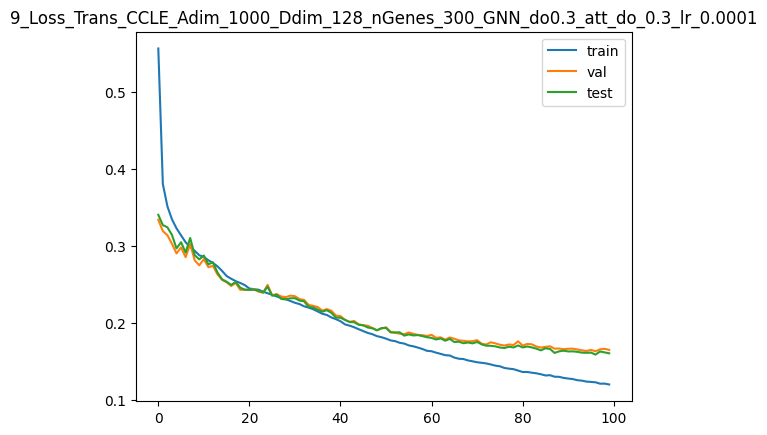

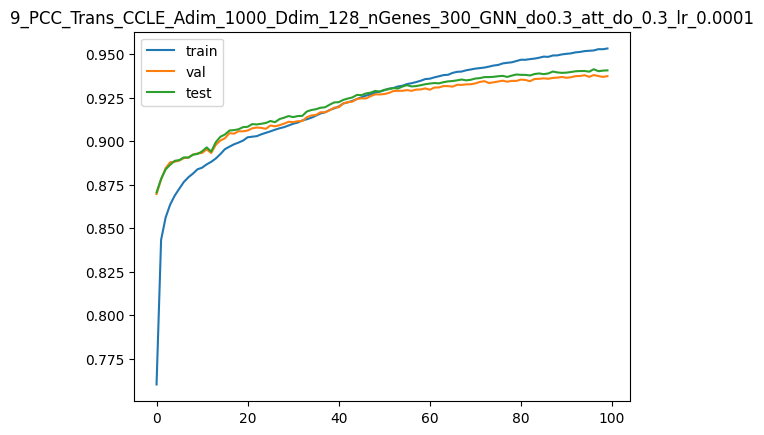

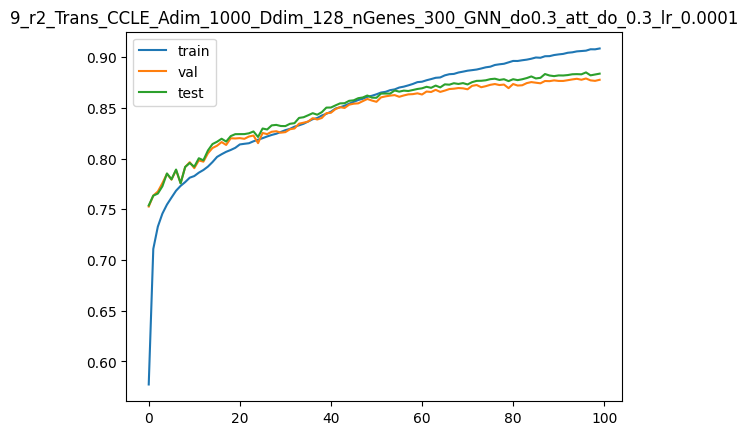

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12007559
Train avg_pcc:  0.9532719486799057
Train r2:  0.9087244377704168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16427417
Validation avg_pcc:  0.9376831740899141
Validation r2:  0.8783309874553489


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16145131
Test avg_pcc:  0.9403938505723787
Test r2:  0.8832159776650118
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.119296804
Train avg_pcc:  0.9535818657458789
Train r2:  0.9093164296099653


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16627818
Validation avg_pcc:  0.9377838966598668
Validation r2:  0.8768467247518671


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1620695
Test avg_pcc:  0.9411791769892441
Test r2:  0.8827688201630716
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.118818395
Train avg_pcc:  0.9537736577056208
Train r2:  0.9096800855483916


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16162929
Validation avg_pcc:  0.9385101267085622
Validation r2:  0.8802899031390835
Best Val r2  0.8802899031390835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1585773
Test avg_pcc:  0.9413329096064555
Test r2:  0.885294869112682
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11740913
Train avg_pcc:  0.9543342459856513
Train r2:  0.9107513409477392


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16424534
Validation avg_pcc:  0.9378262079175341
Validation r2:  0.8783523384853704


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16083442
Test avg_pcc:  0.940831539526766
Test r2:  0.8836621963183012
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11695149
Train avg_pcc:  0.9545166539833465
Train r2:  0.9110992166371646


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16488448
Validation avg_pcc:  0.9375568124202274
Validation r2:  0.8778789614635513


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16055663
Test avg_pcc:  0.9409254572821589
Test r2:  0.8838631366177407
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11648356
Train avg_pcc:  0.9547025592868189
Train r2:  0.9114549179817883


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16586316
Validation avg_pcc:  0.937868330539211
Validation r2:  0.8771541287239066


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16047059
Test avg_pcc:  0.9415804738073464
Test r2:  0.8839253714686375
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.115700416
Train avg_pcc:  0.9550141024582988
Train r2:  0.9120502225120618


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16563894
Validation avg_pcc:  0.9377501867891034
Validation r2:  0.877320181136758


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16042604
Test avg_pcc:  0.941394773472427
Test r2:  0.8839576092873106
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11477303
Train avg_pcc:  0.9553832732899554
Train r2:  0.9127551751407631


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16199109
Validation avg_pcc:  0.9386920453283056
Validation r2:  0.8800219414163531


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15873599
Test avg_pcc:  0.9416390188803937
Test r2:  0.8851800784838789
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11385995
Train avg_pcc:  0.9557468556163758
Train r2:  0.913449257796484


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16377455
Validation avg_pcc:  0.9381381238512424
Validation r2:  0.8787010358326904


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1588642
Test avg_pcc:  0.9416366273231059
Test r2:  0.8850873342232228
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.112932414
Train avg_pcc:  0.9561157611405062
Train r2:  0.9141543260313972


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16209999
Validation avg_pcc:  0.9385343508193428
Validation r2:  0.879941289919616


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15861303
Test avg_pcc:  0.9414588193269003
Test r2:  0.8852690194452928
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1132803
Train avg_pcc:  0.9559772466941507
Train r2:  0.9138898779827749


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15991014
Validation avg_pcc:  0.9391507389230904
Validation r2:  0.8815631941281092
Best Val r2  0.8815631941281092


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1572727
Test avg_pcc:  0.94175115781917
Test r2:  0.8862385326485576
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11233056
Train avg_pcc:  0.9563549834995916
Train r2:  0.9146118145130964


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16033189
Validation avg_pcc:  0.9390109671851306
Validation r2:  0.8812508315565013


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15705709
Test avg_pcc:  0.9419199361557636
Test r2:  0.8863944896768537
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.111777104
Train avg_pcc:  0.9565746846355165
Train r2:  0.9150325335075751


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16408716
Validation avg_pcc:  0.9389525055701392
Validation r2:  0.8784694983570521


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16115503
Test avg_pcc:  0.9417698428896205
Test r2:  0.8834302861288561
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11095017
Train avg_pcc:  0.9569029215894984
Train r2:  0.9156611322578179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16196215
Validation avg_pcc:  0.938844811538542
Validation r2:  0.8800433727812941


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.157859
Test avg_pcc:  0.9420361047007931
Test r2:  0.8858144484974297
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11076075
Train avg_pcc:  0.9569779987381575
Train r2:  0.9158051164026378


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16009212
Validation avg_pcc:  0.9394947293478206
Validation r2:  0.8814284130034469


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15675625
Test avg_pcc:  0.9423694079428014
Test r2:  0.8866120947822254
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.110396706
Train avg_pcc:  0.9571236714968582
Train r2:  0.916081845332557


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16196531
Validation avg_pcc:  0.9384803405754896
Validation r2:  0.8800410513137606


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15758187
Test avg_pcc:  0.9417381971265856
Test r2:  0.886014899085084
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10900505
Train avg_pcc:  0.957675858392991
Train r2:  0.9171397144676605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15916668
Validation avg_pcc:  0.9393946561250632
Validation r2:  0.88211383069208
Best Val r2  0.88211383069208


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1551166
Test avg_pcc:  0.9425489194995003
Test r2:  0.8877981305757312
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10895291
Train avg_pcc:  0.9576962926742423
Train r2:  0.9171793516878035


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16180187
Validation avg_pcc:  0.9392066635467933
Validation r2:  0.88016208413613


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15886956
Test avg_pcc:  0.942127980467808
Test r2:  0.8850834449442827
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.108344
Train avg_pcc:  0.9579377991400598
Train r2:  0.9176422169725637


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16216873
Validation avg_pcc:  0.9386484021597271
Validation r2:  0.8798903851737605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1577371
Test avg_pcc:  0.9419972497718472
Test r2:  0.8859026090670883
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1079239
Train avg_pcc:  0.9581041310795247
Train r2:  0.9179615426516301


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15955003
Validation avg_pcc:  0.9395779377390358
Validation r2:  0.8818299035114807


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15642992
Test avg_pcc:  0.9424372371758339
Test r2:  0.8868481550169003
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10781128
Train avg_pcc:  0.9581489676770684
Train r2:  0.9180471545039836


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15937646
Validation avg_pcc:  0.9396647493017442
Validation r2:  0.8819584556482288


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15618782
Test avg_pcc:  0.9424971177168702
Test r2:  0.8870232742276045
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10735943
Train avg_pcc:  0.9583285965765301
Train r2:  0.9183906252208137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16189152
Validation avg_pcc:  0.9381526242044356
Validation r2:  0.8800957002394808


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15631083
Test avg_pcc:  0.9418297302281354
Test r2:  0.886934290455134
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10688073
Train avg_pcc:  0.958517885448294
Train r2:  0.9187545150284129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15892231
Validation avg_pcc:  0.939738887184443
Validation r2:  0.8822948233048089
Best Val r2  0.8822948233048089


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1537608
Test avg_pcc:  0.9431853267116888
Test r2:  0.8887788322328571
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10600057
Train avg_pcc:  0.9588675799428316
Train r2:  0.9194235664450411


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16013385
Validation avg_pcc:  0.9390754295282991
Validation r2:  0.8813974913959235


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.155156
Test avg_pcc:  0.9425968894015635
Test r2:  0.887769625576137
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.104597546
Train avg_pcc:  0.9594228087867324
Train r2:  0.9204900811576202


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16841884
Validation avg_pcc:  0.9387752447439944
Validation r2:  0.8752612558892763


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16297455
Test avg_pcc:  0.9426124199199696
Test r2:  0.882114160873684
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10394274
Train avg_pcc:  0.9596822392346571
Train r2:  0.9209878273868115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15943088
Validation avg_pcc:  0.939410604408932
Validation r2:  0.8819181534557681


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15614524
Test avg_pcc:  0.9422785289348582
Test r2:  0.8870540573744988
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.104288355
Train avg_pcc:  0.95954528423864
Train r2:  0.9207251141228443


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15831055
Validation avg_pcc:  0.9395742547349735
Validation r2:  0.8827479257137356
Best Val r2  0.8827479257137356


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1537464
Test avg_pcc:  0.9428290150301577
Test r2:  0.8887892453674173
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10303304
Train avg_pcc:  0.960042634996172
Train r2:  0.9216793474306865


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16036652
Validation avg_pcc:  0.9397171085972683
Validation r2:  0.8812251783272376


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15621811
Test avg_pcc:  0.9429963282938071
Test r2:  0.8870013596464001
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10300733
Train avg_pcc:  0.960052614822405
Train r2:  0.9216988802746338


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15817383
Validation avg_pcc:  0.939788759341745
Validation r2:  0.8828491837786094
Best Val r2  0.8828491837786094


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15453306
Test avg_pcc:  0.9427520590742394
Test r2:  0.8882202216298493
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10274996
Train avg_pcc:  0.960154684835975
Train r2:  0.9218945251658502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.158941
Validation avg_pcc:  0.9394829487765513
Validation r2:  0.8822809824345921


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1546376
Test avg_pcc:  0.9426970009921615
Test r2:  0.8881445958586404
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.102148496
Train avg_pcc:  0.9603926665700251
Train r2:  0.9223517263192411


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16115813
Validation avg_pcc:  0.939706130398178
Validation r2:  0.88063888053307


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15623158
Test avg_pcc:  0.9432008993085671
Test r2:  0.8869916099635615
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.101301216
Train avg_pcc:  0.9607280795897841
Train r2:  0.9229957839957357


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16329625
Validation avg_pcc:  0.9396396045830965
Validation r2:  0.8790552768707537


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15844259
Test avg_pcc:  0.9431479953612333
Test r2:  0.8853923088400293
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1013649
Train avg_pcc:  0.960702844695632
Train r2:  0.9229473821172436


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15822063
Validation avg_pcc:  0.9395841092329471
Validation r2:  0.8828145199829275


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15267447
Test avg_pcc:  0.943172540209853
Test r2:  0.8895646143782834
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.101029605
Train avg_pcc:  0.9608354341876599
Train r2:  0.9232022601365857


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15721062
Validation avg_pcc:  0.9401800447697919
Validation r2:  0.8835625765103046
Best Val r2  0.8835625765103046


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15350409
Test avg_pcc:  0.9431519024202676
Test r2:  0.8889645040062217
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0998477
Train avg_pcc:  0.9613025155960921
Train r2:  0.9241006855218065


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1605125
Validation avg_pcc:  0.9401364629337928
Validation r2:  0.8811170604545908


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1558252
Test avg_pcc:  0.943552534943824
Test r2:  0.8872855566437579
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1002056
Train avg_pcc:  0.9611615034129757
Train r2:  0.9238286295119899


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15781574
Validation avg_pcc:  0.9398534878054381
Validation r2:  0.8831144044714248


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15150791
Test avg_pcc:  0.9437908012848729
Test r2:  0.8904084229950407
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.098956324
Train avg_pcc:  0.9616550653570882
Train r2:  0.9247782626247977


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15970954
Validation avg_pcc:  0.9390980699946558
Validation r2:  0.8817117704144439


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15312643
Test avg_pcc:  0.9431647486180414
Test r2:  0.8892376915894857
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09968343
Train avg_pcc:  0.9613678922714803
Train r2:  0.9242255454200774


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16308576
Validation avg_pcc:  0.9398858872314994
Validation r2:  0.8792111792835846


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15766437
Test avg_pcc:  0.9435667277326482
Test r2:  0.885955217678087
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09856515
Train avg_pcc:  0.9618096091644411
Train r2:  0.9250756135230056


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16036695
Validation avg_pcc:  0.9400611905032664
Validation r2:  0.8812248564958143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15677716
Test avg_pcc:  0.9430675665643589
Test r2:  0.886596968762115
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09906339
Train avg_pcc:  0.961613193389005
Train r2:  0.92469687889751


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15815246
Validation avg_pcc:  0.9397726815874955
Validation r2:  0.8828650020329596


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15333873
Test avg_pcc:  0.9431441565737184
Test r2:  0.8890841257340161
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.097730204
Train avg_pcc:  0.962139759474241
Train r2:  0.925710295052868


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15809512
Validation avg_pcc:  0.9398519161748544
Validation r2:  0.8829074812975276


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15297253
Test avg_pcc:  0.9433490156190895
Test r2:  0.8893490125303737
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09695859
Train avg_pcc:  0.9624443101330489
Train r2:  0.9262968393288882


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15666628
Validation avg_pcc:  0.9405015724591038
Validation r2:  0.8839657453476557
Best Val r2  0.8839657453476557


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15221788
Test avg_pcc:  0.9437907128235444
Test r2:  0.8898948863819756
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09686241
Train avg_pcc:  0.962482369091234
Train r2:  0.9263699455929857


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15935487
Validation avg_pcc:  0.9396678467819028
Validation r2:  0.881974451168486


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1555146
Test avg_pcc:  0.9427315365982496
Test r2:  0.8875102235952252
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09714227
Train avg_pcc:  0.9623719398902951
Train r2:  0.926157215737799


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15739906
Validation avg_pcc:  0.9400079495613768
Validation r2:  0.8834230153658648


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15050195
Test avg_pcc:  0.9441599015265327
Test r2:  0.8911360798007802
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09593003
Train avg_pcc:  0.962850508312305
Train r2:  0.9270787020380362


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15852962
Validation avg_pcc:  0.9401754432579255
Validation r2:  0.8825856637965966


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15345488
Test avg_pcc:  0.9437663239433964
Test r2:  0.8890001046625826
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09465368
Train avg_pcc:  0.9633539633702048
Train r2:  0.9280489178901341


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15801524
Validation avg_pcc:  0.9402189006076296
Validation r2:  0.8829666510712952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15368974
Test avg_pcc:  0.9434038669269142
Test r2:  0.8888302120699542
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.095261306
Train avg_pcc:  0.9631142325120625
Train r2:  0.9275870348211187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15758184
Validation avg_pcc:  0.9401200469195695
Validation r2:  0.8832876363313831


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15240648
Test avg_pcc:  0.9436377041420511
Test r2:  0.8897584618786865
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09517641
Train avg_pcc:  0.9631476294426105
Train r2:  0.9276515662063037


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15647958
Validation avg_pcc:  0.9403386022971757
Validation r2:  0.8841040288183293
Best Val r2  0.8841040288183293


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15097494
Test avg_pcc:  0.943929816826152
Test r2:  0.8907939483272733
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09437731
Train avg_pcc:  0.9634630352164275
Train r2:  0.92825899892184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15812787
Validation avg_pcc:  0.9396760719225112
Validation r2:  0.8828832242880832


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15206641
Test avg_pcc:  0.9435236196618201
Test r2:  0.8900044407034353
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09402898
Train avg_pcc:  0.9636006639035822
Train r2:  0.9285237836010511


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1610768
Validation avg_pcc:  0.9400848094509617
Validation r2:  0.8806991136975326


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15687247
Test avg_pcc:  0.9432911525102345
Test r2:  0.8865280306646852


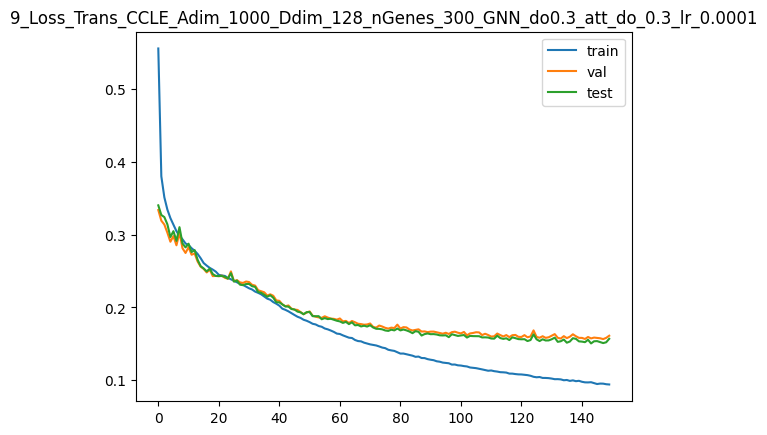

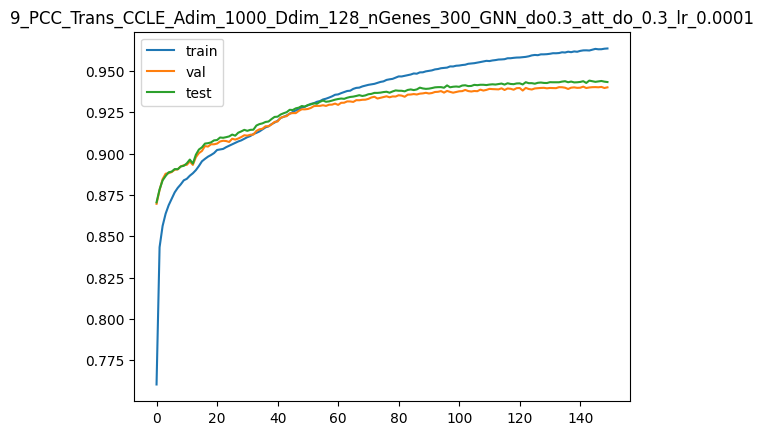

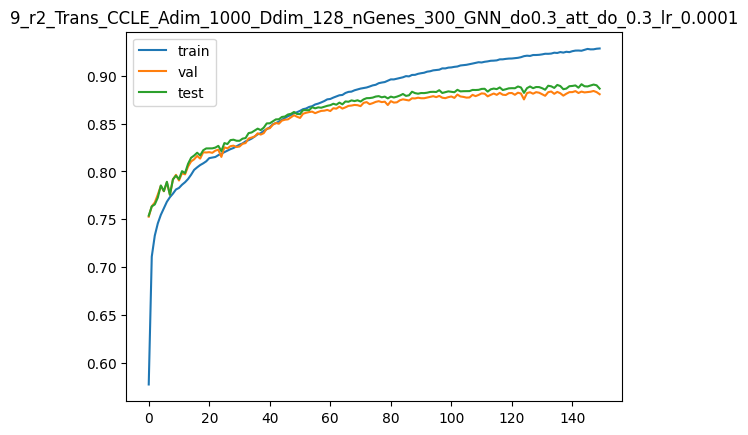

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15097494
Test avg_pcc:  0.9439298166816154
Test r2:  0.890793948092028


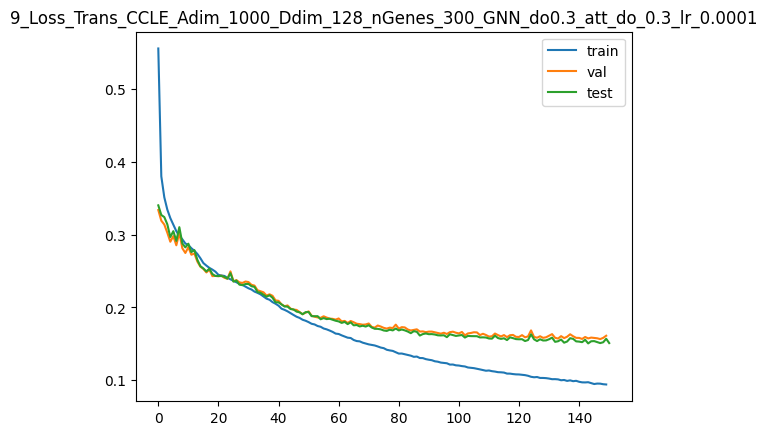

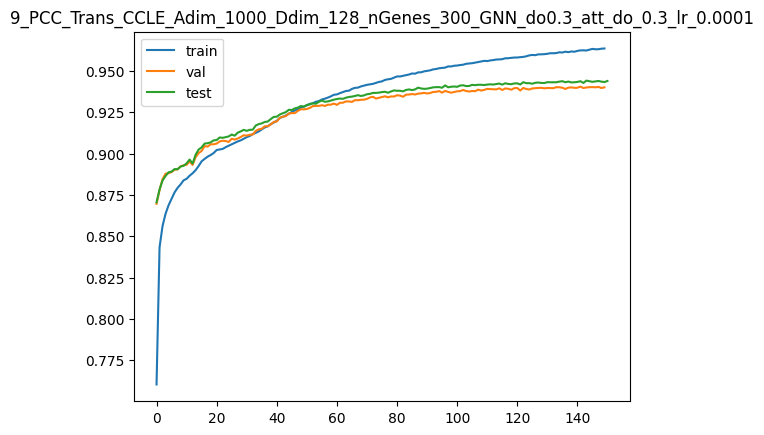

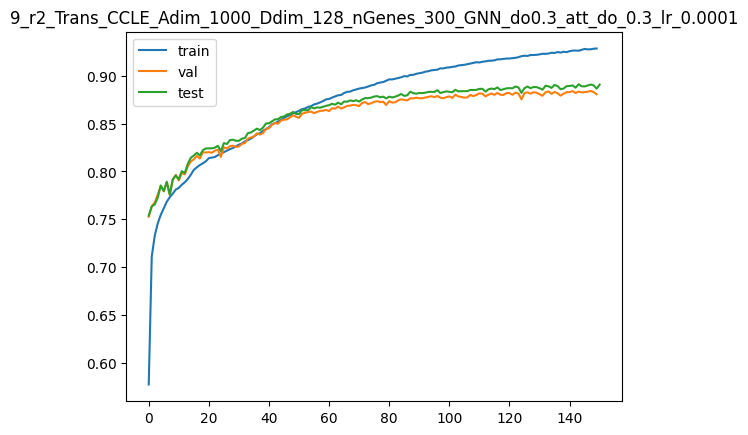

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.5541546
Train avg_pcc:  0.764136153776435
Train r2:  0.583038401372155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.38054454
Validation avg_pcc:  0.8718875184302713
Validation r2:  0.7081182368967078
Best Val r2  0.7081182368967078


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.38978294
Test avg_pcc:  0.8699719106673816
Test r2:  0.705060548430336
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3886972
Train avg_pcc:  0.8413454157693167
Train r2:  0.7075332188585712


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30988288
Validation avg_pcc:  0.8807970659173576
Validation r2:  0.7623164990838636
Best Val r2  0.7623164990838636


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31381446
Test avg_pcc:  0.8803476126505014
Test r2:  0.7625440563482846
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.35454616
Train avg_pcc:  0.8564097998654273
Train r2:  0.7332294542975015


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3113101
Validation avg_pcc:  0.884230131634189
Validation r2:  0.7612217939626984


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31152993
Test avg_pcc:  0.8849322835105884
Test r2:  0.7642727029280905
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.33887577
Train avg_pcc:  0.8632339717077786
Train r2:  0.7450203018839155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2944091
Validation avg_pcc:  0.886994603711323
Validation r2:  0.7741850601610905
Best Val r2  0.7741850601610905


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2987572
Test avg_pcc:  0.8872955425284397
Test r2:  0.7739375437366536
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3261534
Train avg_pcc:  0.868724038786428
Train r2:  0.7545929611222167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2775121
Validation avg_pcc:  0.8874317449987749
Validation r2:  0.7871452432654493
Best Val r2  0.7871452432654493


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28060544
Test avg_pcc:  0.8876350554419598
Test r2:  0.7876725175268898
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.31716618
Train avg_pcc:  0.8725921629587857
Train r2:  0.7613552083676429


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29888105
Validation avg_pcc:  0.8894319277949987
Validation r2:  0.7707550203025135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30235243
Test avg_pcc:  0.8888239830269302
Test r2:  0.7712171340343176
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.3085638
Train avg_pcc:  0.8762844621146397
Train r2:  0.7678278779313461


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26525545
Validation avg_pcc:  0.8925626325345418
Validation r2:  0.7965462263790701
Best Val r2  0.7965462263790701


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2700247
Test avg_pcc:  0.892036514057071
Test r2:  0.7956787469022847
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.303019
Train avg_pcc:  0.8786498534332252
Train r2:  0.7719999276531173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27069572
Validation avg_pcc:  0.8918950751813934
Validation r2:  0.7923734754281315


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27231836
Test avg_pcc:  0.8923389862699961
Test r2:  0.7939431830451098
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29654834
Train avg_pcc:  0.8814112039701818
Train r2:  0.7768686462905783


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27764902
Validation avg_pcc:  0.8930474112164329
Validation r2:  0.7870402203683952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2765585
Test avg_pcc:  0.8943268926632176
Test r2:  0.7907347542305222
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.29307365
Train avg_pcc:  0.8828955623852776
Train r2:  0.7794831031540088


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26757923
Validation avg_pcc:  0.8934925438806882
Validation r2:  0.7947638776491585


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2683609
Test avg_pcc:  0.8945910330685115
Test r2:  0.7969376945547383
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.28883365
Train avg_pcc:  0.884696435444823
Train r2:  0.7826734234784252


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2711287
Validation avg_pcc:  0.8935135175566984
Validation r2:  0.7920413720873408


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27236748
Test avg_pcc:  0.8938673529486604
Test r2:  0.7939059920611183
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.28538182
Train avg_pcc:  0.8861609476278146
Train r2:  0.7852706479573317


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25865823
Validation avg_pcc:  0.8961444090041766
Validation r2:  0.8016063451894293
Best Val r2  0.8016063451894293


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26418382
Test avg_pcc:  0.8956036759104572
Test r2:  0.8000983850627283
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2798316
Train avg_pcc:  0.8885135926312836
Train r2:  0.7894468103845113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25491026
Validation avg_pcc:  0.8981300337816026
Validation r2:  0.8044811012376271
Best Val r2  0.8044811012376271


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25812465
Test avg_pcc:  0.8980642700551005
Test r2:  0.8046832250786029
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2737594
Train avg_pcc:  0.8910803250673054
Train r2:  0.7940156796016309


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25779307
Validation avg_pcc:  0.8995927699953846
Validation r2:  0.8022699517091302


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25764528
Test avg_pcc:  0.9003101899242549
Test r2:  0.8050459400930382
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26793677
Train avg_pcc:  0.8935354943119581
Train r2:  0.7983968032986869


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24542269
Validation avg_pcc:  0.9025146521293268
Validation r2:  0.8117581509109768
Best Val r2  0.8117581509109768


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24634187
Test avg_pcc:  0.9031081436022375
Test r2:  0.8135989542112197
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.26421645
Train avg_pcc:  0.8951018941170945
Train r2:  0.8011960895954608


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24604455
Validation avg_pcc:  0.9044410738049483
Validation r2:  0.8112811880684225


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25140622
Test avg_pcc:  0.9040326559354271
Test r2:  0.8097668786925076
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25974932
Train avg_pcc:  0.8969750212995085
Train r2:  0.8045572694499623


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24147505
Validation avg_pcc:  0.9027757129045733
Validation r2:  0.8147860438682266
Best Val r2  0.8147860438682266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24557756
Test avg_pcc:  0.9023656112516486
Test r2:  0.8141773023199737
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25643125
Train avg_pcc:  0.8983674825829707
Train r2:  0.8070539033859456


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23693922
Validation avg_pcc:  0.9052599717715664
Validation r2:  0.8182650574792362
Best Val r2  0.8182650574792362


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24233778
Test avg_pcc:  0.9045289279366142
Test r2:  0.8166287571185181
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2537659
Train avg_pcc:  0.8994812547371696
Train r2:  0.8090593708438433


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23396829
Validation avg_pcc:  0.9070668287436685
Validation r2:  0.8205437968827282
Best Val r2  0.8205437968827282


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24140522
Test avg_pcc:  0.9054756850751289
Test r2:  0.817334415794526
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.25097278
Train avg_pcc:  0.9006492078565863
Train r2:  0.8111610178787084


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2391189
Validation avg_pcc:  0.9064408587164768
Validation r2:  0.81659322535482


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24189556
Test avg_pcc:  0.9060912828858793
Test r2:  0.8169633805356935
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24725917
Train avg_pcc:  0.9021996524359885
Train r2:  0.8139552298187867


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23166125
Validation avg_pcc:  0.9068349142433246
Validation r2:  0.822313336237763
Best Val r2  0.822313336237763


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23783776
Test avg_pcc:  0.905557615039267
Test r2:  0.8200338369138294
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24597478
Train avg_pcc:  0.9027343495529387
Train r2:  0.8149216242889441


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23344064
Validation avg_pcc:  0.9073892918294082
Validation r2:  0.8209485267781225


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23861837
Test avg_pcc:  0.9063932567852161
Test r2:  0.8194431378664367
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24364
Train avg_pcc:  0.9037063755500795
Train r2:  0.8166783781299952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22967155
Validation avg_pcc:  0.9090691962405572
Validation r2:  0.823839441470278
Best Val r2  0.823839441470278


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2347778
Test avg_pcc:  0.9078747386700509
Test r2:  0.8223492287137637
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.24209303
Train avg_pcc:  0.9043489789643051
Train r2:  0.817842364775622


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23010223
Validation avg_pcc:  0.9080364562938976
Validation r2:  0.8235091221055404


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2352056
Test avg_pcc:  0.90707864197648
Test r2:  0.8220255070226474
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23874965
Train avg_pcc:  0.9057397102138375
Train r2:  0.8203580249794165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.228967
Validation avg_pcc:  0.9094967079746051
Validation r2:  0.8243798618636279
Best Val r2  0.8243798618636279


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23309147
Test avg_pcc:  0.908839346477238
Test r2:  0.8236252261427813
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23696685
Train avg_pcc:  0.9064803480526367
Train r2:  0.8216994440083758


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2248799
Validation avg_pcc:  0.9097455863892125
Validation r2:  0.8275146969865739
Best Val r2  0.8275146969865739


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.228901
Test avg_pcc:  0.9094619624522939
Test r2:  0.826796065459178
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23541433
Train avg_pcc:  0.9071230012737351
Train r2:  0.8228676168301388


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22539203
Validation avg_pcc:  0.910293619718952
Validation r2:  0.8271218966717722


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22795382
Test avg_pcc:  0.9101396216742444
Test r2:  0.827512772995015
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.23298793
Train avg_pcc:  0.9081303412363592
Train r2:  0.8246933142842658


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22230677
Validation avg_pcc:  0.9116025138847841
Validation r2:  0.8294883142730756
Best Val r2  0.8294883142730756


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22733052
Test avg_pcc:  0.9107951110923562
Test r2:  0.8279844040081081
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22995053
Train avg_pcc:  0.9093861398417095
Train r2:  0.8269787275186312


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22195768
Validation avg_pcc:  0.9111427914075985
Validation r2:  0.8297560872880649
Best Val r2  0.8297560872880649


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22736119
Test avg_pcc:  0.9100355449908627
Test r2:  0.8279611972193797
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22848262
Train avg_pcc:  0.9099947846047368
Train r2:  0.8280832246108253


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2232111
Validation avg_pcc:  0.9106738895685866
Validation r2:  0.8287946801304864


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22549586
Test avg_pcc:  0.9111193717486687
Test r2:  0.8293726522630224
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.2257179
Train avg_pcc:  0.9111362741144455
Train r2:  0.8301634751564884


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21888186
Validation avg_pcc:  0.9127017032513433
Validation r2:  0.8321152489847342
Best Val r2  0.8321152489847342


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2222607
Test avg_pcc:  0.9126667727429708
Test r2:  0.8318206222048858
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22434975
Train avg_pcc:  0.9117003468607269
Train r2:  0.8311929180025746


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21461411
Validation avg_pcc:  0.9144409569739864
Validation r2:  0.8353886638300829
Best Val r2  0.8353886638300829


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22009549
Test avg_pcc:  0.9135273232581357
Test r2:  0.8334589807788867
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.22020338
Train avg_pcc:  0.9134097372164547
Train r2:  0.8343127477955694


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21502642
Validation avg_pcc:  0.9139549010856759
Validation r2:  0.8350724256942246


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22001097
Test avg_pcc:  0.9131720741651946
Test r2:  0.8335229368593953
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21840812
Train avg_pcc:  0.9141492492272698
Train r2:  0.8356635707203018


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21221475
Validation avg_pcc:  0.9150508684065937
Validation r2:  0.837229000510505
Best Val r2  0.837229000510505


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21752125
Test avg_pcc:  0.9140594169764433
Test r2:  0.8354068454640531
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21512619
Train avg_pcc:  0.9154989594153892
Train r2:  0.8381330030399027


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21161665
Validation avg_pcc:  0.9160257728776005
Validation r2:  0.8376877454968372
Best Val r2  0.8376877454968372


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21763453
Test avg_pcc:  0.9145293952135022
Test r2:  0.835321129366619
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21288843
Train avg_pcc:  0.9164180589931428
Train r2:  0.8398167462032261


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20865774
Validation avg_pcc:  0.9165495174767617
Validation r2:  0.8399572682060714
Best Val r2  0.8399572682060714


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21163471
Test avg_pcc:  0.9164476890062135
Test r2:  0.8398610402842654
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.21010622
Train avg_pcc:  0.9175594079118048
Train r2:  0.8419101425299153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20923796
Validation avg_pcc:  0.9180123379800152
Validation r2:  0.8395122380017231


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21453942
Test avg_pcc:  0.9167513020535031
Test r2:  0.8376631227345617
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20835142
Train avg_pcc:  0.9182787208574266
Train r2:  0.8432305077456393


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2073238
Validation avg_pcc:  0.9185033034178345
Validation r2:  0.8409804008212305
Best Val r2  0.8409804008212305


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20976482
Test avg_pcc:  0.9185176284638871
Test r2:  0.8412759446153137
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20491178
Train avg_pcc:  0.9196863652728993
Train r2:  0.8458185946943982


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20762695
Validation avg_pcc:  0.9169557326042609
Validation r2:  0.8407479046124624


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20991871
Test avg_pcc:  0.9172261922409348
Test r2:  0.8411595027842713
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.20270228
Train avg_pcc:  0.9205903010871878
Train r2:  0.8474810743258993


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20448717
Validation avg_pcc:  0.9190360970254224
Validation r2:  0.8431561388001241
Best Val r2  0.8431561388001241


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20707236
Test avg_pcc:  0.9192166245448171
Test r2:  0.8433132586715075
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1996138
Train avg_pcc:  0.9218506847110839
Train r2:  0.8498049236276332


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19942057
Validation avg_pcc:  0.9205781141782547
Validation r2:  0.847042271686232
Best Val r2  0.847042271686232


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20244226
Test avg_pcc:  0.9203380213501923
Test r2:  0.8468167410480385
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1978225
Train avg_pcc:  0.9225820288373442
Train r2:  0.8511527794551813


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19959508
Validation avg_pcc:  0.920589845029356
Validation r2:  0.8469084243876447


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20200776
Test avg_pcc:  0.9206366223845628
Test r2:  0.8471455355936142
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19467513
Train avg_pcc:  0.9238641213805402
Train r2:  0.8535209340549881


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1959728
Validation avg_pcc:  0.9219751671370985
Validation r2:  0.849686760619015
Best Val r2  0.849686760619015


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1979453
Test avg_pcc:  0.9221215531741008
Test r2:  0.8502194971296279
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.19160095
Train avg_pcc:  0.9251153049161179
Train r2:  0.8558340398309142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19317211
Validation avg_pcc:  0.9231069319526136
Validation r2:  0.8518349136919822
Best Val r2  0.8518349136919822


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19686316
Test avg_pcc:  0.92285094628565
Test r2:  0.8510383277141826
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18979561
Train avg_pcc:  0.9258482750674699
Train r2:  0.8571924188966726


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1971066
Validation avg_pcc:  0.9230909897310126
Validation r2:  0.8488171364253326


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19966479
Test avg_pcc:  0.9226497118452445
Test r2:  0.8489184021801205
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18736365
Train avg_pcc:  0.9268371191324963
Train r2:  0.8590222836973673


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19242227
Validation avg_pcc:  0.9239674112996238
Validation r2:  0.8524100459154199
Best Val r2  0.8524100459154199


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19666345
Test avg_pcc:  0.9230929601007897
Test r2:  0.8511894474641344
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1859797
Train avg_pcc:  0.9273981332999005
Train r2:  0.8600636271514399


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18990685
Validation avg_pcc:  0.9244563061582929
Validation r2:  0.8543393939842872
Best Val r2  0.8543393939842872


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19366835
Test avg_pcc:  0.9240183246801079
Test r2:  0.8534557631104518
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.18293257
Train avg_pcc:  0.9286335277458279
Train r2:  0.8623563706658188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18730699
Validation avg_pcc:  0.9254046038202961
Validation r2:  0.856333521961091
Best Val r2  0.856333521961091


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19024883
Test avg_pcc:  0.925352920331069
Test r2:  0.8560432374491971
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1818801
Train avg_pcc:  0.9290602524101321
Train r2:  0.8631482702127662


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18762647
Validation avg_pcc:  0.9253384054917404
Validation r2:  0.8560884900381835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1888642
Test avg_pcc:  0.9259647069335607
Test r2:  0.8570909379590925
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1798927
Train avg_pcc:  0.9298637546257509
Train r2:  0.8646436458194043


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18515596
Validation avg_pcc:  0.9263612376947319
Validation r2:  0.8579833981266473
Best Val r2  0.8579833981266473


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18756258
Test avg_pcc:  0.9263637553936744
Test r2:  0.858075864281566


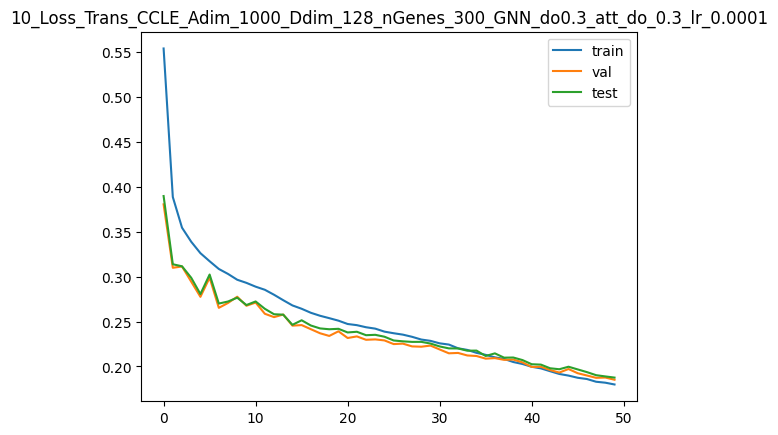

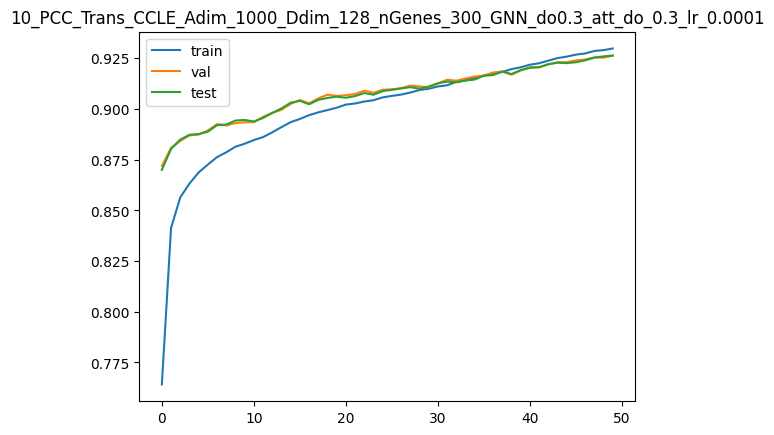

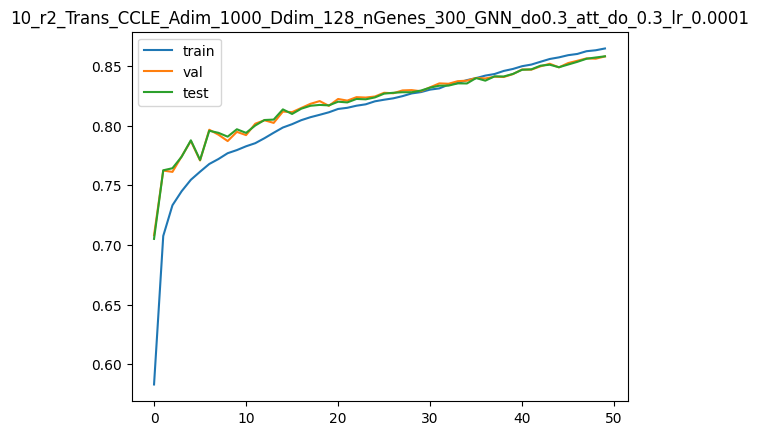

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17868629
Train avg_pcc:  0.9303525488142108
Train r2:  0.8655513855703417


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18714516
Validation avg_pcc:  0.9258239476759637
Validation r2:  0.8564576467285587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18572952
Test avg_pcc:  0.9271891875345344
Test r2:  0.8594628993833686
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1762097
Train avg_pcc:  0.9313532247223012
Train r2:  0.8674148372318171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18631653
Validation avg_pcc:  0.9260502737674907
Validation r2:  0.8570932180104858


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18499452
Test avg_pcc:  0.9274790265593342
Test r2:  0.8600190375227751
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17492542
Train avg_pcc:  0.9318723258115768
Train r2:  0.8683811819643745


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18829991
Validation avg_pcc:  0.9260075409891421
Validation r2:  0.8555719533796805


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18690918
Test avg_pcc:  0.9273262941741736
Test r2:  0.8585702639001165
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17333731
Train avg_pcc:  0.9325126742913852
Train r2:  0.8695761115293342


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18392737
Validation avg_pcc:  0.9272633154628585
Validation r2:  0.8589257145390968
Best Val r2  0.8589257145390968


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18381497
Test avg_pcc:  0.9282249904395401
Test r2:  0.8609115680086206
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.17100337
Train avg_pcc:  0.9334542855967407
Train r2:  0.8713322304688212


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18499841
Validation avg_pcc:  0.9268853122480957
Validation r2:  0.8581042367185605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18444674
Test avg_pcc:  0.9279933512714629
Test r2:  0.8604335475593858
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16938719
Train avg_pcc:  0.9341058704944393
Train r2:  0.8725482978973792


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18372606
Validation avg_pcc:  0.9281777132229273
Validation r2:  0.8590801445334468
Best Val r2  0.8590801445334468


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1856545
Test avg_pcc:  0.9289288517869625
Test r2:  0.859519654070318
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16798446
Train avg_pcc:  0.9346691712585086
Train r2:  0.8736037480480924


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17983598
Validation avg_pcc:  0.9289461019089559
Validation r2:  0.8620638760966537
Best Val r2  0.8620638760966537


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17895724
Test avg_pcc:  0.9300527779462452
Test r2:  0.8645873222703239
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16664346
Train avg_pcc:  0.935209092434393
Train r2:  0.8746127690501102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17827776
Validation avg_pcc:  0.9297883735357615
Validation r2:  0.8632590343175899
Best Val r2  0.8632590343175899


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1789433
Test avg_pcc:  0.9303596367409963
Test r2:  0.8645978596238192
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16543964
Train avg_pcc:  0.935694053395646
Train r2:  0.8755185412560678


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17844795
Validation avg_pcc:  0.9292157399068227
Validation r2:  0.8631285130553943


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17830384
Test avg_pcc:  0.930213856089328
Test r2:  0.8650817303253915
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16232358
Train avg_pcc:  0.9369450829247228
Train r2:  0.8778631413544818


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17648013
Validation avg_pcc:  0.9302800744132073
Validation r2:  0.864637852093791
Best Val r2  0.864637852093791


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17743269
Test avg_pcc:  0.930745365549204
Test r2:  0.8657409087231708
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.16058312
Train avg_pcc:  0.9376444531211284
Train r2:  0.8791727335076801


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17717041
Validation avg_pcc:  0.9299911373709049
Validation r2:  0.8641083898797763


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17816657
Test avg_pcc:  0.9308632532976038
Test r2:  0.8651856095919249
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15978315
Train avg_pcc:  0.9379646686879506
Train r2:  0.8797746285938391


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18146543
Validation avg_pcc:  0.9300057621463756
Validation r2:  0.8608140681592322


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18170772
Test avg_pcc:  0.930935717778958
Test r2:  0.8625060919775873
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15806012
Train avg_pcc:  0.9386558269526243
Train r2:  0.8810710994463808


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17519115
Validation avg_pcc:  0.9304101453064698
Validation r2:  0.8656265100894693
Best Val r2  0.8656265100894693


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1744256
Test avg_pcc:  0.9316941460748436
Test r2:  0.8680162932381422
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15685265
Train avg_pcc:  0.9391388576492243
Train r2:  0.8819796393218495


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17340434
Validation avg_pcc:  0.9314981535346007
Validation r2:  0.8669970074696871
Best Val r2  0.8669970074696871


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17497773
Test avg_pcc:  0.9316759540692054
Test r2:  0.8675985094761853
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1560318
Train avg_pcc:  0.9394694069977014
Train r2:  0.8825972513008148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17551775
Validation avg_pcc:  0.9305643055696025
Validation r2:  0.8653759854118722


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17694545
Test avg_pcc:  0.9311855299984635
Test r2:  0.8661095894584132
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15506977
Train avg_pcc:  0.93985303593755
Train r2:  0.8833211205777636


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17439808
Validation avg_pcc:  0.9312613440127623
Validation r2:  0.8662347950545259


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1754408
Test avg_pcc:  0.9319393102084507
Test r2:  0.8672481083428277
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1522105
Train avg_pcc:  0.9409967609845059
Train r2:  0.8854724972171526


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17539044
Validation avg_pcc:  0.931917952554436
Validation r2:  0.8654736553882826


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17637873
Test avg_pcc:  0.9324336819730146
Test r2:  0.8665384178492895
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15128438
Train avg_pcc:  0.9413671609150069
Train r2:  0.8861693569993978


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17530268
Validation avg_pcc:  0.9327492851835876
Validation r2:  0.8655409452990377


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17681734
Test avg_pcc:  0.9326686414663918
Test r2:  0.8662065182700719
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.15045345
Train avg_pcc:  0.9417000321582735
Train r2:  0.8867945782960426


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17096573
Validation avg_pcc:  0.9327399867159489
Validation r2:  0.8688674472263205
Best Val r2  0.8688674472263205


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17094873
Test avg_pcc:  0.9336091120444889
Test r2:  0.87064716371637
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14955145
Train avg_pcc:  0.9420600963497336
Train r2:  0.8874732688242793


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17072566
Validation avg_pcc:  0.9324770994610329
Validation r2:  0.8690516002005624
Best Val r2  0.8690516002005624


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17106038
Test avg_pcc:  0.9332621966282769
Test r2:  0.8705626751141684
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14872529
Train avg_pcc:  0.9423898289112188
Train r2:  0.8880948939660257


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17017265
Validation avg_pcc:  0.9328580146799682
Validation r2:  0.8694757444221173
Best Val r2  0.8694757444221173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17264073
Test avg_pcc:  0.9329611048932133
Test r2:  0.86936687414242
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14711061
Train avg_pcc:  0.9430341292077582
Train r2:  0.8893098146203599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17039885
Validation avg_pcc:  0.9327285772083835
Validation r2:  0.8693022523920648


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17199095
Test avg_pcc:  0.933114371176795
Test r2:  0.8698585396266829
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14485522
Train avg_pcc:  0.943932403564135
Train r2:  0.8910068286054749


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16875693
Validation avg_pcc:  0.9336106076112468
Validation r2:  0.8705616177680623
Best Val r2  0.8705616177680623


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1703383
Test avg_pcc:  0.9337398558875037
Test r2:  0.8711090571708575
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14430147
Train avg_pcc:  0.9441545766819632
Train r2:  0.8914234874349529


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16755566
Validation avg_pcc:  0.9337244495222822
Validation r2:  0.8714830013371824
Best Val r2  0.8714830013371824


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16950037
Test avg_pcc:  0.9338606166584302
Test r2:  0.8717431116029887
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14382687
Train avg_pcc:  0.9443430300045329
Train r2:  0.891780592472935


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16634834
Validation avg_pcc:  0.9340661069492958
Validation r2:  0.8724090425098896
Best Val r2  0.8724090425098896


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1686479
Test avg_pcc:  0.9341028434691423
Test r2:  0.8723881444784363
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14249928
Train avg_pcc:  0.944871317137033
Train r2:  0.8927795183131246


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1662499
Validation avg_pcc:  0.9341615470629374
Validation r2:  0.8724845389614864
Best Val r2  0.8724845389614864


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16791199
Test avg_pcc:  0.9343888728027518
Test r2:  0.8729449878544865
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.14065926
Train avg_pcc:  0.9456044595308343
Train r2:  0.8941639983343876


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16717148
Validation avg_pcc:  0.934137161618784
Validation r2:  0.8717776732590403


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16891815
Test avg_pcc:  0.9343550110061561
Test r2:  0.8721836585956922
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13874172
Train avg_pcc:  0.9463667921910356
Train r2:  0.8956068135497214


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16537373
Validation avg_pcc:  0.9347121854398336
Validation r2:  0.8731565759035423
Best Val r2  0.8731565759035423


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16755496
Test avg_pcc:  0.9348223026783778
Test r2:  0.8732151565146649
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13843504
Train avg_pcc:  0.9464886951760654
Train r2:  0.8958375720083162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16754091
Validation avg_pcc:  0.9339362527503113
Validation r2:  0.8714943166101929


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16888314
Test avg_pcc:  0.9344588227757324
Test r2:  0.8722101473270055
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13767971
Train avg_pcc:  0.9467887662847106
Train r2:  0.8964059038736759


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16624352
Validation avg_pcc:  0.9344363837692073
Validation r2:  0.8724894368608511


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16973658
Test avg_pcc:  0.9340213142338537
Test r2:  0.8715643642574928
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13610435
Train avg_pcc:  0.9474140301498726
Train r2:  0.8975912398833561


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16656564
Validation avg_pcc:  0.9348140291551429
Validation r2:  0.8722423675048815


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1694488
Test avg_pcc:  0.9346922515744511
Test r2:  0.8717821449304383
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13511355
Train avg_pcc:  0.9478079359562347
Train r2:  0.8983367477850609


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16463016
Validation avg_pcc:  0.9347960431545442
Validation r2:  0.8737268994200356
Best Val r2  0.8737268994200356


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16588496
Test avg_pcc:  0.9353020291087328
Test r2:  0.8744788063988882
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13329116
Train avg_pcc:  0.9485309180424113
Train r2:  0.8997079560039641


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16293266
Validation avg_pcc:  0.9355113421658474
Validation r2:  0.8750288993199808
Best Val r2  0.8750288993199808


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16443196
Test avg_pcc:  0.9359149294786903
Test r2:  0.8755782464494516
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13333745
Train avg_pcc:  0.948511812795822
Train r2:  0.8996731350330234


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16357827
Validation avg_pcc:  0.935507423993971
Validation r2:  0.8745337196601664


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.163754
Test avg_pcc:  0.9361977451461301
Test r2:  0.8760912413558634
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13273235
Train avg_pcc:  0.948753625809658
Train r2:  0.9001284374507951


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16511063
Validation avg_pcc:  0.9349233203600852
Validation r2:  0.8733583606669717


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16641575
Test avg_pcc:  0.9355130205888607
Test r2:  0.8740771573521569
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.13094983
Train avg_pcc:  0.9494586350233472
Train r2:  0.9014696602172647


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16267437
Validation avg_pcc:  0.9356017986512213
Validation r2:  0.8752270077795025
Best Val r2  0.8752270077795025


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16319399
Test avg_pcc:  0.936245041620978
Test r2:  0.8765149961276684
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1304996
Train avg_pcc:  0.9496377086554348
Train r2:  0.9018084210228979


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16303957
Validation avg_pcc:  0.9359268648918017
Validation r2:  0.8749468973665315


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16408905
Test avg_pcc:  0.9363397140766577
Test r2:  0.8758377068941284
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12889506
Train avg_pcc:  0.9502732404663821
Train r2:  0.9030157060940119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16347662
Validation avg_pcc:  0.9358756703973323
Validation r2:  0.8746116765618256


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1648283
Test avg_pcc:  0.9362732182492702
Test r2:  0.8752783526233702
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1285461
Train avg_pcc:  0.9504112856334687
Train r2:  0.9032782853382437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16235529
Validation avg_pcc:  0.9357414276541327
Validation r2:  0.8754717443028709
Best Val r2  0.8754717443028709


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16430691
Test avg_pcc:  0.9359137476611159
Test r2:  0.8756728831005233
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12738553
Train avg_pcc:  0.9508702716976402
Train r2:  0.9041515261349427


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16135693
Validation avg_pcc:  0.9363206988189687
Validation r2:  0.8762375003526361
Best Val r2  0.8762375003526361


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16329764
Test avg_pcc:  0.9363727680725327
Test r2:  0.8764365618450805
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12686819
Train avg_pcc:  0.9510753230936971
Train r2:  0.9045407815475773


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16148676
Validation avg_pcc:  0.9366885803169774
Validation r2:  0.8761379192241476


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16432805
Test avg_pcc:  0.936433295543629
Test r2:  0.8756568668957366
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12610528
Train avg_pcc:  0.9513768943203741
Train r2:  0.9051148306521731


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15982798
Validation avg_pcc:  0.9367394226362825
Validation r2:  0.8774102127380854
Best Val r2  0.8774102127380854


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16187604
Test avg_pcc:  0.9368417398418852
Test r2:  0.8775122562830464
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12537433
Train avg_pcc:  0.9516658274169962
Train r2:  0.905664819790406


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16296577
Validation avg_pcc:  0.9356294785038114
Validation r2:  0.8750035025425897


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16344666
Test avg_pcc:  0.9364446772463753
Test r2:  0.8763238113791146
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.124305904
Train avg_pcc:  0.9520876684472832
Train r2:  0.9064687250757044


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16058558
Validation avg_pcc:  0.9364716666829561
Validation r2:  0.8768291278696944


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16190024
Test avg_pcc:  0.9367680017077973
Test r2:  0.8774939351381912
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.123795174
Train avg_pcc:  0.9522901882260578
Train r2:  0.9068530062298172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16354513
Validation avg_pcc:  0.9370825255770235
Validation r2:  0.8745591284382965


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16506286
Test avg_pcc:  0.937305885615164
Test r2:  0.8751008627452838
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.122185834
Train avg_pcc:  0.9529248088722254
Train r2:  0.9080639303665013


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16513754
Validation avg_pcc:  0.9368009161873215
Validation r2:  0.8733377229488485


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16634552
Test avg_pcc:  0.9372095874778738
Test r2:  0.8741303038543139
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12268744
Train avg_pcc:  0.9527275575785545
Train r2:  0.9076865012617367


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16098279
Validation avg_pcc:  0.936561663780273
Validation r2:  0.8765244653448457


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16362032
Test avg_pcc:  0.9363345737426688
Test r2:  0.8761923977584511
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.1211821
Train avg_pcc:  0.9533219335847181
Train r2:  0.9088191696512464


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15982981
Validation avg_pcc:  0.9370661008082792
Validation r2:  0.8774088123432325


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1620167
Test avg_pcc:  0.9370759778479244
Test r2:  0.8774058123117098
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.12070456
Train avg_pcc:  0.9535099042508128
Train r2:  0.9091784646523926


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16002887
Validation avg_pcc:  0.9370566622388103
Validation r2:  0.8772561422137437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16172051
Test avg_pcc:  0.9372626237175806
Test r2:  0.8776299317699545
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11959631
Train avg_pcc:  0.953947038920732
Train r2:  0.9100123595801954


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16115268
Validation avg_pcc:  0.9372837556541607
Validation r2:  0.8763941691469204


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16227739
Test avg_pcc:  0.9376670992440201
Test r2:  0.8772085708629918


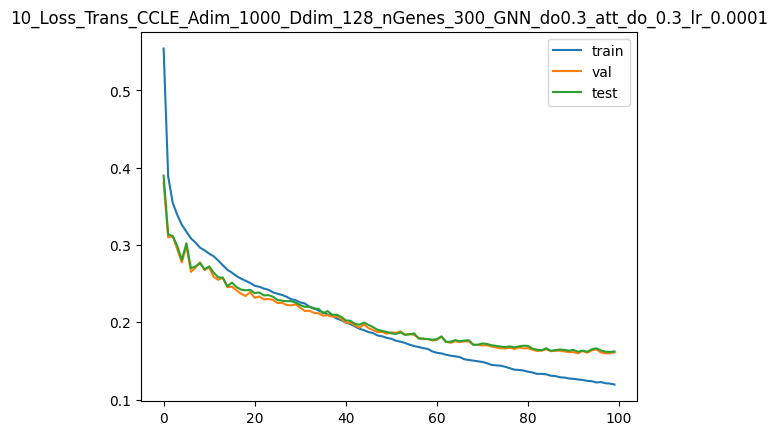

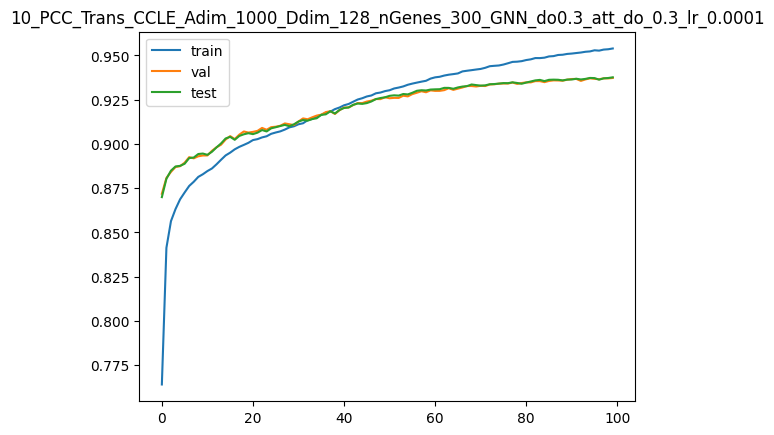

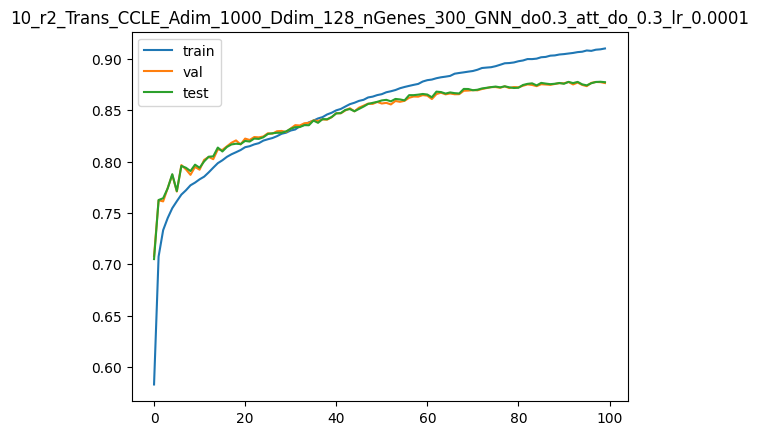

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11952442
Train avg_pcc:  0.9539752884650882
Train r2:  0.9100664532966042


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16004802
Validation avg_pcc:  0.9369768397273941
Validation r2:  0.8772414575936681


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16123997
Test avg_pcc:  0.9373464871832891
Test r2:  0.8779935550623008
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11853887
Train avg_pcc:  0.9543644517995378
Train r2:  0.9108079975018587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15958847
Validation avg_pcc:  0.9372387559254124
Validation r2:  0.8775939167472171
Best Val r2  0.8775939167472171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16162337
Test avg_pcc:  0.9372639362412671
Test r2:  0.8777034363103049
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11691505
Train avg_pcc:  0.9550034086115426
Train r2:  0.9120298260869881


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16042322
Validation avg_pcc:  0.9370893489367381
Validation r2:  0.8769536727727016


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16229722
Test avg_pcc:  0.9371369501841926
Test r2:  0.8771935546754518
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11776635
Train avg_pcc:  0.9546690528212294
Train r2:  0.9113892715685878


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1586371
Validation avg_pcc:  0.9375555789136387
Validation r2:  0.8783236404946178
Best Val r2  0.8783236404946178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15950377
Test avg_pcc:  0.9380922882467096
Test r2:  0.8793072805437265
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11576851
Train avg_pcc:  0.9554552012795627
Train r2:  0.9128925104132178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1623974
Validation avg_pcc:  0.9382471086275238
Validation r2:  0.8754394584309401


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16496912
Test avg_pcc:  0.938121810908076
Test r2:  0.8751717904893315
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.115809634
Train avg_pcc:  0.9554393057822166
Train r2:  0.9128615686185261


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16008928
Validation avg_pcc:  0.9374655122038371
Validation r2:  0.8772097912143176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16205443
Test avg_pcc:  0.9375090477109236
Test r2:  0.8773772654280579
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11555698
Train avg_pcc:  0.9555390086239423
Train r2:  0.9130516684588083


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16158657
Validation avg_pcc:  0.9378253472888166
Validation r2:  0.8760613787077973


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16294475
Test avg_pcc:  0.938168000818619
Test r2:  0.8767035822983931
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11407759
Train avg_pcc:  0.9561213390902096
Train r2:  0.9141647951986773


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15596953
Validation avg_pcc:  0.9383455152495708
Validation r2:  0.8803696838776005
Best Val r2  0.8803696838776005


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15864629
Test avg_pcc:  0.938205190464996
Test r2:  0.8799561255779762
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11371068
Train avg_pcc:  0.956265024463634
Train r2:  0.9144408721830494


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1589112
Validation avg_pcc:  0.93830531944141
Validation r2:  0.8781134053721564


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16206907
Test avg_pcc:  0.9378715649864604
Test r2:  0.8773661956616394
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11255423
Train avg_pcc:  0.956719837331056
Train r2:  0.9153110091784502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1565007
Validation avg_pcc:  0.9382810557345634
Validation r2:  0.8799622835518471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15900733
Test avg_pcc:  0.9381855595088165
Test r2:  0.8796829398328451
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11264722
Train avg_pcc:  0.956683540807941
Train r2:  0.915241036574369


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15647206
Validation avg_pcc:  0.9383084967220774
Validation r2:  0.8799842441159782


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15824787
Test avg_pcc:  0.9384838919937942
Test r2:  0.8802576106371377
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11231925
Train avg_pcc:  0.9568129810555015
Train r2:  0.9154878227869567


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1586471
Validation avg_pcc:  0.937794328946936
Validation r2:  0.8783159624602115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16079883
Test avg_pcc:  0.9378958341303213
Test r2:  0.8783273376396517
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11082023
Train avg_pcc:  0.9574013090122822
Train r2:  0.9166157305356556


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15662424
Validation avg_pcc:  0.9380202681851625
Validation r2:  0.8798675203450266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15778378
Test avg_pcc:  0.938413678950574
Test r2:  0.8806087713341841
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.11125348
Train avg_pcc:  0.9572320273757894
Train r2:  0.9162897416855978


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15556414
Validation avg_pcc:  0.938754768278344
Validation r2:  0.8806806245559049
Best Val r2  0.8806806245559049


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15862827
Test avg_pcc:  0.9383851375527635
Test r2:  0.8799697617277984
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.110366575
Train avg_pcc:  0.9575805806902974
Train r2:  0.9169570743784572


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15663584
Validation avg_pcc:  0.9384987178653437
Validation r2:  0.8798586311410985


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15868501
Test avg_pcc:  0.9385419318101427
Test r2:  0.8799268230876843
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10826763
Train avg_pcc:  0.9584042128006519
Train r2:  0.9185363810164369


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15568854
Validation avg_pcc:  0.9386120924483992
Validation r2:  0.880585208382271


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1578091
Test avg_pcc:  0.9386509607524017
Test r2:  0.8805896124984655
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10931426
Train avg_pcc:  0.9579936205868329
Train r2:  0.9177488607862866


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15716846
Validation avg_pcc:  0.9379736537005108
Validation r2:  0.8794500968123347


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.157816
Test avg_pcc:  0.9387124239528809
Test r2:  0.8805843891511985
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10839673
Train avg_pcc:  0.9583534800251106
Train r2:  0.9184392381511645


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1548864
Validation avg_pcc:  0.9389163159313143
Validation r2:  0.8812004622066716
Best Val r2  0.8812004622066716


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15820968
Test avg_pcc:  0.9385662789282191
Test r2:  0.8802865007841466
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10742227
Train avg_pcc:  0.9587365228488857
Train r2:  0.919172447024055


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15745533
Validation avg_pcc:  0.9391937264316632
Validation r2:  0.8792300742780221


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1597993
Test avg_pcc:  0.9391689754315476
Test r2:  0.8790836794074002
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10741746
Train avg_pcc:  0.958738071820805
Train r2:  0.9191760711325558


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15659708
Validation avg_pcc:  0.9390542678572029
Validation r2:  0.8798883617147486


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15923038
Test avg_pcc:  0.9388607350042796
Test r2:  0.8795141672564197
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.106576405
Train avg_pcc:  0.9590681650013224
Train r2:  0.9198089046047622


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15590438
Validation avg_pcc:  0.9385337620045865
Validation r2:  0.8804196604183401


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15711407
Test avg_pcc:  0.9389326304097709
Test r2:  0.8811155206397355
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10641356
Train avg_pcc:  0.9591326131908529
Train r2:  0.9199314432953714


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15601282
Validation avg_pcc:  0.9392043621718018
Validation r2:  0.8803364952533538


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1575684
Test avg_pcc:  0.9394615734895996
Test r2:  0.8807717413832141
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10590859
Train avg_pcc:  0.9593296177442299
Train r2:  0.9203113907860256


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15612926
Validation avg_pcc:  0.9388202225622555
Validation r2:  0.8802471824386395


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15784597
Test avg_pcc:  0.9390470788777979
Test r2:  0.8805617030992405
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10505585
Train avg_pcc:  0.9596641004218797
Train r2:  0.9209530055474219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15632142
Validation avg_pcc:  0.939527476868846
Validation r2:  0.8800997951197468


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1588466
Test avg_pcc:  0.9394926420878205
Test r2:  0.8798045626492711
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.104566544
Train avg_pcc:  0.9598558482497003
Train r2:  0.9213211758106487


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15459765
Validation avg_pcc:  0.9395725146925062
Validation r2:  0.8814219351056889
Best Val r2  0.8814219351056889


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15797499
Test avg_pcc:  0.9391099001739786
Test r2:  0.8804640759193573
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10384308
Train avg_pcc:  0.9601394021854491
Train r2:  0.9218655279268803


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15688115
Validation avg_pcc:  0.9386154385735377
Validation r2:  0.8796704681239536


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15811193
Test avg_pcc:  0.9389357887333146
Test r2:  0.8803604640153366
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10427309
Train avg_pcc:  0.9599714698249041
Train r2:  0.9215419831358727


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1539093
Validation avg_pcc:  0.9395695055820064
Validation r2:  0.8819499128425918
Best Val r2  0.8819499128425918


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15645799
Test avg_pcc:  0.9394099482829287
Test r2:  0.8816119525592006
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10335699
Train avg_pcc:  0.9603306391594557
Train r2:  0.9222312783596113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15706734
Validation avg_pcc:  0.938345784138489
Validation r2:  0.8795276747730334


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15825042
Test avg_pcc:  0.9389604654716752
Test r2:  0.8802556672505967
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10150377
Train avg_pcc:  0.961055544049184
Train r2:  0.9236256879439794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15467739
Validation avg_pcc:  0.9389795797105336
Validation r2:  0.8813607807759737


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15806329
Test avg_pcc:  0.9385828753549454
Test r2:  0.8803972616316679
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10278788
Train avg_pcc:  0.9605530936087615
Train r2:  0.9226594891410582


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15426186
Validation avg_pcc:  0.93960411985213
Validation r2:  0.881679507678253


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15807623
Test avg_pcc:  0.9390008833523954
Test r2:  0.8803874921516774
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.102384664
Train avg_pcc:  0.9607105459747475
Train r2:  0.9229628736499227


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15700105
Validation avg_pcc:  0.9390979469889048
Validation r2:  0.8795784913787478


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15930632
Test avg_pcc:  0.9389415629238871
Test r2:  0.8794567024256396
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.100807816
Train avg_pcc:  0.9613286543863571
Train r2:  0.9241493560822811


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15422362
Validation avg_pcc:  0.9397014318378644
Validation r2:  0.8817088236531359


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15624024
Test avg_pcc:  0.9397266017834518
Test r2:  0.8817767335569647
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10076838
Train avg_pcc:  0.961343236915592
Train r2:  0.9241790280141382


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1528839
Validation avg_pcc:  0.9397735437155633
Validation r2:  0.8827364041585641
Best Val r2  0.8827364041585641


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15567729
Test avg_pcc:  0.9395474971143359
Test r2:  0.8822026917371381
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10049272
Train avg_pcc:  0.9614515728771212
Train r2:  0.9243864366501139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15485
Validation avg_pcc:  0.9392965142765608
Validation r2:  0.8812283732706958


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15618065
Test avg_pcc:  0.9395877597321708
Test r2:  0.8818218299794249
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.10012265
Train avg_pcc:  0.9615967051183467
Train r2:  0.9246648894999314


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15377198
Validation avg_pcc:  0.9398866076068212
Validation r2:  0.8820552408011216


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1552628
Test avg_pcc:  0.9401999894393986
Test r2:  0.8825163264066425
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0991103
Train avg_pcc:  0.9619919360796493
Train r2:  0.9254266048631138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15333322
Validation avg_pcc:  0.9394695585940392
Validation r2:  0.882391772718498


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15526287
Test avg_pcc:  0.9396336025147586
Test r2:  0.882516267403942
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.098716564
Train avg_pcc:  0.9621460100478767
Train r2:  0.9257228682968442


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15414284
Validation avg_pcc:  0.939250127371198
Validation r2:  0.8817707833964842


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15445028
Test avg_pcc:  0.9400179805307525
Test r2:  0.883131137386
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.099283844
Train avg_pcc:  0.9619243712288046
Train r2:  0.9252960367736615


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15559506
Validation avg_pcc:  0.9398579949074425
Validation r2:  0.8806569204911247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15828542
Test avg_pcc:  0.9396243090288905
Test r2:  0.880229184305055
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09805746
Train avg_pcc:  0.9624038677955243
Train r2:  0.9262188016047765


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15459336
Validation avg_pcc:  0.9395247665401025
Validation r2:  0.8814252247527613


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15625934
Test avg_pcc:  0.9397800233573546
Test r2:  0.8817622717144695
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.097674176
Train avg_pcc:  0.9625539446069833
Train r2:  0.9265071964793877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15563771
Validation avg_pcc:  0.9388065944448831
Validation r2:  0.880624207648121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15792088
Test avg_pcc:  0.938862827905598
Test r2:  0.8805050114667439
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.0981414
Train avg_pcc:  0.9623710363694289
Train r2:  0.9261556389256321


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1544506
Validation avg_pcc:  0.9397986640962875
Validation r2:  0.8815347323605544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15698491
Test avg_pcc:  0.9396761709568533
Test r2:  0.8812132474899047
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.097173914
Train avg_pcc:  0.962749372642199
Train r2:  0.9268835996712796


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15692453
Validation avg_pcc:  0.9388583805331331
Validation r2:  0.8796372035328266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15690954
Test avg_pcc:  0.9396550616623638
Test r2:  0.8812702852729095
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09634161
Train avg_pcc:  0.9630742073970646
Train r2:  0.9275098512738579


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15343119
Validation avg_pcc:  0.9394607877700489
Validation r2:  0.882316627277185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15512389
Test avg_pcc:  0.9396932245897652
Test r2:  0.8826214390898492
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09629931
Train avg_pcc:  0.9630903150313468
Train r2:  0.9275416785650107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15484005
Validation avg_pcc:  0.9397848152871178
Validation r2:  0.8812360171320794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15642273
Test avg_pcc:  0.939902049550238
Test r2:  0.8816386402265549
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09581659
Train avg_pcc:  0.9632798536669843
Train r2:  0.9279048870384831


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15295626
Validation avg_pcc:  0.9398654437464748
Validation r2:  0.8826808954467351


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15537359
Test avg_pcc:  0.9398781398913905
Test r2:  0.8824324989990643
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.094804846
Train avg_pcc:  0.9636740112075958
Train r2:  0.9286661591404183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15167013
Validation avg_pcc:  0.9402646086487997
Validation r2:  0.8836673774630548
Best Val r2  0.8836673774630548


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15332234
Test avg_pcc:  0.9404350598344301
Test r2:  0.8839846229541036
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09463748
Train avg_pcc:  0.9637402893528784
Train r2:  0.9287920829842797


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15417145
Validation avg_pcc:  0.9394306937068249
Validation r2:  0.8817488320942675


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15588944
Test avg_pcc:  0.9397958767842011
Test r2:  0.8820421802974092
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09473774
Train avg_pcc:  0.9637004956444718
Train r2:  0.9287166499048761


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15238032
Validation avg_pcc:  0.9404055298842475
Validation r2:  0.8831226675953835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15668578
Test avg_pcc:  0.9397084728921087
Test r2:  0.88143958774242
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.09484744
Train avg_pcc:  0.9636579353612532
Train r2:  0.9286341028301798


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15482262
Validation avg_pcc:  0.9401477830710075
Validation r2:  0.8812493892760378


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15828249
Test avg_pcc:  0.9396493207546928
Test r2:  0.880231403944733
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Train avg_loss:  0.094486795
Train avg_pcc:  0.9637989043732927
Train r2:  0.928905458062248


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15670598
Validation avg_pcc:  0.9400214633888323
Validation r2:  0.8798048279370667


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15863721
Test avg_pcc:  0.940119771686202
Test r2:  0.8799629985706471


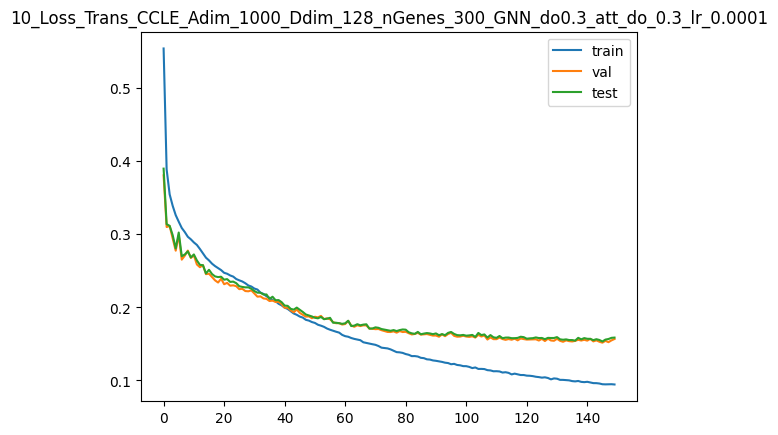

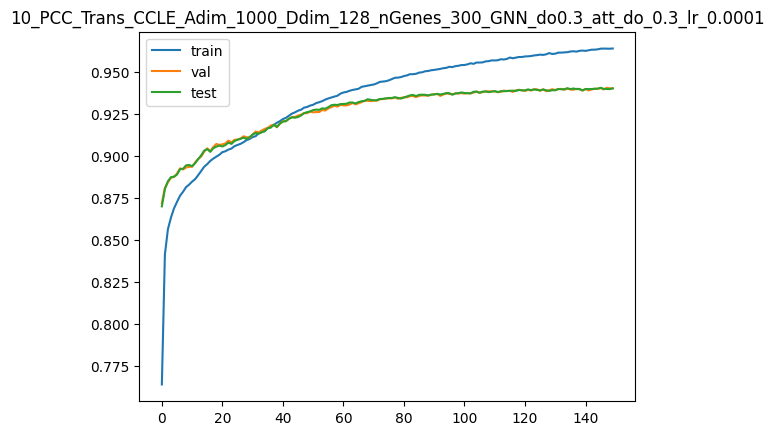

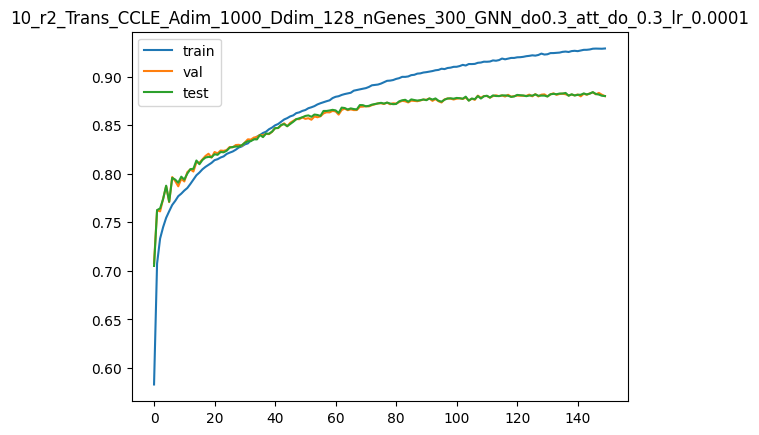

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15332235
Test avg_pcc:  0.9404350599313732
Test r2:  0.8839846232415541


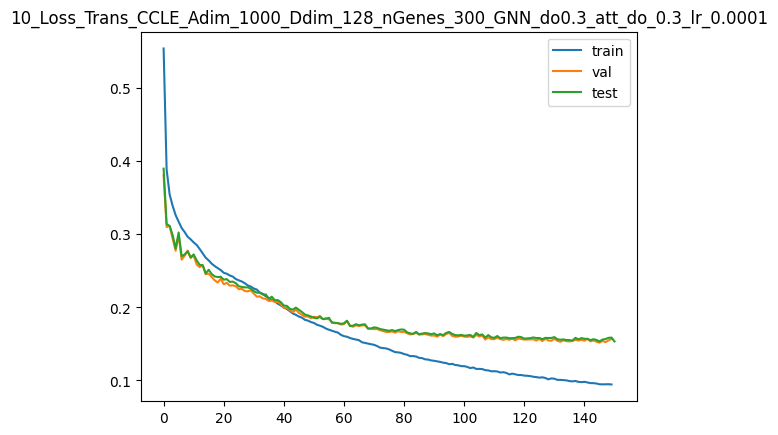

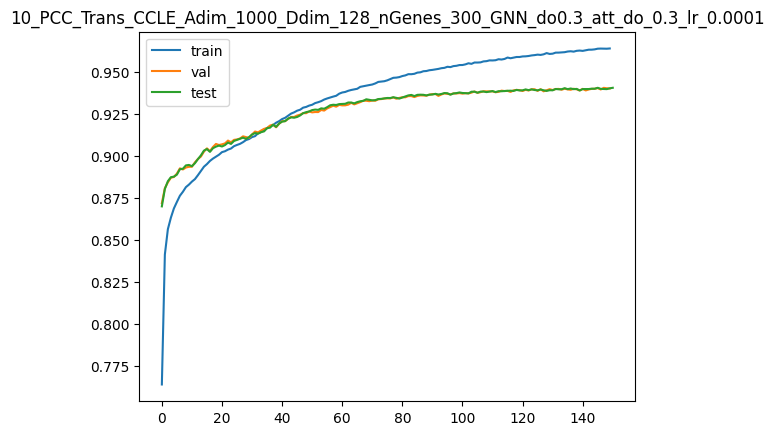

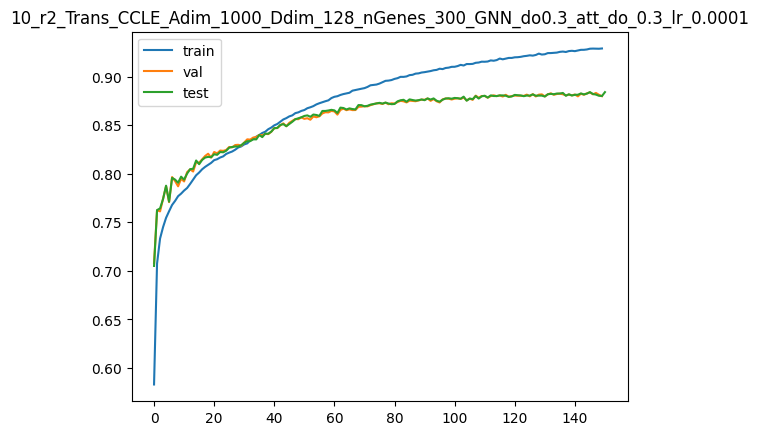

In [4]:
all_samples =  gexpr_feature.index
save_path = '/NAS_Storage3/zoo00/GEN/CCLE/multi_cor/gexpr_cor/epoch150/att1000/weights/'
img_path = '/NAS_Storage3/zoo00/GEN/CCLE/multi_cor/gexpr_cor/epoch150/att1000/imgs/'
result_path = "/NAS_Storage3/zoo00/GEN/CCLE/multi_cor/gexpr_cor/epoch150/att1000/results/"

total_train_pcc = []
total_val_pcc = []
total_test_pcc = []
total_train_r2 = []
total_val_r2 = []
total_test_r2 = []
total_train_losses = []
total_test_losses = []
total_val_losses = []

from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=10, test_size=0.1)

split1 = ss.split(input_df_gexpr)
split2 = ss.split(input_df_gexpr)

fold = 0
for train2_index, test2_index in split2:
    fold += 1

    train2_index, val2_index = train_test_split(train2_index, test_size=1/9)
    train_df_gexpr = input_df_gexpr.iloc[train2_index].reset_index(drop=True)
    val_df_gexpr = input_df_gexpr.iloc[val2_index].reset_index(drop=True)
    test_df_gexpr = input_df_gexpr.iloc[test2_index].reset_index(drop=True)


    train_dataloader = get_gnn_dataloader(train_df_gexpr, batch_size=batch_size)
    validation_dataloader = get_gnn_dataloader(val_df_gexpr, batch_size=batch_size)
    test_dataloader = get_gnn_dataloader(test_df_gexpr,batch_size=batch_size)

    gene_embedding = Gene_Embedding(vocab_size= vocab_size,embed_size=embed_size)

    gnn = GNN_drug(layer_drug = layer_drug, dim_drug = dim_drug, do = gnn_dropout)

    cell_encoder = Transformer_Encoder(genes = nGenes, x_dim= embed_size, y_dim = att_dim,
                                        dropout = att_dropout, encoder = C_EnC)

    drug_encoder = Transformer_Encoder(genes = nGenes, x_dim= nhid, y_dim = att_dim,
                                        dropout = att_dropout, encoder = D_EnC)


    encoder = Main_Encoder(cell_encoder = cell_encoder, d_dim = nhid,
                            genes=nGenes, y_dim=att_dim, dropout = att_dropout)

    model = GEN(y_dim = att_dim*2, dropout_ratio = fc_dropout,
                gnn = gnn, embedding = gene_embedding, encoder = encoder)

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr) #0.0001
    mse = nn.MSELoss()

    train_pcc = []
    val_pcc = []
    test_pcc = []

    train_r2 = []
    val_r2 = []
    test_r2 = []

    best_pcc = 0
    train_loss = []
    test_loss = []
    val_loss = []
    for ep in range(nb_epoch):
        true_Y = []
        pred_Y = []


        model.train()
        for step, (x_drug, x_genes_gexpr, x_gexpr, y) in enumerate(train_dataloader):
            if len(y) >1:
                optimizer.zero_grad()

                x_drug = x_drug.to(device)
                x_gexpr = x_gexpr.to(device)
                x_genes_gexpr = x_genes_gexpr.to(device)
                y = y.to(device).float()

                pred_y = model(x_drug,x_gexpr, x_genes_gexpr)

                loss = mse(pred_y.view(-1),y)

                loss.backward()
                optimizer.step()

                pred_y = pred_y.view(-1).detach().cpu().numpy()
                y = y.detach().cpu().numpy()

                true_Y += list(y)
                pred_Y += list(pred_y)

            # if (step+1) %500 ==0:
            #     print(title)
            #     print("training step: ", step)
            #     print("step_training loss: ", loss.item())
            #     overall_pcc = pearsonr(pred_y,y)[0]
            #     print("The overall Pearson's correlation is %.4f."%overall_pcc)

        loss_train = mean_squared_error(true_Y, pred_Y)
        pcc_train = pearsonr(true_Y, pred_Y)[0]
        r2_train = r2_score(true_Y, pred_Y)
        print("Train avg_loss: ", loss_train)
        print("Train avg_pcc: ", pcc_train)
        print("Train r2: ", r2_train)

        train_pcc.append(pcc_train)
        train_loss.append(loss_train)
        train_r2.append(r2_train)

        total_val_loss = 0.
        sum_pcc = 0.
        true_Y = []
        pred_Y = []

        model.eval()
        for step, (x_drug, x_genes_gexpr, x_gexpr, y) in enumerate(validation_dataloader):
            if len(y) >1:
                x_drug = x_drug.to(device)
                x_gexpr = x_gexpr.to(device)
                x_genes_gexpr = x_genes_gexpr.to(device)
                y = y.to(device).float()

                pred_y = model(x_drug,x_gexpr, x_genes_gexpr)

                loss = mse(pred_y.view(-1),y)

                pred_y = pred_y.view(-1).detach().cpu().numpy()
                y = y.detach().cpu().numpy()

                true_Y += list(y)
                pred_Y += list(pred_y)

                total_val_loss += loss.item()


        loss_val = mean_squared_error(true_Y, pred_Y)
        pcc_val = pearsonr(true_Y, pred_Y)[0]
        r2_val = r2_score(true_Y, pred_Y)

        print("Validation avg_loss: ", loss_val)
        print("Validation avg_pcc: ", pcc_val)
        print("Validation r2: ", r2_val)
        val_loss.append(loss_val)
        val_pcc.append(pcc_val)
        val_r2.append(r2_val)

        if best_pcc < val_r2[-1]:
            best_pcc = val_r2[-1]
            torch.save(model.state_dict(),save_path+title+'.pt')
            print('Best Val r2 ', best_pcc)

        true_Y = []
        pred_Y = []

        model.eval()

        for step, (x_drug, x_genes_gexpr, x_gexpr, y) in enumerate(test_dataloader):
            if len(y) >1:
                x_drug = x_drug.to(device)
                x_gexpr = x_gexpr.to(device)
                x_genes_gexpr = x_genes_gexpr.to(device)
                y = y.to(device).float()

                pred_y = model(x_drug,x_gexpr, x_genes_gexpr)
                loss = mse(pred_y.view(-1),y)

                pred_y = pred_y.view(-1).detach().cpu().numpy()
                y = y.detach().cpu().numpy()

                true_Y += list(y)
                pred_Y += list(pred_y)

        loss_test = mean_squared_error(true_Y, pred_Y)
        pcc_test = pearsonr(true_Y, pred_Y)[0]
        r2_test = r2_score(true_Y, pred_Y)

        print("Test avg_loss: ", loss_test)
        print("Test avg_pcc: ", pcc_test)
        print("Test r2: ", r2_test)

        test_pcc.append(pcc_test)
        test_loss.append(loss_test)
        test_r2.append(r2_test)

        if (ep+1) %50 ==0:
            input_title = str(fold)+'_Loss_'+title
            show_picture(train_loss,val_loss, test_loss, input_title)
            input_title = str(fold)+'_PCC_'+title
            show_picture(train_pcc,val_pcc, test_pcc, input_title)
            input_title = str(fold)+'_r2_'+title
            show_picture(train_r2,val_r2, test_r2, input_title)


        print("#################### epoch ############################ ",ep)

    model.load_state_dict(torch.load(save_path+title+'.pt'))
    torch.save(model.state_dict(), save_path+title+'_final.pt')
    true_Y = []
    pred_Y = []

    model.eval()

    for step, (x_drug, x_genes_gexpr, x_gexpr, y) in enumerate(test_dataloader):
        if len(y) >1:
            x_drug = x_drug.to(device)
            x_gexpr = x_gexpr.to(device)
            x_genes_gexpr = x_genes_gexpr.to(device)
            y = y.to(device).float()

            pred_y = model(x_drug,x_gexpr, x_genes_gexpr)
            loss = mse(pred_y.view(-1),y)

            pred_y = pred_y.view(-1).detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            true_Y += list(y)
            pred_Y += list(pred_y)


    loss_test = mean_squared_error(true_Y, pred_Y)
    pcc_test = pearsonr(true_Y, pred_Y)[0]
    r2_test = r2_score(true_Y, pred_Y)

    print("Test avg_loss: ", loss_test)
    print("Test avg_pcc: ", pcc_test)
    print("Test r2: ", r2_test)

    test_pcc.append(pcc_test)
    test_loss.append(loss_test)
    test_r2.append(r2_test)

    input_title = str(fold)+'_Loss_'+title
    show_picture(train_loss,val_loss, test_loss, input_title,path=img_path, save=True)
    input_title = str(fold)+'_PCC_'+title
    show_picture(train_pcc,val_pcc, test_pcc, input_title,path=img_path, save=True)
    input_title = str(fold)+'_r2_'+title
    show_picture(train_r2,val_r2, test_r2, input_title,path=img_path, save=True)

    total_train_pcc.append(train_pcc)
    total_val_pcc.append(val_pcc)

    total_train_r2.append(train_r2)
    total_val_r2.append(val_r2)

    total_train_losses.append(train_loss)
    total_val_losses.append(val_loss)

    total_test_pcc.append(pcc_test)
    total_test_r2.append(r2_test)
    total_test_losses.append(loss_test)

    df_test_pcc = pd.DataFrame(data = total_test_pcc)
    df_test_r2 = pd.DataFrame(data = total_test_r2)

    df_test_losses = pd.DataFrame(data = total_test_losses)

    df_test_pcc.to_csv(result_path+title+'_pcc.csv')
    df_test_r2.to_csv(result_path+title+'_r2.csv')

    df_test_losses.to_csv(result_path+title+'_loss.csv')